Based on the extracts from 'Desmoid Tumor' and 'Fibromatosis', following set of gene-related keywords is extracted and will be used to contruct a pathway network to identify potential 'route'

Given the information, we know that the genes associated with the production of 'beta-catenin' and 'Adenomatous polyposis coli (APC)' are not mutated.  So it will assume any pathways in close connection with these two genes function properly and I elimiate any closely related pathways by association (i.e. clustering)

# 0. Setup

In [8]:
from Bio import SeqIO
from Bio.KEGG import REST
from bioservices.kegg import KEGG
from collections import deque
import pandas as pd
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image
import time
import io
import os
from itertools import chain

%matplotlib inline

In [2]:
# helper functions
def plot_network(graph):
    plt.figure(figsize=(20,20))
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_color='r')
    nx.draw_networkx_labels(graph, pos, font_size = 8)
    nx.draw_networkx_edges(graph, pos, edge_color='b')
    plt.show()

def biopython_kegg_find(db, key):
    """ Helper function using Biopython 
    return: a list of ids linked to key
    the ids need to be parsed again by Bioservices.KEGG
    """
    hsa_path = []
    result = REST.kegg_find(db, key).read()
    if result=='\n':
        pass
    else:
        df = to_df(result)
        for i in range(len(df)):
            if df.loc[i,0].startswith('hsa:'):
                hsa_path.append(df.loc[i,0])
    return hsa_path

def bioservices_kegg_find(gene):
    """ Helper function using Bioservices 
    return: a list of tuple linking key to pathwayIds
    """
    hsa_path = []
    res = k.get_pathway_by_gene(gene, "hsa")
    if res==None:
        pass
    else:
        for key, value in res.items():
            hsa_path.append((gene, key))
    return hsa_path

def bioservice_get_gene_pathways(geneIds):
    """ return: pathway based on the gene ids 
    used in conjuction with function biopython_kegg_find()
    """
    gene_path = []
    dict_data = k.parse(k.get(geneIds))
    if 'PATHWAY' in dict_data.keys():
        for path, name in dict_data['PATHWAY'].items():
            gene_path.append(path)
    return gene_path   

def to_df(result):
    """ code to return a Pandas dataframe, given tabular text """
    return pd.read_table(io.StringIO(result), header=None)

In [18]:
k = KEGG()
k.organisms = 'hsa'

# 1. Genes extraction

In [4]:
df1 = pd.read_csv('fibromatosis_pubmed_keywords.csv') # a collection of genes extracted from 'fibromatosis' PubMed abstracts
df2 = pd.read_csv('desmoid_keyphrases.csv') # a collection of genes extracted from 'Desmoid Tumor' PubMed abstracts

In [5]:
df1.info(), df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  82 non-null     object
dtypes: object(1)
memory usage: 784.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   geneIds  67 non-null     object
dtypes: object(1)
memory usage: 664.0+ bytes


(None, None)

In [6]:
df1.head(), df2.head()

(  keyword
 0    S100
 1    CD34
 2   actin
 3   c myc
 4   XIIIa,
   geneIds
 0     BMP
 1   MMP-9
 2   Ewing
 3   IOERT
 4    MMPs)

In [7]:
gene_pool = list(set(df1['keyword']).union(set(df2['geneIds'])))

In [8]:
len(gene_pool)

125

In [9]:
# To avoid any ambiguity and miss out any pathways, I will 
# include 'beta-catenin' and 'Adenomatous polyposis coli (APC)'
# two phrases to the list and clean up those irrelevant terms
gene_pool.append('Adenomatous+polyposis+coli+(APC)')
gene_pool.append('Adenomatous+polyposis+coli')
gene_pool.append('beta+catenin')
gene_pool.append('Catenin+beta-1')
gene_pool.remove('trans')
gene_pool.remove("IGF II")
gene_pool.append("IGF")
gene_pool.remove('c myc')
gene_pool.append('myc')
gene_pool.remove('c kit')
gene_pool.append('kit')

In [10]:
len(gene_pool)

128

# 2. Pathway Extraction from KEGG

In [11]:
%%time
# Using combined list with 128 input
biopython_gene_path = []
for gene in gene_pool:
    path = biopython_kegg_find('genes', gene)
    if path==[]:
        pass
    else:
        for p in path:
            biopython_gene_path.append((gene, p))

CPU times: user 3.19 s, sys: 170 ms, total: 3.36 s
Wall time: 1min 50s


In [13]:
for i in range(3):
    print(biopython_gene_path[i])
unique_set = list((set(biopython_gene_path)))

('ALK', 'hsa:256710')
('ALK', 'hsa:392636')
('ALK', 'hsa:2585')


In [14]:
%%time
hsa_pathways = []
for entry in tqdm(unique_set):
    pathways = bioservice_get_gene_pathways(entry[1])
    for ids in pathways:
        hsa_pathways.append((entry[0], ids))

  0%|          | 1/3430 [00:00<08:56,  6.40it/s]

Pfam  vATP-synt_AC39 Nab2p_Zf1


  0%|          | 3/3430 [00:00<12:13,  4.67it/s]

Pfam  I-set Ig_3 IGFBP Ig_2 Kazal_2 Kazal_1 ig V-set
Pfam  MgsA_C AAA_assoc_2 AAA RuvB_N zf-WRNIP1_ubi AAA_14 Sigma54_activat AAA_5 DUF815 AAA_16 AAA_22 ATPase_2 IstB_IS21 Mg_chelatase AAA_2 Viral_helicase1 AAA_30 TIP49 Rad17 RNA_helicase Sigma54_activ_2 Bac_DnaA AAA_7 AAA_18 NB-ARC AAA_19 ResIII ABC_tran ATP-synt_ab NACHT AAA_33 DNA_pol3_delta2 TniB AAA_3 NTPase_1 Sgf11 AAA_28 AAA_11 AAA_24 Zeta_toxin
PDB  3VHS


  0%|          | 4/3430 [00:00<12:55,  4.42it/s]

Pfam  zf-C3HC4_3 Armet SAP Prok-RING_4 zf-C3HC4_2 zf-RING_5 zf-RING_2 FYVE_2
PDB  1Y02


  0%|          | 6/3430 [00:01<12:09,  4.69it/s]

Pfam  FKBP_C Filament WH1
Pfam  PDGF CXCXC
PDB  2X1W 2X1X 4BSK


  0%|          | 8/3430 [00:03<34:03,  1.67it/s]

Pfam  DSPc Y_phosphatase Init_tRNA_PT
PDB  3S4E 4D3P 4D3Q 4D3R
Pfam  zf-H2C2_2 zf-C2H2 KRAB zf-C2H2_4 zf-C2H2_6 zf-C2H2_jaz Zn-ribbon_8 FYVE zf-C2H2_11 zinc_ribbon_15 Zf_RING zf-BED


  0%|          | 10/3430 [00:03<22:13,  2.56it/s]

Pfam  EF-hand_1 EF-hand_7 EF-hand_6 EF-hand_5 EF-hand_8


  0%|          | 12/3430 [00:04<19:22,  2.94it/s]

Pfam  I-set Ig_3 ig Ig_2 V-set Pkinase PK_Tyr_Ser-Thr C2-set_2 Izumo-Ig C1-set fn3 RhoGEF PH IQ Pkinase_fungal IQ_SEC7_PH
PDB  5TZM 4C4K 2YZ8 4RSV 4UOW 6MG9 2N56 2MWC 2ENY 2EO1 2EDT 2EDW 2EDF 2EDH 2EDL 2EDQ 2EDR 2E7B 2DKU 2CR6 1V1C
Pfam  Metallothio


  0%|          | 14/3430 [00:05<15:34,  3.65it/s]

Pfam  C2 RBD-FIP
PDB  4D0G
Pfam  TMC Ac76


  0%|          | 15/3430 [00:05<16:34,  3.43it/s]

Pfam  Stanniocalcin
Pfam  tRNA_m1G_MT
PDB  4FMW


  1%|          | 18/3430 [00:06<13:19,  4.27it/s]

Pfam  PIP5K Toxin_33
Pfam  Ceramidase


  1%|          | 20/3430 [00:06<12:28,  4.56it/s]

Pfam  DSPc Init_tRNA_PT Y_phosphatase PTPlike_phytase Yippee-Mis18
PDB  4KI9 4JNB
Pfam  LIM


  1%|          | 21/3430 [00:06<14:25,  3.94it/s]

Pfam  RRM_1 Med19 RRM_5 Cas_Cas2CT1978
PDB  2YWK
Pfam  DUF4171 HMG_box HMG_box_2


  1%|          | 24/3430 [00:07<12:40,  4.48it/s]

Pfam  MBDa MBD_C
Pfam  KH_1 RRM_1 KH_2 KH_4 KH_5 MOEP19
PDB  6FQ1 6GX6 6FQR 6GQE 2E44


  1%|          | 26/3430 [00:07<12:01,  4.72it/s]

Pfam  SH3_1 SH3_9 SH3_2 PX SH3_3
Pfam  AIB


  1%|          | 28/3430 [00:08<12:26,  4.55it/s]

Pfam  Rav1p_C WD40 ANAPC4_WD40
Pfam  Plus-3
PDB  3U1U 4L1P 4L1U 2DB9 2BZE


  1%|          | 30/3430 [00:08<11:51,  4.78it/s]

Pfam  Yos1
Pfam  ABC2_membrane_3 ABC_tran AAA_21 DUF4162 AAA_23
PDB  5XJY


  1%|          | 32/3430 [00:09<11:59,  4.72it/s]

Pfam  CPSF73-100_C Beta-Casp Lactamase_B Lactamase_B_6 RMMBL Lactamase_B_2 Lactamase_B_3 Beta_lactamase3
PDB  2I7T 2I7V
Pfam  GnRH


  1%|          | 34/3430 [00:09<12:28,  4.54it/s]

Pfam  Phospholip_A2_2
Pfam  EGF hEGF EGF_2 EGF_3 EGF_CA


  1%|          | 36/3430 [00:10<11:52,  4.76it/s]

Pfam  DEAD Helicase_C CMS1 ResIII
Pfam  RINGv zf-ANAPC11 GSH_synth_ATP zf-RING_2


  1%|          | 38/3430 [00:10<12:19,  4.59it/s]

Pfam  MAP17 Epiglycanin_C
Pfam  C1-set Ig_3 V-set ig Gag_MA C2-set_2 V-set_CD47 I-set Izumo-Ig
PDB  3PV7 3PV6 4ZSO


  1%|          | 40/3430 [00:11<12:17,  4.60it/s]

Pfam  DAGK_acc DAGK_cat RA C1_1 C1_2
Pfam  CNRIP1


  1%|          | 41/3430 [00:11<12:49,  4.40it/s]

Pfam  Myosin_head Myosin_tail_1 Myosin_N Crescentin IQ AAA_22


  1%|          | 42/3430 [00:11<12:32,  4.50it/s]

Pfam  VWC cEGF EGF_CA FXa_inhibition TILa hEGF


  1%|▏         | 44/3430 [00:11<12:08,  4.65it/s]

Pfam  NeuB SAF
PDB  1WVO
Pfam  APS_kinase ATP-sulfurylase PUA_2 AAA_33 AAA_18 PEPCK_ATP DUF5474 RsgA_GTPase YscJ_FliF
PDB  2AX4


  1%|▏         | 45/3430 [00:12<15:57,  3.54it/s]

Pfam  NPIP
Pfam  AAA Nucleolin_bd AAA_lid_3 RuvB_N AAA_16 AAA_2 AAA_22 AAA_5 AAA_14 AAA_33 TIP49 AAA_18 Mg_chelatase RNA_helicase Zeta_toxin IstB_IS21 AAA_28 NACHT ATPase ABC_tran TsaE AAA_3 Viral_helicase1 Rad17 Cytidylate_kin2 Vps4_C Sigma54_activat AAA_17 DUF815 Tnp_22_trimer
PDB  2X8A 6RO1


  1%|▏         | 47/3430 [00:12<14:08,  3.99it/s]

Pfam  PLU-1 JmjC ARID PHD JmjN zf-C5HC2
PDB  2YQE 2E6R
Pfam  MgsA_C AAA_assoc_2 AAA RuvB_N zf-WRNIP1_ubi AAA_14 Sigma54_activat AAA_5 DUF815 AAA_16 AAA_22 ATPase_2 IstB_IS21 Mg_chelatase AAA_2 Viral_helicase1 AAA_30 TIP49 Rad17 RNA_helicase Sigma54_activ_2 Bac_DnaA AAA_7 AAA_18 NB-ARC AAA_19 ResIII ABC_tran ATP-synt_ab NACHT AAA_33 DNA_pol3_delta2 TniB AAA_3 NTPase_1 Sgf11 AAA_28 AAA_11 AAA_24 Zeta_toxin
PDB  3VHS


  1%|▏         | 50/3430 [00:13<12:40,  4.44it/s]

Pfam  zf-C2H2 zf-H2C2_2 zf-C2H2_jaz zf-C2H2_4 zf-H2C2_5 zf-met TUTase NOA36 zf-C2H2_2
Pfam  zf-CXXC MBD
PDB  5W9Q 6D1T 4D4W 1IG4 1D9N


  2%|▏         | 52/3430 [00:13<12:01,  4.68it/s]

Pfam  tRNA-synt_1g GST_N_5 WHEP-TRS tRNA-synt_1 GST_C GST_C_2 Anticodon_1 GST_C_3 GST_N DUF16 Peptidase_C1_2
PDB  4BVX 4BL7 4BVY 5GL7 5GOY 5Y6L 2DJV
Pfam  Methyltransf_23 Methyltransf_12 Methyltransf_31 Methyltransf_16 Methyltransf_25
PDB  2AOT 1JQE 1JQD 2AOU 2AOV 2AOW 2AOX


  2%|▏         | 54/3430 [00:14<12:56,  4.35it/s]

Pfam  Methyltransf_11 Methyltransf_25 Methyltransf_31 Methyltransf_12 Methyltransf_23 Ubie_methyltran NodS MetW RrnaAD
PDB  2PXX
Pfam  Ion_trans Ca_chan_IQ GPHH PKD_channel
PDB  2LCM


  2%|▏         | 56/3430 [00:14<12:04,  4.66it/s]

Idasanutlin  D11219
Pfam  zf-C3HC4_3 SWIB zf-RanBP zf-RING_2 zf-FPG_IleRS
PDB  6Q9L 5C5A 6Q9O 5ZXF 5Z02 4OGN 2AXI 4WT2 4UE1 4OGT 5OC8 5LN2 4UD7 4OBA 4HG7 3TU1 3LBL 5LAW 5UMM 5XXK 5LAZ 4ZYI 4QO4 4QOC 4OAS 4JVR 5LAV 5HMI 6I3S 3JZS 6KZU 5HMH 6Q96 5VK0 4ZYF 4ODE 4OCC 4ERE 3TPX 3G03 2GV2 5J7G 5AFG 3W69 4HBM 4DIJ 1T4F 4MDN 5SWK 4ZYC 4UMN 6Q9H 6AAW 6GGN 5OAI 5J7F 4ZGK 4ZFI 4ERF 3V3B 6H22 5TRF 3TJ2 3JZR 3JZK 4MDQ 5MNJ 5HMK 4OGV 4ODF 4JV7 2VJE 4OQ3 4JVE 3LBK 2VJF 1RV1 4JWR 4XXB 4JV9 1T4E 1YCR 4HFZ 5LAY 3VZV 3VBG 5WTS 6IM9 2RUH 2MPS 2M86 2LZG 2HDP 2C6A 2C6B 1Z1M
Pfam  GTP_EFTU EFTUD2 EFG_C EFG_IV GTP_EFTU_D2 EFG_III FANCL_d3
PDB  6ID1 6ID0 6ICZ 6FF4 6FF7 5O9Z 5Z58 6AH0 5MQF 3JCR


  2%|▏         | 58/3430 [00:15<11:49,  4.75it/s]

Pfam  DUF4592
Pfam  NPIP


  2%|▏         | 60/3430 [00:15<11:25,  4.92it/s]

Pfam  WD40 Nup160
PDB  5U69 5U8F 5U8A 6SFB 3K26 5U5T 5U6D 5TTW 3K27 5U5H 3IIW 5K0M 5U62 5H13 5H14 5H19 3IJC 6SFC 5WUK 3JZH 3JPX 3JZG 3IJ1 5H15 5H17 4X3E 5U5K 3IJ0 5GSA 5H24 5WP3 3JZN 5IJ7 3IIY 4W2R 5H25 5HYN 5IJ8 6B3W 5LS6 6C24 6C23 5WG6
Pfam  SCAN zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_jaz zf-C2H2_6 DZR Zn-ribbon_8 zf_UBZ zf-C2H2_11 C1_4 zf-BED PHF5 ADK_lid
PDB  3LHR 1X6E


  2%|▏         | 62/3430 [00:16<11:17,  4.97it/s]

Pfam  HMA Hydrolase E1-E2_ATPase Hydrolase_3 Hydrolase_6 HAD_2
PDB  3CJK 5T7L 2KMV 2KMX 2KIJ 2K1R 2GA7 2G9O 1YJR 1YJT 1YJU 1YJV 1Y3J 1Y3K 1S6U 1S6O 1Q8L 1KVI 1KVJ 1AW0 2AW0
Pfam  DAGK_acc DAG_kinase_N DAGK_cat C1_1 EF-hand_1 EF-hand_7 EF-hand_6 EF-hand_5 SPARC_Ca_bdg


  2%|▏         | 64/3430 [00:16<11:12,  5.01it/s]

Pfam  GSDH SRCR Folate_rec SRCR_2 Hepsin-SRCR
Pfam  DAGK_acc DAG_kinase_N DAGK_cat C1_1 EF-hand_1 EF-hand_6 EF-hand_7 EF-hand_5 C1_2 EF-hand_8
PDB  6IIE 1TUZ


  2%|▏         | 66/3430 [00:16<11:21,  4.94it/s]

Pfam  Strumpellin
Pfam  PKD_4 Y_Y_Y REJ PKD Big_9 DUF4625 Big_13 He_PIG Por_Secre_tail MANEC SieB
PDB  2E7M


  2%|▏         | 68/3430 [00:17<11:02,  5.08it/s]

Pfam  RRM_1 SAP RRM_5
Pfam  Spy1


  2%|▏         | 69/3430 [00:17<13:13,  4.24it/s]

Pfam  EABR CC2-LZ PI3K_P85_iSH2 QLQ PKcGMP_CC zf-C2H2_4 MKRN1_C Fez1 GLTP
PDB  5H07
Pfam  DUF4745


  2%|▏         | 72/3430 [00:18<11:04,  5.06it/s]

Pfam  CEP44 NPV_P10 SRA1 Snapin_Pallidin FlgN
Pfam  MIP-T3_C MIP-T3
PDB  2EQO


  2%|▏         | 74/3430 [00:18<11:10,  5.00it/s]

Pfam  zf-C2H2_jaz zf-C2H2_2 zf-C2H2_4 zf-met
Pfam  EGF hEGF EGF_2 EGF_CA


  2%|▏         | 76/3430 [00:19<11:08,  5.02it/s]

Pfam  CC2-LZ Filament FlxA
Pfam  Tudor_2 PHD Mtf2_C PHD_2 DUF4537 Chromo
PDB  4HCZ 5XFN 5XFO 5XFP 2M0O 2E5P


  2%|▏         | 78/3430 [00:19<11:08,  5.01it/s]

Demcizumab  D10353 Dilpacimab: D11642 Enoticumab: D10460 Navicixizumab: D11126
Pfam  EGF DSL hEGF MNNL EGF_2 EGF_3 DUF4381 EGF_CA Laminin_EGF
PDB  5MVX
Pfam  Myc_N HLH DUF3287


  2%|▏         | 79/3430 [00:19<13:18,  4.19it/s]

Pfam  Actin
Pfam  DUF21 CBS cNMP_binding Nrf1_DNA-bind
PDB  4IY3 6G52


  2%|▏         | 82/3430 [00:20<11:13,  4.97it/s]

Pfam  Methyltr_RsmB-F FtsJ
Pfam  ATG16 FPP UPF0242 PRKG1_interact Sod_Ni HAUS6_N Fib_alpha FAM76 TSC22


  2%|▏         | 84/3430 [00:20<11:16,  4.95it/s]

Pfam  FAM150
Pfam  Lon_C LON_substr_bdg AAA AAA_5 ChlI AAA_16 AAA_3 AAA_2 AAA_22 AAA_PrkA AAA_18 RsgA_GTPase RuvB_N SKI Rad17 AAA_33


  3%|▎         | 86/3430 [00:21<11:20,  4.91it/s]

Pfam  DUF89 ERG4_ERG24
Pfam  ABC_membrane ABC_tran SMC_N AAA_16 MMR_HSR1 AAA_21 AAA_22 RsgA_GTPase MTABC_N AAA_29 AAA_25 Dynamin_N T2SSE DUF87
PDB  6BZS 6BZR


  3%|▎         | 88/3430 [00:21<12:00,  4.64it/s]

Pfam  tRNA_m1G_MT
Pfam  MAP1B_neuraxin


  3%|▎         | 90/3430 [00:22<12:41,  4.39it/s]

Pfam  7tm_1 7TM_GPCR_Srsx
Azacitidine  D03021<JP/US> Decitabine: D03665<US> Roducitabine: D11740
Pfam  DNMT1-RFD BAH DNA_methylase DMAP_binding zf-CXXC HTH_12
PDB  5YDR 5WVO 6K3A 3EPZ 3SWR 4WXX 4Z96 4YOC 3PTA


  3%|▎         | 92/3430 [00:22<13:54,  4.00it/s]

Pfam  LIM Zn_ribbon_2 DUF3718 zf-ACC zf_UBZ
PDB  2O10 2O13
Pfam  VWD NIDO EGF


  3%|▎         | 94/3430 [00:23<12:40,  4.38it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase Kringle I-set Ig_3 Fz Ig_2 ig V-set TMEM154
PDB  6BA5 6BAN 5Z55
Entrectinib  D10926<JP/US> Larotrectinib (DG02923): D11137 D11138<JP/US>
Pfam  PK_Tyr_Ser-Thr Pkinase I-set Ig_3 TPKR_C2 Ig_2 ig LRR_8 LRRNT V-set LRR_5 Ig_C17orf99
PDB  4ASZ 4AT5 4AT3 1WWB 4AT4 5MO9 2MFQ 1HCF


  3%|▎         | 96/3430 [00:23<12:00,  4.63it/s]

Pfam  TCRP1 PT
Pfam  zf-C2H2 zf-C2H2_4 zf-H2C2_2 SET zf-C2H2_jaz zf-C2H2_11 zf-H2C2_5 UPF0113_N zf-C2HC_2


  3%|▎         | 98/3430 [00:24<11:54,  4.66it/s]

Pfam  PH PH_9
PDB  5MR1
Pfam  AMP-binding AMP-binding_C


  3%|▎         | 99/3430 [00:24<13:51,  4.01it/s]

Pfam  Suppressor_APC
Pfam  Zwint Prominin


  3%|▎         | 102/3430 [00:25<11:22,  4.88it/s]

Pfam  Mit_proteolip
Pfam  Alk_phosphatase


  3%|▎         | 104/3430 [00:25<11:14,  4.93it/s]

Pfam  CiPC
Pfam  TSP1_CCN Cys_knot IGFBP VWC


  3%|▎         | 106/3430 [00:26<11:07,  4.98it/s]

Pfam  DSPc Rhodanese Y_phosphatase zf-RING_14 PTPlike_phytase
PDB  2VSW 4YR8 3TG3
Pfam  GCFC TIP_N G-patch G-patch_2


  3%|▎         | 108/3430 [00:26<10:59,  5.04it/s]

Pfam  RtcB Cu-oxidase_4
Pfam  GYF GYF_2 PRTase_3
PDB  5NVK


  3%|▎         | 110/3430 [00:26<11:00,  5.02it/s]

Pfam  RhoGEF Pkinase Spectrin SH3-RhoG_link PK_Tyr_Ser-Thr I-set fn3 PH Ig_3 ig PH_10 CRAL_TRIO_2 Ig_2 SH3_1 CRAL_TRIO PH_19 IQ_SEC7_PH SH3_9 SH3_2 PH_13 V-set RL11D T4_Rnl2_C
Pfam  Maf Methyltransf_2 Dimerisation2 Methyltransf_23 Methyltransf_25 Methyltransf_11 Methyltransf_12 FeoC
PDB  2P5X


  3%|▎         | 112/3430 [00:27<11:39,  4.74it/s]

Pfam  Actin
Pfam  Mito_carr


  3%|▎         | 114/3430 [00:27<11:23,  4.85it/s]

Pfam  hSac2 Myosin_TH1
Pfam  S_100 EF-hand_7 EF-hand_1 EF-hand_8 EF-hand_4 EF-hand_5
PDB  1J55 2MJW 1OZO


  3%|▎         | 116/3430 [00:28<11:08,  4.96it/s]

Pfam  CGI-121
PDB  3ENP


  3%|▎         | 118/3430 [00:28<10:56,  5.05it/s]

Pfam  TGF_beta TGFb_propeptide
Pfam  RCS1 REV


  3%|▎         | 119/3430 [00:29<13:11,  4.19it/s]

Pfam  TSC21
Pfam  SVA
PDB  3ES6


  4%|▎         | 122/3430 [00:29<10:47,  5.11it/s]

Pfam  Peptidase_S26 Peptidase_S24 DUF2798
Pfam  Trypsin Kringle EGF Trypsin_2 DUF1986


  4%|▎         | 123/3430 [00:29<12:46,  4.32it/s]

Pfam  NYAP_N NYAP_C
Pfam  Patched Sterol-sensing
PDB  6RTW 6RTX 6RTY 6RVC 6RVD 6OEU 6E1H 6N7H 6DMY 6OEV 6DMB 6DMO 6N7K 6N7G


  4%|▎         | 125/3430 [00:30<12:29,  4.41it/s]

Pfam  PH PH_11
Pfam  RRM_1 zf-CCHC RRM_5 zf-CCHC_3
PDB  2HVZ


  4%|▎         | 128/3430 [00:30<10:54,  5.05it/s]

Pfam  DUF563 Ephrin_lbd
Pfam  WT1 zf-H2C2_2 zf-C2H2 zf-C2H2_4 FOXP-CC zf-C2H2_aberr zf-met Ofd1_CTDD
PDB  5KL3 4R2Q 6B0O 5KL7 5KL6 5KL2 5KL4 4R2P 6B0R 6BLW 4R2E 6B0P 4R2R 5KL5 4R2S 6B0Q 2PRT 2JPA 2JP9


  4%|▍         | 130/3430 [00:31<10:53,  5.05it/s]

Pfam  E1-E2_ATPase P5-ATPase Hydrolase Cation_ATPase
Pfam  RNase_Zc3h12a
PDB  2N7K 2N5M


  4%|▍         | 131/3430 [00:31<12:48,  4.29it/s]

Pfam  CDT1 CDT1_C
PDB  2WVR 2LE8
Pfam  Nas2_N PDZ_6 PDZ_2 PDZ GRASP55_65


  4%|▍         | 134/3430 [00:32<10:53,  5.04it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase TGF_beta_GS Activin_recp FTA2
PDB  3MDY
Pfam  Dzip-like_N zf-C2H2 zf-Di19


  4%|▍         | 135/3430 [00:32<12:49,  4.28it/s]

Pfam  zf-ANAPC11 zf-rbx1 zf-RING_2 zf-C3HC4_2 zf-RING_UBOX
PDB  4R2Y 5JG6 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U 2MT5
Pfam  M16C_assoc Peptidase_M16_C Peptidase_M16
PDB  4L3T 4RPU 4NGE


  4%|▍         | 138/3430 [00:33<10:55,  5.03it/s]

Pfam  UCH UCH_1
PDB  3I3T 2Y5B 3MTN
Pfam  ANAPC5 TPR_12 TPR_10 TPR_2 TPR_7 VP4_haemagglut TPR_19 MapZ_EC1
PDB  6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U


  4%|▍         | 140/3430 [00:33<11:01,  4.97it/s]

Pfam  UPF0560
Pfam  LRR_8 Peptidase_S68 ZU5 LRR_4 Death LRR_9
PDB  2OF5


  4%|▍         | 142/3430 [00:33<10:52,  5.04it/s]

Pfam  Armet CheZ HeH SAP Terminase_1
PDB  2W50 4BIT 2LPN
Pfam  FTO_NTD FTO_CTD
PDB  4IE5 5DAB 4ZS2 6AKW 5F8P 4QKN 4QHO 4ZS3 4IDZ 4IE4 4IE6 3LFM 4IE0 4IE7 4CXY 4CXX 6AK4 6AEJ 4CXW 5ZMD


  4%|▍         | 144/3430 [00:34<11:00,  4.98it/s]

Pfam  TRC8_N zf-RING_2 zf-C3HC4_2 zf-rbx1 zf-C3HC4 zf-RING_5 zf-C3HC4_3 zf-RING_11 zf-ANAPC11 Prok-RING_4 zf-RING_UBOX Zn_ribbon_17 Zf_RING zf-HC5HC2H
Pfam  PRY SPRY zf-C3HC4_4 zf-RING_UBOX zf-C3HC4 zf-C3HC4_3 zf-B_box zf-C3HC4_2 zf-RING_2 zf-RING_5 zf-RING_6 GAGA DZR U-box DUF2259 zf-RING_10


  4%|▍         | 146/3430 [00:34<11:05,  4.94it/s]

Pfam  LRR_8 LRR_4 I-set Ig_3 LRR_1 LRR_5 ig Ig_2 V-set LRRNT Ig_6 LRRCT
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Peptidase_M66 DUF4953


  4%|▍         | 148/3430 [00:35<11:03,  4.95it/s]

Apratastat  D08859 Cipemastat: D03517 Prinomastat: D03797
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_4 Reprolysin_3 DUF4953 Reprolysin_5
PDB  5B5O 3ZXH 4JP4 5UWK 5B5P 3WV3 830C 5UWM 4L19 2YIG 1XUC 6HV2 2OW9 5BPA 1XUD 5BOT 1XUR 3O2X 3KRY 3ELM 3I7G 3KEK 3WV1 4JPA 3LJZ 2E2D 1ZTQ 5BOY 3KEC 4A7B 3I7I 3WV2 3KEJ 2OZR 1YOU 2D1N 456C 3TVC 4FVL 4G0D 5UWL 1PEX 2PJT 4FU4 5UWN 1FLS 1FM1 1EUB
Pfam  Pkinase PK_Tyr_Ser-Thr APH Pkinase_fungal Kdo Kinase-like


  4%|▍         | 150/3430 [00:35<11:05,  4.93it/s]

Pfam  DSPc Rhodanese Y_phosphatase CDKN3 Myotub-related Init_tRNA_PT DUF442 PTPlike_phytase
PDB  2G6Z
Pfam  Methyltransf_15 Methyltransf_25 Methyltransf_31 Met_10 UPF0020 Methyltransf_11 Cons_hypoth95 PrmA Methyltransf_3
PDB  3GDH 3EGI


  4%|▍         | 151/3430 [00:35<13:02,  4.19it/s]

Pfam  ABC_tran ABC2_membrane_3 AAA_21 AAA_23 IstB_IS21
Pfam  Methyltransf_31 Methyltransf_25 Methyltransf_11 Methyltransf_23 Methyltransf_12 PrmA MTS Methyltransf_4 CMAS TehB TPMT Spermine_synth Methyltransf_20 PCMT NodS


  4%|▍         | 154/3430 [00:36<10:56,  4.99it/s]

Pfam  AMP-binding AMP-binding_C
Opicinumab  D11767
Pfam  LRR_8 LRR_5 LRR_4 I-set Ig_3 Ig_2 ig LRR_9 LRRNT V-set
PDB  2ID5 4OQT


  5%|▍         | 156/3430 [00:36<10:55,  4.99it/s]

Pfam  ubiquitin Rad60-SLD Ubiquitin_2 Ubiquitin_5 DUF2407
PDB  6FFA 3PHX 3RT3 3SDL 3R66 3PSE 5W8U 1Z2M 5TL6 5W8T 6BI8 2HJ8
Pfam  Collagen C1q BclA_C


  5%|▍         | 157/3430 [00:37<12:47,  4.27it/s]

Pfam  WD40 ANAPC4_WD40 eIF2A WD40_like
Pfam  DUF525 YccV-like


  5%|▍         | 159/3430 [00:37<12:11,  4.47it/s]

Pfam  SelR zf-ribbon_3 Yippee-Mis18
PDB  3MAO
Pfam  S_100 EF-hand_7 EF-hand_5 EF-hand_1 EF-hand_8 DUF5532 EF-hand_6 Sigma54_CBD Sec15 Dockerin_1 DEK_C
PDB  3NXA 2L50 2L51


  5%|▍         | 161/3430 [00:38<12:09,  4.48it/s]

Pfam  DSPc DSPn Y_phosphatase PTPlike_phytase Y_phosphatase2
Pfam  Bud13
PDB  6FF4 6FF7 5Z58


  5%|▍         | 163/3430 [00:38<12:06,  4.50it/s]

Pfam  NCKAP5
Pfam  Ion_trans_2 Ion_trans DUF1580


  5%|▍         | 165/3430 [00:39<12:01,  4.52it/s]

Pfam  TMEM131_like ASH
Pfam  MIF4G T3SS_basalb_I ARD


  5%|▍         | 168/3430 [00:39<10:45,  5.05it/s]

Pfam  Guanylate_kin VGCC_beta4Aa_N SH3_1 SH3_2
Pfam  zf-RING_9


  5%|▍         | 169/3430 [00:39<12:23,  4.39it/s]

Pfam  MBT zf-C2HC
PDB  1OZ2 2RJD 2RHI 6BYB 1OYX 1OZ3 2RJE 2RHU 2RHY 2RJC 2RI3 2RI5 2PQW 2RJF 2RHX 3UWN 2RI2 2RHZ 3OQ5 3P8H
Pfam  MutS_V MutS_III MutS_I PWWP MutS_IV MutS_II UPF0524
PDB  6OQM 2O8B 2O8D 2O8F 2O8E 2O8C 2GFU


  5%|▍         | 171/3430 [00:40<12:52,  4.22it/s]

Oregovomab  D05269 Sofituzumab: D11240 Sofituzumab vedotin: D11241 Ubamatamab: D12007
Pfam  SEA
Pfam  S_100 EF-hand_7 EF-hand_4 EF-hand_1 DUF1160
PDB  4DUQ 2RGI


  5%|▌         | 174/3430 [00:40<11:05,  4.89it/s]

Pfam  zf-H2C2_2 zf-H2C2_5 zf-C2H2 zf-C2H2_4
Pfam  Homez Homeodomain Homeobox_KN
PDB  2YS9 2ECC


  5%|▌         | 176/3430 [00:41<10:51,  4.99it/s]

Pfam  SAM_2 SAM_1 DUF745
Pfam  BNIP2 CRAL_TRIO_2 CRAL_TRIO


  5%|▌         | 177/3430 [00:41<12:51,  4.22it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 BTB zf-C2H2_jaz zf-C2H2_11 zf-met zf-H2C2_5 zf-C2H2_6 zinc_ribbon_15 Zn-ribbon_8 zf-C2HC_2 zf-BED zf_UBZ zf-C2HE zf-Di19 Packaging_FI XPA_N HypA DUF3268
PDB  2Q81 3M52 5ION 2N25 2N26 2M0D 2M0E 2M0F 2LVT 2LVU 2LVR
Pfam  Kelch_3 Kelch_4 Kelch_5 Kelch_6 Kelch_1 CUB Laminin_EGF EGF_3 PSI EGF_CA PSI_integrin EGF_2 EGF


  5%|▌         | 179/3430 [00:42<12:27,  4.35it/s]

Pfam  EGF EGF_CA EGF_3 hEGF Orthoreo_P10 EGF_2 FXa_inhibition
PDB  4HDQ 3U7D
Pfam  Hormone_recep zf-C4
PDB  4RZF 3V3E 4REF 4KZJ 4RE8 4WHG 3V3Q 4WHF 4KZM 4REE 4KZI 4RZE 4RZG 2QW4 4JGV


  5%|▌         | 182/3430 [00:42<10:51,  4.98it/s]

Pfam  Histone CENP-T_C PAF CENP-S CBFD_NFYB_HMF
PDB  5B78 5B77 4LK9 4LKA 5B76 5B75 4MZG 4H9N 4H9Q 3U5N 4N4I 4H9O 5X7X 4H9P 4H9R 4GUS 5BNX 5B32 5JA4 4LLB 4GUR 3WTP 4FWF 3U5O 2UXN 5BNV 4HGA 3U5P 3AV2 5GXQ 5B33 4GU0 2V1D 5KDM 6IR9 6RNY 6J4Z 6R0C 6J51 6J4X 6J4Y 6J50 6A5L 6A5T 6INQ 6A5P 6A5U 6J4W 6A5R 6A5O
Pfam  Peptidase_M10 ShK Ig_2 Ig_3 V-set Astacin DUF4953 Reprolysin_4 Reprolysin_3 Peptidase_M57 Peptidase_M54 Neuralized Peptidase_M66 Reprolysin_5


  5%|▌         | 184/3430 [00:43<10:51,  4.98it/s]

Pfam  DEAD Helicase_C ResIII SWI2_SNF2 SNF2_N T4SS-DNA_transf AAA_19 DUF3330
Pfam  ASH Motile_Sperm Rho_N


  5%|▌         | 186/3430 [00:43<10:52,  4.97it/s]

Pfam  NNMT_PNMT_TEMT Methyltransf_11 Methyltransf_23
PDB  2A14
Pfam  Methyltr_RsmB-F UPF0004


  5%|▌         | 188/3430 [00:44<10:45,  5.03it/s]

Pfam  JAKMIP_CC3
Pfam  Kelch_3 Kelch_4 Kelch_5 Kelch_6 Kelch_1 CUB Laminin_EGF EGF_3 PSI EGF_CA PSI_integrin EGF_2 EGF


  6%|▌         | 190/3430 [00:44<10:35,  5.10it/s]

Pfam  Radical_SAM Fer4_14 Fer4_12
Pfam  S_100 EF-hand_1 EF-hand_6 EF-hand_7 p25-alpha EF-hand_5
PDB  4AQI


  6%|▌         | 192/3430 [00:44<10:36,  5.08it/s]

Pfam  Metallophos Metallophos_2
Pfam  NAD2 APOBEC2 NAD1 APOBEC_N SNAD4 APOBEC3 APOBEC_C APOBEC4_like APOBEC4 APOBEC1 dCMP_cyt_deam_1 Toxin-deaminase Hairy_orange


  6%|▌         | 194/3430 [00:45<10:36,  5.09it/s]

Pfam  S_100 EF-hand_1 EF-hand_7 EF-hand_6 EF-hand_8 EF-hand_5 EF-hand_4
PDB  5HYD
Dexlansoprazole  D08903<US> Esomeprazole (DG00023): D01984<JP/US> D04056<US> D07917 D09339 D10120<US> D11114<US> Lansoprazole: D00355<JP/US> Leminoprazole: D05906 Omeprazole (DG00020): D00455<JP/US> D01207 D05259<US> D05261<JP> Pantoprazole (DG00021): D02593<US> D05353 Penaprazole sodium hydrate: D09837 Picoprazole: D05901 Rabeprazole (DG00022): D00724<JP/US> D08463 Revaprazan hydrochloride: D05722 Tenatoprazole: D01920 Timoprazole: D05900 Vonoprazan (DG03104): D10466<JP> D11784
Pfam  E1-E2_ATPase Cation_ATPase_C Cation_ATPase H-K_ATPase_N Hydrolase Cation_ATPase_N Hydrolase_3 HAD


  6%|▌         | 195/3430 [00:45<12:41,  4.25it/s]

Pfam  PDGF PDGF_N
PDB  4HQU 4QCI 4HQX 3MJG 1PDG
Pfam  FTO_NTD FTO_CTD
PDB  4IE5 5DAB 4ZS2 6AKW 5F8P 4QKN 4QHO 4ZS3 4IDZ 4IE4 4IE6 3LFM 4IE0 4IE7 4CXY 4CXX 6AK4 6AEJ 4CXW 5ZMD


  6%|▌         | 197/3430 [00:46<12:13,  4.41it/s]

Pfam  Peptidase_M10 Hemopexin PG_binding_1 Astacin Reprolysin_4 DUF4953 Reprolysin_3 Reprolysin_5 Cas6b_C Peptidase_M66
PDB  3V96 4ILW 1Q3A
Pfam  Actin MreB_Mbl FtsA KilA-N Robl_LC7 ALP_N


  6%|▌         | 200/3430 [00:46<10:36,  5.08it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase Pkinase_fungal Kdo
Pfam  DUF572


  6%|▌         | 202/3430 [00:47<10:54,  4.93it/s]

Pfam  Ets SAM_PNT
PDB  5E8G 5JVT 5E8I 2YTU 1X66 1FLI
Pfam  Cation_ATPase_C E1-E2_ATPase ATP_Ca_trans_C Cation_ATPase Hydrolase Cation_ATPase_N Hydrolase_3


  6%|▌         | 204/3430 [00:47<10:44,  5.01it/s]

Pfam  Spy1
Pfam  MWFE
PDB  5XTC 5XTD


  6%|▌         | 206/3430 [00:47<10:43,  5.01it/s]

Pfam  FGF Fascin IL1
PDB  4OEE 4OEG 1BFG 4FGF 2FGF 4OEF 5X1O 1BFB 1BAS 1BFF 1EV2 1BFC 1FGA 1IIL 2BFH 1II4 1CVS 1FQ9 2M49 1BLA 1BLD
Pfam  Methyltransf_16 Methyltransf_25 Methyltransf_11 Methyltransf_12 Methyltransf_23 Methyltransf_31
PDB  4PWY


  6%|▌         | 208/3430 [00:48<10:53,  4.93it/s]

Pfam  UPF0004 Radical_SAM TRAM
Andecaliximab  D11262 Batimastat: D03061 Cipemastat: D03517 Ilomastat: D03793 Marimastat: D03795 Prinomastat: D03797 Rebimastat: D03800 Tanomastat: D03802
Pfam  Peptidase_M10 fn2 Hemopexin PG_binding_1 PT Reprolysin_4 Reprolysin_3 DUF4953 Peptidase_M66
PDB  6ESM 4XCT 5I12 4H1Q 5UE3 4WZV 5TH6 4JIJ 4H3X 5UE4 5CUH 4JQG 4H82 4HMA 1ITV 2OVX 2OVZ 2OW0 2OW1 1GKC 1L6J 4H2E 2OW2 5TH9 1GKD


  6%|▌         | 210/3430 [00:48<10:38,  5.05it/s]

Pfam  BAH MTA_R1 ELM2 GATA Myb_DNA-binding Myb_DNA-bind_7
Altiratinib  D10862 Amivantamab: D11894<US> Amuvatinib (DG01916): D09864 D09865 Cabozantinib (DG01670): D10062 D10095<JP/US> Capmatinib (DG02081): D10696 D10891<JP/US> Foretinib: D09618 Glesatinib: D11136 Golvatinib (DG01367): D10224 D10465 Merestinib: D11763 Onartuzumab: D09941 Savolitinib: D11139 Sitravatinib (DG03045): D11140 D11541 Telisotuzumab: D11307 Telisotuzumab vedotin: D11344 Tepotinib (DG03087): D11073<JP/US> D11717 Tivantinib: D10173 Vebreltinib: D12053
Pfam  PK_Tyr_Ser-Thr Sema TIG Pkinase PSI Pkinase_fungal Kinase-like
PDB  4R1V 3ZCL 3F66 3DKC 3Q6U 4MXC 5HTI 6SDC 5HNI 5EOB 4XMO 3Q6W 5EYC 4AP7 4EEV 3ZXZ 3DKF 1R1W 1R0P 5EYD 4XYF 3ZZE 5YA5 5UAB 4AOI 3CCN 3DKG 6SDD 3RHK 5HO6 5HLW 4IWD 5T3Q 4R1Y 4DEG 4DEH 3U6H 3QTI 3I5N 2WGJ 2WD1 3CD8 3LQ8 4DEI 3VW8 3U6I 5HOA 2G15 3C1X 5HOR 3ZC5 3ZBX 2WKM 3EFK 2RFS 5UAD 5UAF 4GG7 3R7O 3CTH 6SD9 4KNB 3L8V 3CE3 4GG5 6SDE 3F82 3CTJ 2RFN 3A4P 5DG5 3EFJ 5LSP 4K3J 2UZX 4O3T 4O3U 6I04 1SHY 2U

  6%|▌         | 212/3430 [00:49<10:35,  5.06it/s]

Pfam  Smg8_Smg9
Pfam  ANAPC10 F5_F8_type_C PITH
PDB  1JHJ 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U


  6%|▌         | 214/3430 [00:49<10:37,  5.04it/s]

Pfam  Diphthami_syn_2
Pfam  INT_SG_DDX_CT_C VWA_2 VWA DUF4596


  6%|▋         | 216/3430 [00:50<10:34,  5.06it/s]

Bromocriptine (DG00452)  D00780<JP/US> D03165 Cabergoline: D00987<JP/US> Terguride: D01348
Pfam  Hormone_1
PDB  3NCE 3N06 3NCB 3N0P 3MZG 3NCC 3D48 2Q98 3NCF 3NPZ 3EW3 1RW5
Pfam  DEAD Helicase_C AAA_22 ResIII AAA_25


  6%|▋         | 218/3430 [00:50<10:28,  5.11it/s]

Pfam  TNFR_c6 Death
PDB  3URF
Pfam  Atg14 Spc7


  6%|▋         | 220/3430 [00:50<10:31,  5.08it/s]

Pfam  RIIa
Pfam  Edc3_linker YjeF_N FDF LSM14 DUF5096
PDB  2VC8 3D3K 6S8S 2WAX 2WAY 3D3J


  6%|▋         | 222/3430 [00:51<10:35,  5.05it/s]

Pfam  MIG-14_Wnt-bd
Pfam  zf-RanBP RRM_1
PDB  2CPE


  7%|▋         | 223/3430 [00:51<12:44,  4.19it/s]

Pfam  Spot_14
Pfam  Fibrillarin GCD14 PCMT FtsJ Methyltr_RsmB-F
PDB  2IPX


  7%|▋         | 225/3430 [00:52<12:10,  4.39it/s]

Pfam  Ribosomal_S10 AAA_lid_5
Pfam  vATP-synt_E DUF4288 NifW


  7%|▋         | 227/3430 [00:52<11:48,  4.52it/s]

Pfam  RLL Cactin_mid
Pfam  Mt_ATP-synt_B TraQ DUF2105 TfuA


  7%|▋         | 230/3430 [00:53<10:20,  5.16it/s]

Pfam  SET Pre-SET Chromo
PDB  3MTS
Pfam  FAST_1 RAP FAST_2


  7%|▋         | 232/3430 [00:53<10:22,  5.13it/s]

Pfam  UPF0054
Camobucol  D06570 Elsibucol: D06582 Succinobucol: D06648
Pfam  I-set Ig_3 C2-set ig Ig_2 V-set C2-set_2 ICAM_N Ig_4 Ig_5 Ig_6 Adhes-Ig_like
PDB  1VCA 1VSC 1IJ9


  7%|▋         | 234/3430 [00:53<10:31,  5.06it/s]

Pfam  Ig_3 I-set Ig_2 ig fn3 V-set Ig_5 Ig_6 Ig_4 Pur_ac_phosph_N C2-set_2 Big_3_4 Interfer-bind
PDB  3S97 2EE2
Pfam  Methyltransf_23 Methyltransf_11 Methyltransf_25 Methyltransf_12 Methyltransf_31 CMAS Ubie_methyltran MTS PrmA Methyltransf_9 NodS Methyltransf_PK Pox_MCEL Methyltransf_15 ADH_zinc_N Methyltransf_8 Methyltransf_32


  7%|▋         | 236/3430 [00:54<10:24,  5.11it/s]

Pfam  HTH_53 PARP zf-CCCH_8 WWE
PDB  2X5Y 4X52
Pfam  BNIP2 CRAL_TRIO_2 CRAL_TRIO


  7%|▋         | 237/3430 [00:54<12:40,  4.20it/s]

Pfam  GRAB DUF4407
Pfam  AAA_2 Ank_2 Ank_5 Ank Ank_3 Ank_4 ClpB_D2-small AAA_5 AAA Sigma54_activat Zeta_toxin AAA_16 Torsin AAA_3 AAA_24 AAA_22 YchF-GTPase_C ABC_tran ATPase_2 RP853


  7%|▋         | 240/3430 [00:55<10:33,  5.04it/s]

Pfam  Peptidase_S26 Peptidase_S24
Pfam  Peptidase_M41 AAA AAA_lid_3 AAA_16 TIP49 RuvB_N AAA_5 AAA_22 IstB_IS21 AAA_33 Mg_chelatase DUF815 AAA_17 AAA_2 AAA_18 Zeta_toxin FumaraseC_C AAA_7 AAA_25 AAA_28


  7%|▋         | 242/3430 [00:55<10:21,  5.13it/s]

Pfam  MT-A70 DUF445
PDB  5IL2 5K7M 5K7W 5K7U 5IL1 5TEY 5L6D 5IL0 5L6E 5YZ9
Pfam  RIG-I_C-RD RIG-I_C Helicase_C ResIII DEAD SWI2_SNF2 AAA_19 Folliculin
PDB  3EQT 2W4R 2RQA


  7%|▋         | 243/3430 [00:56<12:21,  4.30it/s]

Pfam  LRR_8 LRR_4 LRR_5 LRR_9 TPKR_C2 LRR_1 LRRNT
Pfam  C1q Collagen BclA_C


  7%|▋         | 246/3430 [00:56<10:27,  5.07it/s]

Pfam  PDGF_N PDGF
PDB  3MJK
Pfam  Fascin FRG1 DUF569 FGF DUF5801
PDB  6I18 6I17 6I12 6I11 6I14 6I0Z 6I13 3LLP 6I15 6I16 3P53 6I10 4GOV 4GP3 4GOY 4GP0 6B0T 1DFC


  7%|▋         | 247/3430 [00:56<12:21,  4.29it/s]

Pfam  RUN UPF0242 Phage_GP20 DUF3450 DUF5595
Pfam  Peptidase_M10 Hemopexin DUF3377 PG_binding_1 Astacin Peptidase_M66 Metallopep DUF4953 Reprolysin_3 Reprolysin_4 Reprolysin_5


  7%|▋         | 249/3430 [00:57<11:58,  4.43it/s]

Pfam  BBIP10
Pfam  Ion_trans_2 Ion_trans IRK


  7%|▋         | 252/3430 [00:57<10:28,  5.05it/s]

Pfam  Sushi MASE2
Pfam  DUF4617


  7%|▋         | 253/3430 [00:58<12:10,  4.35it/s]

Pfam  fn3 Fibrinogen_C EGF_Tenascin EGF_2 EGF Pur_ac_phosph_N hEGF DUF2369 fn3_2 DUF4998
PDB  6QNV 1TEN
Pfam  RRM_1


  7%|▋         | 255/3430 [00:58<11:57,  4.42it/s]

Pfam  Phostensin_N Phostensin
Pfam  HIT DcpS_C
PDB  6J64 6J5S 6N3X 5WAA 6B42 5WA9 5KM3 5KM2 5I2F 5O8I 6J5Z 5WA8 5KLY 5IPC 5ED3 5KMC 3TW2 5KM4 6J65 6G9Z 6N3V 5IPE 5KLZ 5EMT 1KPF 6J53 6J58 5ED6 4EQE 4EQG 5KM0 5KMA 5IPB 5KM6 5KMB 5I2E 5KM1 4EQH 6N3W 5IPD 6N3Y 1KPE 4ZKV 1AV5 1KPA 1KPB 1KPC 4ZKL


  7%|▋         | 257/3430 [00:59<11:42,  4.52it/s]

Pfam  Focadhesin DUF3730 HEAT
Pfam  PK_Tyr_Ser-Thr Pkinase F5_F8_type_C PTP_tm
PDB  2WUH 6FER 2Z4F


  8%|▊         | 259/3430 [00:59<11:35,  4.56it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr Spo7_2_N
PDB  6FYV
Pfam  PRY SPRY zf-B_box zf-C3HC4 zf-C3HC4_4 zf-RING_UBOX zf-C3HC4_3 zf-RING_2 zf-C3HC4_2 Prok-RING_4 zf-RING_5 DUF3584 DUF4618 Fib_alpha Lipoprotein_7 CorA Spc7 Exonuc_VII_L DUF1664 DUF745 DNA_topoisoIV DUF2203


  8%|▊         | 261/3430 [00:59<11:24,  4.63it/s]

Pfam  Fascin FRG1 DUF569 FGF
Pfam  C1q


  8%|▊         | 264/3430 [01:00<10:18,  5.12it/s]

Pfam  Sec2p HAUS-augmin3 Atg14 TPR_MLP1_2 Spc7 UPF0242 Exonuc_VII_L PEP-utilisers_N ISG65-75 DUF1176
PDB  4LI0
Pfam  Peptidase_M54 Peptidase_M10 Reprolysin_5 Reprolysin_3 Peptidase_M43 Peptidase_M57 Reprolysin_4 Reprolysin_2


  8%|▊         | 265/3430 [01:00<11:53,  4.44it/s]

Pfam  SnAPC_2_like
Pfam  DEAD Helicase_C ResIII SWI2_SNF2 RNA_POL_M_15KD
PDB  3BER


  8%|▊         | 267/3430 [01:01<11:37,  4.53it/s]

Pfam  Spy1
PDB  5UQ2 5UQ1 5UQ3
Pfam  RHINO


  8%|▊         | 269/3430 [01:01<11:37,  4.53it/s]

Pfam  WW
Pfam  Strumpellin


  8%|▊         | 271/3430 [01:02<11:35,  4.54it/s]

Pfam  tRNA_Me_trans ThiI NAD_synthase Asn_synthase QueC
Pfam  zf-CCCH zf_CCCH_4 zf-CCCH_4 zf-CCCH_2


  8%|▊         | 274/3430 [01:02<10:22,  5.07it/s]

Pfam  zf-A20 OTU
PDB  3VUX 3ZJE 3ZJD 3ZJG 3VUW 3VUY 3ZJF 5V3P 3OJ3 3DKB 5LRX 5V3B 2VFJ 3OJ4 2EQE 2EQF 2EQG
Pfam  EGF Laminin_G_2 Laminin_G_1 hEGF Laminin_G_3 EGF_2


  8%|▊         | 276/3430 [01:03<10:28,  5.02it/s]

Pfam  CUB F5_F8_type_C DUF3481 MAM
PDB  5DQ0 5DN2 4QDQ 2QQJ 2QQO 4QDR 4QDS 6GH8 2QQK 2QQL
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_jaz zf_UBZ Zn-ribbon_8 zf-C2H2_6 C1_4 C1_1 zf-met zf-AN1 zf-trcl


  8%|▊         | 278/3430 [01:03<10:19,  5.09it/s]

Pfam  DSPc Rhodanese Y_phosphatase CDKN3 PTPlike_phytase
PDB  3EZZ
Pfam  Actin
PDB  6ICT 6ICV 5JLH 6G2T 6CXI 6CXJ


  8%|▊         | 279/3430 [01:03<12:22,  4.24it/s]

Pfam  BNIP2 CRAL_TRIO_2 DHHA2 CRAL_TRIO
Pfam  ANAPC4_WD40 VID27


  8%|▊         | 281/3430 [01:04<11:50,  4.43it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase TGF_beta_GS Activin_recp Pkinase_fungal FTA2 APH
PDB  2H62 1REW 2H64 2GOO 3QB4 3NH7 1ES7 2K3G
Pfam  RRM_1 zf_CCCH_4 Torus Nup35_RRM_2 RRM_occluded zf-CCCH_2 zf-CCCH RRM_3 FYVE zf-CCCH_3 zf-CCCH_4
PDB  6ID1 6ID0 6ICZ 6FF4 6FF7 5MQF 2YTC


  8%|▊         | 284/3430 [01:04<10:18,  5.09it/s]

Pfam  SBF2
Pfam  Arm HEAT_EZ Arm_3 IBB HEAT_2 HEAT Adaptin_N Arm_2


  8%|▊         | 286/3430 [01:05<10:11,  5.14it/s]

Pfam  PRORP PPR DnaA_N RNase_Zc3h12a
PDB  4XGL 4XGM 4ROU
Pfam  KH_1 zf-C3HC4_3 zf-C3HC4 Prok-RING_4 KH_2 zf-RING_5
PDB  5WWW 5WWX 5ZI6 5WWZ


  8%|▊         | 288/3430 [01:05<10:19,  5.08it/s]

Pfam  TMCCDC2 KKLCAg1 DUF2633 FixQ
Pfam  zf-HC5HC2H_2 zf-HC5HC2H PHD_2 PHD EPL1 C1_1 PRA-PH


  8%|▊         | 290/3430 [01:06<10:29,  4.99it/s]

Pfam  UPF0560
Pfam  NPIP


  9%|▊         | 292/3430 [01:06<10:34,  4.94it/s]

Pfam  NPIP
Pfam  zf-C3HC4_2 zf-C3HC4 RAWUL zf-RING_2 zf-RING_UBOX zf-RING_5 zf-C3HC4_3 zf-RING_6 zf-RING_10 zf-C3HC4_4 BUD22 zf-C3HC4_5 zf-rbx1
PDB  2DJB


  9%|▊         | 294/3430 [01:06<10:42,  4.88it/s]

Pfam  tRNA_bind NUDE_C
PDB  1FL0 1EUJ 1E7Z 4R3Z
Pfam  Glyco_hydro_56 EGF_2 Peptidase_M29 EGF


  9%|▊         | 296/3430 [01:07<10:47,  4.84it/s]

Pfam  BCAS2 HAUS2 THOC7 DUF4201 Tup_N CENP-F_leu_zip Cep57_CLD Uso1_p115_C
PDB  6ID1 6ID0 6ICZ 6FF7 5MQF


  9%|▊         | 298/3430 [01:07<10:52,  4.80it/s]

Pfam  Myosin_head Myosin_TH1 IQ AAA_16 AAA_22
Pfam  LCE


  9%|▊         | 300/3430 [01:08<10:43,  4.86it/s]

Pfam  ABC_tran AAA_21 SMC_N AAA_29 AAA_16 AAA_14 ABC_tran_Xtn NACHT AAA_18 RsgA_GTPase AAA_24 AAA MMR_HSR1 RNA_helicase AAA_28 AAA_22 cobW AAA_23
PDB  5ZXD
Pfam  Peptidase_M24 zf-C6H2 zf-MYND zf-HIT
PDB  2GZ5 2B3H 4IKU 4FLK 4FLL 2NQ6 2B3L 4FLI 2B3K 4U6J 5YR5 4U70 4U69 4IKT 2NQ7 5YKP 4IKS 4FLJ 5YR6 4IKR 4U6Z 4U71 4U73 5YR4 4U6W 4U76 4U1B 4U6E 4IU6 2G6P 4U6C 4U75 5YR7 4HXX


  9%|▉         | 302/3430 [01:08<10:52,  4.80it/s]

Aprinocarsen sodium  D02970 Midostaurin: D05029<US> Tigilanol tiglate: D11191
Pfam  Pkinase PK_Tyr_Ser-Thr C1_1 C2 Pkinase_C C1_2 APH
PDB  4DNL 4RA4 3IW4 2ELI
Pfam  HLH Atg14 ZapB TolA_bind_tri NUDE_C bZIP_1


  9%|▉         | 304/3430 [01:09<10:55,  4.77it/s]

Pfam  PPR_2 PPR_3 PPR_long PPR PPR_1 WRW MNE1
Pfam  INT_SG_DDX_CT_C VWA_2 VWA


  9%|▉         | 306/3430 [01:09<10:45,  4.84it/s]

Pfam  ABC_tran ABC2_membrane ABC2_membrane_7 AAA_21 AAA_29 AAA_23 AAA_16 SMC_N RsgA_GTPase NACHT MobB AAA_22 AAA_30 AAA_33 AAA_28 MeaB
PDB  5DO7
Pfam  DSPc Rhodanese Y_phosphatase zf-RING_14 PTPlike_phytase
PDB  2VSW 4YR8 3TG3


  9%|▉         | 308/3430 [01:09<10:37,  4.90it/s]

Pfam  VIR_N
Pfam  LCM Kelch_6 Kelch_5 Kelch_3 Kelch_2 Kelch_1


  9%|▉         | 310/3430 [01:10<10:38,  4.88it/s]

Pfam  RRM_1 Es2
PDB  1X5O
Pfam  Sel1


  9%|▉         | 312/3430 [01:10<10:41,  4.86it/s]

Amuvatinib (DG01916)  D09864 D09865 Ancestim: D02937 Avapritinib: D11279<US> Dasatinib (DG00714): D03658 D06414<JP/US> Dovitinib lactate: D08907 Imatinib (DG00710): D01441<JP/US> D08066 Masitinib: D10229 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nilotinib (DG00716): D06413<JP/US> D08953 Pazopanib: D05380<JP/US> Pexidartinib (DG02960): D11270 D11271<US> Regorafenib (DG00720): D10137<JP/US> D10138 Ripretinib: D11353<US> Semaxanib: D05819 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Tandutinib: D06005 Tivozanib (DG01375): D10190<US> Toceranib (DG01363): D08503 D08544 Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Pkinase Ig_3 ig I-set Ig_2 Ig_6 Ig_4 V-set CshA_NR2 Pkinase_fungal APH
PDB  3G0E 1T46 6MOB 4HVS 1T45 4U0I 6HH1 4PGZ 4K94 3G0F 4K9E 1PKG 2EC8 2E9W
Pfam  zf-RING_5 zf-C3HC4 zf-RING_2 zf-RING_UBOX zf-RING_11 zf-C3HC4_2 zf-C3HC4_4 VMA21 Prok-RING_4 zf-RING_10


  9%|▉         | 314/3430 [01:11<10:40,  4.87it/s]

Pfam  Peptidase_M10 Hemopexin DUF3377 PG_binding_1 Astacin Peptidase_M66 Peptidase_M54 Metallopep Reprolysin_3 DUF4953
PDB  1RM8
Pfam  Anillin_N Anillin PH PH_11
PDB  2Y7B 4XOI 4XH3


  9%|▉         | 316/3430 [01:11<10:44,  4.83it/s]

Pfam  Tom37 GST_N_4 GST_C_6 GST_C_2 GST_C_3 TRADD_N
Pfam  LRR_6 Cortex-I_coil ATPase CdvA DUF3122


  9%|▉         | 318/3430 [01:12<10:34,  4.91it/s]

Pfam  KH_1 RRM_1 KH_2 KH_4 MOEP19 KH_5 RRM_5
PDB  6ROL 2CQH
Pfam  2OG-FeII_Oxy_2
PDB  3S57 3RZG 3S5A 3H8R 3H8X 3H8O 3BTX 3RZH 4MG2 3BTY 3RZJ 3BU0 3BUC 4MGT 3RZL 3RZK 3BTZ 3RZM


  9%|▉         | 320/3430 [01:12<10:29,  4.94it/s]

Pfam  JAKMIP_CC3 ADIP DUF1654
Pfam  PhoLip_ATPase_C PhoLip_ATPase_N E1-E2_ATPase Cation_ATPase Hydrolase Hydrolase_3 AF-4_C


  9%|▉         | 322/3430 [01:13<10:30,  4.93it/s]

Pfam  COMMD1_N COMM_domain
PDB  2H2M
Pfam  Peptidase_M28 Peptidase_M20


  9%|▉         | 324/3430 [01:13<10:22,  4.99it/s]

Pfam  RasGEF RasGEF_N RhoGEF Histone PH PH_19 PH_10 IQ_SEC7_PH PH_13
PDB  6D55 6D56 6D59 6D5L 6CUO 6CUR 6D5E 6D5J 6BVI 6BVJ 6BVL 6D5H 6BVK 6BVM 6CUP 5OVE 5OVD 6D5G 5WFO 5OVF 2II0 6D5V 6D5M 5WFP 4US0 1NVV 5OVI 1NVU 4URZ 5WFQ 5OVG 5OVH 1DBH 6EPO 6EPP 5WFR 4URY 6D5W 4US2 4URX 6EPM 6EPN 6EPL 4URV 4US1 1XD2 1NVW 4URW 1BKD 4URU 4NYJ 4NYI 3KSY 1NVX 1Q9C 4NYM 1XD4 1XDV 1AWE
Merestinib  D11763 Tomivosertib (DG03019): D11452 D11481
Pfam  Pkinase PK_Tyr_Ser-Thr Kdo zf-RRN7 Pkinase_fungal APH
PDB  2AC3 2HW7 6CJ5 6CK3 6CKI 6CJY 2AC5 6CK6 6CJE 6CJW 6CJH


 10%|▉         | 326/3430 [01:13<10:30,  4.92it/s]

Pfam  bZIP_2 bZIP_1 Taxilin Myc-LZ GAS UPF0449 Nmad5 DUF2605 DUF2514 Fib_alpha SBE2
Pfam  zf-C3HC4_3 zf-C3HC4 zf-RING_2 zf-RING_5 Prok-RING_4 zf-C3HC4_2 zf-RING_UBOX zf-RING_4 zf-RING_10
PDB  5VEY


 10%|▉         | 328/3430 [01:14<10:24,  4.96it/s]

Pfam  UNC-79 DUF2197
Pfam  Peptidase_M10 Hemopexin DUF3377 PG_binding_1 Astacin Peptidase_M66 Peptidase_M54 Metallopep Reprolysin_3 DUF4953
PDB  1RM8


 10%|▉         | 330/3430 [01:14<10:30,  4.92it/s]

Fasudil (DG00293)  D01840 D03115<JP> D07941 Netarsudil (DG02692): D11030 D11031<US> Ripasudil hydrochloride hydrate: D10463<JP> Verosudil (DG01867): D10737 D10738
Pfam  Pkinase PK_Tyr_Ser-Thr Rho_Binding PH C1_1 APH HR1 Pkinase_C
PDB  3V8S 3O0Z 5WNF 4L2W 5WNE 2ETR 1S1C 3TV7 5KKT 5HVU 4W7P 5WNG 3TWJ 5BML 6E9W 2ETK 3NCZ 5WNH 4YVC 2ESM 5UZJ 5KKS 3NDM 3D9V 4YVE 5F5P 2V55
Pfam  Macro PARP WWE
PDB  5QHT 5QHV 5QI9 5QHU 5QI0 5QI1 5QI3 5QI5 5QI7 5QI2 5QI8 5QI6 5QHX 5QHW 5QIA 5QHZ 4ABL 5QHY 5QI4 3SMJ 5O2D 4ABK 4F1L 4D86 5LXP 6FYM 5LYH 3Q71 3Q6Z 5V7T 3SE2 6G0W 3SMI 5V7W 6FZM 5NQE 4PY4 4F1Q 3VFQ 3GOY


 10%|▉         | 332/3430 [01:15<10:39,  4.85it/s]

Pfam  Cactin_mid CactinC_cactus
Pfam  CLASP_N HEAT_2 ParcG Dopey_N DUF445 NUC173


 10%|▉         | 334/3430 [01:15<10:31,  4.90it/s]

Pfam  TGF_beta TGFb_propeptide
Pfam  HA2 OB_NTP_bind DUF5007


 10%|▉         | 336/3430 [01:16<10:28,  4.93it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr
PDB  6FYR 2EU9 2WU6 6FT7 3RAW 2WU7 6FYP 6RCT 2EXE 6KHF
Pfam  VPS11_C Clathrin zf-C3HC4_2 zf-RING_2 zf-RING_UBOX zf-rbx1 zf-C3HC4 zf-C3H2C3 zf-RING_5 zf-C3HC4_3 TPR_11 DUF5847 DLP_helical zf-ANAPC11 zf-RING-like zf-C3HC4_4 zf-RING_11


 10%|▉         | 338/3430 [01:16<10:26,  4.94it/s]

Midostaurin  D05029<US> Tigilanol tiglate: D11191
Pfam  Pkinase C1_1 PK_Tyr_Ser-Thr C2 Pkinase_C Kinase-like APH
PDB  2UZP 2E73
Pfam  zf-H2C2_2 zf-H2C2_5 zf-C2H2 zf-C2H2_4


 10%|▉         | 340/3430 [01:16<10:19,  4.99it/s]

Pfam  DSPc Rhodanese Init_tRNA_PT Y_phosphatase PTPlike_phytase CDKN3 Y_phosphatase2
PDB  2HXP 3LJ8
Pfam  TNFR_c6 Hum_adeno_E3A Peptidase_U4
PDB  5T2Q 5T2R 4FHQ 4RSU 2AW2


 10%|▉         | 342/3430 [01:17<10:11,  5.05it/s]

Mipsagargin  D10715
Pfam  E1-E2_ATPase Cation_ATPase_C Cation_ATPase Hydrolase Cation_ATPase_N Hydrolase_3 HAD
PDB  6JJU 5ZTF
Pfam  ANTH I_LWEQ HIP1_clath_bdg Filament CENP-K ATG16
PDB  3I00 2QA7 2NO2


 10%|█         | 344/3430 [01:17<10:22,  4.95it/s]

Pfam  TNF zf-LITAF-like
PDB  3B93 2Q1M 3B94 2R30
Pfam  zf_CCCH_4 zf-CCCH zf-CCCH_4 zf-CCCH_2 Torus zf-CCCH_3


 10%|█         | 346/3430 [01:18<10:22,  4.96it/s]

Pfam  MBD RRXRR
Pfam  PTPlike_phytase HTH_48


 10%|█         | 348/3430 [01:18<10:18,  4.98it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_jaz KRAB zf-C2H2_6 zinc_ribbon_15 Zn-ribbon_8 DZR C1_1 zf-C2H2_11 zf-C2HC_2
Pfam  Myosin_head Myosin_tail_1 Myosin_N Crescentin IQ AAA_22


 10%|█         | 350/3430 [01:19<10:18,  4.98it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 KRAB zf-C2H2_jaz XPA_N zf_UBZ Zn-ribbon_8 zf-C2H2_11 zinc_ribbon_15 zf-AN1 DYW_deaminase
Pfam  SET
PDB  3RQ4


 10%|█         | 352/3430 [01:19<10:23,  4.94it/s]

Pfam  FSIP2 DUF3931
Pfam  Smg8_Smg9 AAA_30


 10%|█         | 354/3430 [01:19<10:12,  5.02it/s]

Pfam  zf-CCHC zf-CCHC_4 zf-CCHC_5 zf-CCHC_6
Pfam  EF-hand_7 EF-hand_1 EF-hand_6 EF-hand_5 EF-hand_8 SPARC_Ca_bdg EF-hand_4
PDB  2E6W


 10%|█         | 356/3430 [01:20<10:02,  5.11it/s]

Pfam  ABC_membrane ABC_tran SMC_N MMR_HSR1 AAA_16 RsgA_GTPase AAA_25 AAA_22 AAA_29 ABC_ATPase Zeta_toxin PHO4 NB-ARC Dynamin_N
PDB  4C3Z 2CBZ
Pfam  TSP1_ADAMTS Pep_M12B_propep ADAM_spacer1 TSP_1 Reprolysin ADAM_CR_2 TSP1_spondin Reprolysin_5 PLAC Reprolysin_2 TSP1_CCN Reprolysin_3 Reprolysin_4


 10%|█         | 358/3430 [01:20<10:03,  5.09it/s]

Pfam  Lbh
Pfam  Ank_2 Ank_5 SAM_1 Ank_4 Ank Ank_3 Caskin-Pro-rich SAM_2 Caskin-tail Caskin1-CID SH3_2 SH3_9 SH3_1
PDB  5L1M 4IS7 2KE9


 10%|█         | 360/3430 [01:21<09:57,  5.14it/s]

Pfam  SIR2 DUF592
PDB  4KXQ 4IF6 4I5I 4IG9 4ZZI 4ZZJ 4ZZH 5BTR
Pfam  C1q


 11%|█         | 361/3430 [01:21<12:05,  4.23it/s]

Pfam  Trm112p
PDB  6H2U 6H1E 6H1D 6KMR 6K0X 6PED 6H2V 6KMS 6G4W
Pfam  RRM_1 RRM_5 RRM_occluded
PDB  2I38


 11%|█         | 363/3430 [01:21<11:39,  4.39it/s]

Pfam  PIRT TMEM100 Neurensin Phage_holin_3_6 Gram_pos_anchor
Pfam  NAD2 APOBEC2 NAD1 APOBEC_N APOBEC3 SNAD4 APOBEC_C APOBEC4_like APOBEC4 APOBEC1
PDB  5KEG 4XXO 5SWW 2M65


 11%|█         | 365/3430 [01:22<11:24,  4.48it/s]

Pfam  VWD VWC C8 TIL TILa
Pfam  LSM14 FDF SM-ATX
PDB  6F9W


 11%|█         | 367/3430 [01:22<11:11,  4.56it/s]

Pfam  Jnk-SapK_ap_N WD40_2 JIP_LZII DUF1759
PDB  2W83
Pfam  Oxysterol_BP
PDB  5ZM8


 11%|█         | 369/3430 [01:23<11:05,  4.60it/s]

Pfam  Reprolysin ADAM_CR Pep_M12B_propep Disintegrin Reprolysin_5
Pfam  SRI SET AWS WW
PDB  5JLB 5LT7 5LT8 5LSY 5LSZ 5LSS 5LT6 5JJY 4H12 4FMU 5V22 5JLE 5V21 5LSX 2MDJ 2MDC 2A7O


 11%|█         | 371/3430 [01:23<11:05,  4.60it/s]

Pfam  APCDDC
Pfam  FA_hydroxylase DUF4886


 11%|█         | 374/3430 [01:24<09:56,  5.12it/s]

Pfam  PTEN_C2 DSPc Ion_trans PTPlike_phytase Y_phosphatase Y_phosphatase3 CodY PKD_channel
Pfam  Bcl-2_BAD Bclx_interact


 11%|█         | 376/3430 [01:24<10:00,  5.09it/s]

Pfam  TGF_beta TGFb_propeptide
PDB  5I05 4MPL 1ZKZ 4YCI 4YCG 4FAO 5HZW
Pfam  zf-CCCH zf_CCCH_4 Torus zf-CCCH_3 zf-CCCH_2 zf-CCCH_4


 11%|█         | 378/3430 [01:25<10:12,  4.98it/s]

Pfam  GCP_C_terminal GCP_N_terminal
PDB  3RIP
Pfam  RICTOR_N RICTOR_phospho RasGEF_N_2 RICTOR_M RICTOR_V
PDB  5ZCS


 11%|█         | 380/3430 [01:25<10:11,  4.99it/s]

Pfam  DUF4592
Pfam  Lamp ATP-synt_S1 Mit_proteolip
PDB  4AKM


 11%|█         | 382/3430 [01:25<10:12,  4.98it/s]

Pfam  RAWUL zf-C3HC4_2 zf-C3HC4 zf-RING_UBOX zf-C3HC4_4 zf-RING_2 zf-C3HC4_3 zf-RING_5 zf-RING_10 zf-Nse zf-RING_6 zf-rbx1
PDB  4S3O
Pfam  Ig_2 Ig_3 ig DUF5671
PDB  1OLL 1P6F 6IAP


 11%|█         | 384/3430 [01:26<10:20,  4.91it/s]

Pfam  RRM_1 RRM_occluded RRM_3 Nup35_RRM_2 DDE_Tnp_1 RRM_7 CoV_nucleocap PRP38_assoc
PDB  4C0O 3BEG 2M8D 2M7S 2O3D 1X4A
Pfam  OATP MFS_1 Kazal_2 MFS_1_like Kazal_1 D_CNTX PUCC


 11%|█▏        | 386/3430 [01:26<10:31,  4.82it/s]

Pfam  zf-3CxxC_2 zf-CCHC_2 UPF0515 zf-3CxxC zf-CHY
Pfam  DUF3523 AAA RuvB_N AAA_16 AAA_24 AAA_22 ATPase Zot AAA_18 AAA_lid_3 AAA_5 TsaE Mg_chelatase RNA_helicase AAA_33 AAA_3 AAA_25 AAA_7


 11%|█▏        | 388/3430 [01:27<10:26,  4.85it/s]

Pfam  EGF hEGF fn3 EGF_2 NIDO EGF_CA cEGF
Pfam  Daz RRM_1 RRM_7 RRM_5


 11%|█▏        | 390/3430 [01:27<10:23,  4.87it/s]

Pfam  CC2-LZ Filament FlxA
Vesencumab  D10494
Pfam  CUB F5_F8_type_C DUF3481 MAM
PDB  6FMC 5JGI 5C7G 5IJR 5JGQ 5IYY 4RN5 5JHK 2QQI 1KEX 2QQM 5J1X 2QQN 5L73 4DEQ 6FMF 3I97


 11%|█▏        | 392/3430 [01:28<10:17,  4.92it/s]

Bleselumab  D11357 Dacetuzumab: D08896 Iscalimab: D11610 Lucatumumab: D08942 Ravagalimab: D11597 Selicrelumab: D11491 Teneliximab: D06071
Pfam  TNFR_c6 RANK_CRD_2 Glycophorin_A DUF2207 Syndecan
PDB  5DMJ 6PE8 6FAX 6PE9 5IHL 3QD6 5DMI
Pfam  PAT1
PDB  2XES 2XER 2XEQ


 11%|█▏        | 394/3430 [01:28<10:18,  4.91it/s]

Pfam  RabGAP-TBC Rhodanese
PDB  6JM5
Pfam  DEAD Helicase_C GUCT ResIII CMS1 ERCC3_RAD25_C AAA_30 AAA_11
PDB  2E29


 12%|█▏        | 396/3430 [01:28<10:09,  4.98it/s]

Pfam  His_Phos_1
PDB  3DCY
Pfam  Tsg


 12%|█▏        | 398/3430 [01:29<10:15,  4.93it/s]

Pfam  BTB zf-C2H2 zf-C2H2_4 zf-H2C2_2 zf-C2H2_jaz zf-C2H2_6 zf-met zf-C2H2_3rep zf-C2H2_11 zf-Di19 C1_1
Pfam  ANAPC3 TPR_2 TPR_1 TPR_12 TPR_8 TPR_7 TPR_10 TPR_19 TPR_11 TPR_16 TPR_9 SRP_TPR_like Dynein_light
PDB  3HYM 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U


 12%|█▏        | 400/3430 [01:29<10:03,  5.02it/s]

Pfam  Myb_DNA-binding Myb_DNA-bind_6 SLIDE SR-25 HTH_23
Pfam  Amidinotransf
PDB  3I4A 6DGE 2JAJ 3I2E 2JAI 3P8E 3P8P


 12%|█▏        | 402/3430 [01:30<10:12,  4.94it/s]

Pfam  EF-hand_7 S_100
Pfam  ATP1G1_PLM_MAT8 Nitrate_red_gam
PDB  2MKV


 12%|█▏        | 404/3430 [01:30<10:03,  5.01it/s]

Pfam  Actin MreB_Mbl
Pfam  FH2 DUF3010


 12%|█▏        | 406/3430 [01:31<09:55,  5.08it/s]

Pfam  zf-Di19 zf_C2HC_14 zf-C3HC4_2 zf-RING_UBOX zf-RING_5 zf-C3HC4 zf-RING_2 zf-C3HC4_3 zf-RING_6 zf-C3HC4_4 UIM zf-rbx1 U-box DZR_2 Prok-RING_4 zf-ANAPC11 zf-ribbon_3 zf-C2H2_4
Pfam  HA2 OB_NTP_bind Helicase_C DEAD AAA_22 TsaE ABC_tran zf-C2H2_4


 12%|█▏        | 408/3430 [01:31<10:01,  5.02it/s]

Pfam  BNIP3 Synthase_beta
PDB  2KA1 2KA2 2J5D
Pfam  SNF2_N Helicase_C ResIII Shugoshin_C


 12%|█▏        | 410/3430 [01:31<10:01,  5.02it/s]

Pfam  PAM2 OB_RNB
Pfam  zf-CCHC_3 Macoilin


 12%|█▏        | 412/3430 [01:32<10:05,  4.98it/s]

Pfam  KH_1 zf-C3HC4_3 zf-C3HC4 Prok-RING_4 KH_2 zf-RING_UBOX zf-RING_5 zf-P11
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 KRAB Zn-ribbon_8 zf-C2H2_jaz zinc_ribbon_15 zf-C2H2_11 C1_4


 12%|█▏        | 414/3430 [01:32<10:00,  5.02it/s]

Pfam  DFP Collectrin
PDB  1P9O
Pfam  Peptidase_M10 Hemopexin DUF4953 Astacin Reprolysin_5 Reprolysin_4 Peptidase_M43 Reprolysin_3 Peptidase_M7 Peptidase_M66


 12%|█▏        | 416/3430 [01:33<10:31,  4.77it/s]

Pfam  Peptidase_M3
PDB  2O36 1S4B
Pfam  HipN TPR_1 TPR_2 STI1 TPR_11 TPR_9 TPR_17 TPR_16 TPR_14 TPR_8 TPR_19 TPR_12


 12%|█▏        | 418/3430 [01:33<10:31,  4.77it/s]

Pfam  C1q Collagen
Pfam  MINAR1_C AGRB_N


 12%|█▏        | 420/3430 [01:34<10:29,  4.78it/s]

Pfam  TruB_N TruB_C_2 PseudoU_synth_2
Pfam  Acetyltransf_1 Acetyltransf_10 Acetyltransf_7


 12%|█▏        | 422/3430 [01:34<10:20,  4.85it/s]

Pfam  UCH zf-UBP DapB_C
PDB  2I50
Pfam  Spy1


 12%|█▏        | 424/3430 [01:34<10:16,  4.87it/s]

Pfam  Nab1 NCD2 NCD1 Paz_1
PDB  2YUF
Pfam  CSD OB_RNB
PDB  5YTX 5YTT 5YTV 5YTS 6A6L 1H95


 12%|█▏        | 426/3430 [01:35<10:20,  4.84it/s]

Pfam  Arm IBB Arm_3 HEAT_EZ HEAT_2 HEAT V-ATPase_H_C Arm_2
PDB  4UAD
Atacicept  D09704
Pfam  TNF LapA_dom


 12%|█▏        | 428/3430 [01:35<10:24,  4.81it/s]

Pfam  CARM1 PrmA Methyltransf_25 MTS Methyltransf_9 Methyltransf_11 PRMT5 Methyltransf_31 Methyltransf_23 Methyltransf_18 Methyltransf_12 CMAS TehB Met_10 Cons_hypoth95 Methyltransf_32 PRMT5_C DREV
PDB  6DVR 5U4X 6ARJ 5DX1 5DX8 5DXJ 6D2L 6ARV 4IKP 5DX0 5DXA 2Y1W 5DWQ 2Y1X
Pfam  Laminin_G_2 F5_F8_type_C Laminin_G_1 Laminin_G_3


 13%|█▎        | 430/3430 [01:36<10:20,  4.83it/s]

Pfam  Bcl-2 CEND1
Pfam  LSM vATP-synt_E DUF150_C
PDB  5O9Z 6AH0 3JCR


 13%|█▎        | 432/3430 [01:36<10:10,  4.91it/s]

Pfam  Methyltransf_3 Methyltransf_24 Methyltransf_25 Methyltransf_31 PCMT DNA_binding_1 Methyltransf_18
PDB  2AVD
Pfam  DUF3402 N1221


 13%|█▎        | 434/3430 [01:37<10:01,  4.98it/s]

Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon
Pfam  Ribophorin_I CtIP_N FliD_C DNA_repr_REX1B


 13%|█▎        | 436/3430 [01:37<09:57,  5.01it/s]

Pfam  DUF21 CBS cNMP_binding
Pfam  EMI EGF_CA FXa_inhibition EGF_2 cEGF EGF hEGF Trimer_CC


 13%|█▎        | 438/3430 [01:37<09:56,  5.01it/s]

Pfam  SnAPC_2_like
Pfam  ASXH PHD_3 HARE-HTH


 13%|█▎        | 440/3430 [01:38<09:53,  5.04it/s]

Pfam  zf-RING_2 zf-RING_11 zf-RING_UBOX zf-C3HC4_2 zf-C3HC4_3 zf-C3HC4 zf-rbx1 zf-RING_5 Zn_ribbon_17 Prok-RING_4 zf-RING_6 zf-C3H2C3 zf-C3HC4_4
Pfam  zf-RING_UBOX zf-C3HC4_2 zf-C3HC4 zf-RING_2 zf-B_box zf-C3HC4_3 zf-C3HC4_4 zf-RING_5 U-box Perilipin zf-RING_6 zf-Nse baeRF_family5 DUF4061 zf-RING_4


 13%|█▎        | 442/3430 [01:38<10:03,  4.95it/s]

Pfam  V_ATPase_I Romo1 APG6_N DUF2730
Pfam  Ist1
PDB  4WZX 4U7E 4U7I 3FRR 4U7Y 3FRS


 13%|█▎        | 444/3430 [01:39<10:17,  4.84it/s]

Pfam  Methyltr_RsmB-F FtsJ Methyltransf_31
PDB  2B9E
Pfam  wnt


 13%|█▎        | 446/3430 [01:39<10:01,  4.96it/s]

Pfam  DEAD Helicase_C zf-CCHC ResIII SecA_DEAD UTP25 ERCC3_RAD25_C CMS1
PDB  5GVR 5GVS 5H1Y 2P6N
Pfam  C2 RBD-FIP


 13%|█▎        | 448/3430 [01:40<10:02,  4.95it/s]

Pfam  DEAD Helicase_C ResIII SWI2_SNF2 RNA_POL_M_15KD
PDB  3BER
Pfam  RecQ5 DEAD Helicase_C RecQ_Zn_bind ResIII SRI TFIIS_M AAA_22 TAtT MTD
PDB  5LB3 4BK0 5LB5 5LBA 5LB8


 13%|█▎        | 450/3430 [01:40<10:00,  4.96it/s]

Pfam  DSPc Y_phosphatase
PDB  2ESB
Pfam  Methyltransf_25 Methyltransf_11 Methyltransf_31 Spermine_synth Methyltransf_12 Methyltransf_23 MTS Ubie_methyltran TPMT MetW Methyltransf_2 PrmA Med12-LCEWAV
PDB  5WCJ


 13%|█▎        | 452/3430 [01:41<10:10,  4.87it/s]

Pfam  ROQ_II zf-CCCH zf-RING_2 zf-RING_5 zf-RING_UBOX zf-C3HC4_3 Prok-RING_4 zf-CCCH_4 zf-C3HC4_4 zf_CCCH_4 Xin zf-C3HC4 zf-C3HC4_2 zf-RING_10
PDB  4ZLD 4Z31 4ZLC 4Z30
Pfam  Myosin_tail_1 Myosin_head Myosin_N IQ Crescentin CC2-LZ ADIP AAA_22
PDB  4CFQ 4CFR 3ZWH 2LNK


 13%|█▎        | 454/3430 [01:41<10:12,  4.86it/s]

Pfam  Ecm29 HEAT_2 HEAT Vac14_Fab1_bd Adaptin_N IFRD
Pfam  ADAM_spacer1 Pep_M12B_propep TSP1_ADAMTS ADAM_CR_2 Reprolysin TSP_1 Reprolysin_5 Reprolysin_3 TSP1_spondin TSP1_CCN Reprolysin_4 Reprolysin_2
PDB  2V4B 2JIH 3Q2G 3Q2H


 13%|█▎        | 456/3430 [01:41<10:19,  4.80it/s]

Pfam  CKS
PDB  2AST 4YC6 1BUH 1DKT 2ASS 1DKS
Pfam  Connexin GWT1


 13%|█▎        | 458/3430 [01:42<10:25,  4.75it/s]

Pfam  E3_UFM1_ligase IL31 CBFD_NFYB_HMF Tn7_Tnp_TnsA_C
Pfam  DUF3719


 13%|█▎        | 460/3430 [01:42<10:12,  4.85it/s]

Avapritinib  D11279<US> Crenolanib (DG01361): D10102 D10103 Ilorasertib: D10423 Imatinib (DG00710): D01441<JP/US> D08066 Linifanib: D09635 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nilotinib (DG00716): D06413<JP/US> D08953 Nintedanib (DG01374): D10396<JP/US> D10481 Olaratumab: D09939 Pazopanib: D05380<JP/US> Ripretinib: D11353<US> Seralutinib: D12002 Sitravatinib (DG03045): D11140 D11541 Sunitinib (DG00712): D06402<JP/US> D08552 Toceranib (DG01363): D08503 D08544 Tovetumab: D10411
Pfam  PK_Tyr_Ser-Thr Pkinase Ig_3 I-set ig Ig_2 V-set Herpes_gE C2-set_2 Kinase-like
PDB  5GRN 6A32 5K5X
Pfam  Aldedh


 13%|█▎        | 462/3430 [01:43<10:02,  4.93it/s]

Pfam  Laminin_EGF EGF_2 hEGF EGF DSL
Pfam  F420_oxidored Ferric_reduct NAD_binding_2 Shikimate_DH 2-Hacid_dh_C IlvN Leg1 Sacchrp_dh_NADP
PDB  2VQ3 2VNS


 14%|█▎        | 464/3430 [01:43<09:56,  4.97it/s]

Pfam  LUC7
Pfam  AAA Bromodomain AAA_lid_3 AAA_16 IstB_IS21 AAA_2 AAA_22 AAA_5 RuvB_N AAA_7 RNA_helicase ResIII AAA_18 Mg_chelatase TIP49 AAA_11
PDB  3LXJ 2DKW


 14%|█▎        | 466/3430 [01:44<09:49,  5.03it/s]

Pfam  HTH_16
Pfam  Peptidase_M41 AAA AAA_lid_3 AAA_16 TIP49 RuvB_N AAA_5 AAA_22 IstB_IS21 AAA_33 Mg_chelatase DUF815 AAA_17 AAA_2 AAA_18 Zeta_toxin FumaraseC_C AAA_7 AAA_25 AAA_28


 14%|█▎        | 468/3430 [01:44<09:45,  5.06it/s]

Pfam  SWIM
Pfam  zf-FCS DUF3504 YHS Arc_trans_TRASH


 14%|█▎        | 470/3430 [01:44<09:39,  5.11it/s]

Biricodar dicitrate  D03128 Elacridar hydrochloride: D03968 Encequidar (DG03103): D11782 D11783 Tariquidar: D06008 Tesmilifene hydrochloride: D06084 Valspodar: D06277 Zosuquidar trihydrochloride: D06387
Pfam  ABC_membrane ABC_tran SMC_N ABC_ATPase AAA_16 AAA_22 Rad17 RsgA_GTPase G-alpha Zeta_toxin AAA AAA_29 AAA_5 AAA_7 AAA_14 APS_kinase PRK DUF815 AAA_15 AAA_30 AAA_24 NTPase_1
PDB  6C0V 6QEX
Pfam  CUTL CUT ULD Homeodomain
PDB  2CSF 1WI3 1WIZ


 14%|█▎        | 471/3430 [01:45<11:33,  4.27it/s]

Aflibercept  D09574<JP/US> Aflibercept beta: D10819<JP>
Pfam  PDGF
PDB  1FZV 1RV6


 14%|█▍        | 474/3430 [01:45<09:55,  4.96it/s]

Pfam  FtsJ Methyltransf_23
PDB  2NYU
Pfam  DUF2370


 14%|█▍        | 476/3430 [01:46<09:48,  5.02it/s]

Pfam  DEAD Helicase_C SPRY CMS1 ResIII DUF5766
PDB  4XW3
Pfam  Porphobil_deam Porphobil_deamC MGS
PDB  3ECR 5M6R 5M7F 3EQ1


 14%|█▍        | 478/3430 [01:46<09:52,  4.98it/s]

Pfam  Myb_DNA-bind_5 Myb_DNA-binding Coleoptericin ELH
Pfam  DOT1
PDB  3UWP 5MW3 3QOW 4EQZ 5MVS 5MW4 5DTM 4ER7 5JUW 3SX0 6IN3 5DT2 4ER6 3QOX 5DTR 4ER3 5DSX 5DRY 4WVL 4ER0 4EK9 3SR4 1NW3 4ER5 5DTQ 5DRT 4EKG 4EKI 6NJ9 4HRA 6O96 6NQA 6JN2 6NOG 6NN6 6J99 6JMA 6JM9 2MV7


 14%|█▍        | 480/3430 [01:47<09:47,  5.02it/s]

Pfam  PLU-1 JmjC ARID JmjN PHD zf-C5HC2 Zf_RING
PDB  5FWJ 2JRZ
Pfam  PK_Tyr_Ser-Thr Ank_2 Ank_4 Ank Pkinase Ank_3 Ank_5 APH Kdo Pkinase_fungal RIO1
PDB  4YFI 6B5J 4YFF


 14%|█▍        | 482/3430 [01:47<09:39,  5.08it/s]

Pfam  DSPc Y_phosphatase PTPlike_phytase
PDB  2WGP
Pfam  DSPc DSPn Y_phosphatase PTPlike_phytase Y_phosphatase2


 14%|█▍        | 484/3430 [01:47<09:47,  5.02it/s]

Vesencumab  D10494
Pfam  CUB F5_F8_type_C DUF3481 MAM
PDB  6FMC 5JGI 5C7G 5IJR 5JGQ 5IYY 4RN5 5JHK 2QQI 1KEX 2QQM 5J1X 2QQN 5L73 4DEQ 6FMF 3I97
Pfam  COX2 COX2_TM DUF3100 DPM3 NPCC
PDB  5Z62


 14%|█▍        | 486/3430 [01:48<09:42,  5.05it/s]

Pfam  zf-MYND zf-Mss51
Pfam  HipN TPR_1 TPR_2 STI1 TPR_11 TPR_9 TPR_17 TPR_16 TPR_14 TPR_8 TPR_19 TPR_12


 14%|█▍        | 488/3430 [01:48<09:43,  5.04it/s]

Pfam  zf-RING_2 zf-RING_11 zf-C3HC4_2 zf-rbx1 zf-C3HC4 PA zf-RING_5 zf-RING_UBOX zf-C3HC4_3 zinc_ribbon_16 zf-C3H2C3 zf-ANAPC11 Prok-RING_4 LapA_dom FtsX PHD CcmD
PDB  3ICU
Pfam  Pkinase PK_Tyr_Ser-Thr Kinase-like RIO1 Kdo APH


 14%|█▍        | 490/3430 [01:49<09:49,  4.99it/s]

Pfam  Kisspeptin RFamide_26RFa
Pfam  RAWUL zf-C3HC4_2 zf-C3HC4 zf-RING_2 zf-C3HC4_3 zf-RING_UBOX zf-RING_5 zf-C3HC4_4 zf-Nse zf-RING_6 zf-RING_4 zf-rbx1 zf-C3HC4_5 zf-UDP zf-RING_11


 14%|█▍        | 492/3430 [01:49<09:50,  4.97it/s]

Pfam  wnt
Pfam  ABC_tran ABC_membrane SMC_N AAA_29 DUF87 MMR_HSR1 AAA_16 RsgA_GTPase AAA_23 T2SSE Dynamin_N


 14%|█▍        | 494/3430 [01:50<09:45,  5.02it/s]

Pfam  zf-C2H2 zf-H2C2_2 zf-C2H2_4 zf-C2H2_jaz zf-met zinc_ribbon_15 zf-C2H2_6 zf-C2H2_11 Zn-ribbon_8 C1_1
Pfam  ICAM_N Ig_2 Ig_3 ig
PDB  1ZXQ


 14%|█▍        | 496/3430 [01:50<09:38,  5.07it/s]

Pfam  MAD TSC22 DUF4200 Ste5_C DUF2856
PDB  4DZO 1GO4
Pfam  2OG-FeII_Oxy_2
PDB  2IUW


 15%|█▍        | 498/3430 [01:50<09:34,  5.10it/s]

Pfam  PHR BTB BACK
Pfam  PIP5K
PDB  3X01 3X02 3X05 3X0C 3X04 3X07 3X0A 3X0B 3WZZ 3X06 3X03 3X09 3X08 1BO1


 15%|█▍        | 499/3430 [01:51<11:34,  4.22it/s]

Pfam  Wtap SPACA9 ADIP
Pfam  Tsc35 Yuri_gagarin Fib_alpha FTCD_C DUF848 UPF0449 DUF1664 ALMT FapA LMBR1 ING


 15%|█▍        | 501/3430 [01:51<11:16,  4.33it/s]

Pfam  RNase_Zc3h12a Regnase_1_C UBA_6 zf-CCCH_4 zf-CCCH_2
PDB  3V32 3V33 3V34
Pfam  OATP MFS_1 Kazal_2 Kazal_1


 15%|█▍        | 503/3430 [01:52<10:56,  4.46it/s]

Pfam  SHMT
PDB  6DK3 6QVL 6QVG 5V7I 4PVF 5X3V 6R8F 6H3C
Pfam  Methyltransf_32 Methyltransf_31 RrnaAD


 15%|█▍        | 506/3430 [01:52<09:32,  5.10it/s]

Pfam  WAP Conotoxin_I2 BES1_N
PDB  2Z7F 4DOQ
Pfam  EGF_CA cEGF FXa_inhibition EGF_3 EGF hEGF Adipogenin
PDB  2KL7


 15%|█▍        | 507/3430 [01:52<10:55,  4.46it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase TGF_beta_GS Activin_recp FTA2
PDB  3MDY
Pfam  TNF
PDB  4KG8 4KGQ 4RSU 4J6G 4EN0 4KGG


 15%|█▍        | 510/3430 [01:53<09:35,  5.07it/s]

Pfam  PH PH_11 Sharpin_PH ERM Spc7 Nup188_C
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_jaz XPA_N KRAB zf_UBZ zf-C2H2_6 zf-trcl Zn-ribbon_8 ADK_lid Zn_ribbon_SprT C1_4


 15%|█▍        | 512/3430 [01:53<09:29,  5.12it/s]

Dibotermin alfa  D03779
Pfam  Pkinase PK_Tyr_Ser-Thr Activin_recp APH Cadherin_C_2
PDB  3G2F
Pfam  S-methyl_trans


 15%|█▍        | 514/3430 [01:54<09:24,  5.16it/s]

Pfam  S_100
PDB  2M0R
Pfam  YchF-GTPase_C MMR_HSR1 FeoB_N TGS MeaB Roc
PDB  2OHF


 15%|█▌        | 516/3430 [01:54<09:33,  5.08it/s]

Pfam  BAR_3 PH PID PTB PH_9 PH_17 Pox_RNA_pol_35 DUF3263 PH_2
PDB  5C5B 4H8S
Pfam  PhoLip_ATPase_C PhoLip_ATPase_N Hydrolase E1-E2_ATPase Cation_ATPase Hydrolase_3


 15%|█▌        | 518/3430 [01:55<09:26,  5.14it/s]

Pfam  Bud13
PDB  6FF4 6FF7 5Z58
Pfam  MA3
PDB  4C9B 6ICZ 6FF7 5Z58 5MQF


 15%|█▌        | 520/3430 [01:55<09:26,  5.13it/s]

Pfam  LIM ROKNT
PDB  2D8Y
Pfam  MT-A70
PDB  5IL2 5K7M 5K7W 5K7U 5IL1 5TEY 5L6D 5IL0 5L6E


 15%|█▌        | 521/3430 [01:55<11:25,  4.24it/s]

Pfam  TPR_1 TPR_2 TPR_8 TPR_19 TPR_16 TPR_14 TPR_11 TPR_12 TPR_17 ANAPC3 TPR_9 TPR_15 TPR_7 Fis1_TPR_C Sel1 TPR_20 TPR_6 TPR_5 Coatomer_E PknG_TPR BTAD HrpB1_HrpK Retrotran_gag_2
Pfam  TBPIP LZ3wCH Penicillinase_R Snapin_Pallidin Ax_dynein_light Spc24 SlyX CorA DivIC Syntaxin Seryl_tRNA_N Mnd1 FUR Cnn_1N APG6_N Atg14 CENP-F_leu_zip ATG16 NPV_P10 FapA SKA2 TMPIT FlxA Wtap CCDC-167 ADIP YabA ZapB


 15%|█▌        | 523/3430 [01:56<11:01,  4.40it/s]

Pfam  FAM192A_Fyv6_N DinB
Pfam  Neuralized zf-C3HC4_3 zf-RING_2 zf-C3HC4_2 Prok-RING_4 zf-C3HC4 zf-P11 zf-RING_UBOX zf-RING_5 zf-RING_11


 15%|█▌        | 526/3430 [01:56<09:29,  5.10it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 BolA zf-C2H2_jaz zf-met zf-C2H2_11 zf-H2C2_5 zinc_ribbon_15 C1_4
Pfam  Collagen DUF4215 SGL


 15%|█▌        | 528/3430 [01:57<09:42,  4.98it/s]

Pfam  NACHT DUF4062 AAA_16 AAA_22 AAA AAA_28 STN1_2 PQQ_2 ATPase_2
Pfam  S_100 EF-hand_7 EF-hand_1 EF-hand_6 EF-hand_8
PDB  4DIR 2KAX 2KAY


 15%|█▌        | 530/3430 [01:57<09:32,  5.06it/s]

Pfam  zf-RING_2 zf-RING_11 zf-C3HC4_2 zf-C3HC4 zf-rbx1 zf-RING_5 PA zf-RING_UBOX zf-C3HC4_3 Prok-RING_4 PspB CrgA zf-ANAPC11 Zn_ribbon_17
Asfotasealfa  D10595<JP/US>
Pfam  Alk_phosphatase Metalloenzyme


 15%|█▌        | 531/3430 [01:58<11:16,  4.29it/s]

Pfam  CReP_N LRR_4
Pfam  S_100 EF-hand_7 EF-hand_1 EF-hand_5 EF-hand_6 EF-hand_8 EF-hand_4
PDB  5K89 2M3W 2LUX 2LP2 2LP3 2LLS 2LLT 2LLU 2LHL 2L0P


 16%|█▌        | 533/3430 [01:58<10:54,  4.43it/s]

Pfam  CCDC73 DUF2846
Pfam  Homeodomain OAR Homeobox_KN MRP-L20 CCDC53


 16%|█▌        | 536/3430 [01:59<09:28,  5.09it/s]

Pfam  MscS_porin DUF4407 YabA TPR_MLP1_2 RasGAP_C
Pfam  GCV_H


 16%|█▌        | 538/3430 [01:59<09:32,  5.06it/s]

Pfam  SVIP
Pfam  SNF2_N SLIDE HAND Helicase_C ResIII DEAD HDA2-3 DBINO Myb_DNA-binding
PDB  6NE3


 16%|█▌        | 540/3430 [01:59<09:27,  5.09it/s]

Pfam  HA2 OB_NTP_bind DUF5007
Pfam  Ndr Abhydrolase_6 Abhydrolase_1 Hydrolase_4


 16%|█▌        | 542/3430 [02:00<09:33,  5.03it/s]

Pfam  ABC2_membrane_3 ABC_tran AAA_21 AAA_23 AAA_15 SRP54 AAA_29 DUF4162
Pfam  Strabismus DUF2569


 16%|█▌        | 544/3430 [02:00<09:36,  5.01it/s]

Pfam  IBR zf-RING_2
Pfam  Kelch_6 Kelch_1 BTB Kelch_4 Kelch_2 BACK Kelch_3 Kelch_5 TPM_phosphatase


 16%|█▌        | 546/3430 [02:01<09:46,  4.92it/s]

Pfam  CD99L2 TctA
Pfam  CSN8_PSD8_EIF3K
PDB  5VGZ 5M32 5T0G 5GJQ 5L4K 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5T0I 5T0J 5VHS


 16%|█▌        | 548/3430 [02:01<09:40,  4.96it/s]

Candoxatril  D01070 Candoxatrilat: D03349 Ecadotril: D03929 Omapatrilat: D01970 Racecadotril: D08464 Sacubitril: D10225
Pfam  Peptidase_M13_N Peptidase_M13
PDB  6GID 1R1H 5JMY 2QPJ 1DMT 4CTH 1Y8J 1R1J 2YB9 1R1I
Pfam  MCM MCM_OB MCM_lid MCM2_N MCM_N Mg_chelatase AAA_3 AAA_5 AAA_lid_2 AAA AAA_2 Sigma54_activ_2
PDB  5BNX 5JA4 5BNV 4UUZ 5BO0 5C3I


 16%|█▌        | 550/3430 [02:02<09:44,  4.93it/s]

Pfam  Apc13p
PDB  6Q6G 6Q6H 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U
Pfam  Chromosome_seg DUF4210


 16%|█▌        | 552/3430 [02:02<09:48,  4.89it/s]

Pfam  PHD FYRC FYRN SET zf-HC5HC2H zf-HC5HC2H_2 HMG_box
PDB  6MLC 5F6K 5F59 6KIW 2YUK 2YSM
Pfam  Myosin_head DIL IQ Csm1_N AAA_22 Myosin_N AAA_16
PDB  4LX2 5JCY 4D07 4LX1 5JCZ 4LLI 4J5L


 16%|█▌        | 554/3430 [02:03<09:46,  4.90it/s]

Pfam  STAT6_C STAT_bind STAT_int STAT_alpha SH2
PDB  5NWX 4Y5U 4Y5W 5D39 5NWM
Pfam  UMP1


 16%|█▌        | 556/3430 [02:03<09:44,  4.92it/s]

Pfam  Myosin_tail_1 Myosin_head Myosin_N Crescentin CC2-LZ IQ ATG16 ADIP DUF4201 AAA_22
Pfam  TIMP NTR


 16%|█▋        | 558/3430 [02:03<09:36,  4.98it/s]

Pfam  Crescentin Syntaxin-6_N Fez1 DUF4200 T2SS_PulS_OutS Jnk-SapK_ap_N TRAF_BIRC3_bd Spc7 DUF5847 FPP DUF1180 DUF2312 NPV_P10
Pfam  ABC_membrane_2 ABC_tran AAA_23 SMC_N AAA_29 AAA_21 Rad17 AAA_27 AAA_16


 16%|█▋        | 560/3430 [02:04<09:31,  5.03it/s]

Pfam  Peptidase_M10 Hemopexin DUF3377 PG_binding_1 Astacin Peptidase_M66 Metallopep DUF4953 Reprolysin_3 Reprolysin_4 Reprolysin_5
Pfam  RRM_1
PDB  5CYJ 5DET


 16%|█▋        | 562/3430 [02:04<09:34,  4.99it/s]

Pfam  zf-C3HC4_3 zf-C3HC4 zf-C3HC4_2 zf-RING_2 zf-RING_UBOX zf-rbx1 zf-RING_5 zf-C3HC4_4 zf-ANAPC11 Rad50_zn_hook Prok-RING_4 zf-RING_4
Pfam  Myc_N HLH CENP-B_dimeris LRS4 TFIIF_alpha Myc-LZ
PDB  5G1X


 16%|█▋        | 564/3430 [02:05<09:32,  5.01it/s]

Pfam  FHA Yop-YscD_cpl
PDB  6FF7 5Z58
Pfam  Es2


 17%|█▋        | 566/3430 [02:05<09:39,  4.95it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 DNA_RNApol_7kD DUF680
Pfam  SpoU_methylase SpoU_sub_bind DUF3391


 17%|█▋        | 568/3430 [02:06<09:39,  4.94it/s]

Pfam  53-BP1_Tudor BRCT_3 TUDOR_5 BRCT BRCT_2 DUF4537 RTT107_BRCT_5 Tudor_2
PDB  2G3R 4RG2 3LGF 3LGL 6IUA 2IG0 5Z78 4X34 6IU7 3LH0 5ZCJ 6CO1 4CRI 6CO2 5J26 1KZY 1XNI 5ECG 5KGF 2MWO 2MWP 2LVM 1GZH
Pfam  Gasdermin Gasdermin_C


 17%|█▋        | 570/3430 [02:06<09:31,  5.00it/s]

Pfam  RNase_Zc3h12a UBA_6 Regnase_1_C zf-CCCH_4 zf-CCCH_2 zf-CCCH


 17%|█▋        | 572/3430 [02:06<09:23,  5.07it/s]

Aflibercept  D09574<JP/US> Aflibercept beta: D10819<JP>
Pfam  PDGF
PDB  2C7W 2XAC 2VWE
Pfam  zf-C3HC4_3 Prok-RING_4 zf-RING_2 zf-RING_5 zf-C3HC4_2 zf-RING_11


 17%|█▋        | 573/3430 [02:07<11:15,  4.23it/s]

Pfam  DUF3480 SARA FYVE
PDB  1DEV 5MJY 4BKW 1MK2
Pfam  Methyltransf_16 DSX_dimer


 17%|█▋        | 575/3430 [02:07<10:46,  4.42it/s]

Pfam  DREV Methyltransf_23 Methyltransf_12 Methyltransf_11 Methyltransf_25 Methyltransf_PK Methyltransf_31
Pfam  ICAT DUF3140
PDB  1T08 1M1E


 17%|█▋        | 577/3430 [02:08<10:29,  4.53it/s]

Pfam  zf-CCCH zf_CCCH_4 zf-C2H2_jaz zf-CCCH_4 zf-met
PDB  2D9M
Pfam  PhoLip_ATPase_C PhoLip_ATPase_N E1-E2_ATPase Hydrolase Cation_ATPase Hydrolase_3 GNVR DUF4392


 17%|█▋        | 580/3430 [02:08<09:22,  5.06it/s]

Navitoclax  D09935 Navitoclax dihydrochloride: D09936
Pfam  Bcl-2 BH4 Bcl-2_3
PDB  3SP7 4QVF 4A1U 3SPF 5FMK 4BPK 3FDL 4TUH 2YQ6 2YQ7 5VX3 3R85 1R2D 3INQ 1R2I 3QKD 3ZLR 4QVE 4C52 4EHR 4Z9V 4QVX 1R2E 5B1Z 6DCO 2YXJ 1R2H 1MAZ 2YJ1 3FDM 3ZLN 4C5D 3IO8 6RNU 5FMJ 6DCN 3WIZ 3ZK6 4A1W 2P1L 3ZLO 3PL7 4CIN 3CVA 1R2G 4PPI 4HNJ 2B48 6IJQ 6F46 6BF2 2ME8 2ME9 2MEJ 2M03 2M04 2LPC 2LP8 2PON 2O2M 2O2N 2O1Y 1YSG 1YSI 1YSN 1G5J 1LXL
Afatinib (DG00717)  D09724 D09733<JP/US> Canertinib dihydrochloride: D03350 Dacomitinib (DG01793): D09883 D10514<JP/US> Lapatinib (DG00715): D04024<JP/US> D08108 Lapuleucel-T: D06610 Margetuximab: D10446<US> Mubritinib: D04025 Nelipepimut-S: D10344 Neratinib (DG02303): D08950 D10898<US> Pertuzumab: D05446<JP/US> Tesevatinib (DG03101): D11772 D11773 Trastuzumab: D03257<JP/US> Trastuzumab deruxtecan: D11529<JP/US> Trastuzumab duocarmazine: D11375 Trastuzumab emtansine: D09980<JP/US> Tucatinib: D11141<US> Varlitinib (DG01357): D09689 D09690 Zanidatamab: D12011 Zenocutuzumab: D11

 17%|█▋        | 582/3430 [02:09<09:21,  5.08it/s]

Pfam  Acatn
Pfam  Pep_M12B_propep ADAM_spacer1 TSP1_ADAMTS TSP_1 Reprolysin ADAM_CR_2 Reprolysin_5 Reprolysin_3 Reprolysin_2 TSP1_spondin Reprolysin_4 TSP1_CCN Peptidase_M10 PLAC DUF4953


 17%|█▋        | 584/3430 [02:09<09:16,  5.11it/s]

Pfam  CAMSAP_CKK CAMSAP_CH CAMSAP_CC1
Pfam  GCP_C_terminal GCP_N_terminal DUF4573


 17%|█▋        | 586/3430 [02:09<09:22,  5.06it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 XPA_N zf_UBZ Zn-ribbon_8 zf-C2H2_jaz zinc_ribbon_15 PknG_rubred
Pfam  TSP1_ADAMTS TSP_1 ADAM_CR_2 Reprolysin Pep_M12B_propep TSP1_spondin ADAM_spacer1 Reprolysin_5 Reprolysin_3 Reprolysin_2 TSP1_CCN Reprolysin_4 Peptidase_M10 PLAC DUF4953 Peptidase_M66


 17%|█▋        | 588/3430 [02:10<09:17,  5.10it/s]

Pfam  ADAM_spacer1 ADAM_CR_2 Reprolysin Reprolysin_5 TSP_1 Reprolysin_3 Pep_M12B_propep TSP1_spondin Reprolysin_2 TSP1_ADAMTS Reprolysin_4
PDB  4WK7 4WKI 4WKE 3B2Z 2RJP
Afuresertib (DG01408)  D10381 D10382 Capivasertib: D11371 Ipatasertib (DG02851): D10641 D11074 Miransertib (DG03026): D11409 D11508 Triciribine phosphate: D06221 Uprosertib: D10674
Pfam  Pkinase PK_Tyr_Ser-Thr PH Kinase-like Pkinase_C
PDB  2X39 3D0E 3E87 3E88 3E8D 2XH5 1GZO 1MRV 1MRY 2UW9 2JDR 2JDO 1P6S 1O6K 1O6L 1GZN 1GZK


 17%|█▋        | 589/3430 [02:10<11:03,  4.28it/s]

Pfam  Bcl-2 Bcl-2_3
PDB  5VX1 2IMS 5FMI 2IMT 5VWY 5VX0 5VWZ 5FMK 2JCN 5VWV 2XPX 4UF1 2JBY 5VWX 2YV6 5AJK 3QBR 5VWW 4U2U 4D2L 2M5B
Pfam  RRM_1 RRM_5 zf-CCHC RRM_7 BRAP2 zf-CCHC_3 SET_assoc RRM_8
PDB  2E5H


 17%|█▋        | 591/3430 [02:11<10:35,  4.47it/s]

Pfam  RDM SPRY zf-C3HC4_4 PRY zf-RING_UBOX
Pfam  zf_CCCH_4 zf-CCCH zf-CCCH_2 zf-CCCH_4 Torus zf-CCCH_3


 17%|█▋        | 594/3430 [02:11<09:17,  5.09it/s]

Pfam  TSP1_ADAMTS ADAM_spacer1 Pep_M12B_propep Reprolysin TSP_1 ADAM_CR_2 TSP1_spondin TSP1_CCN PLAC Reprolysin_5 Reprolysin_3 Reprolysin_2 Reprolysin_4
Pfam  NPIP


 17%|█▋        | 595/3430 [02:11<10:49,  4.37it/s]

Pfam  CortBP2 DMPK_coil Occludin_ELL
Pfam  DSPc Rhodanese Y_phosphatase
PDB  1M3G


 17%|█▋        | 597/3430 [02:12<10:27,  4.51it/s]

Pfam  DUF21 CBS cNMP_binding
PDB  4IYS 4IY0 6DJ3 4IY4 4IY2
Pfam  MutS_V MutS_III MutS_II MutS_I MutS_IV AAA_27
PDB  3THX 2O8B 3THY 2O8D 3THW 2O8F 2O8E 2O8C 3THZ


 17%|█▋        | 599/3430 [02:12<10:18,  4.58it/s]

Pfam  DCP1 mRNA_decap_C WH1
Pfam  Aa_trans


 18%|█▊        | 601/3430 [02:13<10:13,  4.61it/s]

Pfam  RRM_1 SPOC RRM_5
PDB  1OW1 4P6Q 2RT5
Pfam  SelR HECT_2 zinc_ribbon_10 Ribosomal_L37e


 18%|█▊        | 603/3430 [02:13<10:13,  4.61it/s]

Pfam  WD40 WD40_like zf-RING_UBOX Sina zf-C3HC4 zf-C3HC4_2 zf-TRAF zf-C3HC4_4 PKcGMP_CC zf-C3HC4_3 Nup160 DUF4164 zf-RING_5 Tropomyosin_1 Filament DUF1640 Crescentin DUF16 HrpB7 Prok-RING_4 KxDL
Pfam  PHD PHD_2 zf-HC5HC2H C1_1 FYVE_2 zf-CW
PDB  3O7A 3O70


 18%|█▊        | 606/3430 [02:14<09:10,  5.13it/s]

Pfam  LIM
Pfam  AAA AAA_lid_3 Prot_ATP_ID_OB AAA_2 AAA_5 AAA_16 AAA_22 RuvB_N TIP49 AAA_33 IstB_IS21 AAA_18 Mg_chelatase AAA_3 ATPase PhoH AAA_28 Sigma54_activat AAA_24 AAA_14 AAA_7 AAA_17 AAA_25 Parvo_NS1 DUF815 RNA_helicase TsaE AAA_19 AAA_11 Zeta_toxin Prominin
PDB  3KW6 5VGZ 5M32 5T0G 5GJQ 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5VHN 5VHR 5VHP 5T0I 5T0J 5VHM 5VHO 5VHJ 5VHS 5VHQ 2KRK


 18%|█▊        | 608/3430 [02:14<09:05,  5.17it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase TGF_beta_GS Activin_recp APH FTA2
PDB  6SRH 6SZM 6I1S 3Q4U 6GI6 3OOM 6ACR 5OXG 3MTF 6GIP 4C02 6GIN 6EIX 3H9R 4DYM 6T6D 5OY6 4BGG
Pfam  TBPIP LZ3wCH Penicillinase_R Snapin_Pallidin Ax_dynein_light Spc24 SlyX CorA DivIC Syntaxin Seryl_tRNA_N Mnd1 FUR Cnn_1N APG6_N Atg14 CENP-F_leu_zip ATG16 NPV_P10 FapA SKA2 TMPIT FlxA Wtap CCDC-167 ADIP YabA ZapB


 18%|█▊        | 610/3430 [02:15<09:04,  5.18it/s]

Pfam  ATP_bind_1 GTP_EFTU MMR_HSR1 FeoB_N MeaB CLP1_P AAA_16 cobW Arf G-alpha AAA_33 AAA_24 SRP54 SRPRB NTPase_1 AAA_22 NACHT MobB Viral_helicase1 SCP_3 PduV-EutP TsaE AAA_30 DUF87 Thymidylate_kin AAA_18 AAA_19 NB-ARC Rad17 ABC_tran FtsK_SpoIIIE Zeta_toxin APS_kinase
Pfam  tRNA-synt_1b WHEP-TRS
PDB  1R6U 5UJJ 1R6T 1ULH 2QUH 2QUI 2QUJ 1O5T 5UJI 2QUK 2AZX 2DR2 2AKE


 18%|█▊        | 612/3430 [02:15<09:09,  5.13it/s]

Pfam  SWIB SusD_RagB DivIC
Pfam  Med28 HTH_34 HSCB_C Sec2p


 18%|█▊        | 614/3430 [02:15<09:18,  5.05it/s]

Pfam  AAR2
Pfam  Reprolysin Pep_M12B_propep ADAM_CR Disintegrin Reprolysin_5 Reprolysin_3 EGF_2 Reprolysin_2 Reprolysin_4


 18%|█▊        | 616/3430 [02:16<09:07,  5.14it/s]

Pfam  PrmA TPR_2 Methyltransf_25 TPR_1 MTS RrnaAD Met_10 DREV Methyltransf_23 Methyltransf_11 Methyltransf_18 Methyltransf_16
PDB  6PDM
Pfam  WD40 Prp19 ANAPC4_WD40 U-box eIF2A Cytochrom_D1 Nup160 zf-Nse DUF1830 Cep57_MT_bd
PDB  4LG8 6ID1 6ID0 6ICZ 6FF7 5MQF


 18%|█▊        | 618/3430 [02:16<09:10,  5.11it/s]

Pfam  JHD JmjC PHD Cupin_8 PHD_2 PHD_4 zf-RING_9
PDB  3KQI 3PUA 3PU8 3PTR 3PU3 3PUS
Pfam  Actin


 18%|█▊        | 620/3430 [02:17<09:06,  5.14it/s]

Pfam  vATP-synt_E DUF4288 MinE
Pfam  LRR_8 LRR_4 LRR_1 LRRNT LRR_9


 18%|█▊        | 622/3430 [02:17<09:19,  5.02it/s]

Pfam  Peptidase_M24
PDB  5D6E 5D6F 5JFR 1QZY 1B6A 6QEJ 1YW9 5LYW 5CLS 6QEF 6QED 6QEI 5JHU 1B59 1BOA 1BN5 1YW7 5LYX 2OAZ 2ADU 1R58 1KQ9 2GA2 1R5G 1KQ0 6QEG 5JI6 6QEH 2EA4 1R5H 2EA2 1YW8
Pfam  Hexapep
PDB  3TV0


 18%|█▊        | 624/3430 [02:18<09:28,  4.94it/s]

Pfam  SET zf-MYND
PDB  5V37 5CCL 3QWP 5XXJ 3PDN 5HQ8 3RU0 3MEK 5YJO 5XXG 5HI7 5CCM 5XXD 6IJL 5EX3 5EX0 3OXF 3OXG 3OXL
Pfam  wnt MEF2_binding


 18%|█▊        | 626/3430 [02:18<09:22,  4.99it/s]

Tasonermin  D08562
Pfam  TNFR_c6
PDB  3ALQ
Pfam  CTF_NFI NfI_DNAbd_pre-N MH1


 18%|█▊        | 628/3430 [02:18<09:26,  4.95it/s]

Pfam  PRY zf-C3HC4_4 zf-RING_UBOX zf-C3HC4 SPRY zf-C3HC4_2 zf-RING_2 zf-B_box zf-C3HC4_3 zf-RING_5 zf-RING_10 zf-Nse TBCC_N
Pfam  LIP1 LRR_8 LRR_4 Zn-ribbon_8 HypA Ribosomal_L6e


 18%|█▊        | 630/3430 [02:19<09:19,  5.01it/s]

Pfam  Tom37 GST_C_6 GST_N_4 GST_C_2 GST_C


 18%|█▊        | 632/3430 [02:19<09:29,  4.91it/s]

Pfam  DTC WWE zf-C3HC4 zf-RING_UBOX zf-RING_2 zf-rbx1 zf-RING_11 zf-RING_5 zf-ANAPC11 PHD Zn_ribbon_17 zf-UDP Trm112p


 18%|█▊        | 634/3430 [02:20<09:35,  4.86it/s]

Pfam  BID Bcl-2 CRM1_C
PDB  5AJJ 4ZEQ 4QVE 4ZII 4ZIG 4BD2 2M5I 2KBW 1ZY3 2BID
Pfam  CAP


 19%|█▊        | 636/3430 [02:20<09:32,  4.88it/s]

Pfam  ST7 TPR_6 Clathrin TPR_19
Pfam  FMO-like Pyr_redox_3 K_oxygenase Pyr_redox_2 DAO NAD_binding_8 Pyr_redox NAD_binding_9 AlaDh_PNT_C


 19%|█▊        | 638/3430 [02:21<09:46,  4.76it/s]

Pfam  Ceramidase
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_11 KRAB Zn-ribbon_8 zf-C2H2_6 C1_1 zinc_ribbon_15 HypA zinc_ribbon_5 C1_4 Zn_Tnp_IS1595 DUF3268
PDB  2YU8 2YTI 2YTK 2YTN 2YTR 2EQ0 2EQ1 2EQ2 2EQ3 2EOE 2EOW 2EMA 2EMP 2EN4 2ENE 2ENF


 19%|█▊        | 640/3430 [02:21<09:43,  4.78it/s]

Pfam  S_100 EF-hand_7
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_8 zf-C2H2_aberr zf-TRAF FOXP-CC MitoNEET_N


 19%|█▊        | 642/3430 [02:21<09:31,  4.88it/s]

Pfam  Dynamitin ALIX_LYPXL_bnd PI_PP_I Fam20C ZapB PRD
Pfam  AP3D1 Med19 SR-25 RNA_polI_A34 Ydc2-catalyt


 19%|█▉        | 644/3430 [02:22<09:43,  4.78it/s]

Pfam  OB_NTP_bind HA2 S1 Helicase_C DEAD AAA_22 AAA_19 Flavi_DEAD AAA_30 T2SSE AAA_16 PhoH TsaE Sigma54_activ_2
PDB  3I4U 6HYT 6HYS 6ICZ 6HYU 5MQF 2EQS
Pfam  FYRC SET PHD FYRN zf-CXXC zf-HC5HC2H Bromodomain PHD_2 PHD_4
PDB  3LQH 5F5E 5F6L 3LQJ 3LQI 2W5Y 2W5Z 4NW3 3U88 3U85 6KIU 6KIV 6KIX 6KIZ 2MSR 2KYU 2KKF 2JYI 2J2S 2AGH


 19%|█▉        | 646/3430 [02:22<09:45,  4.75it/s]

Pfam  SNF5 DUF1679
PDB  5GJK 5L7A 6AX5 5L7B 5AJ1
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_6 zf-C2H2_jaz Zn-ribbon_8 zf-AN1 C1_4 zinc_ribbon_15 Zn_Tnp_IS1595 zf-H2C2_5


 19%|█▉        | 648/3430 [02:23<09:44,  4.76it/s]

Pfam  Mab-21 DivIC UPF0242 DUF5393 MCU
Pfam  zf-TRAF TRAF6_Z2 zf-C3HC4_2 zf-C3HC4 zf-C3HC4_3 zf-RING_2 zf-RING_UBOX zf-C3HC4_4 zf-TRAF_2 zf-RING_5 SlyX zf-RING_11 U-box Tropomyosin_1 Spc29 ADIP Dynactin_p22 DM EzrA DUF16 UPF0242 FliJ AAA_13 CENP-F_leu_zip DUF3450 Filament Sina Lebercilin PspA_IM30
PDB  1LB6 6A33 3HCT 3HCS 1LB4 1LB5 5ZUJ 3HCU 4Z8M 2ECI 2JMD


 19%|█▉        | 650/3430 [02:23<10:01,  4.63it/s]

Pfam  WASH-7_N WASH-7_mid WASH-7_C
Pfam  PWWP C5HCH SET AWS PHD zf-HC5HC2H_2 zf-HC5HC2H
PDB  6G25 4GNE 4GNF 6G2B 6CEN 6G27 6G29 4GNG 6G2F 6G2C 5UPD 6G2O 6G2E 6G24 4RXJ 4GND 6G3T 6G3P 2DAQ


 19%|█▉        | 652/3430 [02:24<09:50,  4.71it/s]

Pfam  IL1
PDB  1ILT 1ILR 1IRA 2IRT 1IRP
Pfam  ATF7IP_BD fn3_4


 19%|█▉        | 654/3430 [02:24<09:43,  4.76it/s]

Pfam  Kelch_5 Kelch_1 PSI Kelch_4 Kelch_6 Lectin_C Kelch_3 Kelch_2 CUB EGF_2 Laminin_EGF PSI_integrin TMEM100
Pfam  UNC119_bdg


 19%|█▉        | 656/3430 [02:24<09:34,  4.83it/s]

Pfam  Pox_MCEL Methyltransf_25 Methyltransf_31 Methyltransf_11 Methyltransf_23 Methyltransf_12 Methyltransf_32 SH3BGR MTS
PDB  5E9W 3BGV 5E8J 3EPP 5E9J
Pfam  LCM
PDB  3IEI 3O7W 3P71


 19%|█▉        | 658/3430 [02:25<09:46,  4.73it/s]

Pfam  RRM_1 DUF2259
PDB  2M9K
Pfam  Pkinase PK_Tyr_Ser-Thr OSR1_C
PDB  5G3Q 6FBK 4PWN 5WE8 5WDY 5TF9


 19%|█▉        | 660/3430 [02:25<09:46,  4.72it/s]

Pfam  AMP-binding AMP-binding_C
Pfam  EGF_2 VWD EGF hEGF


 19%|█▉        | 662/3430 [02:26<09:47,  4.71it/s]

Pfam  SH3_1 SH3_9 FCH SH3_2 SH3_3 DUF3347 EzrA
PDB  2DIL
Pfam  DUF3449 Telomere_Sde2_2 SF3A3 SF3a60_bindingd zf-met
PDB  6FF7 5Z58 6AH0 2DT7


 19%|█▉        | 664/3430 [02:26<09:44,  4.74it/s]

Albinterferon alfa-2b  D08844 Anifrolumab: D11082 Interferon alfa natural: D03305<JP> Interferon alfa-2a: D00745 Interferon alfa-2b: D02745<US> Interferon alfa-n1: D04552 Interferon alfacon-1: D02744 Interferon alpha (abbr) INFalpha (DG01750): D04553<US> Interferon beta natural: D03304<JP> Interferon beta-1a: D04554<JP/US> Interferon beta-1b: D00746<JP/US> Peginterferon alfa-2a: D02747<JP/US> Peginterferon alfa-2b: D02748<JP/US> Peginterferon beta-1a: D10483<US> Ropeginterferon alfa-2b: D11027
Pfam  Tissue_fac Interfer-bind
PDB  3S9D 3S8W 3SE4 3SE3 2LAG 2KZ1 2HYM 1N6U 1N6V
Pfam  Spectrin CH EFhand_Ca_insen EF-hand_1 EF-hand_6 CAMSAP_CH EF-hand_7 EF-hand_8
PDB  1YDI 2R0O 1WLX


 19%|█▉        | 665/3430 [02:26<10:02,  4.59it/s]

Pfam  ATP-synt_Eps


 19%|█▉        | 666/3430 [02:27<09:53,  4.66it/s]

Pfam  Peptidase_M76 Peptidase_M90


 19%|█▉        | 667/3430 [02:27<09:57,  4.63it/s]

Pfam  Ig_3 I-set ig Ig_2 V-set
PDB  3I84 3QR2 3QQN 5X0T 3I85 3B5H 4U0Q 5XF0


 19%|█▉        | 668/3430 [02:27<09:58,  4.61it/s]

Azacitidine  D03021<JP/US> Decitabine: D03665<US>
Pfam  ADD_DNMT3 DNA_methylase PWWP RBB1NT
PDB  5NRR 3FLG 5NV2 3QKJ 5NRV 5CIU 5NRS 5NR3 5NVO 5NV0 5NV7


 20%|█▉        | 669/3430 [02:27<09:56,  4.63it/s]

Pfam  V-set Ig_3 ig I-set Ig_2 Ig_6 C2-set


 20%|█▉        | 671/3430 [02:28<09:47,  4.69it/s]

Pfam  UCH
Pfam  PKD_4 PKD Y_Y_Y Big_9 DUF4625 Big_13 InlK_D3 He_PIG DUF5013 Fungus-induced
PDB  6NZ0 6IHB 6JCS 6JCQ 2YRL


 20%|█▉        | 672/3430 [02:28<09:55,  4.63it/s]

Pfam  FAM212


 20%|█▉        | 673/3430 [02:28<09:53,  4.65it/s]

Pfam  Daz RRM_1 RRM_5 RRM_7


 20%|█▉        | 674/3430 [02:28<10:01,  4.59it/s]

Voretigene neparvovec  D11008<US>
Pfam  RPE65 Endonuc_Holl


 20%|█▉        | 675/3430 [02:29<10:04,  4.56it/s]

Pfam  fn3 fn3_4
Pfam  Tom37 GST_C_6 GST_N_4 GST_C_2 GST_C


 20%|█▉        | 677/3430 [02:29<10:00,  4.59it/s]

Pfam  Patched Sterol-sensing
PDB  6RTW 6RTX 6RTY 6RVC 6RVD 6OEU 6E1H 6N7H 6DMY 6OEV 6DMB 6DMO 6N7K 6N7G


 20%|█▉        | 678/3430 [02:29<09:49,  4.67it/s]

Pfam  DAD


 20%|█▉        | 680/3430 [02:30<09:54,  4.63it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-H2C2_5 GAGA zf-MYND zf-met zf-C2H2_jaz
PDB  2MA7
Pfam  Ferric_reduct F420_oxidored IlvN 2-Hacid_dh_C NAD_binding_2 DUF1772
PDB  6HCY 6HD1


 20%|█▉        | 682/3430 [02:30<09:40,  4.74it/s]

Pfam  Spectrin CH GAS2 Spectrin_like SH3_10 EF-hand_1 EF-hand_7 EF-hand_6 EF-hand_8 EF-hand_5 CAMSAP_CH Laminin_II
PDB  5X57 4Z6G 5VE9
Pfam  Ion_trans_2 bZIP_Maf
PDB  4TWK


 20%|█▉        | 684/3430 [02:31<09:32,  4.80it/s]

Pfam  TGF_beta TGFb_propeptide
Pfam  EGF_CA DUF3456 Laminin_EGF EGF_3 hEGF VSP cEGF


 20%|██        | 686/3430 [02:31<09:26,  4.85it/s]

Pfam  HNF-1B_C HNF-1_N Homeodomain Homeobox_KN
PDB  2H8R 2DA6
Pfam  Kelch_3 Kelch_4 Kelch_1 BTB Kelch_6 Kelch_5 Kelch_2 BACK RAG2


 20%|██        | 688/3430 [02:31<09:35,  4.76it/s]

Pfam  RINGv DctQ zf-RING_2
PDB  2D8S
Acetyldigitoxin  D06881 Acetyldigoxin: D07555 Bepridil (DG00333): D00631<JP> D07520 Bretylium tosilate: D00645<US> Deslanoside: D01240<JP> Digitoxin: D00297 Digoxin: D00298<JP/US> G-strophanthin: D00112 Gitoformate: D07147 Lanatoside C: D01972 Metildigoxin (DG00191): D02587<JP> D09847 Proscillaridin: D01379 beta-Acetyldigoxin: D07556
Pfam  E1-E2_ATPase Cation_ATPase_C Cation_ATPase Hydrolase Cation_ATPase_N Hydrolase_3 HAD DUF3213 DUF5687


 20%|██        | 690/3430 [02:32<09:31,  4.80it/s]

Pfam  AbLIM_anchor VHP
PDB  1ZV6 1QZP
Pfam  WD40 ANAPC4_WD40 Nup160 Exonuc_X-T_C
PDB  3MMY 4OWR


 20%|██        | 692/3430 [02:32<09:41,  4.71it/s]

Pfam  zf-RING_2 zf-rbx1 zf-RING_11 zf-C3HC4_2 zf-C3HC4 zf-ANAPC11 zf-RING_5 zf-C3HC4_3 zf-RING_UBOX Prok-RING_4 Zn_ribbon_17 zf-RING-like zf-RING_4
Aldumastat  D11995
Pfam  ADAM_spacer1 Reprolysin ADAM_CR_2 Reprolysin_5 Reprolysin_3 Pep_M12B_propep TSP1_ADAMTS TSP_1 Reprolysin_2 Reprolysin_4 TSP1_spondin Peptidase_M10 TSP1_CCN DUF4953 Peptidase_M78 Toprim_Crpt
PDB  3HYG 3B8Z 3LJT 3HY7 3HY9 2RJQ


 20%|██        | 694/3430 [02:33<09:32,  4.78it/s]

Pfam  TGFb_propeptide TGF_beta
PDB  2R53 2QCW 2R52 6OMO
Pfam  RAM
PDB  5E8J


 20%|██        | 696/3430 [02:33<09:33,  4.77it/s]

Pfam  FF WW
PDB  2LKS 2L9V 2L5F 2KZG 2DYF 2CQN 1ZR7 1YWI 1YWJ 1UZC
Pfam  Caprin-1_C Caprin-1_dimer DUF1140
PDB  4WBE 4WBP


 20%|██        | 698/3430 [02:34<09:23,  4.85it/s]

Pfam  RRM_1 Nup35_RRM
Pfam  Mab-21 DivIC UPF0242 DUF5393 MCU


 20%|██        | 700/3430 [02:34<09:17,  4.89it/s]

Pfam  FXa_inhibition EGF_CA cEGF Lectin_C CoV_E DUF4349
Pfam  Peptidase_M10 Hemopexin DUF4953 Astacin Reprolysin_5 Reprolysin_4 Peptidase_M43 Reprolysin_3 Peptidase_M7 Peptidase_M66


 20%|██        | 702/3430 [02:34<09:14,  4.92it/s]

Pfam  V-set Ig_2 Ig_6 ig UPF0556
PDB  1HKF
Pfam  TSP1_ADAMTS GON TSP_1 Pep_M12B_propep ADAM_spacer1 Reprolysin ADAM_CR_2 TSP1_spondin TSP1_CCN Reprolysin_5 Reprolysin_3 Reprolysin_2 Reprolysin_4 Peptidase_M10


 21%|██        | 704/3430 [02:35<09:24,  4.83it/s]

Pfam  PRP1_N TPR_14 TPR_19 TPR_17 TPR_2 Suf TPR_8 TPR_16 TPR_1 ChAPs
PDB  5O9Z 6AH0 3JCR
Pfam  Methyltransf_11 Methyltransf_23 Methyltransf_12 Methyltransf_25 Methyltransf_31 Ubie_methyltran Methyltransf_8 MetW Methyltransf_24 CheR DREV


 21%|██        | 706/3430 [02:35<09:28,  4.80it/s]

Abarelix  D02738 Buserelin (DG00729): D01831<JP> D07259 Cetrorelix (DG00505): D01685<JP/US> D07665 Degarelix (DG00736): D08635 D08901 D09400<JP/US> Elagolix (DG01345): D09335 D09336<US> Fertirelin (DG01346): D07957 Ganirelix (DG00504): D04302<JP/US> D08010 Gonadorelin (DG00499): D00988 D03267<JP> D04361 D08027 Goserelin (DG00731): D00573<JP/US> D04405 Histrelin (DG00733): D02116<US> D02369 Iturelix: D04644 Leuprorelin (DG00730): D00989<JP/US> D08113 Linzagolix (DG03061): D11608 D11609 Lutrelin acetate: D04823 Nafarelin (DG00500): D00990<JP/US> D08241 Opigolix: D11351 Prazarelix acetate: D05599 Relugolix: D10888<JP/US> Triptorelin (DG00732): D06247 D06248<US> D08649
Pfam  7tm_1 DUF3307
Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon APC1_C


 21%|██        | 708/3430 [02:36<09:25,  4.82it/s]

Pfam  RGM_C RGM_N C8
PDB  4BQ6 4UI0 4BQ8 4UHZ 4UI2 4BQ7
Pfam  TRC8_N zf-RING_2 zf-C3HC4_2 zf-rbx1 zf-C3HC4 zf-RING_UBOX zf-C3HC4_3 zf-RING_11 Prok-RING_4 zf-RING_5 zf-ANAPC11


 21%|██        | 710/3430 [02:36<09:23,  4.83it/s]

Pfam  wnt
Pfam  EMC1_C PQQ_2 PQQ


 21%|██        | 712/3430 [02:37<09:21,  4.84it/s]

Pfam  CPSF_A MMS1_N UspB
PDB  6F9N 6FUW 6FBS 6BLY 6DNH 6BM0
Pfam  wnt


 21%|██        | 714/3430 [02:37<09:21,  4.83it/s]

Pfam  zf-H2C2_2 zf-C2H2_4 zf-C2H2 BTB zf-met zf-C2H2_6 zf-C2H2_jaz zf_UBZ zf-C2H2_2 Endonuclease_7
PDB  1BUO 1CS3
Pfam  TTD SAD_SRA ubiquitin PHD zf-C3HC4_2 zf-C3HC4_3 zf-RING_10 zf-C3HC4 zf-RING_UBOX PHD_2 zf-C3HC4_4 zf-RING_5 zf-RING_2
PDB  4PW7 1Z6U 4PW5 4TVR 3OLN 4PW6 2E6S 1WY8


 21%|██        | 716/3430 [02:37<09:24,  4.81it/s]

Pfam  OATP MFS_1 Kazal_2 Kazal_1 ASFV_L11L
Cipemastat  D03517 Rebimastat: D03800
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_3 Reprolysin_5 Reprolysin_4 DUF4953
PDB  4QKZ 1I76 5H8X 1I73 2OY2 1ZS0 3DPE 2OY4 1BZS 1ZP5 1KBC 1JAP 1ZVX 3TT4 3DNG 1JJ9 1A85 1A86 3DPF 1MMB 1MNC 1JAO 1JAQ 1JAN 1JH1


 21%|██        | 718/3430 [02:38<09:31,  4.74it/s]

Pfam  DEAD ResIII Helicase_C
Pfam  Methyltransf_3 Methyltransf_24 PCMT Methyltransf_31


 21%|██        | 720/3430 [02:38<09:23,  4.81it/s]

Pfam  DSPc Y_phosphatase
PDB  2R0B
Ascrinvacumab  D11709 Dalantercept: D10106
Pfam  PK_Tyr_Ser-Thr Pkinase TGF_beta_GS APH DUF4381
PDB  3MY0 4FAO 2LCR


 21%|██        | 722/3430 [02:39<09:27,  4.77it/s]

Pfam  CCDC53 MerR-DNA-bind
PDB  3P8C 4N78
Pfam  SNAPc_SNAP43


 21%|██        | 724/3430 [02:39<09:21,  4.82it/s]

Pfam  GLTSCR1
Pfam  VWA Integrin_alpha2 FG-GAP VWA_2 VCBS Integrin_alpha


 21%|██        | 726/3430 [02:40<09:12,  4.89it/s]

Pfam  zf-CCCH_3 zf_CCCH_4 TMEM52
Pfam  Methyltransf_23 Methyltransf_31 Methyltransf_12 MetW Methyltransf_25 Methyltransf_11 Methyltransf_32
PDB  5WY0 4XCX


 21%|██        | 728/3430 [02:40<09:08,  4.93it/s]

Pfam  CSD OB_RNB
Pfam  UQ_con


 21%|██▏       | 730/3430 [02:40<09:11,  4.90it/s]

Pfam  wnt
Pfam  CITED
PDB  1R8U 1P4Q


 21%|██▏       | 732/3430 [02:41<09:02,  4.97it/s]

Pfam  CCDC50_N DUF1462 TAF8_C
Pfam  Bromodomain WD40 ANAPC4_WD40 E7
PDB  5ENF 5ENE 5ENC 5ENJ 5ENI 5ENB 5ENH 3MB3


 21%|██▏       | 734/3430 [02:41<09:17,  4.84it/s]

Pfam  OATP MFS_1 Kazal_2 Kazal_1
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_11 zf-C2H2_jaz Zn-ribbon_8 zf-C2H2_6 zf_UBZ zinc_ribbon_15 zf-met BolA HypA Zn_ribbon_recom PknG_rubred zf-LYAR zf-C2HE zf_C2H2_ZHX DUF3268 Zn_ribbon_SprT


 21%|██▏       | 736/3430 [02:42<09:14,  4.86it/s]

Urelumab  D09984
Pfam  TNFR_c6 Ephrin_rec_like
PDB  6A3W 6MGP 6BWV 6CPR 6MI2 6MHR 6CU0 6A3V
Pfam  Actin
PDB  6IGM


 22%|██▏       | 738/3430 [02:42<09:13,  4.86it/s]

Pfam  TGFb_propeptide TGF_beta YkuD_2
Pfam  Homeodomain Homeobox_KN


 22%|██▏       | 740/3430 [02:43<09:15,  4.84it/s]

Pfam  Reprolysin ADAM_CR Disintegrin Pep_M12B_propep Reprolysin_5 Reprolysin_3 Reprolysin_2 Reprolysin_4 ADAM_CR_2 Peptidase_M10 DUF4953 ROK
Pfam  AAA_34 Helicase_C_4 ResIII


 22%|██▏       | 742/3430 [02:43<09:13,  4.86it/s]

Pfam  C1q Collagen BclA_C DUF1923
Pfam  fn3 Y_phosphatase Pur_ac_phosph_N PTP_tm fn3_2 Y_phosphatase3 DSPc PTPlike_phytase
PDB  4IKC


 22%|██▏       | 744/3430 [02:44<09:21,  4.79it/s]

Pfam  AAA AAA_lid_3 CDC48_N RuvB_N AAA_16 CDC48_2 AAA_2 AAA_5 AAA_33 AAA_22 TIP49 Vps4_C AAA_18 AAA_14 RNA_helicase Mg_chelatase IstB_IS21 Parvo_NS1 AAA_28 AAA_7 ATPase ATPase_2 Bac_DnaA ABC_tran AAA_17 DUF815 AAA_24 Viral_helicase1 TsaE Sigma54_activat NACHT NB-ARC ResIII DUF2075 Zeta_toxin UFD1 DUF3944
PDB  5B6C 3TIW 4KDL 4KDI 5EPP 6G2V 6G2Z 4KO8 3QWZ 3QQ8 6G2X 6G2Y 5DYG 3QC8 3HU3 5GLF 5FTJ 5X4L 5FTK 6G30 5IFS 4KLN 3QQ7 6G2W 5KIY 3HU1 3HU2 4KOD 5C1B 5FTM 5FTL 5FTN 5C18 5IFW 5KIW 5DYI 6HD0 6MCK 5C19
Pfam  DUF1232 zf-C3HC4 zf-C3HC4_3 zf-RING_UBOX zf-C3HC4_4 zf-RING_2 zf-C3HC4_2 zf-RING_5 Prok-RING_4 zf-Nse zf-ANAPC11 Baculo_IE-1 DpnI


 22%|██▏       | 746/3430 [02:44<09:26,  4.74it/s]

Pfam  AMP-binding DMAP_binding GvpG
Pfam  SAPS


 22%|██▏       | 748/3430 [02:44<09:22,  4.77it/s]

Pfam  CLP_protease
PDB  6DL7 1TG6 6BBA 6H23
Pfam  ATP-synt_ab ATP-synt_ab_C ATP-synt_ab_N DUF4142


 22%|██▏       | 750/3430 [02:45<09:18,  4.80it/s]

Pfam  Bim_N Bclx_interact
PDB  2WH6 4QVF 2NL9 5VWZ 3KJ0 4ZIE 4B4S 3KJ1 4D2M 2VM6 3IO8 3KJ2 6QFI 4ZIF 3IO9 5WOS 4ZIH 4UF3 2V6Q
Pfam  zf-C3HC4_3 zf-C3HC4 zf-RING_UBOX zf-C3HC4_2 zf-RING_2 zf-RING_5


 22%|██▏       | 752/3430 [02:45<09:14,  4.83it/s]

Pfam  Frizzled Fz Chol_subst-bind
PDB  5BPB 5BQE 5CM4 5BPQ 5UWG 5BQC 6NE1 5CL1
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Metallopep DUF4953 Reprolysin_3 Peptidase_M54 Peptidase_M7 Peptidase_M66 Reprolysin_5 Reprolysin_4


 22%|██▏       | 754/3430 [02:46<09:14,  4.83it/s]

Pfam  Connexin Connexin43 Connexin40_C 7tm_1 Ammonium_transp
PDB  2LL2
Pfam  HA2 OB_NTP_bind DUF5007


 22%|██▏       | 756/3430 [02:46<09:08,  4.87it/s]

Pfam  ILEI G8 Mucin2_WxxW
Pfam  Ank_2 Ank Ank_4 Ank_5 Ank_3 SET Pre-SET CDC45 Paf1 RNA_pol_3_Rpc31 Nop14 Sporozoite_P67 XRCC4
PDB  5VSC 5JIY 5VSE 5JHN 5T0K 3K5K 5TTF 5JJ0 5V9I 2O8J 5JIN 6MM1 5T0M 4NVQ 3RJW 5TUY


 22%|██▏       | 758/3430 [02:47<09:19,  4.78it/s]

Marimastat  D03795 Prinomastat: D03797
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Astacin Reprolysin_4 DUF4953 Reprolysin_3 Reprolysin_5 Reprolysin_2
PDB  1HY7 1CIZ 1HFS 1CAQ 1USN 1C3I 4G9L 1G49 1SLM 4JA1 4DPE 1G4K 1D7X 1CQR 1QIA 1QIC 1B8Y 2D1O 2USN 1SLN 1B3D 1BQO 3OHL 6MAV 1D8F 1D8M 1G05 3OHO 1BIW 1D5J 1C8T 6N9D 1UEA 2JT6 2JT5 2JNP 1OO9 1BM6 3USN 1UMS 1UMT 2SRT
Albinterferon alfa-2b  D08844 Anifrolumab: D11082 Interferon alfa natural: D03305<JP> Interferon alfa-2a: D00745 Interferon alfa-2b: D02745<US> Interferon alfa-n1: D04552 Interferon alfacon-1: D02744 Interferon alpha (abbr) INFalpha (DG01750): D04553<US> Interferon beta natural: D03304<JP> Interferon beta-1a: D04554<JP/US> Interferon beta-1b: D00746<JP/US> Peginterferon alfa-2a: D02747<JP/US> Peginterferon alfa-2b: D02748<JP/US> Peginterferon beta-1a: D10483<US> Ropeginterferon alfa-2b: D11027
Pfam  Interfer-bind Tissue_fac fn3
PDB  3S98 4PO6 3SE4 3SE3


 22%|██▏       | 760/3430 [02:47<09:21,  4.75it/s]

Pfam  PFK
PDB  4XZ2 4U1R 4WL0 4RH3 4XYJ 4XYK
Pfam  Alk_phosphatase Metalloenzyme
PDB  3MK1 1ZED 2GLQ 1EW2 3MK2 3MK0 1ZEB 1ZEF


 22%|██▏       | 762/3430 [02:47<09:16,  4.80it/s]

Pfam  HA2 OB_NTP_bind Helicase_C DEAD AAA_19 AAA_22 SRP54 ResIII AAA_30 Flavi_DEAD AAA_25 AAA_29 AAA_23 Atrophin-1
PDB  5XDR 6ID1
Pfam  ABC2_membrane ABC_tran ABC2_membrane_7 RsgA_GTPase AAA_21
PDB  5DO7


 22%|██▏       | 764/3430 [02:48<09:14,  4.81it/s]

Pfam  VWA Trypsin Sushi VWA_2 DUF1986 HRM Trypsin_2
PDB  3ERB 2ODP 2I6Q 2ODQ 2I6S
Pfam  Tis11B_N zf-CCCH zf_CCCH_4 zf-CCCH_4 zf-CCCH_2 Torus


 22%|██▏       | 766/3430 [02:48<09:14,  4.81it/s]

Pfam  NPIP
Pfam  PTN_MK_N PTN_MK_C


 22%|██▏       | 768/3430 [02:49<09:10,  4.84it/s]

Pfam  Thyroglobulin_1 IGFBP
PDB  1RMJ
Pfam  WD40 ANAPC4_WD40 NLE eIF2A Ge1_WD40 PD40 Nucleoporin_N WD40_like Frtz Cytochrom_D1


 22%|██▏       | 770/3430 [02:49<09:09,  4.84it/s]

Pfam  JmjC zf-HC5HC2H_2 Tudor_2 PHD_2 zf-HC5HC2H JmjN PHD LBR_tudor 53-BP1_Tudor TUDOR_5 Rad9_Rad53_bind
PDB  6G5X 2QQR 4V2W 6G5W 5VAR 2OX0 6H8P 5D6W 3PDQ 2P5B 5ANQ 5A7Q 4V2V 2PXJ 2OQ6 2YBP 5FWE 5F32 2Q8C 2Q8E 5F3C 5VGI 5F2S 5TVR 5FYI 2GFA 2OT7 6H4R 6H4V 5D6X 5A7O 3U4S 2OQ7 6CG1 5F3E 6H4P 5A7S 2GF7 6H4U 5F37 4URA 5F3I 6H4O 4AI9 3RVH 2VD7 5FYC 5A7W 5A80 5A7P 2GP5 5D6Y 2Q8D 2OS2 6H4Q 2YBS 6HGT 4GD4 6H4X 6CG2 5FY8 5FYH 2GP3 6H4T 6H4Y 5A7N 2YBK 5LY2 5FPV 6H4S 5VMP 4BIS 5LY1 5F3G 5F2W 3NJY 2WWJ 5F5I 5F39 5TVS 6H4W 2QQS
Altiratinib  D10862 Axitinib: D03218<JP/US> Brivanib (DG01373): D08878 D09589 Cabozantinib (DG01670): D10062 D10095<JP/US> Cediranib (DG01360): D08881 D08883 Dovitinib lactate: D08907 Foretinib: D09618 Fruquintinib: D11977 Golvatinib (DG01367): D10224 D10465 Lenvatinib (DG01362): D09919 D09920<JP/US> Linifanib: D09635 Lucitanib: D11762 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nintedanib (DG01374): D10396<JP/US> D10481 Pazopanib: D05380<JP/US> Pegdinetanib: D

 23%|██▎       | 772/3430 [02:50<09:10,  4.83it/s]

Pfam  Peptidase_M10 Hemopexin PG_binding_1 Astacin Reprolysin_4 Reprolysin_3 DUF4953 Reprolysin_5 Peptidase_M66 Metallopep Peptidase_M50B
PDB  2JSD
Pfam  APCDDC


 23%|██▎       | 774/3430 [02:50<09:20,  4.74it/s]

Pfam  Metallothio
Pfam  PNMA TetR_C_30 zf-C2H2_10 zf-CCHC


 23%|██▎       | 775/3430 [02:50<09:37,  4.60it/s]

Pfam  Hyccin
PDB  5DSE 6BQ1


 23%|██▎       | 776/3430 [02:50<09:31,  4.64it/s]

Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon


 23%|██▎       | 777/3430 [02:51<09:30,  4.65it/s]

Pfam  IATP Phage_lysis Fib_alpha DUF5320 Cep57_MT_bd DivIC DUF4407 Borrelia_P83 DUF4349 DUF1192 CENP-H TMPIT


 23%|██▎       | 778/3430 [02:51<09:24,  4.70it/s]

Pfam  RINGv Vpu


 23%|██▎       | 779/3430 [02:51<09:27,  4.67it/s]

Pfam  Lactamase_B Lactamase_B_2


 23%|██▎       | 780/3430 [02:51<09:25,  4.69it/s]

Pfam  HA2 OB_NTP_bind Helicase_C DEAD AAA_19 AAA_22 SRP54 ResIII AAA_30 Flavi_DEAD AAA_25 AAA_29 AAA_23 Atrophin-1
PDB  5XDR 6ID1


 23%|██▎       | 782/3430 [02:52<09:15,  4.76it/s]

Pfam  wnt
Pfam  Polysacc_synt_4


 23%|██▎       | 784/3430 [02:52<09:20,  4.72it/s]

Pfam  SOGA DUF4482
Pfam  ABC2_membrane_3 ABC_tran AAA_21 AAA_23 AAA_15 RsgA_GTPase AAA_29 SRP54


 23%|██▎       | 786/3430 [02:53<09:13,  4.78it/s]

Pfam  Formyl_trans_N Formyl_trans_C
Pfam  Pkinase PK_Tyr_Ser-Thr Kdo Pkinase_fungal APH Pox_ser-thr_kin
PDB  6P5S


 23%|██▎       | 788/3430 [02:53<09:25,  4.68it/s]

Pfam  TC1 FUSC
Pfam  zf-RING_2 zf-RING_11 zf-C3HC4_2 zf-C3HC4 PA zf-RING_5 zf-rbx1 zf-RING_UBOX zf-C3HC4_3 Prok-RING_4 PspB CrgA zf-ANAPC11 Ninjurin Zn_ribbon_17 PHD


 23%|██▎       | 790/3430 [02:53<09:29,  4.64it/s]

Pfam  PLU-1 JmjC PHD ARID JmjN zf-C5HC2 PHD_2
PDB  6BGY 6DQ4 5IVB 6BH2 5IVY 6DQ8 5IVJ 5IVC 6DQ6 6BGV 5IW0 6BGW 6BH5 6BGU 5IVF 6DQE 6DQF 6BGZ 5ISL 6BH3 6DQ9 6DQC 5IVE 6DQB 6DQ7 5IVV 6BGX 6DQ5 6DQA 3GL6 6BH1 6DQD 6BH0 6BH4 5E6H 5IWF 5C11 5V9P 5V9T 5CEH 5K4L 2KGI 2KGG 2JXJ
Pfam  BMP2K_C Pkinase PK_Tyr_Ser-Thr Pkinase_fungal
PDB  4W9W 4W9X 5I3O 5I3R 5IKW


 23%|██▎       | 792/3430 [02:54<09:14,  4.76it/s]

Pfam  LRR_8 EGF LRR_5 LRR_4 LRRNT hEGF Laminin_G_2 LRR_9 Laminin_G_1 LRRCT EGF_3 Laminin_G_3
Pfam  Swi3


 23%|██▎       | 794/3430 [02:54<09:07,  4.81it/s]

Aminophylline (DG01062)  D00227 D05429<JP> D11630<US> Apremilast: D08860<JP/US> Arofylline: D02985 Bemoradan: D03075 Bucladesine (DG00230): D01238<JP> D07546 Caffeine (DG00974): D00528<JP> D01453<JP> D07603<US> Choline theophyllinate: D02017 Cilomilast: D01704 Cipamfylline: D03516 Crisaborole: D10873<US> Difamilast: D11314 Diprophylline: D00691<JP> Drotaverine (DG00044): D07088 D07879 Enprofylline: D04006 Ensifentrine: D11743 Etazolate hydrochloride: D02655 Filaminast: D04185 Flavoxate (DG00477): D00718<JP/US> D07961 Ibudilast: D01385<JP> Lotamilast: D11305 Moxaverine (DG00045): D07089 D08238 Oxagrelate: D05278 Papaverine (DG00043): D02218<JP> D07425 D07439 Piclamilast: D05474 Prinoxodan: D05612 Propentofylline: D01630 Proxyphylline: D01771<JP> Roflumilast: D05744<US> Rolipram: D01783 Theophylline (DG01061): D00371<JP/US> D01712 D06103 D06104 Theosalicin: D09822 Tibenelast sodium: D06132 Tofimilast: D09020 Trapidil: D01220<JP>
Pfam  PDEase_I PDE4_UCR
PDB  1Y2K 1Y2B 6FDC 6IMI 6IMT 6IMR 

 23%|██▎       | 796/3430 [02:55<08:57,  4.90it/s]

Pfam  zf-CCHH FHA_2 Yop-YscD_cpl FHA
PDB  5W7W 5E50 5W7X 5W7Y 2KUO 2KQB 2KQC 2KQD 2KQE
Pfam  NKAIN


 23%|██▎       | 798/3430 [02:55<08:56,  4.90it/s]

Pfam  DUF1180
Pfam  Acetyltransf_2
PDB  2PFR


 23%|██▎       | 800/3430 [02:56<08:57,  4.89it/s]

Pfam  Chromo CBX7_C Mtf2_C
PDB  3I8Z 5EPL 2K28
Pfam  TauD GBBH-like_N CsiD


 23%|██▎       | 802/3430 [02:56<09:04,  4.83it/s]

Pfam  TIMP
PDB  3CKI
Amiodarone (DG00204)  D00636<JP/US> D02910 Bepridil (DG00333): D00631<JP> D07520 Chlorpropamide: D00271<JP> Diazoxide: D00294<JP/US> Dronedarone (DG00207): D03914<US> Glibenclamide: D00336<JP/US> Glymidine: D01356 Levcromakalim: D02385 D02385 Linogliride (DG02893): D04739 D04740 Minoxidil: D00418<US> Mitiglinide: D01854<JP> Naminidil: D05114 D05114 Nateglinide: D01111<JP/US> Nicorandil: D01810<JP> D01810<JP> Pinacidil: D05482 D05482 Repaglinide: D00594<JP/US> Tolazamide: D00379 Tolbutamide (DG00115): D00380<US> D06177
Pfam  IRK_C IRK Ion_trans_2 Cupin_2
PDB  6C3O 6C3P


 23%|██▎       | 804/3430 [02:56<08:57,  4.89it/s]

Pfam  RhoGAP C1_1
PDB  3QWE
Pfam  IHABP4_N HABP4_PAI-RBP1


 23%|██▎       | 806/3430 [02:57<08:54,  4.91it/s]

Pfam  RrnaAD
PDB  6AAX 6AJK
Pfam  zf-CCCH zf_CCCH_4 zf-CCCH_4 zf-CCCH_2 Torus


 24%|██▎       | 808/3430 [02:57<08:49,  4.95it/s]

Pfam  LRR_8 LRR_4 LRR_5 LRRNT LRR_9
Pfam  HD_3 HD_2 HD GARS_A
PDB  4L1J 4DMB 4L7E 4L7W


 24%|██▎       | 810/3430 [02:58<09:05,  4.80it/s]

Pfam  JmjC zf-HC5HC2H_2 Tudor_2 zf-HC5HC2H PHD_2 JmjN LBR_tudor PHD 53-BP1_Tudor Tudor_3 TUDOR_5 DUF4609
PDB  2XDP 5FJK 5KR7 4XDO 4XDP 5FJH 2XML
Pfam  Nop53


 24%|██▎       | 812/3430 [02:58<09:11,  4.75it/s]

Ardenermin  D02979 Atacicept: D09704 Belimumab: D03068<JP/US> Briobacept: D08877 Rozibafusp alfa: D11907 Tabalumab: D10083 Tibulizumab: D11127
Pfam  TNF
PDB  1KXG 5Y9J 4ZCH 1OQE 1OQD 1KD7 6FXN 3V56 1OSG 1JH5
Pfam  Hydin_ADK ASH PapD-like Motile_Sperm DUF1573 TMEM131_like Big_2
PDB  2YS4 2E6J


 24%|██▎       | 814/3430 [02:59<08:56,  4.88it/s]

Pfam  Patched MMPL Sterol-sensing
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_6 zf-C2H2_jaz zf-met Zn-ribbon_8 DUF3268 zf-C2H2_11


 24%|██▍       | 816/3430 [02:59<08:48,  4.95it/s]

Pfam  Cnn_1N Olduvai
Pfam  Prokineticin


 24%|██▍       | 818/3430 [02:59<08:42,  5.00it/s]

Pfam  MeaB cobW ATP_bind_1 AAA_22 AAA_18 AAA_30 Thymidylate_kin ABC_tran NTPase_1 RNA_helicase AAA_33 AAA_24
PDB  2WWW
Zotatifin  D11837
Pfam  DEAD Helicase_C AAA_19 ResIII AAA_30 AAA_22 Flavi_DEAD
PDB  4C9B 2J0S 3EX7 2HYI 6ICZ 2J0Q 2HXY 2XB2 5MQF 2J0U


 24%|██▍       | 820/3430 [03:00<08:48,  4.94it/s]

Pfam  VRR_NUC DUF4363 zf-TRAF zf-WRNIP1_ubi
PDB  4REC 4RY3 4RIC 4RI8 4RI9 4RIA 4RIB 4RID 4REA 4REB
Pfam  PDGF CXCXC
PDB  2XV7


 24%|██▍       | 822/3430 [03:00<08:39,  5.02it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 KRAB XPA_N zf-C2H2_jaz Zn-ribbon_8 Zn_ribbon_SprT
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Peptidase_M66 DUF4953


 24%|██▍       | 824/3430 [03:01<08:39,  5.01it/s]

Pfam  WD40
Pfam  Cast Crescentin PKcGMP_CC AAA_13 ATG16 Lebercilin


 24%|██▍       | 826/3430 [03:01<08:35,  5.05it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr C1_1 PH Kinase-like C1_2 Kdo zf-RING_9 RIO1 Pox_ser-thr_kin
PDB  2D9Z
Pfam  FH2 PDZ PDZ_6 PDZ_2 RMI1_N


 24%|██▍       | 828/3430 [03:02<08:43,  4.97it/s]

Pfam  2OG-FeII_Oxy_2
PDB  2IUW
Obatoclax mesylate  D08954 Oblimersen (DG00728): D05216 D08290 Venetoclax: D10679<JP/US>
Pfam  Bcl-2 BH4 Bcl-2_3
PDB  6GL8 6QGG 6O0K 6O0M 5VAU 6O0P 6QGK 5VAY 6QGJ 6QG8 4LXD 6O0O 6QGH 5VAX 4LVT 4MAN 5JSN 5FCG 4IEH 2W3L 6O0L 5AGX 4AQ3 5AGW 2XA0 2O21 2O22 2O2F 1YSW 1GJH 1G5M


 24%|██▍       | 830/3430 [03:02<08:48,  4.91it/s]

Pfam  HA2 OB_NTP_bind Helicase_C DEAD AAA_22 AAA_30 AAA_19 T2SSE PhoH Flavi_DEAD AAA_7 AAA_16 AAA_33
Pfam  CPL PUF Swm2
PDB  4WZR 4WZW


 24%|██▍       | 832/3430 [03:02<08:36,  5.03it/s]

Pfam  TIP49 TIP49_C AAA RuvB_N AAA_22 AAA_16 AAA_5 Sigma54_activat AAA_25 Mg_chelatase AAA_19 AAA_18 DnaB_C IstB_IS21 AAA_28 TsaE AAA_33 ResIII Zeta_toxin PhoH NACHT AAA_7 Parvo_NS1 AAA_11 NTPase_1 ATPase AAA_30 DUF2075 RNA_helicase
PDB  2C9O 2XSZ 6FO1 6QI8 6IGM 5OAF 6QI9 6HTS
Pfam  BEN
PDB  5JNO


 24%|██▍       | 834/3430 [03:03<08:39,  5.00it/s]

Pfam  DAN Cys_knot Sclerostin ET
Pfam  DSPc DUF442 Init_tRNA_PT
PDB  5Y15 5Y16


 24%|██▍       | 835/3430 [03:03<10:13,  4.23it/s]

Pfam  Insulin
PDB  3W7Y 5E7W 5HQI 4FKA 3TT8 3W7Z 5USP 5UOZ 5URT 4AJX 5UU2 5HRQ 5USV 5UQA 5HPR 6S34 5UDP 5ENA 3EXX 2OMH 4CY7 3W80 4EY1 4EY9 4EYD 5EN9 4XC4 4CXL 4P65 2WS6 2WRX 1ZEH 2OMG 4EYN 5BQQ 5T7R 4EXX 2WRU 4UNE 4F1B 4EYP 4IUZ 3ZU1 2WS1 3I3Z 3E7Y 1ZEG 1GUJ 4F4T 4F4V 4F51 4F1D 4F1G 4IYD 4EX1 4F0O 4F8F 4F1F 4F0N 5VIZ 5CO2 5CNY 5BOQ 4CXN 3ZI3 4F1C 3E7Z 2OLY 2OLZ 4RXW 5BTS 4GBC 4EWZ 6P4Z 5CO6 4IYF 4F1A 4AJZ 2VJZ 2CEU 1XDA 4UNG 6H3M 3INC 3I40 4EX0 4GBN 5MT9 3ZQR 3KQ6 2WS4 3ILG 1HTV 1TYL 1TYM 5CO9 2C8Q 1OS3 5UU4 3ZS2 2OM1 4EFX 3U4N 4FG3 3V19 3P2X 2W44 2R36 2QIU 1QIZ 1ZNJ 4AKJ 5MT3 3Q6E 2OM0 5USS 2R35 2WS0 2WRV 6GNQ 5MAM 5HPU 4EWX 3V1G 3IR0 2VK0 2OMI 5UU3 2R34 1OS4 4AK0 5EMS 4EWW 3P33 1QIY 1LPH 4GBK 1QJ0 5URU 2WRW 4GBI 4GBL 1B9E 2WS7 4UNH 5WDM 2WC0 6HN5 4OGA 3W11 3W12 3W13 5WBT 5MWQ 5MHD 2MVC 2MVD 2MPG 2MLI 2M2N 2M2O 2M2P 2M2M 2M1E 2LWZ 2LGB 2L1Z 2KXK 2KJJ 2RN5 2JV1 2JMN 2C8R 1UZ9 1SF1 1EFE 1AI0 1AIY 1VKT 1XGL 2HIU 1HLS 1MHI 1MHJ 1HIQ 1HIS 1HIT
Pfam  Erf4


 24%|██▍       | 838/3430 [03:04<08:32,  5.06it/s]

Pfam  DMAP1 SANT_DAMP1_like
PDB  4IEJ 3HM5
Pfam  Glyco_hydro_47


 24%|██▍       | 840/3430 [03:04<08:40,  4.98it/s]

Pfam  Myb_DNA-bind_2 BRCT_2 Rap1_C Myb_DNA-bind_6 TbpB_A Histone_HNS
PDB  3K6G
Pfam  P21-Arc


 25%|██▍       | 842/3430 [03:05<08:36,  5.01it/s]

Pfam  RRM_3 La RRM_1 HlyD_D4
PDB  6D12 4WKR 5KNW
Pfam  Transcrip_act MIT_C


 25%|██▍       | 844/3430 [03:05<08:33,  5.04it/s]

Pfam  NPIP TAF1D
Pfam  Laminin_G_1 Laminin_G_2 fn3 EGF Laminin_G_3 Pur_ac_phosph_N hEGF PTP_tm fn3_4 PGM1_C cEGF


 25%|██▍       | 846/3430 [03:05<08:39,  4.97it/s]

Pfam  RabGAP-TBC
Pfam  WD40 WD40_like zf-C2H2_aberr


 25%|██▍       | 848/3430 [03:06<08:32,  5.04it/s]

Pfam  Spy1
Pfam  Gelsolin
PDB  1J72 1JHW


 25%|██▍       | 850/3430 [03:06<08:27,  5.08it/s]

Pfam  AFG1_ATPase AAA_16 AAA UvrD-helicase AAA_22
Pfam  zf-CCCH_3 zf_CCCH_4


 25%|██▍       | 852/3430 [03:07<08:26,  5.09it/s]

Pfam  Collagen
Pfam  Reprolysin ADAM_CR Pep_M12B_propep Disintegrin Reprolysin_5 Reprolysin_3 Reprolysin_4 Reprolysin_2 NAGidase


 25%|██▍       | 854/3430 [03:07<09:13,  4.66it/s]

Pfam  BAF IMS_HHH
PDB  1CI4 6GHD 2BZF 2ODG 1QCK 2EZX 2EZY 2EZZ
Pfam  Spy1


 25%|██▍       | 856/3430 [03:08<08:58,  4.78it/s]

Pfam  HLH ZapB ATG16 RPW8 BicD DivIC HMMR_C Troponin
Pfam  ABC_tran ABC_membrane SMC_N AAA_21 AAA_29 MMR_HSR1 AAA_16 KAP_NTPase DUF87 RsgA_GTPase NB-ARC


 25%|██▌       | 858/3430 [03:08<08:56,  4.79it/s]

Pfam  ANF_receptor 7tm_3 NCD3G Peripla_BP_6 DUF2318
PDB  5C5C 3MQ4
Pfam  FAM92 Vps5 Sec34 Membralin


 25%|██▌       | 860/3430 [03:09<09:01,  4.75it/s]

Acetohexamide  D00219<JP> Carbutamide: D02425 Chlorpropamide: D00271<JP> Diazoxide: D00294<JP/US> Glibenclamide: D00336<JP/US> Glibornuride: D02427 Gliclazide: D01599<JP> Glimepiride: D00593<JP/US> Glipizide: D00335<US> Gliquidone: D02430 Glisoxepide: D07118 Glyclopyramide: D01799<JP> Glymidine: D01356 Levcromakalim: D02385 Linogliride (DG02893): D04739 D04740 Metahexamide: D07117 Minoxidil: D00418<US> Mitiglinide: D01854<JP> Naminidil: D05114 Nateglinide: D01111<JP/US> Nicorandil: D01810<JP> Pinacidil: D05482 Repaglinide: D00594<JP/US> Tolazamide: D00379 Tolbutamide (DG00115): D00380<US> D06177
Pfam  ABC_membrane ABC_tran SMC_N MTABC_N AAA_29 ATPase AAA_25 ABC_ATPase RsgA_GTPase Zeta_toxin AAA_24
PDB  6C3O 6C3P
Pfam  WD40 ANAPC4_WD40 eIF2A Ge1_WD40 ELYS-bb
PDB  4GGC 4GGA 4N14 4GGD 6Q6G 6Q6H 5LCW 5G04 6F0X 5KHU 5KHR


 25%|██▌       | 862/3430 [03:09<08:55,  4.79it/s]

Pfam  Acetyltransf_1 Acetyltransf_7 Acetyltransf_10 Acetyltransf_4 Acetyltransf_9
PDB  2O28 3CXP 3CXQ 2HUZ 3CXS
Pfam  GWT1 Baculo_11_kDa


 25%|██▌       | 864/3430 [03:09<08:59,  4.76it/s]

Pfam  MGC-24 PHD_Oberon
Pfam  PCMT SOCS_box DOT1 Methyltransf_31 REV Methyltransf_12 Methyltransf_25 GCD14 HicB_lk_antitox


 25%|██▌       | 866/3430 [03:10<08:51,  4.82it/s]

Pfam  Ras Roc Arf GTP_EFTU MMR_HSR1 cobW DUF89 DUF2121
Pfam  ABC_tran RLI SMC_N AAA_21 Fer4 AAA_16 AAA_15 AAA AAA_22 RsgA_GTPase Fer4_7 Fer4_6 AAA_29 NACHT VirE Rad17 AAA_30 SRP54 AAA_33 AAA_24 TsaE Fer4_21 Fer4_2 Fer4_10 AAA_23 Fer4_16 Fer4_9


 25%|██▌       | 868/3430 [03:10<09:01,  4.73it/s]

Pfam  Peptidase_M1 ERAP1_C Peptidase_M1_N Cyclophil_like DUF1570
PDB  4KXD 4KX7 4KX9 4KXC 4KX8 4KXA 4KXB
Pfam  APCDDC


 25%|██▌       | 870/3430 [03:11<09:01,  4.73it/s]

Pfam  FtsJ Ubie_methyltran Methyltransf_25 Methyltr_RsmB-F
Pfam  VWC Antistasin IGFBP


 25%|██▌       | 872/3430 [03:11<10:20,  4.12it/s]

Pfam  SVA
PDB  3ES6
Pfam  Connexin
PDB  5ER7 2ZW3 5ERA 3IZ1 3IZ2 5KJG 5KJ3


 25%|██▌       | 874/3430 [03:12<11:41,  3.64it/s]

Pfam  EGF_CA cEGF FXa_inhibition EGF EGF_3 hEGF stn_TNFRSF12A
Pfam  RPEL


 26%|██▌       | 876/3430 [03:12<10:59,  3.87it/s]

Pfam  LRR_8 LRR_5 LRR_4 I-set Ig_3 ig Ig_2 LRRNT V-set LRR_9 Ig_6 C2-set_2 Ig_C17orf99
Pfam  I-set Ig_3 ig Ig_2 V-set LRR_8 C2-set_2 Ig_6 LRR_4 Ig_C17orf99 LRR_5 UPF0556 LRRNT LRR_9


 26%|██▌       | 878/3430 [03:13<10:54,  3.90it/s]

Pfam  Sen15
PDB  2GW6
Pfam  Armet CheZ Epsilon_antitox
PDB  2W51 2KVD 2KVE


 26%|██▌       | 880/3430 [03:14<10:33,  4.02it/s]

Pfam  MRNIP Apc13p
Pfam  S_100 EF-hand_7 EF-hand_1 EF-hand_4 EF-hand_6 EF-hand_8 EF-hand_5
PDB  4CFQ 4CFR 3C1V 4ETO 2Q91 3ZWH 3CGA 5LPU 4HSZ 3KO0 3M0W 2MRD 2LNK 1M31


 26%|██▌       | 882/3430 [03:14<10:41,  3.97it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_6 zf-C2H2_jaz zf-C2H2_11 zf_UBZ C1_1 Zn-ribbon_8 zf-LYAR zinc_ribbon_15 zf-met C1_4 DUF3268 Zn_ribbon_SprT DUF5830
Pfam  Actin


 26%|██▌       | 884/3430 [03:15<10:30,  4.04it/s]

Pfam  Myosin_head Myosin-VI_CBD BUD22 Myosin_N IQ XhlA AAA_16
PDB  6J56 2N0Z 2N10 2N11 2N12 2N13
Pfam  hSac2


 26%|██▌       | 886/3430 [03:15<09:37,  4.40it/s]

Pfam  Peptidase_C101
PDB  6DRM
Pfam  CBS DUF21 cNMP_binding
PDB  6DFD 5K23 5K22 5K25 5TSR 6MN6


 26%|██▌       | 888/3430 [03:15<09:07,  4.64it/s]

Pfam  ABC_membrane ABC_tran SMC_N ABC_ATPase AAA_16 Rad17 AAA_22 AAA RsgA_GTPase G-alpha Zeta_toxin AAA_29 AAA_15 AAA_5 AAA_7 AAA_14 AAA_30 DUF87 SbcCD_C ATP-synt_ab AAA_24 DUF815 APS_kinase DUF2207
Pfam  SCF Psg1
PDB  1SCF 1EXZ 2E9W


 26%|██▌       | 890/3430 [03:16<08:48,  4.81it/s]

Pfam  Spy1
Clofilium phosphate  D03547
Pfam  Ion_trans PAS_9 cNMP_binding Ion_trans_2 PAS PAS_3 PAS_4 Cupin_2 Cupin_3 NPV_P10
PDB  5J7E


 26%|██▌       | 892/3430 [03:16<08:38,  4.90it/s]

Pfam  RPN2_C PC_rep HEAT_2 HEAT_EZ Tim54
PDB  5V1Z 5VGZ 5M32 5T0G 5GJQ 5L4K 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5T0I 5T0J 5VHS
Pfam  FNIP_M FNIP_C FNIP_N DUF1810


 26%|██▌       | 894/3430 [03:17<08:58,  4.71it/s]

Pfam  DEAD Helicase_C DUF4217 ResIII AAA_22 SBF_like
Pfam  ABC_membrane ABC_tran SMC_N MMR_HSR1 AAA_16 AAA_29 RsgA_GTPase AAA_21 Dynamin_N AAA_30 AAA_23 AAA_7 DUF87


 26%|██▌       | 896/3430 [03:17<08:52,  4.76it/s]

Pfam  RRM_1 RBM39linker RRM_occluded RRM_5
PDB  2DNZ 2CQ4
Pfam  TPR_1 TPR_2 ANAPC3 TPR_8 TPR_12 TPR_11 TPR_17 TPR_16 TPR_19 TPR_14 TPR_6 TPR_9 ChAPs PPTA TPR_MalT TPR_21 TPR_20 Cas_Cas02710
PDB  6Q6G 6Q6H 4RG9 4RG6 5G05 4UI9 5LCW 5G04 4RG7 5A31 5KHU 5KHR 5L9T 5L9U


 26%|██▌       | 898/3430 [03:18<08:54,  4.74it/s]

Pfam  MTS PrmA Methyltransf_31 Methyltransf_25 Cons_hypoth95 UPF0020 Methyltransf_15 Methyltransf_12 DNA_methylase DUF43 Methyltransf_4 Ubie_methyltran FmrO Met_10 N6_Mtase Methyltransf_9 Methyltransf_16 TehB N6-adenineMlase Methyltransf_32
PDB  6H2U 6H2V
Pfam  Suf Mad3_BUB1_I TPR_16


 26%|██▌       | 900/3430 [03:18<08:49,  4.78it/s]

Pfam  zf_Hakai zf-C3HC4_3 zf-C3HC4 zf-RING_5 zf-C3HC4_2 zf-RING_UBOX zinc-ribbons_6 zf-RING_4 DZR zf-RING_2 C1_4 zf-MIZ
Pfam  SRP14
PDB  5AOX 1E8O 4UYK 4UYJ 1E8S


 26%|██▋       | 902/3430 [03:18<08:57,  4.70it/s]

Pfam  Aminotran_4
PDB  2COI 2COG 2ABJ 2COJ
Pfam  Fibrillarin GCD14 PCMT Methyltr_RsmB-F


 26%|██▋       | 904/3430 [03:19<08:59,  4.68it/s]

Safingol  D05784 Safingol hydrochloride: D05785 Sotrastaurin (DG01406): D09671 D09718
Pfam  Pkinase PK_Tyr_Ser-Thr C1_1 C2 Pkinase_C FTA2 Kinase-like Kdo
PDB  2WH0
Pfam  SKICH Zn-C2H2_12 NAD_binding_10 HALZ Crescentin
PDB  3VVV 5Z7L 4XKL 5Z7A 3VVW 5AAQ 2MXP


 26%|██▋       | 905/3430 [03:19<09:17,  4.53it/s]

Pfam  Mt_ATP-synt_B TraQ DUF2105 TfuA


 26%|██▋       | 906/3430 [03:19<09:06,  4.62it/s]

Pfam  zf-RING_2 zf-C3HC4_2 zf-RING_11 zf-rbx1 zf-RING_UBOX zf-RING_5 zinc_ribbon_9 zf-C3HC4_3 zf-C3HC4 zf-ANAPC11 HypA DZR zf-Nse DZR_2 Prok-RING_4 Rad50_zn_hook Zn_ribbon_17


 26%|██▋       | 908/3430 [03:20<08:55,  4.71it/s]

Pfam  Xlink BtrH_N
Pfam  ATP-synt_C TM1506 Phage_holin_3_6


 27%|██▋       | 909/3430 [03:20<09:22,  4.48it/s]

Pfam  WTX


 27%|██▋       | 910/3430 [03:20<09:07,  4.61it/s]

Pfam  GREB1 Rcd1


 27%|██▋       | 911/3430 [03:20<09:14,  4.54it/s]

Pfam  zf-H2C2_2 zf-C2H2 KRAB zf-C2H2_4 zf-C2H2_6 zf-C2H2_jaz zf-C2H2_11 zf-met Zn-ribbon_8 zinc_ribbon_15 zf-LYAR DUF3268 DUF5830 zf-H2C2_5


 27%|██▋       | 912/3430 [03:21<09:03,  4.63it/s]

Pfam  PDZ PDZ_6 PDZ_2 Tricorn_PDZ
PDB  2JIL


 27%|██▋       | 913/3430 [03:21<09:15,  4.53it/s]

Pfam  Myosin_head Myosin_tail_1 Myosin_N Crescentin IQ AAA_22 AAA_16


 27%|██▋       | 914/3430 [03:21<09:06,  4.60it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 zf-C2H2_jaz Zn-ribbon_8 zinc_ribbon_15 zf-LYAR PknG_rubred zf-C2H2_11 zf-met HypA


 27%|██▋       | 915/3430 [03:21<09:09,  4.57it/s]

Pfam  Proteasome Proteasome_A_N Peptidase_C65 DUF5069
PDB  5LE5 5LEY 5LF4 5LF1 5LF7 5LF6 5LF3 5LEZ 5LEX 5LF0 6RGQ 4R3O 6E5B 4R67 6REY 6R70 5VFO 5A0Q 6AVO 5M32 5T0G 5GJQ 5VFR 5T0H 5LN3 5VFT 5T0I 5T0J


 27%|██▋       | 916/3430 [03:22<09:05,  4.61it/s]

Pfam  Tet_JBP zf-CXXC
PDB  4Z3C


 27%|██▋       | 917/3430 [03:22<09:01,  4.64it/s]

Pfam  ADD_DNMT3
PDB  5YX2 2QRV 4U7T 6BRR 6F57 2PV0 2PVC 4U7P


 27%|██▋       | 918/3430 [03:22<09:00,  4.65it/s]

Pfam  Ephrin
PDB  3HEI 3CZU 3MBW


 27%|██▋       | 919/3430 [03:22<09:08,  4.58it/s]

Pfam  Ant_C Anth_Ig VWA VWA_2 VWA_CoxE zf-LITAF-like
PDB  1SHU 1SHT 1T6B 1TZN


 27%|██▋       | 920/3430 [03:22<09:05,  4.60it/s]

Pfam  CARD PDZ Guanylate_kin PDZ_6 DUF1664
PDB  4LWD 4JUP


 27%|██▋       | 921/3430 [03:23<09:06,  4.59it/s]

Navitoclax  D09935 Navitoclax dihydrochloride: D09936
Pfam  Bcl-2 CCDC24
PDB  5UUK 5UUL 6E3I 6E3J 6MBB 5WHI 5UUP 6MBC 4ZEQ 3I1H 2VM6 3MQP 5WHH 6RJP


 27%|██▋       | 922/3430 [03:23<09:05,  4.59it/s]

Pfam  Spectrin CH EFhand_Ca_insen EF-hand_1 EF-hand_6 EF-hand_7 CAMSAP_CH EF-hand_8 EF-hand_5 XisI
PDB  2EYI 2EYN 1YDI 2N8Y 2N8Z


 27%|██▋       | 923/3430 [03:23<08:58,  4.65it/s]

Pfam  HA2 OB_NTP_bind Helicase_C DEAD AAA_22 AAA_30 AAA_19 T2SSE PhoH Flavi_DEAD AAA_7 AAA_16 AAA_33


 27%|██▋       | 924/3430 [03:23<09:02,  4.62it/s]

Pfam  EGF hEGF EGF_2 EGF_MSP1_1 EGF_CA Laminin_EGF


 27%|██▋       | 925/3430 [03:24<08:59,  4.65it/s]

Pfam  TNF C1q
PDB  4HT1


 27%|██▋       | 926/3430 [03:24<08:57,  4.66it/s]

Pfam  AAA Prot_ATP_ID_OB AAA_lid_3 AAA_2 AAA_5 AAA_16 RuvB_N DUF815 AAA_22 RNA_helicase AAA_14 Mg_chelatase NTPase_1 AAA_28 AAA_18 IstB_IS21 AAA_33 Sigma54_activat NACHT TIP49 CENP-F_leu_zip AAA_3 ATPase_2 TsaE AAA_7 AAA_24 AAA_17 AAA_25 Zeta_toxin DUF3450 NB-ARC DivIVA Parvo_NS1 ABC_tran
PDB  2DVW 5VGZ 5M32 5T0G 5GJQ 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5VHN 5VHR 5VHP 5T0I 5T0J 5VHM 5VHO 5VHJ 5VHS 5VHQ


 27%|██▋       | 927/3430 [03:24<08:55,  4.67it/s]

Pfam  NUDIX_4 HhH-GPD HHH EndIII_4Fe-2S
PDB  3N5N 1X51


 27%|██▋       | 928/3430 [03:24<08:56,  4.66it/s]

Pfam  Dopey_N DUF5331 VHS HEAT_2 DUF5503


 27%|██▋       | 929/3430 [03:24<08:50,  4.71it/s]

Pfam  FAM150


 27%|██▋       | 930/3430 [03:25<09:00,  4.63it/s]

Pfam  Sec20 TAF4 DUF5097 DUF2777 DUF2856 Phage_GP20


 27%|██▋       | 931/3430 [03:25<08:58,  4.64it/s]

Pfam  I-set Ig_3 V-set IGFBP ig Kazal_2 Kazal_1 Ig_2


 27%|██▋       | 932/3430 [03:25<08:53,  4.68it/s]

Pfam  GGN


 27%|██▋       | 933/3430 [03:25<08:57,  4.65it/s]

Pfam  IL4


 27%|██▋       | 934/3430 [03:25<08:50,  4.71it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_6 Zn-ribbon_8 zinc_ribbon_15 zf-trcl zf-C2H2_jaz DUF3268


 27%|██▋       | 935/3430 [03:26<08:57,  4.65it/s]

Pfam  zf-C4 Hormone_recep
PDB  1N83 4S15 1S0X


 27%|██▋       | 936/3430 [03:26<08:49,  4.71it/s]

Pfam  PIP5K Cpn60_TCP1 DEP FYVE


 27%|██▋       | 937/3430 [03:26<08:53,  4.67it/s]

Pfam  TMCO5 Laminin_I


 27%|██▋       | 938/3430 [03:26<08:56,  4.65it/s]

Pfam  Dimer_Tnp_hAT


 27%|██▋       | 939/3430 [03:26<08:50,  4.70it/s]

Pfam  CENP-S CENP-T_C Histone COMMD1_N Bromo_TP DUF4087
PDB  4NE3 4E45 4NE6 4E44 4DRA 4NE5 4DRB 4NE1 4NDY


 27%|██▋       | 940/3430 [03:27<09:04,  4.57it/s]

Pfam  ILEI
PDB  5LC2


 27%|██▋       | 941/3430 [03:27<08:52,  4.67it/s]

Pfam  wnt COG6


 27%|██▋       | 942/3430 [03:27<08:57,  4.63it/s]

Pfam  Ig_2 Ig_3 ig


 28%|██▊       | 944/3430 [03:28<08:48,  4.70it/s]

Pfam  ATF7IP_BD fn3_4
Pfam  VWA VWA_2 LCCL VWA_3 Rxt3 Copine
PDB  1JBI


 28%|██▊       | 946/3430 [03:28<08:43,  4.74it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 Zn-ribbon_8 XPA_N zf-C2H2_11 zf_UBZ zf-C2H2_jaz BolA zinc_ribbon_15 C1_4 zf-H2C2_5
Pfam  RA PH THRAP3_BCLAF1 PH_11
PDB  3ZDL 2MWN


 28%|██▊       | 948/3430 [03:28<08:40,  4.77it/s]

Pfam  CNH Pkinase PK_Tyr_Ser-Thr PH C1_1 Seadorna_VP7 Pkinase_C APH
Pfam  NUDIX_2
PDB  3BHO 3BAP 3N9U 3MDI 3MDG 3P5T 3Q2S 3P6Y 3Q2T 2J8Q 2CL3


 28%|██▊       | 950/3430 [03:29<08:50,  4.67it/s]

Pfam  Kringle Trypsin PAN_1 DUF1986 PAN_4
PDB  2ASU 4QT8
Pfam  VPS9 MIT


 28%|██▊       | 952/3430 [03:29<08:46,  4.71it/s]

Tasonermin  D08562
Pfam  TNFR_c6 Death
PDB  1EXT 1NCF 1TNR 1FT4 1ICH
Pfam  DUF4569


 28%|██▊       | 954/3430 [03:30<08:42,  4.74it/s]

Pfam  BAF IMS_HHH
PDB  1CI4 6GHD 2BZF 2ODG 1QCK 2EZX 2EZY 2EZZ
Pfam  Avl9 DENND11 SPA Afi1 DENN Condensin2nSMC


 28%|██▊       | 956/3430 [03:30<08:36,  4.79it/s]

Pfam  Dynamin_N EHD_N MMR_HSR1 RsgA_GTPase GTP_EFTU
Pfam  SF1-HH KH_1 zf-CCHC zf-CCHC_5 zf-CCHC_3
PDB  4FXW 4FXX 2M0G 2M09 1K1G


 28%|██▊       | 958/3430 [03:31<08:30,  4.84it/s]

Pfam  Gelsolin LRR_8 LRR_4 LRR_9 LRR_6 SRP-alpha_N
Pfam  SET Rubis-subs-bind
PDB  3QXY 3RC0


 28%|██▊       | 960/3430 [03:31<08:39,  4.76it/s]

Pfam  Fes1 Arm Rcd1 HEAT_EZ PPTA
PDB  1XQR 1XQS
Pfam  Astacin


 28%|██▊       | 962/3430 [03:31<08:42,  4.73it/s]

Pfam  CRIM SIN1 SIN1_PH VPS9 E3_UbLigase_RBR
PDB  3VOQ 5ZCS
Pfam  Anoctamin


 28%|██▊       | 963/3430 [03:32<08:55,  4.60it/s]

Pfam  Suppressor_APC


 28%|██▊       | 964/3430 [03:32<08:48,  4.67it/s]

Pfam  EF-hand_6 EF-hand_7 EF-hand_1 EF-hand_5 EF-hand_8
PDB  4YGB 3WHT 3A4U 4YGC 3LCP 4YGD 3WHU 3WNX 4YGE 2VRG


 28%|██▊       | 965/3430 [03:32<08:51,  4.64it/s]

Marimastat  D03795
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_3 Astacin Metallopep Peptidase_M54 Peptidase_M66 Reprolysin_5 Reprolysin_4
PDB  1Y93 1JK3 3F17 3F18 3F19 4GQL 2OXW 3F16 6EKN 5D2B 2OXU 3F1A 6EOX 5CZM 5CXA 4GR8 3UVC 5D3C 3LJG 2HU6 5LAB 1RMZ 4H30 6ELA 4GR3 4H76 4GR0 3N2V 6ENM 4H84 3TS4 4EFS 4I03 2WO9 3F15 5N5J 5N5K 5L7F 3NX7 3LK8 3LKA 3LIK 3LIL 3RTS 3N2U 3RTT 1OS9 4IJO 3LIR 3EHX 3EHY 2OXZ 5I43 4GUY 3TSK 2WO8 2W0D 1ROS 5I4O 5L79 1OS2 4H49 5I3M 1UTT 2WOA 5I2Z 5I0L 1UTZ 1JIZ 3BA0 2N8R 2MLR 2MLS 2KRJ 2K9C 2K2G 2JXY 2Z2D 2POJ 1Z3J 1YCM


 28%|██▊       | 966/3430 [03:32<08:44,  4.70it/s]

Pfam  Rotamase Rotamase_3 WW Rotamase_2 MBD
PDB  3I6C 4TNS 1PIN 3TC5 2ITK 2ZQT 5VTJ 2Q5A 2F21 6DUN 4U86 3WH0 4U85 4TYO 3NTP 4U84 5VTI 2XP4 1F8A 5UY9 3IK8 4QIB 3IKG 3JYJ 3OOB 2XP5 2XP6 2XP9 2XPA 3KCE 3KAG 3KAI 2ZQS 1ZCN 3KAD 5VTK 2XP3 2XP7 2XPB 3KAC 3IKD 2ZR4 3TCZ 2XP8 3KAB 4GWT 3TDB 3ODK 3KAF 3KAH 2ZQV 2ZQU 2ZR5 4GWV 2ZR6 5GPH 2N1O 2RUQ 2RUR 2RUC 2RUD 2M8I 2M8J 2LB3 2KCF 1NMW 1NMV


 28%|██▊       | 968/3430 [03:33<08:37,  4.75it/s]

Pfam  TNFR_c6 PRIMA1
Pfam  PrmA Methyltransf_25 Methyltransf_11 Methyltransf_31 MTS Met_10 DOT1 Methyltransf_9 Methyltransf_23 PCMT Methyltransf_12 Methyltransf_16 Methyltransf_4 PRMT5_C GidB
PDB  5DST 4X41


 28%|██▊       | 970/3430 [03:33<08:34,  4.78it/s]

Pfam  PCI Rpn9_C
PDB  5VGZ 5M32 5T0G 5GJQ 5L4K 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5T0I 5T0J 5VHS
Pfam  EABR CC2-LZ PI3K_P85_iSH2 QLQ PKcGMP_CC zf-C2H2_4 MKRN1_C Fez1 GLTP
PDB  5H07


 28%|██▊       | 972/3430 [03:34<08:32,  4.79it/s]

Pfam  Smg4_UPF3 RRM_1
PDB  1UW4 2XB2
Pfam  DDHD SAM_1 WWE SAM_2 Sec8_exocyst IGR


 28%|██▊       | 974/3430 [03:34<08:25,  4.86it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr Kinase-like DUF1824 ASXH
Pfam  DUF2040


 28%|██▊       | 976/3430 [03:34<08:30,  4.81it/s]

Pfam  Cation_ATPase_C E1-E2_ATPase
Pfam  DAN Cys_knot
PDB  4YU8 4X1J


 29%|██▊       | 978/3430 [03:35<08:25,  4.85it/s]

Pfam  EF_TS
PDB  2CP9
Pfam  Rpn3_C PCI CSN8_PSD8_EIF3K TSKS TPR_2
PDB  5VGZ 5M32 5T0G 5GJQ 5L4K 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5T0I 5T0J 5VHS


 29%|██▊       | 980/3430 [03:35<08:23,  4.86it/s]

Pfam  GBP zf-C3HC4_4 zf-C3HC4 zf-C3HC4_3 zf-RING_5 zf-C3HC4_2 zf-RING_2 AAA_16 zf-RING_UBOX
Pfam  Pkinase PK_Tyr_Ser-Thr C1_1 C1_2 Kdo Kinase-like zf-RING_9 ABC1 APH
PDB  2COA


 29%|██▊       | 982/3430 [03:36<08:21,  4.88it/s]

Pfam  NNMT_PNMT_TEMT Methyltransf_23 Methyltransf_11 Methyltransf_12
PDB  2IIP 6ORR 6CHH 6B1A 5YJF 3ROD
Pfam  MORN SET MORN_2
PDB  2F69 3M58 3CBP 5EG2 3M55 4J7F 3M54 4J8O 3M56 3CBO 5YLT 3OS5 3CBM 4JDS 4J83 3M57 3M59 1N6A 3M5A 1XQH 1O9S 3M53 4JLG 3VV0 4E47 5AYF 1MT6 1MUF 1N6C 3VUZ 4J7I 1H3I


 29%|██▊       | 984/3430 [03:36<08:26,  4.83it/s]

Pfam  TPD
Pfam  PTEN_C2 DSPc Ion_trans Y_phosphatase CodY PKD_channel Y_phosphatase3 PTPlike_phytase PalH


 29%|██▊       | 986/3430 [03:37<08:21,  4.87it/s]

Pfam  SRP9-21
PDB  5AOX 1E8O 4UYK 4UYJ 1E8S
Prexigebersen  D11165
Pfam  SH3_1 SH3_9 SH3_2 SH2 SH3_10 SH2_2 SH3_3 DUF5093 hSH3 SH3_4
PDB  6ICG 3WA4 1JYR 2VWF 3OV1 2VVK 4P9V 1GCQ 3IN8 2W0Z 3C7I 3S8L 3S8N 4P9Z 2AOB 1BMB 1ZFP 3OVE 3S8O 2HUW 2H46 2AOA 6ICH 3N8M 3N84 3MXC 3IN7 3IMD 1JYQ 3N7Y 3KFJ 3IMJ 1BM2 1TZE 3MXY 1FYR 5CDW 1JYU 1CJ1 1GRI 2H5K 1X0N 1IO6 1QG1 1AZE 1FHS 1GHU 1GFC 1GFD


 29%|██▉       | 988/3430 [03:37<08:16,  4.92it/s]

Pfam  TNFR_c6
Pfam  PHD_4 zf-CXXC F-box F-box-like JHD Cupin_8 JmjC PHD
PDB  4O64 5JH5 6BVA


 29%|██▉       | 990/3430 [03:37<08:22,  4.86it/s]

Pfam  AAA AAA_lid_3 RuvB_N AAA_5 AAA_16 TIP49 AAA_2 AAA_33 AAA_22 Mg_chelatase AAA_25 AAA_28 IstB_IS21 AAA_18 AAA_7 RNA_helicase Rad17 Parvo_NS1 AAA_3 TsaE ATPase AAA_14 AAA_24 Sigma54_activat DUF815 NACHT AAA_11 CDC48_N PorP_SprF AAA_6
Pfam  MARCKS


 29%|██▉       | 992/3430 [03:38<08:15,  4.93it/s]

Pfam  PHF12_MRG_bd PHD FHA C1_1 PHD_2
PDB  2LKM 2L9S
Pfam  GCV_T GCV_T_C
PDB  1WSR 1WSV


 29%|██▉       | 994/3430 [03:38<08:11,  4.95it/s]

Pfam  NIF3
Pfam  NAD1 APOBEC2 APOBEC_N NAD2 SNAD4 APOBEC_C APOBEC3 APOBEC4_like APOBEC4 APOBEC1 dCMP_cyt_deam_1 MafB19-deam
PDB  2NYT


 29%|██▉       | 996/3430 [03:39<08:08,  4.98it/s]

Pfam  DEAD Helicase_C DBP10CT ResIII
Pfam  Laminin_G_2 Laminin_G_1 F5_F8_type_C EGF


 29%|██▉       | 998/3430 [03:39<08:05,  5.01it/s]

Pfam  SPRY PHD20L1_u1
PDB  5F6L 3TOJ 4X8N 3RSN 4X8P 6E2H 5F6K 3S32 6KIU 6KIV 6KIW 6KIX 6KIZ
Pfam  Methyltransf_25
PDB  3ORH


 29%|██▉       | 1000/3430 [03:40<08:06,  4.99it/s]

Pfam  DBC1 S1-like EKLF_TAD1 KASH_CCD ADIP BLOC1_2
Pfam  CID CREPT
PDB  4FLB


 29%|██▉       | 1002/3430 [03:40<08:47,  4.60it/s]

Pfam  PB1
Pfam  ADIP


 29%|██▉       | 1004/3430 [03:41<08:46,  4.61it/s]

Pfam  DNA_binding_1 Methyltransf_1N
PDB  1EH6 1EH7 1EH8 1YFH 1T38 1T39 1QNT
Pfam  Connexin DUF3404


 29%|██▉       | 1005/3430 [03:41<08:54,  4.53it/s]

Pfam  SRP19


 29%|██▉       | 1006/3430 [03:41<08:47,  4.60it/s]

Pfam  MYT1 zf-C2HC DUF812 YabA ADIP CENP-H TMCO5 HAUS-augmin3 ATG16 DUF1664 SlyX FapA Tho2
PDB  2CS8


 29%|██▉       | 1007/3430 [03:41<08:44,  4.62it/s]

Pfam  WD40


 29%|██▉       | 1008/3430 [03:41<08:46,  4.60it/s]

Pfam  DUF1704


 29%|██▉       | 1009/3430 [03:42<08:37,  4.68it/s]

Pfam  RINGv


 29%|██▉       | 1010/3430 [03:42<08:40,  4.65it/s]

Pfam  IMD SH3_2 SH3_9 SH3_1 BAR RasGAP Peptidase_Mx1 BAR_3
PDB  3RNJ 4JS0 2YKT 1Y2O 1WDZ 6BQT 6BD2


 29%|██▉       | 1011/3430 [03:42<08:34,  4.70it/s]

Pfam  C1q Collagen BclA_C


 30%|██▉       | 1012/3430 [03:42<08:36,  4.68it/s]

Pfam  TPR_1 TPR_2 ANAPC3 TPR_8 TPR_12 TPR_11 TPR_17 TPR_16 TPR_19 TPR_14 TPR_6 TPR_9 ChAPs PPTA TPR_MalT TPR_21 TPR_20 Cas_Cas02710
PDB  6Q6G 6Q6H 4RG9 4RG6 5G05 4UI9 5LCW 5G04 4RG7 5A31 5KHU 5KHR 5L9T 5L9U


 30%|██▉       | 1014/3430 [03:43<08:29,  4.74it/s]

Pfam  LRR_8 LRR_4 LRR_9 LRR_5
Pfam  zf-U11-48K zf-TRAF_2


 30%|██▉       | 1016/3430 [03:43<08:22,  4.80it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 KRAB zf-C2H2_jaz zf_UBZ zf-C2H2_11 XPA_N C1_1 Zn-ribbon_8 zinc_ribbon_15 zf-met Zn_Tnp_IS1595
Pfam  WD40 ANAPC4_WD40 eIF2A Ge1_WD40 Nup160
PDB  4UI9 5A31 5L9T 5L9U


 30%|██▉       | 1018/3430 [03:43<08:16,  4.86it/s]

Pfam  NPIP
Pfam  PK_Tyr_Ser-Thr Pkinase TGF_beta_GS Activin_recp Pkinase_fungal FTA2 APH
PDB  2H62 1REW 2H64 2GOO 3QB4 3NH7 1ES7 2K3G


 30%|██▉       | 1020/3430 [03:44<08:07,  4.94it/s]

Pfam  FAM86 Methyltransf_16 MTS Methyltransf_25 Methyltransf_12
Pfam  Met_10 MTS DUF2237 Methyltransf_25 Methyltransf_15 PrmA Cons_hypoth95 DNA_methylase


 30%|██▉       | 1022/3430 [03:44<08:03,  4.98it/s]

Pfam  C1q Collagen BclA_C
Pfam  C1q Collagen BclA_C


 30%|██▉       | 1024/3430 [03:45<08:00,  5.01it/s]

Pfam  TTD SAD_SRA ubiquitin PHD zf-C3HC4_2 PHD_2 Rad60-SLD zf-RING_10 zf-C3HC4 zf-RING_4 zf-RING_UBOX zf-RING_2 DUF3592 Prot_ATP_OB_N
PDB  3ASL 3ZVZ 6B9M 6IIW 5YYA 3BI7 3FL2 3SOU 3SHB 2PB7 3T6R 3ZVY 3SOW 3DWH 2FAZ 5XPI 3CLZ 4QQD 5C6D 3DB3 3DB4 5YY9 3SOX 3ASK 4GY5 5IAY 2LGK 2LGL 2LGG 2L3R
Pfam  RRM_1 RRM_5
PDB  3LQV 2F9D 2F9J 6FF4 6FF7 5Z58 6AH0 2FHO


 30%|██▉       | 1026/3430 [03:45<08:03,  4.97it/s]

Pfam  CoA_transf_3
Pfam  Laminin_G_2 Laminin_G_1 F5_F8_type_C Laminin_G_3 EGF EGF_2


 30%|██▉       | 1028/3430 [03:46<08:00,  5.00it/s]

Pfam  Methyltransf_25 Methyltransf_11 Methyltransf_23 Methyltransf_31 Methyltransf_12 Ubie_methyltran Methyltransf_9 MTS
Pfam  zf-CCCH zf_CCCH_4 zf-CCCH_4 zf-CCCH_2


 30%|███       | 1030/3430 [03:46<08:11,  4.88it/s]

Pfam  Ion_trans Ca_chan_IQ GPHH PKD_channel
PDB  2LCM
Pfam  zf-C2H2 zf-H2C2_2 zf-C2H2_4 KRAB Zn-ribbon_8 zinc_ribbon_15 zf-C2H2_11 zf-C2H2_6 DUF3268 BHD_1 OSTMP1


 30%|███       | 1032/3430 [03:47<08:09,  4.90it/s]

Pfam  TNF GutM
PDB  5L19 4MSV 5L36
Pfam  RAI16-like


 30%|███       | 1034/3430 [03:47<08:14,  4.84it/s]

Mipsagargin  D10715
Pfam  E1-E2_ATPase Cation_ATPase_C Cation_ATPase_N Cation_ATPase Hydrolase Hydrolase_3 HAD
Pfam  ZNRF_3_ecto zf-RING_2 zf-C3HC4_2 zf-RING_11 zf-C3HC4 zf-RING_UBOX zf-rbx1 zf-RING_5 Prok-RING_4 zf-C3HC4_3 zf-ANAPC11 FANCL_C
PDB  4KNG


 30%|███       | 1036/3430 [03:47<08:06,  4.92it/s]

Pfam  NKAIN DUF1003
Pfam  Kringle Trypsin PAN_1 DUF1986 PAN_4
PDB  2ASU 4QT8


 30%|███       | 1038/3430 [03:48<07:56,  5.02it/s]

Pfam  DUF758 MoaE
PDB  3F4M
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Peptidase_M66 Astacin Metallopep Reprolysin_4 DUF4953


 30%|███       | 1040/3430 [03:48<08:10,  4.87it/s]

Pfam  Glyco_hydro_47
Pfam  TCR MSL2-CXC


 30%|███       | 1042/3430 [03:49<08:10,  4.86it/s]

Pfam  RINT1_TIP1
Pfam  wnt


 30%|███       | 1044/3430 [03:49<08:12,  4.84it/s]

Pfam  CSD zf-CCHC zf-CCHC_6 S1 zf-CCHC_4
PDB  5UDZ 2LI8 2CQF
Pfam  TMEM219


 30%|███       | 1046/3430 [03:50<08:16,  4.81it/s]

Pfam  SAM_1 SAM_2 Crescentin
PDB  6IUH 3TAC 3TAD
Pfam  E1-E2_ATPase Cation_ATPase_C Hydrolase Cation_ATPase_N Cation_ATPase Hydrolase_3


 31%|███       | 1048/3430 [03:50<08:09,  4.87it/s]

Pfam  FAM195
Pfam  Chromosome_seg DUF4210


 31%|███       | 1050/3430 [03:50<08:09,  4.87it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase SAM_1 SAM_2 SAM_PNT SAM_Ste50p SAM_4
PDB  5X5O 6JUT 5HES
Pfam  WH1 PBD WH2 DUF4918 PQQ
PDB  2VCP 2LNH


 31%|███       | 1052/3430 [03:51<08:05,  4.89it/s]

Pfam  Tet_JBP
PDB  5DEU 5D9Y 4NM6
Pfam  Cation_ATPase_C E1-E2_ATPase ATP_Ca_trans_C Cation_ATPase Cation_ATPase_N Hydrolase Hydrolase_3


 31%|███       | 1054/3430 [03:51<07:58,  4.97it/s]

Pfam  MBD
PDB  6OGK 6OGJ 5BT2 6C1Y 3C2I 1QK9
Pfam  ABC_membrane_2 ABC_tran AAA_21 AAA_23 AAA_29 Rad17 SMC_N RVP ARID AAA_27 Adeno_IVa2


 31%|███       | 1056/3430 [03:52<07:56,  4.98it/s]

Pfam  TGF_beta TGFb_propeptide
PDB  5E4G 5UHM 6MAC 5JHW
Pfam  HA2 Helicase_C OB_NTP_bind DEAD AAA_22 PhoH AAA_19 ATPase AAA_23 RsgA_GTPase AAA_34 AAA_14
PDB  6Q6R


 31%|███       | 1058/3430 [03:52<08:04,  4.90it/s]

Cenegermin  D11028<US>
Pfam  TNFR_16_TM TNFR_c6 Death TPR_21
PDB  5ZGG 2N97 2N83 2N80
Pfam  MBDa MBD_C


 31%|███       | 1060/3430 [03:53<08:02,  4.91it/s]

Pfam  JmjC Cupin_8 AF-4 IMUP
PDB  3K2O 6GDY 6MEV 3LD8 3LDB
Pfam  Mt_ATP-synt_D


 31%|███       | 1062/3430 [03:53<08:08,  4.85it/s]

Pfam  Sacchrp_dh_NADP Sacchrp_dh_C Epimerase
Pfam  FAT PI3_PI4_kinase FATC DEC-1_N BALF1 DUF5455 Polysacc_deac_1 DUF3361


 31%|███       | 1064/3430 [03:53<08:04,  4.88it/s]

Pfam  HS1_rep SH3_9 SH3_1 SH3_2 AMP-binding_C_2 MCU
PDB  2D1X 1X69
Pfam  CHZ


 31%|███       | 1066/3430 [03:54<08:16,  4.76it/s]

Pfam  MBDa MBD_C
Pfam  DUF5861 zf-RING_2 TPR_1 TPR_2 zf-C3HC4_2 zf-C3HC4 zf-rbx1 TPR_16 zf-RING_5 TPR_12 TPR_11 zf-RING_UBOX zf-RING_11 zf-C3HC4_3 ANAPC3 TPR_17 TPR_9 Zn_ribbon_17


 31%|███       | 1068/3430 [03:54<08:13,  4.79it/s]

Pfam  RAI16-like
Pfam  IATP Phage_lysis Fib_alpha DUF5320 Cep57_MT_bd DivIC DUF4407 Borrelia_P83 DUF4349 DUF1192 CENP-H TMPIT


 31%|███       | 1070/3430 [03:55<08:16,  4.76it/s]

Pfam  CH CAMSAP_CH LIM FAD_binding_3 Pyr_redox_2 Pyr_redox_3 FAD_binding_2 DAO NAD_binding_7 Pyr_redox HI0933_like NAD_binding_8 FAD_oxidored Lycopene_cycl Thi4 AlaDh_PNT_C GIDA
PDB  2E9K
Pfam  Integrin_beta fn3 Calx-beta Integrin_B_tail I-EGF_1 PSI_integrin Pur_ac_phosph_N EGF_2 SEA
PDB  3FSO 3FQ4 4WTX 6GVK 4WTW 3H6A 3F7Q 3F7R 6GVL 1QG3 3F7P 4Q58 2YRZ


 31%|███▏      | 1072/3430 [03:55<08:09,  4.82it/s]

Pfam  G2F Thyroglobulin_1 Ldl_recept_b EGF_3 NIDO EGF_CA cEGF EGF hEGF FXa_inhibition SGL EGF_MSP1_1
Pfam  Cadherin Cadherin_2 Laminin_G_2 Cadherin_3 RET_CLD1 Laminin_G_1 EGF EGF_2


 31%|███▏      | 1074/3430 [03:56<08:04,  4.87it/s]

Pfam  Spy1
Pfam  zf-CCCH zf_CCCH_4 Torus zf-CCCH_3 zf-CCCH_4 zf-CCHC zf-CCCH_2 zf-C3H1
PDB  2RHK 6FUW 6FBS 6DNH 2D9N


 31%|███▏      | 1076/3430 [03:56<08:02,  4.88it/s]

Pfam  Mito_carr
Pfam  Collagen Filament GAS zf-C2H2_10


 31%|███▏      | 1078/3430 [03:56<07:59,  4.90it/s]

Pfam  IQ
Pfam  Ku_N Ku Ku_C SAP SAP30_Sin3_bdg SAP_new25
PDB  1JEY 3RZX 1JEQ 6ERH 6ERG 6ERF 5Y3R 1JJR


 31%|███▏      | 1080/3430 [03:57<08:10,  4.79it/s]

Pfam  EGF MNNL hEGF DSL EGF_2 EGF_3 EGF_CA ECSCR
PDB  4XBM
Pfam  OST3_OST6 Thioredoxin Gram_pos_anchor DUF4131
PDB  4M91 4M90 4M92 4M8G


 32%|███▏      | 1082/3430 [03:57<08:06,  4.83it/s]

Pfam  HEPN_DZIP3 DUF5861 zf-RING_2 zf-rbx1 zf-C3HC4_2 zf-C3HC4_3 zf-C3HC4 zf-RING_11 zf-RING_5 zf-RING_UBOX zf-ANAPC11 PKcGMP_CC Zn_ribbon_17
Pfam  5-FTHF_cyc-lig
PDB  3HY3 3HXT 3HY6 3HY4


 32%|███▏      | 1084/3430 [03:58<08:01,  4.87it/s]

Pfam  muHD Adap_comp_sub Atg29_N
PDB  5AWS 5AWR 6A9Y 5AWT 5AWU
Pfam  zf-RING_5 MAD DUF4201 ATG16 DUF730 HIP1_clath_bdg OmpH


 32%|███▏      | 1086/3430 [03:58<07:54,  4.94it/s]

Pfam  EST1_DNA_bind EST1 zf-AD TPR_2 TPR_7
PDB  1YA0
Abicipar pegol  D11517 Aflibercept: D09574<JP/US> Aflibercept beta: D10819<JP> Bevacizumab: D06409<JP/US> Bevasiranib sodium: D08874 Brolucizumab: D11083<JP/US> Dilpacimab: D11642 Emvododstat: D11890 Faricimab: D11516 Navicixizumab: D11126 Pegaptanib: D05386 Ranibizumab: D05697<JP/US> Vanucizumab: D11244
Pfam  VEGF_C PDGF
PDB  1MKK 4GLN 4GLS 1FLT 4KZN 4QAF 3QTK 1VPP 2VPF 5DN2 5HHC 5HHD 1MJV 5O4E 1CZ8 1BJ1 3P9W 1MKG 1VPF 6BFT 3S1K 3BDY 1TZH 5FV1 1QTY 4ZFF 2FJG 1TZI 3S1B 6D3O 2FJH 4WPB 3V2A 5FV2 2QR0 5T89 1KMX 1KAT 1VGH 2VGH


 32%|███▏      | 1088/3430 [03:59<07:56,  4.92it/s]

Pfam  SpoU_methylase SpoU_sub_bind
Pfam  DEAD Helicase_C ResIII


 32%|███▏      | 1090/3430 [03:59<08:05,  4.82it/s]

Pfam  RANK_CRD_2 TNFR_c6 DAG1 KIX
Pfam  Methyltr_RsmB-F P120R Methyltr_RsmF_N FtsJ PCMT Methyltransf_25 Methyltransf_31 Prefoldin_2 Methyltransf_15 Met_10 Ubie_methyltran


 32%|███▏      | 1092/3430 [03:59<08:03,  4.84it/s]

Pfam  PEMT Herpes_UL74
Pfam  SRAP LssY_C
PDB  5KO9 6OEA 6OEB 6OOV 6OE7


 32%|███▏      | 1094/3430 [04:00<07:57,  4.89it/s]

Pfam  RGM_N RGM_C
PDB  4UI1
Pfam  Spb1_C FtsJ DUF3381 M16C_assoc Methyltransf_23


 32%|███▏      | 1096/3430 [04:00<08:02,  4.84it/s]

Pfam  RRM_1 SPOC RRM_5
PDB  1OW1 4P6Q 2RT5
Pfam  RAI16-like


 32%|███▏      | 1098/3430 [04:01<08:00,  4.86it/s]

Pfam  Ank_2 Ank_4 SH3_1 Ank_3 Ank SH3_9 SH3_2 Ank_5
PDB  6HL5
Pfam  Pkinase PK_Tyr_Ser-Thr OSR1_C
PDB  5O1V 5O2B 5O21 5O23 5O26 5O2C


 32%|███▏      | 1100/3430 [04:01<07:59,  4.86it/s]

Pfam  NKAIN
Pfam  ARPC4 Sm_like DUF5747


 32%|███▏      | 1102/3430 [04:02<07:54,  4.90it/s]

Pamrevlumab  D10969
Pfam  TSP1_CCN Cys_knot VWC IGFBP TSP_1
Pfam  RL10P_insert Ribosomal_L10 DUF349 Glu_syn_central


 32%|███▏      | 1104/3430 [04:02<07:48,  4.97it/s]

Pfam  RRM_1 RRM_3 Nup35_RRM_2 RRM_5
Pfam  PCI RPN5_C
PDB  5VGZ 5M32 5T0G 5GJQ 5L4K 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5T0I 5T0J 5VHS


 32%|███▏      | 1106/3430 [04:02<07:47,  4.97it/s]

Pfam  MMACHC
PDB  3SC0 3SBZ 3SOM 5UOS 3SBY
Pfam  AAA Bromodomain AAA_lid_3 AAA_2 IstB_IS21 AAA_16 YL1 AAA_22 Nop14 AAA_18 RNA_helicase AAA_5 RuvB_N AAA_7 AAA_11
PDB  5F36 5EPB 6HI5 5F3A 4QSP 6HI6 6EPT 6EPJ 6HI4 4QUT 4TZ2 4TU4 6HI7 6HIC 6HID 6EPV 6EPU 4QUU 4QSQ 4QSW 4TTE 6S57 5LJ0 6EPX 4TYL 5A82 6HI8 6HIA 6HDN 4QSU 4QSV 6EPW 6CPS 4QSX 5A5N 3DAI 5A5Q 4QSR 4QSS 4TT6 6S56 5A5R 6HIB 5A81 5A5P 5A5O 6HIE 6EPR 4QST 6EPS 6S55 5A83 4TZ8 4TU6 6HI3 4TT2 6HDO 4TT4


 32%|███▏      | 1108/3430 [04:03<07:52,  4.91it/s]

Pfam  HMG_box HMG_box_2 YABBY
Pfam  Ig_3 I-set ig Ig_2 fn3 V-set Ig_4 Ig_5 Ig_6 Pur_ac_phosph_N C2-set_2 Izumo-Ig C2-set Adeno_E3_CR1 Interfer-bind
PDB  2OM5


 32%|███▏      | 1110/3430 [04:03<07:59,  4.84it/s]

Pfam  zf-LITAF-like
Pfam  MBT SAM_1 SAM_2 zf-C2HC Glyco_hydro_2_N SAM_PNT Apelin
PDB  3UT1 4L59 4FL6 1WJQ 1WJS


 32%|███▏      | 1112/3430 [04:04<07:58,  4.84it/s]

Denosumab  D03684<JP/US>
Pfam  TNF DisA
PDB  3URF 5BNQ
Pfam  NPIP


 32%|███▏      | 1114/3430 [04:04<07:53,  4.89it/s]

Pfam  Glyco_transf_43
PDB  1V84 1V82 1V83
Aceclofenac  D01545 Acemetacin: D01582<JP> Acetylsalicylic acid (DG00015): D00109<JP> D05181 D07579 D07580 D07581 D07582 Alclofenac: D01252 Alminoprofen: D01513 Aloxiprin: D07421 Amfenac (DG01249): D01788 D07443 Ampiroxicam: D01397<JP> Amtolmetin guacil: D07453 Apricoxib: D08657 Benzydamine (except lozenges) (DG00014): D01410 D07516 D07517 Bromfenac (DG01128): D03163<JP/US> D07541 Bufexamac: D01271 Carprofen: D03410 Celecoxib: D00567<JP/US> Choline salicylate: D00810 Darbufelone mesylate: D03652 Deracoxib: D03689 Dexibuprofen (DG00756): D03715 D03718 Dexketoprofen: D07269 Diclofenac (DG00441): D00903<US> D00904<JP/US> D07816<US> D07817 D07818<US> D07819 Diclofenac etalhyaluronate (DG02959): D11020<JP> Diflunisal: D00130<US> Droxicam: D07267 Eltenac: D07888 Etodolac: D00315<JP/US> Etofenamate: D04102 Etoricoxib: D03710 Felbinac (DG00764): D01675<JP> D01841 Fenbufen: D01344 Fenoprofen (DG00754): D00968<US> D02350 Firocoxib: D03712 Flufenamic acid

 33%|███▎      | 1116/3430 [04:05<07:46,  4.96it/s]

Pfam  FH2 Drf_FH3 Drf_GBD Drf_FH1 Drf_DAD DUF3450 DUF948 Glucan_synthase
Pfam  Dickkopf_N Prokineticin
PDB  5O57


 33%|███▎      | 1118/3430 [04:05<07:46,  4.96it/s]

Pfam  zf-CRD FHA zf-C3HC4_2 zf-CCHH zf-C3HC4_3 zf-RING_2 Yop-YscD_cpl zf-C3HC4 zf-rbx1 zf-RING_6 LAX Glyco_hydro_92 FHA_2
PDB  2XOC 2XP0 1LGP 1LGQ 2XOZ 2XOY
Pfam  ATP_synt_H MgtE


 33%|███▎      | 1120/3430 [04:05<07:52,  4.89it/s]

Pfam  ANAPC4_WD40
Pfam  E1-E2_ATPase Cation_ATPase_C Hydrolase Cation_ATPase_N Cation_ATPase Hydrolase_3


 33%|███▎      | 1122/3430 [04:06<07:48,  4.93it/s]

Pfam  RL10P_insert Ribosomal_L10 Ribosomal_60s
Pfam  Actin MreB_Mbl MobA_MobL


 33%|███▎      | 1124/3430 [04:06<07:42,  4.99it/s]

Pfam  HNF-1_N Homeodomain Homeobox_KN HTH_37 HTH_3 AbiJ_NTD3 HTH_24 DUF494 HTH_31 CUT NOC3p HTH_23
PDB  4J19 2CUF
Pfam  Cupin_8 Cupin_4 JmjC
PDB  4GJZ 6F4Q 6F4T 4GJY 6F4O 6F4R 6F4P 6F4S 4QU1 6F4M 6AVS 6AX3 3UYJ 5FBJ 6F4N 4AAP 4GAZ


 33%|███▎      | 1126/3430 [04:07<07:47,  4.93it/s]

Pfam  MH2 MH1 IRF-3
PDB  5MEY 1YGS 5C4V 1U7F 1DD1 1U7V 1MR1 5MEZ 1G88 5MF0
Pfam  SAM_1 SAM_2


 33%|███▎      | 1128/3430 [04:07<07:55,  4.84it/s]

Pfam  DEAD Helicase_C ResIII AAA_22 Helicase_RecD
Pfam  Methyltransf_22 Methyltransf_21


 33%|███▎      | 1130/3430 [04:08<07:58,  4.80it/s]

Pfam  ISPD_C IspD NTP_transf_3 NTP_transferase
PDB  4CVH
Pfam  NKAIN


 33%|███▎      | 1132/3430 [04:08<07:49,  4.89it/s]

Pfam  APC_basic APC_rep APC_N_CC APC_r Arm_APC_u3 Arm Suppressor_APC SAMP bZIP_1 APG6_N Herpes_BLRF2 HALZ Filament
Pfam  Ig_2 Ig_3 ig V-set I-set Ig_4 PIRT Adeno_E3_CR1 SID-1_RNA_chan
PDB  4ZNE 3RJD


 33%|███▎      | 1134/3430 [04:08<07:44,  4.94it/s]

Pfam  SEFIR TIR_2
Pfam  SRP40_C


 33%|███▎      | 1136/3430 [04:09<07:45,  4.93it/s]

Pfam  Chibby TSC22
Pomaglumetad methionil (DG02201)  D09949 D10896 Talaglumetad hydrochloride: D09008
Pfam  ANF_receptor 7tm_3 NCD3G Peripla_BP_6
PDB  4XAR 3SM9 6B7H 5CNM 5CNK


 33%|███▎      | 1138/3430 [04:09<07:36,  5.02it/s]

Pfam  TNF
PDB  6MGP 2X29 6BWV 6D3N 6CPR 6FIB 6MGE 6CU0 6A3V
Pfam  TGFb_propeptide TGF_beta


 33%|███▎      | 1140/3430 [04:10<07:38,  4.99it/s]

Pfam  Asp_protease gag-asp_proteas Asp_protease_2
Pfam  N_Asn_amidohyd FIST


 33%|███▎      | 1142/3430 [04:10<07:45,  4.92it/s]

Pfam  OST-HTH Limkain-b1 NYN RRM_1 PIN7 FlbD
PDB  6FDL 2DIU 2DGX
Pfam  TP53IP5


 33%|███▎      | 1144/3430 [04:11<07:44,  4.92it/s]

Pfam  RUN Drf_FH3 DUF4477
Lorecivivint  D11588
Pfam  Pkinase PK_Tyr_Ser-Thr Filament_head
PDB  6S14 6S1H 6S17 6S1B 4YLK 4YLL 6S1J 6A1F 6A1G 5A4T 6EIF 5A3X 6EIQ 4MQ1 6EIS 5A4Q 6S1I 6EIR 2VX3 6EIJ 6S11 6EIL 2WO6 6EIP 4YLJ 4NCT 3ANQ 3ANR 5A54 6EIV 5A4E 5AIK 5A4L 4MQ2 6EJ4 4YU2 4AZE


 33%|███▎      | 1146/3430 [04:11<07:46,  4.89it/s]

Pfam  zf-RING_2 zf-RING_11 zf-C3HC4 zf-rbx1 zf-RING_UBOX zf-C3HC4_2 zf-RING_5 zf-C3HC4_3 zf-ANAPC11 Prok-RING_1 Vps39_2 zf-C3H2C3
Pfam  zf-RING_2 zf-rbx1 zf-C3HC4 zf-RING_5 zf-ANAPC11 DZR zf-RING_11 zf-Di19 zf-C3HC4_2 zf-RING_UBOX Zn_ribbon_17 Prok-RING_4


 33%|███▎      | 1148/3430 [04:11<07:46,  4.90it/s]

Pfam  tRNA_U5-meth_tr Methyltransf_31 Methyltransf_25 MTS Methyltransf_4 Methyltransf_32 Methyltransf_12 PrmA Methyltransf_11 Ubie_methyltran Methyltransf_23
Pfam  BRINP MACPF ERAP1_C


 34%|███▎      | 1150/3430 [04:12<07:46,  4.89it/s]

Amuvatinib (DG01916)  D09864 D09865 Ancestim: D02937 Avapritinib: D11279<US> Dasatinib (DG00714): D03658 D06414<JP/US> Dovitinib lactate: D08907 Imatinib (DG00710): D01441<JP/US> D08066 Masitinib: D10229 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nilotinib (DG00716): D06413<JP/US> D08953 Pazopanib: D05380<JP/US> Pexidartinib (DG02960): D11270 D11271<US> Regorafenib (DG00720): D10137<JP/US> D10138 Ripretinib: D11353<US> Semaxanib: D05819 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Tandutinib: D06005 Tivozanib (DG01375): D10190<US> Toceranib (DG01363): D08503 D08544 Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Pkinase Ig_3 ig I-set Ig_2 Ig_6 Ig_4 V-set CshA_NR2 Pkinase_fungal APH
PDB  3G0E 1T46 6MOB 4HVS 1T45 4U0I 6HH1 4PGZ 4K94 3G0F 4K9E 1PKG 2EC8 2E9W
Pfam  zf-FCS DUF4371 zf-BED Dimer_Tnp_hAT


 34%|███▎      | 1152/3430 [04:12<07:43,  4.91it/s]

Pfam  DUF4685
Pfam  MBD_C MBDa MBD RasGAP
PDB  6CCG 6CC8 6CEU 6CEV 2MB7


 34%|███▎      | 1154/3430 [04:13<07:39,  4.95it/s]

Pfam  RRM_1 hnRNP_Q_AcD RRM_5 RRM_7 RRM_occluded Calcipressin
PDB  2NBB 2MXT 2DGU
Pfam  TNFR_c6 Death Peptidase_C8
PDB  3TJE 3THM 3EZQ 2NA7 1DDF


 34%|███▎      | 1156/3430 [04:13<07:40,  4.94it/s]

Pfam  zf-RING_2 zf-RING_11 PA zf-C3HC4_2 zf-C3HC4 zf-C3HC4_3 zf-RING_5 zf-rbx1 zf-RING_UBOX Prok-RING_4 zf-ANAPC11 Neur_chan_memb STAC2_u1 FeoB_associated PHD Zn_ribbon_17 zf-RING_4
PDB  5ZC4 5ZBU
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_6 Zn-ribbon_8 zf_UBZ zf-C2H2_jaz zf-C2H2_11 zinc_ribbon_15 DUF3268 zf-C2HC_2 DUF5830


 34%|███▍      | 1158/3430 [04:14<07:36,  4.98it/s]

Axitinib  D03218<JP/US> Cediranib (DG01360): D08881 D08883 Dovitinib lactate: D08907 Fruquintinib: D11977 Lenvatinib (DG01362): D09919 D09920<JP/US> Linifanib: D09635 Lucitanib: D11762 Motesanib (DG01262): D06678 D08947 Nintedanib (DG01374): D10396<JP/US> D10481 Pazopanib: D05380<JP/US> Regorafenib (DG00720): D10137<JP/US> D10138 Selpercatinib: D11713<US> Sitravatinib (DG03045): D11140 D11541 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Surufatinib: D11885 Tesevatinib (DG03101): D11772 D11773 Tivozanib (DG01375): D09683 D10190<US> Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Ig_3 I-set Ig_2 Pkinase ig VEGFR-2_TMD V-set C1-set
PDB  4BSJ 4BSK
Pfam  TRM Met_10 Methyltransf_25 Methyltransf_31 Cons_hypoth95 MTS UTP15_C


 34%|███▍      | 1160/3430 [04:14<07:31,  5.02it/s]

Bempedoic acid  D10691<US>
Pfam  Citrate_bind Citrate_synt Ligase_CoA CoA_binding ATP-grasp_2 Succ_CoA_lig
PDB  6HXM 6HXL 5TDE 5TDF 6HXK 5TDZ 5TDM 3MWD 5TET 3MWE 5TE1 5TEQ 3PFF 5TES 6QFB 6HXH 6O0H
Pfam  eRF1_1 eRF1_2 eRF1_3
PDB  5EO3 1X52


 34%|███▍      | 1162/3430 [04:14<07:34,  4.99it/s]

Pfam  TALPID3 Herpes_UL6
Pfam  Xin


 34%|███▍      | 1164/3430 [04:15<07:33,  5.00it/s]

Pfam  Actin
Pfam  NKAIN


 34%|███▍      | 1166/3430 [04:15<07:34,  4.98it/s]

Pfam  Reprolysin Pep_M12B_propep ADAM_CR Disintegrin Reprolysin_5 Reprolysin_3 Reprolysin_2 Reprolysin_4 7tm_1 EphA2_TM YajC
Pfam  Bromodomain


 34%|███▍      | 1168/3430 [04:16<07:31,  5.01it/s]

Pfam  DUF382 PSP SAP
PDB  6FF4 6FF7 5Z58 6AH0 2DO5
Azacitidine  D03021<JP/US> Decitabine: D03665<US>
Pfam  ADD_DNMT3 DNA_methylase PWWP
PDB  4QBS 4QBR 3A1B 3LLR 3A1A 4QBQ 5YX2 2QRV 4U7T 6BRR 6F57 4U7P


 34%|███▍      | 1170/3430 [04:16<07:29,  5.03it/s]

Pfam  HA2 OB_NTP_bind Helicase_C DEAD AAA_22 AAA_30 AAA_19 T2SSE PhoH Flavi_DEAD AAA_7 AAA_16 AAA_33
Pfam  RPE65


 34%|███▍      | 1172/3430 [04:17<07:24,  5.08it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr Kinase-like Kdo
Pfam  Spy1


 34%|███▍      | 1174/3430 [04:17<07:21,  5.11it/s]

Pfam  I-set Ig_3 fn3 ig Ig_2 V-set THB C2-set_2 Pur_ac_phosph_N DUF2369 PhoD_N
Pfam  Amino_oxidase NAD_binding_8 zf-CW Pyr_redox_2 Thi4 Pyr_redox_3 FAD_binding_3 HI0933_like Pyr_redox DAO Lycopene_cycl FAD_binding_2 NAD_binding_9 FAD_oxidored GIDA 2-Hacid_dh_C AlaDh_PNT_C NAD_binding_7 zf-RING_2 IlvN zf-C3HC4 Shikimate_DH YjeF_N TrkA_N
PDB  4HSU 4GUT 4FWE 4GUS 4GUU 4GUR 4FWF 4FWJ 4GU1 4GU0 6R1U 6R25


 34%|███▍      | 1176/3430 [04:17<07:31,  4.99it/s]

Pfam  IPPT AAA_33 IPT zf-C2H2_jaz AAA_28 AAA_18 AAA_16 AAA_22 Hpr_kinase_C AAA_25 AAA RNA_helicase Cytidylate_kin KTI12 ABC_tran CD99L2 PRK AAA_5 LZ3wCH
Pfam  ATP-synt_A


 34%|███▍      | 1178/3430 [04:18<07:31,  4.98it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 XPA_N zf-C2H2_6 Zn-ribbon_8 zf-C2H2_11 DZR zinc_ribbon_15 zf_UBZ C1_4 C1_1 TFIIS_C DZR_2 DUF3268
Pfam  RITA


 34%|███▍      | 1180/3430 [04:18<07:31,  4.98it/s]

Pfam  ATP-synt_C SCAMP
Pfam  AAA CDC48_N CDC48_2 AAA_lid_3 AAA_22 AAA_16 RuvB_N RNA_helicase AAA_2 AAA_14 AAA_18 AAA_5 AAA_33 TIP49 Mg_chelatase AAA_24 ATPase_2 TsaE NACHT AAA_17 ABC_tran AAA_28 ATPase IstB_IS21 NB-ARC AAA_3 AAA_7 Rad17


 34%|███▍      | 1182/3430 [04:19<07:27,  5.02it/s]

Pfam  WD40
Pfam  Methyltransf_10 MTS PrmA
PDB  6DU4 6B91 2H00 6B92 6GFK 6GT5 6GFN 6DU5


 35%|███▍      | 1184/3430 [04:19<07:25,  5.05it/s]

Pfam  TPP1
PDB  5UN7 5H65 5XYF 2I46 5I2X 5I2Y
Pfam  CF222 BID


 35%|███▍      | 1186/3430 [04:20<07:31,  4.97it/s]

Pfam  Hydrolase
Pfam  TNF C1q DUF5539


 35%|███▍      | 1188/3430 [04:20<07:27,  5.02it/s]

Pfam  Asp_protease gag-asp_proteas Asp_protease_2 RVP_2
Pfam  RRM_1


 35%|███▍      | 1190/3430 [04:20<07:26,  5.02it/s]

Pfam  PhoLip_ATPase_C PhoLip_ATPase_N Hydrolase Cation_ATPase E1-E2_ATPase Hydrolase_3
Pfam  JmjC
PDB  2XXZ 6F6D 4ASK 2XUE 5FP3 5OY3


 35%|███▍      | 1192/3430 [04:21<07:21,  5.07it/s]

Pfam  PRMT5_TIM PRMT5 PRMT5_C MTS Met_10
PDB  4GQB 5EMJ 5FA5 4X60 5C9Z 5EMM 5EML 5EMK 6K1S 6CKC 4X61 4X63
Pfam  Glyco_transf_90 Glyco_trans_1_2
PDB  5L0V 5L0T 5L0S 5L0R 5L0U 5UB5


 35%|███▍      | 1194/3430 [04:21<07:19,  5.09it/s]

Pfam  E1-E2_ATPase P5-ATPase Hydrolase Cation_ATPase_N Cation_ATPase DUF2620
Pfam  Xlink V-set ig Ig_3 I-set


 35%|███▍      | 1196/3430 [04:22<07:32,  4.94it/s]

Pfam  Aminotran_3
Pfam  OB_NTP_bind HA2 Helicase_C DEAD ABC_tran AAA_22 AAA_30 AAA_19 AAA_7 RsgA_GTPase


 35%|███▍      | 1198/3430 [04:22<07:36,  4.89it/s]

Pfam  Methyltransf_32 Methyltransf_23 Methyltransf_31 Methyltransf_25 Methyltransf_11 DOT1 MTS Ndr Peptidase_C26 Methyltransf_12
Pfam  DEAD Helicase_C ResIII
PDB  6B4K 3FHT 3FMO 3G0H 3EWS 3FHC 3FMP 6B4J 6B4I


 35%|███▍      | 1200/3430 [04:23<07:25,  5.00it/s]

Pfam  Cofilin_ADF
Pfam  FKBP_C
PDB  2PPN 2PPP 4N19 2PPO 6I1S 1BKF 4IPX 2DG9 2DG3 2DG4 1FKJ 1FKB 1FKF 2FKE 1FKD 1J4R 1J4H 1J4I 1D7J 1D6O 3FAP 1D7H 1D7I 1BL4 1FKH 1EYM 1A7X 1FKG 3MDY 4DH0 2FAP 1NSG 1FKI 3H9R 1QPF 1B6C 1FAP 4FAP 1QPL 2ND5 2RSE 1F40 1FKR 1FKS 1FKT


 35%|███▌      | 1202/3430 [04:23<07:23,  5.03it/s]

Pfam  HTH_53
Pfam  NMD3 HGTP_anticodon2


 35%|███▌      | 1204/3430 [04:23<07:20,  5.05it/s]

Pfam  KIAA1430
Pfam  LRIF1 PKcGMP_CC


 35%|███▌      | 1206/3430 [04:24<07:38,  4.85it/s]

Pfam  HMG_CoA_synt_C HMG_CoA_synt_N Cullin ACP_syn_III
PDB  2P8U
Pfam  ELM2 Myb_DNA-binding


 35%|███▌      | 1208/3430 [04:24<07:34,  4.89it/s]

Axatilimab  D11952 Edicotinib (DG03000): D11378 D11379 Emactuzumab: D11234 Mirimostim: D02664<JP> Pexidartinib (DG02960): D11270 D11271<US> Surufatinib: D11885
Pfam  PK_Tyr_Ser-Thr Pkinase Ig_3 ig Ig_2 I-set Izumo-Ig C2-set_2
PDB  6IG8 2I1M 2I0Y 3DPK 3BEA 3KRJ 6N33 3KRL 3LCD 4LIQ 2OGV 4R7I 4WRL 4R7H 2I0V 4HW7 4DKD 3LCO 4WRM
Dexlansoprazole  D08903<US> Esomeprazole (DG00023): D01984<JP/US> D04056<US> D07917 D09339 D10120<US> D11114<US> Lansoprazole: D00355<JP/US> Leminoprazole: D05906 Omeprazole (DG00020): D00455<JP/US> D01207 D05259<US> D05261<JP> Pantoprazole (DG00021): D02593<US> D05353 Penaprazole sodium hydrate: D09837 Picoprazole: D05901 Rabeprazole (DG00022): D00724<JP/US> D08463 Revaprazan hydrochloride: D05722 Tenatoprazole: D01920 Timoprazole: D05900 Vonoprazan (DG03104): D10466<JP> D11784
Pfam  Na_K-ATPase


 35%|███▌      | 1210/3430 [04:25<07:45,  4.77it/s]

Pfam  GSK-3_bind
PDB  4AFJ 3ZRK 3ZRL 3ZRM 5OY4 1GNG
Pfam  zf-CCCH_3 zf_CCCH_4


 35%|███▌      | 1212/3430 [04:25<07:41,  4.81it/s]

Pfam  Spy1
Pfam  Cactin_mid CactinC_cactus


 35%|███▌      | 1214/3430 [04:26<07:41,  4.80it/s]

Pfam  GalKase_gal_bdg GHMP_kinases_N GHMP_kinases_C
PDB  2A2C 2A2D
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 XPA_N zf_UBZ Zn-ribbon_8 zf-C2H2_jaz zinc_ribbon_15 PknG_rubred


 35%|███▌      | 1216/3430 [04:26<07:34,  4.87it/s]

Pfam  FYVE
PDB  3T7L 5MK0
Pfam  Methyltransf_5 Methyltr_RsmB-F Methyltransf_25


 36%|███▌      | 1218/3430 [04:26<07:30,  4.91it/s]

Pfam  RIC1
Pfam  Cofilin_ADF
PDB  2VAC 2W0I


 36%|███▌      | 1220/3430 [04:27<07:23,  4.99it/s]

Pfam  zf-HC5HC2H Pre-SET MBD zf-HC5HC2H_2 SET DUF3416
PDB  5TFP
Pfam  SHMT Aminotran_1_2
PDB  1BJ4 6FL5


 36%|███▌      | 1222/3430 [04:27<07:18,  5.04it/s]

Pfam  TIMP NTR
PDB  4ILW 1BR9 1GXD 2TMP
Pfam  Metallothio


 36%|███▌      | 1224/3430 [04:28<07:26,  4.94it/s]

Dabrafenib (DG00721)  D10064 D10104<JP/US> Encorafenib: D11053<JP/US> Lifirafenib (DG03009): D11410 D11411 Regorafenib (DG00720): D10137<JP/US> D10138 Sorafenib (DG00713): D06272<JP/US> D08524 Vemurafenib: D09996<JP/US>
Pfam  PK_Tyr_Ser-Thr Pkinase RBD C1_1 Kinase-like zf-RING-like C1_2 Pkinase_fungal APH Kdo
PDB  3NY5 6N0Q 5VR3 5VAM 5VAL 6N0P 6U2H 4E26 6PP9 6B8U 5C9C 3IDP 3II5 4MNF 3D4Q 4MNE 6U2G 5FD2 3PRF 2FB8 4KSP 4FC0 1UWH 5HIE 3PPK 4YHT 4H58 3Q96 4DBN 5CT7 4G9R 3SKC 3Q4C 4KSQ 4EHE 3TV6 4PP7 3TV4 3PSB 4G9C 4EHG 3PRI 1UWJ 4MBJ 4E4X 3PSD 3PPJ 6UAN 6NYB 6Q0J 6Q0T 6Q0K 5J17 5J18 5J2R 2L05
Pfam  PK_Tyr_Ser-Thr Pkinase fn3 ig I-set Ig_3 Ig_2 EGF_2 hEGF Pkinase_fungal C2-set APH DUF4702 Laminin_EGF DUF4945 EGF
PDB  5N06


 36%|███▌      | 1226/3430 [04:28<07:21,  4.99it/s]

Dibotermin alfa  D03779
Pfam  Pkinase PK_Tyr_Ser-Thr Activin_recp APH Cadherin_C_2
PDB  3G2F
Pfam  APC1_C ANAPC1 PC_rep
PDB  5LGG 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U


 36%|███▌      | 1228/3430 [04:29<07:19,  5.01it/s]

Amuvatinib (DG01916)  D09864 D09865 Ancestim: D02937 Avapritinib: D11279<US> Dasatinib (DG00714): D03658 D06414<JP/US> Dovitinib lactate: D08907 Imatinib (DG00710): D01441<JP/US> D08066 Masitinib: D10229 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nilotinib (DG00716): D06413<JP/US> D08953 Pazopanib: D05380<JP/US> Pexidartinib (DG02960): D11270 D11271<US> Regorafenib (DG00720): D10137<JP/US> D10138 Ripretinib: D11353<US> Semaxanib: D05819 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Tandutinib: D06005 Tivozanib (DG01375): D10190<US> Toceranib (DG01363): D08503 D08544 Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Pkinase Ig_3 ig I-set Ig_2 Ig_6 Ig_4 V-set CshA_NR2 Pkinase_fungal APH
PDB  3G0E 1T46 6MOB 4HVS 1T45 4U0I 6HH1 4PGZ 4K94 3G0F 4K9E 1PKG 2EC8 2E9W


 36%|███▌      | 1230/3430 [04:29<07:16,  5.04it/s]

Pfam  Na_K-ATPase
Pfam  EF-hand_7 EF-hand_1 EF-hand_6 EF-hand_5 EF-hand_8 SPARC_Ca_bdg EF-hand_4 Dockerin_1 UPF0223


 36%|███▌      | 1232/3430 [04:29<07:13,  5.07it/s]

Pfam  Peptidase_M1 ERAP1_C Peptidase_M1_N
Pfam  zf-C2H2_4 zf-H2C2_2 zf-C2H2 zf-C2H2_6 zf-C2H2_jaz zf-WRNIP1_ubi zf-met DZR Zn-ribbon_8 GAGA FYVE OSTMP1 zf-C2H2_8


 36%|███▌      | 1234/3430 [04:30<07:10,  5.10it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_6 zf-C2H2_jaz Zn-ribbon_8 C1_4 zinc_ribbon_15 C1_1 DUF3268
Pfam  TNFR_c6 ECSCR ODV-E18 ASFV_J13L


 36%|███▌      | 1236/3430 [04:30<07:06,  5.15it/s]

Pfam  UPF1_Zn_bind AAA_12 AAA_11 DUF5599 AAA_30 AAA_19 ResIII DUF2075 Helicase_RecD ATPase SRP54 UvrD-helicase UvrD_C_2 DEAD AAA_10
PDB  2XZO 2GK6 2WJY 2GJK 2XZP 2GK7 2WJV 2IYK 6EJ5
Pfam  Metallothio


 36%|███▌      | 1238/3430 [04:31<07:04,  5.16it/s]

Pfam  Myosin_head Myosin_TH1 IQ AAA_16 AAA_22
Pfam  HOOK_N APG6_N KASH_CCD
PDB  6MHF


 36%|███▌      | 1240/3430 [04:31<07:11,  5.07it/s]

Pfam  NACHT NLRC4_HD2 PYRIN NOD2_WH LRR_6 FISNA LRR_4 LRR_8
PDB  3QF2 6NPY 2NAQ
Pfam  PID SH3_9 SH3_1 PID_2 SH3_2 PTB


 36%|███▌      | 1242/3430 [04:32<07:15,  5.02it/s]

Pfam  CPSase_L_D2 Biotin_carb_N Biotin_carb_C Biotin_lipoyl Dala_Dala_lig_C ATP-grasp Biotin_lipoyl_2 ATP-grasp_3 RimK ATPgrasp_ST ATP-grasp_4 GARS_A RnfC_N HlyD_D23 2OG-FeII_Oxy_2 NQRA DUF2118
PDB  2EJM
Pfam  LIM Homeodomain Homeobox_KN


 36%|███▋      | 1244/3430 [04:32<07:12,  5.06it/s]

Pfam  MOR2-PAG1_N MOR2-PAG1_C MOR2-PAG1_mid
Pfam  FKBP_C EF-hand_1 EF-hand_6 EF-hand_7 EF-hand_5 EF-hand_8


 36%|███▋      | 1246/3430 [04:32<07:19,  4.97it/s]

Pfam  fn3
Pfam  Ank_2 Ank_5 Ank_4 Caskin-Pro-rich SAM_1 Caskin-tail Ank SAM_2 Ank_3 Caskin1-CID SH3_2 SH3_1 SH3_9
PDB  3SEI 3SEN


 36%|███▋      | 1248/3430 [04:33<07:15,  5.01it/s]

Pfam  THF_DHG_CYH_C THF_DHG_CYH Sacchrp_dh_NADP
Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon CBF APC1_C DDHD
PDB  3S9D 1RH2 4Z5R 4YPG 3SE3 2LMS 2LAG 2KZ1 2HYM 1ITF


 36%|███▋      | 1250/3430 [04:33<07:07,  5.10it/s]

Pfam  zinc_ribbon_6 zf-CHY zf-RING_2 zf-C3HC4 zf-C3HC4_2 zf-RING_UBOX zf-RING_5 zf-C3HC4_3 Prok-RING_4 zf-RING_11
PDB  2K2C 2K2D 2JRJ
Pfam  His_Phos_2 PPIP5K2_N RimK
PDB  3T7A 4NZN 3T9A 5DGI 4Q4D 3T9B 3T9D 5BYA 4Q4C 4NZO 4HN2 3T9C 3T9E 3T54 6N5C 4NZM 3T9F 5DGH 3T99 5BYB


 37%|███▋      | 1252/3430 [04:34<07:01,  5.17it/s]

Pfam  TED_complement A2M A2M_BRD A2M_recep MG3 MG2 MG4
Pfam  Lamp ATP-synt_S1 CTV_P6
PDB  2MOM 2MOF


 37%|███▋      | 1253/3430 [04:34<08:37,  4.20it/s]

Pfam  DRY_EERY Surp
PDB  2E5Z 2E60
Axitinib  D03218<JP/US> Cediranib (DG01360): D08881 D08883 Dovitinib lactate: D08907 Fruquintinib: D11977 Icrucumab: D09926 Ilorasertib: D10423 Lenvatinib (DG01362): D09919 D09920<JP/US> Linifanib: D09635 Lucitanib: D11762 Motesanib (DG01262): D06678 D08947 Nintedanib (DG01374): D10396<JP/US> D10481 Pazopanib: D05380<JP/US> Regorafenib (DG00720): D10137<JP/US> D10138 Selpercatinib: D11713<US> Sitravatinib (DG03045): D11140 D11541 Sunitinib (DG00712): D06402<JP/US> D08552 Surufatinib: D11885 Tivozanib (DG01375): D09683 D10190<US> Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Ig_3 I-set Pkinase ig Ig_2 V-set VEGFR-2_TMD Ig_6 Ig_4 C1-set Ig_5 Adeno_E3_CR1 Marek_A
PDB  1FLT 5ABD 4CL7 4CKV 1RV6 3HNG 1QTY 2XAC 5T89 1QSZ 1QSV


 37%|███▋      | 1256/3430 [04:35<07:09,  5.06it/s]

Pfam  HATPase_c_3 Morc6_S5 zf-CW
PDB  5OF9 5OFB 5OFA
Pfam  PNMA zf-C2H2_10 zf-CCHC


 37%|███▋      | 1258/3430 [04:35<07:08,  5.07it/s]

Pfam  RTC RTC_insert
Pfam  F5_F8_type_C EGF hEGF EGF_2 EGF_CA cEGF
PDB  4D90


 37%|███▋      | 1260/3430 [04:35<07:06,  5.09it/s]

Pfam  DEAD Helicase_C ResIII AAA_22 Tti2
Bendroflumethiazide  D00650 Benzthiazide: D00651 Benzylhydrochlorothiazide: D01246<JP> Chlorothiazide (DG00268): D00519<US> D03471<US> Chlortalidone: D00272<US> Flumethiazide: D02453 Hydrochlorothiazide: D00340<JP/US> Hydroflumethiazide: D00654 Indapamide (DG00269): D00345<JP/US> D06401 Mefruside: D01877<JP> Methyclothiazide: D00656 Meticrane: D01605 Metolazone: D00431<US> Penflutizide: D01241 Polythiazide: D00657 Quinethazone: D00461 Trichlormethiazide: D00658<JP> Tripamide: D01895<JP>
Pfam  AA_permease SLC12 AA_permease_N DUF2101


 37%|███▋      | 1262/3430 [04:36<07:03,  5.12it/s]

Iniparib  D09913 Niraparib (DG03120): D10140 D11895<JP/US> Olaparib: D09730<JP/US> Pamiparib: D11426 Rucaparib (DG01864): D10079 D10157 D10982<US> Talazoparib (DG01865): D10732 D10733<US> Veliparib: D09692
Pfam  PARP PARP_reg zf-PARP WGR PADR1 BRCT BRCT_2 ESF1
PDB  6NRH 6NRJ 6NRG 2RIQ 5WS1 4ZZZ 6NRF 4XHU 6NRI 5WTC 5WRZ 4R6E 4UND 4L6S 6GHK 6BHV 5XSR 5XST 5WRY 5KPN 3GJW 2RD6 5KPP 4PJT 4HHY 5XSU 3OD8 3L3L 3L3M 3GN7 5KPQ 5WS0 5DS3 3ODA 5WRQ 5KPO 4HHZ 5A00 3ODC 2RCW 4R5W 4GV7 3ODE 1WOK 1UK1 1UK0 4AV1 4RV6 4UXB 4DQY 4OPX 4OQB 4OQA 5HA9 2N8A 2L30 2L31 2JVN 2DMJ 2CR9 2CS2 2COK
Pfam  G-patch RRM_1
PDB  6HIP 2PE8 2PEH 5LSO


 37%|███▋      | 1264/3430 [04:36<06:59,  5.16it/s]

Pfam  Methyltransf_16 Methyltransf_25 MTS PrmA
Pfam  Proteasom_PSMB HEAT_2 Cnd1


 37%|███▋      | 1266/3430 [04:37<07:00,  5.15it/s]

Pfam  CoA_transf_3
Pfam  Actin


 37%|███▋      | 1268/3430 [04:37<07:02,  5.12it/s]

Pfam  zf-RING_9 RUN
Pfam  DZF dsrm DND1_DSRM SART-1
PDB  3P1X 2L33


 37%|███▋      | 1269/3430 [04:38<08:25,  4.27it/s]

Pfam  zf-H2C2_2 SCAN zf-C2H2 zf-C2H2_4 Zn-ribbon_8 XPA_N zf-C2H2_11 zf-C2H2_6 zf_UBZ zf-C2H2_jaz
Pfam  zf-RING_2 zf-RING_5 zf-RING_UBOX zf-C3HC4 Prok-RING_4 FYVE


 37%|███▋      | 1272/3430 [04:38<07:13,  4.98it/s]

Pfam  RhoGEF Tiam_CC_Ex PH PH_9 PDZ RBD PH_6 PH_13 PDZ_2
Pfam  DUF4211


 37%|███▋      | 1274/3430 [04:39<07:17,  4.93it/s]

Pfam  RRM_1 RRM_5
PDB  3LQV 2F9D 2F9J 6FF4 6FF7 5Z58 6AH0 2FHO
Atorvastatin (DG00355)  D00887 D02258<JP/US> D07474 D11095<US> Cerivastatin (DG00356): D00889 D07661 Crilvastatin: D03601 Dalvastatin: D03643 Fluvastatin (DG00354): D00892<JP/US> D07983 Lovastatin: D00359<US> Pitavastatin (DG01838): D01862<JP/US> D10568<JP> D11092<US> Pravastatin (DG00353): D00893<JP/US> D08410 Rosuvastatin (DG00357): D01915<JP/US> D08492 Simvastatin: D00434<JP/US> Tenivastatin calcium: D03816
Pfam  HMG-CoA_red Sterol-sensing Patched
PDB  3CCZ 2R4F 2Q6B 2Q6C 1DQA 3CD7 2Q1L 3CDA 3CCW 1HW8 1HWL 1DQ8 3CCT 1HWK 3BGL 1HWJ 3CDB 1HWI 1HW9 3CD5 3CD0 1DQ9


 37%|███▋      | 1276/3430 [04:39<07:09,  5.02it/s]

Prinomastat  D03797 Rebimastat: D03800
Pfam  Peptidase_M10 Hemopexin DUF3377 PG_binding_1 Astacin Peptidase_M54 Metallopep DUF4953 HTH_17 Reprolysin_3 Peptidase_M66 Reprolysin_5
PDB  3C7X 3MA2 5H0U 3X23 1BUV 1BQQ 6CLZ 6CM1 2MQS


 37%|███▋      | 1278/3430 [04:39<07:05,  5.05it/s]

Pfam  Peptidase_C1_2 Peptidase_C1
PDB  2CB5 1CB5
Pfam  NKAIN


 37%|███▋      | 1280/3430 [04:40<07:05,  5.05it/s]

Pfam  Acetyltransf_1 Acetyltransf_10 Acetyltransf_7 FR47 Acetyltransf_9 GNAT_acetyltran Acetyltransf_13 zf_UBZ
Pfam  V-ATPase_G DCB OmpH MPM1 FdhE


 37%|███▋      | 1282/3430 [04:40<07:04,  5.06it/s]

Pfam  EGF hEGF EGF_2 EGF_CA EGF_3 cEGF FXa_inhibition
Pfam  MKRN1_C Torus zf-CCCH_4 zf-CCCH_2 zf_CCCH_4 zf-C3HC4 zf-CCCH zf-RING_2 zf-RING_5 zf-RING_UBOX zf-ANAPC11 zf-rbx1 zf-C3HC4_4 zf-RING_11 zf-C3HC4_2


 37%|███▋      | 1284/3430 [04:41<07:11,  4.97it/s]

Tarextumab  D11775
Pfam  EGF hEGF EGF_CA EGF_2 Notch Ank Ank_2 NODP Ank_5 NOD DUF3454 Ank_3 Ank_4 cEGF EGF_3
PDB  5CZX 4ZLP 5CZV
Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon CBF
PDB  3UX9


 37%|███▋      | 1286/3430 [04:41<07:15,  4.92it/s]

Pfam  Vps16_C CEP209_CC5
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 zf-C2H2_jaz KRAB zf-trcl Zn-ribbon_8 Zn_ribbon_SprT zf_UBZ DUF3268 zf-C2HC_2 zf-met zf-C2H2_11 zinc_ribbon_15


 38%|███▊      | 1288/3430 [04:42<07:11,  4.97it/s]

Pfam  JmjC C1_2 zf-UDP
Pfam  PIF1 AAA_30 AAA_19 Herpes_Helicase UvrD_C_2 AAA_16 RsgA_GTPase ABC_tran AAA_22 PhoH AAA_24 Mg_chelatase AAA_7 Parvo_NS1
PDB  6HPH 6HPQ 6HPT 5FHH 6HPU


 38%|███▊      | 1290/3430 [04:42<07:24,  4.81it/s]

Pfam  Arm_2 V-ATPase_H_C Arm Atx10homo_assoc
Pfam  Sharpin_PH zf-RanBP ubiquitin
PDB  4EMO 5X0W


 38%|███▊      | 1292/3430 [04:42<07:23,  4.82it/s]

Pfam  KI67R PP1_bind FHA Yop-YscD_cpl
PDB  5J28 2AFF 1R21
Pfam  Annexin_like ASTN_2_hairpin FXa_inhibition MACPF cEGF Herpes_gE fn3
PDB  5J67 5J69 5J68


 38%|███▊      | 1294/3430 [04:43<07:17,  4.88it/s]

Pfam  ABC_membrane ABC_tran SMC_N RsgA_GTPase AAA_22 AAA_16 AAA_29 AAA_15 AAA_30 Zeta_toxin AAA_21 Rad17 AAA_23
Pfam  MTS Methyltransf_25 PrmA Methyltransf_31 PCMT Methyltransf_12 Methyltransf_24 Methyltransf_11 Methyltransf_16 Methyltransf_33 DUF938
PDB  6H1E 6H1D 6KMR 6K0X 6PED 6KMS


 38%|███▊      | 1296/3430 [04:43<07:12,  4.94it/s]

Pfam  JmjC zf-HC5HC2H_2 Tudor_2 zf-HC5HC2H JmjN PHD_2 LBR_tudor PHD DUF4537
PDB  4LXL 4UC4
Pfam  RRM_1 Es2 BRAP2 PHM7_cyt
PDB  1X4E


 38%|███▊      | 1298/3430 [04:44<07:16,  4.88it/s]

Entacapone  D00781<JP/US> Flopropione: D01259<JP> Nitecapone: D03241 Opicapone: D10825<JP/US> Phloroglucinol (DG00050): D00152 D08369 Tolcapone: D00786<US>
Pfam  Methyltransf_3 Methyltransf_24 Methyltransf_15 CmcI PCMT Methyltransf_31
PDB  3BWY 6I3C 4PYI 6I3D 5LSA 4XUC 4PYJ 3BWM 4PYK 4XUE 4XUD 3A7E
Pfam  LRR_8 LRR_4 LRR_9 SAM_3


 38%|███▊      | 1300/3430 [04:44<07:12,  4.92it/s]

Pfam  Kelch_1 Kelch_6 BTB BACK Kelch_2 Kelch_3 Kelch_4 Kelch_5 DUF3342 SAM_3
Pfam  Ribosomal_60s DEC-1_N
PDB  4BEH 2LBF


 38%|███▊      | 1302/3430 [04:45<07:21,  4.82it/s]

Pfam  MINAR1_C AGRB_N
Pfam  C2


 38%|███▊      | 1304/3430 [04:45<07:17,  4.86it/s]

Pfam  WH2
Pfam  AAA zf-C3HC4_3 zf-C3HC4 AAA_22 zf-RING_2 AAA_5 AAA_7 zf-C3HC4_2 ABC_tran zf-C3HC4_4 zf-RING_UBOX zf-RING_6


 38%|███▊      | 1306/3430 [04:45<07:10,  4.93it/s]

Pfam  PTEN_C2 DSPc Y_phosphatase Y_phosphatase3 PTPlike_phytase DUF3256
PDB  1D5R 5BZZ 5BUG 5BZX


 38%|███▊      | 1308/3430 [04:46<07:11,  4.92it/s]

Pfam  Ge1_WD40 WD40 DUF445
Pfam  ERM


 38%|███▊      | 1310/3430 [04:46<07:06,  4.98it/s]

Pfam  HMG14_17
Pfam  GCD14 Methyltransf_31 GCD14_N PCMT Methyltransf_24 Methyltransf_12 Fimbrial_PilY2
PDB  5CCB 5CCX 5CD1


 38%|███▊      | 1312/3430 [04:47<07:03,  5.01it/s]

Pfam  TUTase TUTF7_u4 PAP_assoc zf-CCHC NTP_transf_2 zf-CCHC_2 zf-CCHC_4 zf-C2H2_2 zf-C2H2_jaz
PDB  5W0M 5W0O 5W0N 5W0B


 38%|███▊      | 1314/3430 [04:47<06:57,  5.06it/s]

Pfam  YhhN
Pfam  Spy1


 38%|███▊      | 1316/3430 [04:48<06:55,  5.09it/s]

Pfam  SMK-1 WH1 Ran_BP1 Collagen
PDB  6R8I
Pfam  Spy1


 38%|███▊      | 1318/3430 [04:48<07:08,  4.93it/s]

Merestinib  D11763 Tomivosertib (DG03019): D11452 D11481
Pfam  Pkinase PK_Tyr_Ser-Thr APH zf-RRN7
PDB  2HW6 5WVD
Pfam  Lectin_C Ly49 UL45 Claudin_2 Chordopox_A33R PTP_tm


 38%|███▊      | 1320/3430 [04:48<07:08,  4.92it/s]

Prexigebersen  D11165
Pfam  SH3_1 SH3_9 SH3_2 SH2 SH3_10 SH2_2 SH3_3 DUF5093 hSH3 SH3_4
PDB  6ICG 3WA4 1JYR 2VWF 3OV1 2VVK 4P9V 1GCQ 3IN8 2W0Z 3C7I 3S8L 3S8N 4P9Z 2AOB 1BMB 1ZFP 3OVE 3S8O 2HUW 2H46 2AOA 6ICH 3N8M 3N84 3MXC 3IN7 3IMD 1JYQ 3N7Y 3KFJ 3IMJ 1BM2 1TZE 3MXY 1FYR 5CDW 1JYU 1CJ1 1GRI 2H5K 1X0N 1IO6 1QG1 1AZE 1FHS 1GHU 1GFC 1GFD
Pfam  CLASP_N zf-ACC ATP-synt_E_2 UVR
PDB  5LPI 5LPH


 39%|███▊      | 1322/3430 [04:49<07:06,  4.94it/s]

Pfam  V_ATPase_I
Pfam  DEAD Helicase_C ResIII UTP25


 39%|███▊      | 1324/3430 [04:49<07:01,  5.00it/s]

Pfam  FCH HEPN_DZIP3 DUF2393 Snapin_Pallidin
Pfam  ROQ_II zf-CCCH zf-RING_2 zf-RING_5 zf-RING_UBOX zf-C3HC4_3 Prok-RING_4 zf-CCCH_4 zf-C3HC4_4 zf_CCCH_4 Xin zf-C3HC4 zf-C3HC4_2 zf-RING_10
PDB  4ZLD 4Z31 4ZLC 4Z30


 39%|███▊      | 1326/3430 [04:50<07:11,  4.88it/s]

Pfam  GCV_T DAO GCV_T_C FAO_M Pyr_redox_3 NAD_binding_8 Pyr_redox_2 FAD_binding_2 FAD_binding_3 Thi4 NAD_binding_9 ApbA SoxG Pyr_redox Lycopene_cycl NAD_binding_7
PDB  5L46
Pfam  GFRP


 39%|███▊      | 1328/3430 [04:50<07:04,  4.95it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr Kinase-like
PDB  4WB8 3OVV 3POO 4WB5 3AMA 4UJ1 5IZJ 4UJ9 6FRX 3OWP 5BX6 5BX7 4WB7 3L9M 4UJA 4UJB 3VQH 3OOG 3NX8 3AGM 3L9L 3L9N 4UJ2 3P0M 5N23 5IZF 4WB6 4AE6 3AGL 3OXT 2GU8 3AMB 5UZK 4AE9 3MVJ 5J5X 6C0U 6NO7 6BYR 6BYS
Pfam  Xlink V-set Ig_3 I-set ig Ig_2 Izumo-Ig Chordopox_A33R


 39%|███▉      | 1330/3430 [04:51<06:59,  5.01it/s]

Pfam  EF-hand_7 EF-hand_1 EF-hand_6 EF-hand_8 EF-hand_5 SPARC_Ca_bdg EF-hand_4 Troponin
PDB  1S1E 2NZ0 2I2R
Pfam  ATP12 Ribosomal_L14e


 39%|███▉      | 1332/3430 [04:51<06:53,  5.07it/s]

Pfam  RRM_1 RRM_7 RRM_5 OB_RNB
PDB  5Z58 6AH0 5GVQ 1X5T
Pfam  DUF2370 Comm Herpes_UL56 WBP-1


 39%|███▉      | 1334/3430 [04:51<06:57,  5.02it/s]

Pfam  FAM86 Methyltransf_16 MTS Methyltransf_25 Methyltransf_12
Pfam  bZIP_1 pKID bZIP_2 bZIP_Maf ASD2


 39%|███▉      | 1336/3430 [04:52<06:55,  5.03it/s]

Pfam  IMD OmpH
Pfam  JAKMIP_CC3 Pox_A_type_inc


 39%|███▉      | 1338/3430 [04:52<06:59,  4.99it/s]

Pfam  SF3A2 zf-met CactinC_cactus PRP4 TUTase
PDB  6FF4 6FF7 5Z58 6AH0
Pfam  WTX


 39%|███▉      | 1340/3430 [04:53<06:54,  5.04it/s]

Pfam  Choline_transpo
Marimastat  D03795
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_3 Astacin Metallopep Peptidase_M54 Peptidase_M66 Reprolysin_5 Reprolysin_4
PDB  1Y93 1JK3 3F17 3F18 3F19 4GQL 2OXW 3F16 6EKN 5D2B 2OXU 3F1A 6EOX 5CZM 5CXA 4GR8 3UVC 5D3C 3LJG 2HU6 5LAB 1RMZ 4H30 6ELA 4GR3 4H76 4GR0 3N2V 6ENM 4H84 3TS4 4EFS 4I03 2WO9 3F15 5N5J 5N5K 5L7F 3NX7 3LK8 3LKA 3LIK 3LIL 3RTS 3N2U 3RTT 1OS9 4IJO 3LIR 3EHX 3EHY 2OXZ 5I43 4GUY 3TSK 2WO8 2W0D 1ROS 5I4O 5L79 1OS2 4H49 5I3M 1UTT 2WOA 5I2Z 5I0L 1UTZ 1JIZ 3BA0 2N8R 2MLR 2MLS 2KRJ 2K9C 2K2G 2JXY 2Z2D 2POJ 1Z3J 1YCM


 39%|███▉      | 1342/3430 [04:53<06:51,  5.08it/s]

Pfam  Helicase_C_2 DEAD_2 DEAD ResIII DUF4769 SNF2_N HBB
Pfam  Kelch_1 Kelch_6 BACK Kelch_3 BTB Kelch_2 Kelch_4 Kelch_5


 39%|███▉      | 1344/3430 [04:54<06:47,  5.12it/s]

Pfam  IF-2B
PDB  4LDR 4LDQ
Pfam  4HBT DUF4442 4HBT_3
PDB  3F5O 2H4U 2F0X


 39%|███▉      | 1346/3430 [04:54<06:47,  5.12it/s]

Pfam  DUF3342 Myb_DNA-binding BTB


 39%|███▉      | 1348/3430 [04:54<06:50,  5.07it/s]

Pfam  SAM_2 SAM_1 DUF148
Pfam  RRM_1


 39%|███▉      | 1350/3430 [04:55<06:58,  4.97it/s]

Pfam  Cluap1 CENP-Q MAD DUF2381 JAB DLP_helical
PDB  6R8F 6H3C
Pfam  HAUS5 SLX9 RF-1


 39%|███▉      | 1351/3430 [04:55<07:46,  4.45it/s]

Pfam  Thyroglobulin_1 IGFBP


 39%|███▉      | 1353/3430 [04:56<07:24,  4.67it/s]

Pfam  Rhomboid_SP Rhomboid Herpes_UL56
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Peptidase_M66 Astacin Metallopep Reprolysin_4 DUF4953


 40%|███▉      | 1355/3430 [04:56<07:20,  4.71it/s]

Pfam  DEAD Helicase_C
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB BolA zf-C2H2_jaz C1_4 zf-C2H2_6 Zn-ribbon_8


 40%|███▉      | 1357/3430 [04:56<07:12,  4.79it/s]

Pfam  Spy1
Pfam  Ephrin
PDB  3HEI 3CZU 3MBW


 40%|███▉      | 1359/3430 [04:57<07:06,  4.85it/s]

Pfam  IRK_C IRK
Pfam  Ig_3 Ig_2 V-set I-set ig C2-set_2 Flg_new_2


 40%|███▉      | 1361/3430 [04:57<06:56,  4.97it/s]

Pfam  ANAPC4 ANAPC4_WD40
PDB  6Q6G 6Q6H 5BPW 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U
Pfam  DDOST_48kD


 40%|███▉      | 1363/3430 [04:58<06:57,  4.95it/s]

Pfam  VWC
Cenersen sodium  D08887
Pfam  P53 P53_tetramer TAD2 P53_TAD
PDB  3D06 6GGC 6GGE 5O1E 6GGB 6GGF 5O1C 5O1H 5O1G 5G4N 5AOK 3ZME 5O1D 5AB9 5O1F 5G4M 6GGD 5O1I 5A7B 3D08 5LAP 4AGQ 5O1B 5O1A 5MG7 5MCT 4IBY 4AGO 5AOJ 5G4O 5AOL 4KVP 4AGP 2VUK 1AIE 4AGM 2PCX 6GGA 5MF7 5MCV 4AGN 2X0U 2B3G 5ABA 2J1X 2XWR 2J1Y 5MCU 4IBT 4IBU 4AGL 3IGK 3D05 1C26 5AOM 2WGX 5AOI 4IJT 4IBS 4IBW 4IBQ 2X0V 3IGL 3D0A 2AC0 5BUA 4LOE 2AHI 5MCW 2YBG 3D09 4HJE 3KZ8 4QO1 4IBZ 2BIM 6FF9 4LOF 6FJ5 2OCJ 4IBV 2X0W 3KMD 3D07 2ATA 1YCS 1TSR 1TUP 4XR8 4LO9 2ADY 1KZY 5LGY 5ECG 2H1L 6RZ3 5XZC 2MZD 2RUK 2MEJ 2LY4 2L14 2K8F 2J1W 2J1Z 2J20 2J21 2J0Z 2GS0 2FEJ 2BIN 2BIO 2BIP 2BIQ 1UOL 1GZH 3SAK 1SAE 1SAF 1SAK 1SAL 1PES 1PET 1OLG 1OLH


 40%|███▉      | 1365/3430 [04:58<06:54,  4.99it/s]

Pfam  Slu7 zf-CCHC_4 zf-CCHC
PDB  6ICZ
Pfam  Mtf2_C PHD Tudor_2 Prok-RING_1 DUF4537 C1_1 DUF1325 LBR_tudor Chromo
PDB  5XFR


 40%|███▉      | 1367/3430 [04:58<06:52,  5.00it/s]

Pfam  WD40 ANAPC4_WD40 Frtz TFIIIC_delta LT-IIB
PDB  4GQB 5EMJ 5FA5 4X60 5C9Z 5EMM 5EML 5EMK 6K1S 6CKC 4X61 4X63
Pfam  NUFIP2


 40%|███▉      | 1369/3430 [04:59<06:56,  4.94it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr Kinase-like APH
Pfam  Arm_APC_u3 APC_basic EB1_binding APC_r APC_u5 APC_u14 APC_u15 APC_rep APC_u9 SAMP APC_N_CC Arm APC_u13 APC_15aa Suppressor_APC JIP_LZII
PDB  5IZA 3NMW 4YK6 5Z8H 4YJE 5B6G 1M5I 4YJL 3AU3 5IZ6 3NMX 3QHE 1DEB 1TH1 3T7U 5IZ9 3NMZ 5IZ8 1V18


 40%|███▉      | 1371/3430 [04:59<06:52,  4.99it/s]

Pfam  Laminin_EGF TMEM154 DUF3262
Pfam  Smac_DIABLO
PDB  4TX5 1G73 1FEW


 40%|████      | 1373/3430 [05:00<06:51,  5.00it/s]

Pfam  ATP-synt_ab ATP-synt_ab_N DUF3533
Pfam  Bin3 Methyltransf_31 Methyltransf_12 Methyltransf_25 Methyltransf_11 DUF2633


 40%|████      | 1375/3430 [05:00<06:49,  5.02it/s]

Pfam  Ig_2 Ig_3 ig I-set Ig_4 V-set Ig_5
Oxelumab  D09943
Pfam  BclA_C Nit_Regul_Hom
PDB  2HEV


 40%|████      | 1377/3430 [05:01<06:46,  5.05it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_jaz SSXRD Zn-ribbon_8 zinc_ribbon_15 KRAB zf-C2H2_6 SET DUF3268 DZR zf_PR_Knuckle Phage_F OSTMP1
PDB  5EI9 5EGB 5EH2 4IJD 6NM4
Pfam  RRM_1 Nup35_RRM_2


 40%|████      | 1378/3430 [05:01<08:05,  4.22it/s]

Pfam  BMF
Pfam  zf-C2H2 zf-C2H2_4 zf-H2C2_2 zf-C2H2_6 zf-C2H2_jaz zf-H2C2_5 zf-C2H2_11 zf-BED SET zf-C2H2_8 zinc_ribbon_15
PDB  2N1I


 40%|████      | 1380/3430 [05:01<07:40,  4.45it/s]

Pfam  Methyltransf_23 Methyltransf_25 LPG_synthase_TM MTS PrmA Methyltransf_31
Pfam  PhoLip_ATPase_C PhoLip_ATPase_N Cation_ATPase Hydrolase E1-E2_ATPase Hydrolase_3


 40%|████      | 1383/3430 [05:02<06:44,  5.06it/s]

Pfam  RPEL Sod_Ni FAP
Pfam  mRNA_cap_enzyme mRNA_cap_C DSPc DNA_ligase_A_M Y_phosphatase Y_phosphatase2
PDB  2C46 3S24


 40%|████      | 1385/3430 [05:02<06:44,  5.05it/s]

Pfam  RINGv zf-RING_2 Baculo_IE-1 Vpu FBP_C
Pfam  DZF dsrm DND1_DSRM SART-1
PDB  3P1X 2L33


 40%|████      | 1387/3430 [05:03<06:48,  5.00it/s]

Pfam  Endosulfine Ntox30
Pfam  TRADD_N Death CARD_2
PDB  6AC0 1F3V 5XME 1F2H


 40%|████      | 1389/3430 [05:03<06:50,  4.97it/s]

Pfam  RrnaAD HTH_9
PDB  6ERO 6ERP 6ERQ
Pfam  CP2
PDB  5MR7


 41%|████      | 1391/3430 [05:04<06:49,  4.98it/s]

Pfam  DUF4674 FlhC
Pfam  Exo_endo_phos


 41%|████      | 1393/3430 [05:04<06:47,  4.99it/s]

Pfam  FSA_C
Pfam  GIDA GIDA_assoc FAD_oxidored FAD_binding_2 Pyr_redox_2 AlaDh_PNT_C HI0933_like Pyr_redox Pyr_redox_3


 41%|████      | 1395/3430 [05:04<06:44,  5.03it/s]

Pfam  Laminin_II
Pfam  wnt


 41%|████      | 1397/3430 [05:05<06:42,  5.05it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr Kdo APH Pox_ser-thr_kin Pkinase_fungal
Pfam  Crescentin GAS APG6_N KASH_CCD ATG16 SlyX
PDB  5FCN 5NG4


 41%|████      | 1399/3430 [05:05<06:40,  5.07it/s]

Pfam  ATP_synth_reg
Pfam  7tm_2 HRM Dicty_CAR Insulin_TMD


 41%|████      | 1401/3430 [05:06<06:38,  5.09it/s]

Pfam  LRR_8 LRR_5 LRR_4 LRR_9 LRRNT
Pfam  zf-RING_2 zf-C3HC4 zf-RING_UBOX zf-C3HC4_3 zf-RING_5 zf-C3HC4_2 Prok-RING_4 zf-ANAPC11 zf-ACC GCS2 zf-C3HC4_4 zf-RING_6 zf-rbx1


 41%|████      | 1403/3430 [05:06<06:45,  5.00it/s]

Pfam  Cofilin_ADF Sin3a_C
PDB  1T3Y 1VFQ 1T3X 1T2L 1WNJ 1TMW
Pfam  HYLS1_C


 41%|████      | 1405/3430 [05:07<06:43,  5.01it/s]

Pfam  DUF4457
Pfam  P2X_receptor WAP


 41%|████      | 1407/3430 [05:07<06:42,  5.02it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 XPA_N zf-C2H2_jaz zf_UBZ zf-C2H2_11 Zn-ribbon_8 BolA C1_4 Evr1_Alr KRAB zinc_ribbon_15
Pfam  JmjC C1_2 Cupin_2 zf-C5HC2
PDB  4C8D


 41%|████      | 1409/3430 [05:07<06:42,  5.02it/s]

Pfam  MT-A70
Pfam  SR-25 Macoilin


 41%|████      | 1411/3430 [05:08<06:39,  5.06it/s]

Pfam  zf-CCCH zf_CCCH_4 Torus zf-CCCH_3


 41%|████      | 1413/3430 [05:08<06:45,  4.98it/s]

Pfam  HOOK_N


 41%|████▏     | 1415/3430 [05:09<06:41,  5.02it/s]

Pfam  p53-inducible11
Pfam  AdoMet_MTase MetW Methyltransf_23


 41%|████▏     | 1417/3430 [05:09<06:39,  5.03it/s]

Pfam  HA2 OB_NTP_bind Helicase_C DEAD AAA_22 AAA_30 AAA_19 T2SSE PhoH Flavi_DEAD AAA_7 AAA_16 AAA_33
Pepinemab  D11469
Pfam  Sema ig PSI Ig_3 Ig_5 Ig_2 DUF3891 I-set
PDB  1OLZ 3OL2


 41%|████▏     | 1419/3430 [05:10<06:38,  5.05it/s]

Pfam  DUF4939 zf-CCHC zf-CCHC_2 KASH_CCD SSXT zf-CCHC_5 GIT_CC Retrotrans_gag
Pfam  dsrm Helicase_C HA2 OB_NTP_bind DEAD Dicer_dimer AAA_14 ResIII AAA_22 ATPase PhoH T2SSE AAA_19
PDB  3VYX 3LLM 3VYY


 41%|████▏     | 1421/3430 [05:10<06:40,  5.01it/s]

Pfam  RINGv MSA-2c
Pfam  ANAPC3 TPR_2 TPR_1 TPR_12 TPR_8 TPR_7 TPR_10 TPR_19 TPR_11 TPR_16 TPR_9 SRP_TPR_like Dynein_light
PDB  3HYM 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U


 41%|████▏     | 1423/3430 [05:10<06:45,  4.95it/s]

Aflibercept  D09574<JP/US> Aflibercept beta: D10819<JP>
Pfam  PDGF
PDB  2C7W 2XAC 2VWE


 42%|████▏     | 1425/3430 [05:11<06:39,  5.01it/s]

Pfam  Glyco_hydro_31 Melibiase
Pfam  ABC2_membrane ABC_tran ABC2_membrane_7 SMC_N AAA_21 RsgA_GTPase AAA_29 AAA_16 MMR_HSR1 AAA_13 cobW AAA_23 AAA_18 AAA_28 AAA_22 Rad17 AAA_30 Cytidylate_kin


 42%|████▏     | 1427/3430 [05:11<06:37,  5.03it/s]

Pfam  SF1-HH KH_1 zf-CCHC zf-CCHC_5 zf-CCHC_3
PDB  4FXW 4FXX 2M0G 2M09 1K1G
Pfam  LRR_8 LRR_4 LRR_5 LRR_9 LRRNT


 42%|████▏     | 1429/3430 [05:12<06:45,  4.94it/s]

Pfam  NUC202 RIX1
Pfam  DHC_N1 AAA_6 DHC_N2 Dynein_C AAA_8 AAA_9 AAA_7 AAA_lid_11 MT Dynein_heavy AAA_5 Dynein_AAA_lid AAA_lid_1 AAA_16 AAA_33


 42%|████▏     | 1431/3430 [05:12<06:42,  4.97it/s]

Pfam  NCKAP5
Pfam  LON_substr_bdg zf-C3HC4_2 zf-C3HC4_3 zf-C3HC4_4 zf-C3HC4 zf-RING_5 zf-RING_UBOX zf-RING_2 TPR_2 Prok-RING_4 TPR_14 zf-RING_10 TPR_19 U-box TPR_16 zf-RING_6 zf-rbx1 TPR_12


 42%|████▏     | 1433/3430 [05:13<06:50,  4.86it/s]

Pfam  Na_K-ATPase Gcd10p
Pfam  SMC_N SMC_hinge AAA_15 AAA_23 AAA_21 AAA_29 ABC_tran
PDB  4U4P


 42%|████▏     | 1435/3430 [05:13<06:53,  4.83it/s]

Pfam  Anoctamin Anoct_dimer 7TM_GPCR_Srz
Aminophylline (DG01062)  D00227 D05429<JP> D11630<US> Bemoradan: D03075 Bucladesine (DG00230): D01238<JP> D07546 Choline theophyllinate: D02017 Diprophylline: D00691<JP> Enprofylline: D04006 Flavoxate (DG00477): D00718<JP/US> D07961 Moxaverine (DG00045): D07089 D08238 Oxagrelate: D05278 Papaverine (DG00043): D02218<JP> D07425 D07439 Prinoxodan: D05612 Proxyphylline: D01771<JP> Theophylline (DG01061): D00371<JP/US> D01712 D06103 D06104 Theosalicin: D09822 Tibenelast sodium: D06132 Trapidil: D01220<JP>
Pfam  PDEase_I PDE8 PAS_9 PAS PAS_3 PAS_4 PAS_8


 42%|████▏     | 1437/3430 [05:13<06:57,  4.78it/s]

Pfam  Ion_trans BTB_2 Ion_trans_2 PKD_channel


 42%|████▏     | 1439/3430 [05:14<06:51,  4.84it/s]

Pfam  DUF3736


 42%|████▏     | 1441/3430 [05:14<06:52,  4.82it/s]

Pfam  Methyltr_RsmB-F FtsJ Methyltransf_25
PDB  4FZV 4FP9
Enavatuzumab  D09896
Pfam  stn_TNFRSF12A
PDB  2KMZ 2RPJ 2EQP


 42%|████▏     | 1443/3430 [05:15<06:45,  4.90it/s]

Pfam  TRAF_BIRC3_bd zf-TRAF zf-C3HC4 zf-C3HC4_2 zf-RING_6 zf-C3HC4_4 MATH SlyX
PDB  3KNV 1F3V 1D0A 1CZY 1D00 1D01 1CA4 1CA9 1QSC 1D0J 3M0A 3M06 1CZZ 3M0D
Pfam  Ost4
PDB  2LAT


 42%|████▏     | 1445/3430 [05:15<06:45,  4.90it/s]

Pfam  Inositol_P DUF2788
PDB  2WEF
Pfam  NPIP


 42%|████▏     | 1447/3430 [05:16<06:42,  4.93it/s]

Cipemastat  D03517 Rebimastat: D03800
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_3 Reprolysin_5 Reprolysin_4 DUF4953
PDB  4QKZ 1I76 5H8X 1I73 2OY2 1ZS0 3DPE 2OY4 1BZS 1ZP5 1KBC 1JAP 1ZVX 3TT4 3DNG 1JJ9 1A85 1A86 3DPF 1MMB 1MNC 1JAO 1JAQ 1JAN 1JH1
Pfam  PRY SPRY zf-C3HC4_4 zf-B_box zf-RING_UBOX zf-C3HC4 zf-C3HC4_3 zf-RING_2 zf-RING_5 U-box zf-C3HC4_2 zf-RING_6 RDM Trm112p


 42%|████▏     | 1449/3430 [05:16<06:40,  4.94it/s]

Mapatumumab  D04858
Pfam  Death TNFR_c6
PDB  5CIR
Pfam  2OG-FeII_Oxy_2 ApoO PI3K_1B_p101
PDB  4O7X 4NRP 4O61 4NJ4 4NRM 4OCT 4NRO 4NRQ


 42%|████▏     | 1451/3430 [05:16<06:38,  4.97it/s]

Pfam  zf-C2H2 zf-H2C2_2 FOXP-CC zf-C2H2_4 IL17
PDB  2GLI
Pfam  Bcl-2
PDB  6CKV


 42%|████▏     | 1453/3430 [05:17<06:38,  4.96it/s]

Pfam  EMC3_TMCO1 Vpu DUF5683 TRAM1 Nucleoside_tran ArsP_1 DUF3899 DivIC Connexin DUF4257
Pfam  TSP1_CCN Cys_knot VWC IGFBP TSP_1


 42%|████▏     | 1455/3430 [05:17<06:34,  5.01it/s]

Pfam  Reprolysin Pep_M12B_propep ADAM_CR Disintegrin Reprolysin_3 Reprolysin_5 EGF_2 EGF_Tenascin Reprolysin_2
Pfam  XTBD


 42%|████▏     | 1457/3430 [05:18<06:33,  5.02it/s]

Pfam  IGFL
Pfam  FAD-oxidase_C FAD_binding_4 BBE


 43%|████▎     | 1459/3430 [05:18<06:35,  4.98it/s]

Pfam  RHD_dimer RHD_DNA_bind TIG
PDB  1P7H 2AS5 1A02 3QRF 1OWR 2O93 1S9K 1PZU
Pfam  zf-C3HC4_3 zf-C3HC4 zf-RING_2 zf-C3HC4_2 zf-RING_UBOX zf-RING_5 Prok-RING_4 zf-rbx1 zf-ANAPC11 zf-C3HC4_4 Baculo_IE-1 zf-UDP Rtf2 zf-RING_4 zf-Nse Zn_ribbon_17 IBR


 43%|████▎     | 1461/3430 [05:19<06:37,  4.96it/s]

Pfam  Nop52
Pfam  4F5 zf-met zf-C2H2_12 zf-C2H2_jaz zf-C2H2_4 Ribosomal_L44 DUF629


 43%|████▎     | 1463/3430 [05:19<06:31,  5.03it/s]

Pfam  RPEL
Pfam  IP_trans DUF5595
PDB  1UW5


 43%|████▎     | 1465/3430 [05:19<06:31,  5.02it/s]

Pfam  DUF758 DUF2857 Pico_P2B EMC3_TMCO1 ArAE_1_C DUF2408 MRC1
Pfam  AAA_5 AAA_14 CbbQ_C AAA_16 AAA_3 AAA_22 AAA AAA_7 AAA_28 TsaE VWA_2 AAA_18


 43%|████▎     | 1467/3430 [05:20<06:33,  4.99it/s]

Pfam  F_actin_cap_B
Pfam  zf-C3HC4_4 zf-C3HC4 zf-RING_UBOX zf-C3HC4_2 zf-C3HC4_3 zf-RING_2 zf-C3HC4_5 zf-Nse zf-RING_5 zf-rbx1 zf-B_box


 43%|████▎     | 1469/3430 [05:20<06:30,  5.02it/s]

Pfam  DEAD Helicase_C ResIII AAA_19 CK1gamma_C
PDB  3DKP
Pfam  ATP-synt ACT_4


 43%|████▎     | 1471/3430 [05:21<06:30,  5.01it/s]

Pfam  PAM2 DUF3911
PDB  1JGN
Pfam  Pep_M12B_propep ADAM_spacer1 TSP1_ADAMTS TSP_1 Reprolysin ADAM_CR_2 Reprolysin_5 Reprolysin_2 Reprolysin_3 TSP1_spondin Reprolysin_4 TSP1_CCN PLAC Peptidase_M10 DUF4953


 43%|████▎     | 1473/3430 [05:21<06:30,  5.01it/s]

Pfam  zf-C3HC4_3 Prok-RING_4
PDB  2EA5
Pfam  SCAN zf-C2H2 zf-H2C2_2 zf-C2H2_4 Zn_ribbon_SprT zf-C2H2_11 zf-H2C2_5 zf-trcl C1_1 Nrap_D5 Zn-ribbon_8 GAGA DUF3268
PDB  1Y7Q


 43%|████▎     | 1475/3430 [05:22<06:40,  4.88it/s]

Pfam  FERM_N FERM_M zf-C3HC4_3 FERM_C Prok-RING_4
PDB  2YHO 2YHN
Pfam  PIP5K


 43%|████▎     | 1477/3430 [05:22<06:37,  4.91it/s]

Marimastat  D03795 Prinomastat: D03797
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Astacin Reprolysin_4 DUF4953 Reprolysin_3 Reprolysin_5 Reprolysin_2
PDB  1HY7 1CIZ 1HFS 1CAQ 1USN 1C3I 4G9L 1G49 1SLM 4JA1 4DPE 1G4K 1D7X 1CQR 1QIA 1QIC 1B8Y 2D1O 2USN 1SLN 1B3D 1BQO 3OHL 6MAV 1D8F 1D8M 1G05 3OHO 1BIW 1D5J 1C8T 6N9D 1UEA 2JT6 2JT5 2JNP 1OO9 1BM6 3USN 1UMS 1UMT 2SRT
Pfam  NPIP


 43%|████▎     | 1479/3430 [05:22<06:34,  4.94it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 SCAN zf-C2H2_6 Zn-ribbon_8 KRAB zf-C2H2_jaz zinc_ribbon_15 XPA_N C1_4 zf-C2H2_11 DUF3268
Pfam  EST1_DNA_bind PIN_4 EST1
PDB  2HWW 2DOK 2HWX 4UM2


 43%|████▎     | 1481/3430 [05:23<06:31,  4.98it/s]

Sodium dichloroacetate  D05857
Pfam  BCDHK_Adom3 HATPase_c HATPase_c_3
PDB  1Y8O 2PNR 2Q8I 1Y8N 1Y8P
Pfam  NAD2 APOBEC2 NAD1 APOBEC_N SNAD4 APOBEC3 APOBEC_C APOBEC4_like APOBEC4 APOBEC1 dCMP_cyt_deam_1 Toxin-deaminase
PDB  3VOW 3VM8


 43%|████▎     | 1483/3430 [05:23<06:33,  4.95it/s]

Pfam  TBD Zn-C2H2_12 Mod_r Seryl_tRNA_N CT_C_D
Bafetinib  D10202 Tolimidone: D06182
Pfam  PK_Tyr_Ser-Thr Pkinase SH2 SH3_1 SH3_9 SH3_2 SH3_3
PDB  6NMW 5XY1 3A4O 1WA7 1W1F


 43%|████▎     | 1485/3430 [05:24<06:36,  4.91it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_6 Zn-ribbon_8 zinc_ribbon_15 zf-met HalOD2


 43%|████▎     | 1487/3430 [05:24<06:33,  4.94it/s]

Pfam  Syja_N
Tarextumab  D11775
Pfam  EGF hEGF EGF_CA DUF3454 NOD Notch EGF_2 Ank_2 Ank Ank_5 NODP Ank_3 Ank_4 EGF_3 cEGF
PDB  5MWB 2OO4


 43%|████▎     | 1489/3430 [05:25<06:29,  4.99it/s]

Pfam  HAT TPR_14 Suf TPR_19 TPR_17 Mad3_BUB1_I NRDE-2 U3_assoc_6
PDB  6ID1 6ID0 6ICZ 6FF4 6FF7 5Z58 5MQF
Pfam  DENND11 SPA Avl9 Baculo_LEF-11


 43%|████▎     | 1491/3430 [05:25<06:32,  4.95it/s]

Pfam  UPA ZU5 Death I-set Ig_3 TSP_1 TSP1_spondin Ig_2 ig TSP1_ADAMTS Chromo_2 TSP1_CCN
Pfam  ANF_receptor 7tm_3 NCD3G Peripla_BP_6
PDB  6BSZ 6BT5 6E5V


 44%|████▎     | 1493/3430 [05:25<06:27,  5.00it/s]

Fenobam  D04155
Pfam  ANF_receptor 7tm_3 GluR_Homer-bdg NCD3G DUF5438
PDB  3LMK 6N4Y 6N50 6N4X 6N51 6N52
Pfam  Patched Sterol-sensing MMPL


 44%|████▎     | 1495/3430 [05:26<06:20,  5.08it/s]

Pfam  Hyd_WA Tectonin WD40 ANAPC4_WD40 WD40_like
Pfam  DEAD Helicase_C ResIII Ferritin


 44%|████▎     | 1496/3430 [05:26<07:33,  4.27it/s]

Pfam  GLTSCR1
Pfam  TGFb_propeptide TGF_beta
PDB  1LXI 1M4U 1BMP 1LX5


 44%|████▎     | 1499/3430 [05:27<06:17,  5.11it/s]

Pfam  GLTSCR1
Pfam  PhoLip_ATPase_C PhoLip_ATPase_N Cation_ATPase E1-E2_ATPase Hydrolase Colicin_im Hydrolase_3


 44%|████▍     | 1501/3430 [05:27<06:14,  5.15it/s]

Pfam  7tm_2 HRM Dicty_CAR Insulin_TMD
Pfam  DNA_methylase MTS Methyltransf_25
PDB  1G55


 44%|████▍     | 1503/3430 [05:28<06:13,  5.16it/s]

Pfam  EF-hand_7 EF-hand_1 EF-hand_6 EF-hand_5 EF-hand_8 SPARC_Ca_bdg EF-hand_4 Dockerin_1
Pfam  YTH


 44%|████▍     | 1504/3430 [05:28<07:29,  4.29it/s]

Pfam  zf-CCCH zf_CCCH_4 zf-CCCH_4 zf-CCCH_2 Torus zf-CCCH_3 bZIP_1 MbeD_MobD TSC22 DUF5320 FlaC_arch ZapB NRBF2 DivIC
Pfam  RRM_1 NOPS RRM_7
PDB  6NCQ 4WII 5WPA 4WIK 4WIJ


 44%|████▍     | 1506/3430 [05:28<07:10,  4.47it/s]

Pfam  INTS2
Pfam  Peptidase_M10 Hemopexin DUF3377 PG_binding_1 Peptidase_M54 Astacin Reprolysin_3 DUF4953 Peptidase_M66 Metallopep Orbi_VP6


 44%|████▍     | 1509/3430 [05:29<06:16,  5.10it/s]

Pfam  SNF2_N HIRAN Helicase_C zf-C3HC4_2 zf-C3HC4_3 zf-RING_UBOX zf-C3HC4 zf-RING_2 zf-RING_5 zf-C3HC4_4 zf-Nse zf-ANAPC11 Prok-RING_4 zf-rbx1 zf-RING_6
PDB  4XZF 4S0N 5BNH 4XZG 5K5F 2MZN
Pfam  OB_NTP_bind HA2 Helicase_C DEAD AAA_22 DUF2075 AAA_30 T2SSE DUF4685 AAA_19 Flavi_DEAD RuvC_1 Helicase_RecD PhoH


 44%|████▍     | 1510/3430 [05:29<07:17,  4.39it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB Zn-ribbon_8 zf-C2H2_6 DUF3268 Zn_ribbon_SprT zf-Di19 zf-C2H2_11 zinc_ribbon_9 zf-UBP PHD zf-trcl zf-C2HC_2
Pfam  Peptidase_A22B PA Presenilin Pox_EPC_I2-L1


 44%|████▍     | 1512/3430 [05:30<07:05,  4.50it/s]

Pfam  AMP-binding AMP-binding_C
Pfam  FtsJ Methyltransf_23
PDB  2NYU


 44%|████▍     | 1514/3430 [05:30<06:58,  4.58it/s]

Pfam  S_100
Altiratinib  D10862 Axitinib: D03218<JP/US> Brivanib (DG01373): D08878 D09589 Cabozantinib (DG01670): D10062 D10095<JP/US> Cediranib (DG01360): D08881 D08883 Dovitinib lactate: D08907 Foretinib: D09618 Fruquintinib: D11977 Golvatinib (DG01367): D10224 D10465 Lenvatinib (DG01362): D09919 D09920<JP/US> Linifanib: D09635 Lucitanib: D11762 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nintedanib (DG01374): D10396<JP/US> D10481 Pazopanib: D05380<JP/US> Pegdinetanib: D09945 Ramucirumab: D09371<JP/US> Regorafenib (DG00720): D10137<JP/US> D10138 Rivoceranib (DG02966): D11288 D11289 Semaxanib: D05819 Sitravatinib (DG03045): D11140 D11541 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Surufatinib: D11885 Tesevatinib (DG03101): D11772 D11773 Tivozanib (DG01375): D09683 D10190<US> Toceranib (DG01363): D08503 D08544 Vandetanib: D06407<JP/US> Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Ig_3 I-set Pkinase Ig_2 ig VEGFR-2_TMD V-set C2-set_2 Ig_4

 44%|████▍     | 1516/3430 [05:30<06:55,  4.61it/s]

Pfam  GLTSCR1
Pfam  Laminin_EGF hEGF EGF_2 EGF


 44%|████▍     | 1519/3430 [05:31<06:11,  5.15it/s]

Pfam  OCD_Mu_crystall Shikimate_DH F420_oxidored NAD_binding_2 OTCace Inhibitor_I42 UDPG_MGDP_dh_C
PDB  2I99
Pfam  wnt Ebola_NP


 44%|████▍     | 1520/3430 [05:31<07:08,  4.46it/s]

Pfam  APS_kinase ATP-sulfurylase PUA_2 AAA_33 AAA_18 Thymidylate_kin 6PF2K PEPCK_ATP KTI12 RsgA_GTPase AAA_28 PRK Zeta_toxin AAA_17
PDB  2PEZ 1X6V 2PEY 2OFX 1XNJ 2OFW 1XJQ 2QJF
Andecaliximab  D11262 Batimastat: D03061 Cipemastat: D03517 Ilomastat: D03793 Marimastat: D03795 Prinomastat: D03797 Rebimastat: D03800 Tanomastat: D03802
Pfam  Peptidase_M10 fn2 Hemopexin PG_binding_1 PT Reprolysin_4 Reprolysin_3 DUF4953 Peptidase_M66
PDB  6ESM 4XCT 5I12 4H1Q 5UE3 4WZV 5TH6 4JIJ 4H3X 5UE4 5CUH 4JQG 4H82 4HMA 1ITV 2OVX 2OVZ 2OW0 2OW1 1GKC 1L6J 4H2E 2OW2 5TH9 1GKD


 44%|████▍     | 1523/3430 [05:32<06:23,  4.98it/s]

Pfam  Reprolysin Pep_M12B_propep Reprolysin_5 Disintegrin Reprolysin_3 Reprolysin_2 Reprolysin_4 ADAM_CR EGF_2 ADAM_CR_2 Peptidase_M10 Peptidase_M66
PDB  4DD8
Pfam  RRM_1 RRM_5 zf-CCHC RRM_occluded RRM_7 zf-CCHC_3 zf-CCHC_2 zf-CCHC_5
PDB  2DNQ 2DGT


 44%|████▍     | 1525/3430 [05:32<06:25,  4.94it/s]

Pfam  XPG_I_2 DUF4655
Pfam  hNIFK_binding RRM_1 RL RRM_5 PHM7_cyt
PDB  2AFF


 45%|████▍     | 1527/3430 [05:33<06:25,  4.94it/s]

Pfam  zf-TRAF zf-C3HC4 zf-C3HC4_2 zf-RING_UBOX zf-Nse zf-C3HC4_4 zf-RING_5 zf-RING_2 zf-RING_6 zf-C3HC4_3 zf-TRAF_2 zf-rbx1
PDB  3ZJB 4K8U 5YC1 4M4E 2YUC 2EOD
Pfam  TSP1_ADAMTS ADAM_spacer1 TSP_1 Reprolysin ADAM_CR_2 Pep_M12B_propep Reprolysin_5 TSP1_CCN TSP1_spondin Reprolysin_3 Reprolysin_2 Reprolysin_4 PLAC Peptidase_M10


 45%|████▍     | 1529/3430 [05:33<06:19,  5.00it/s]

Pfam  IBR zf-RING_5 zf-C3HC4 zf-RING_2
Pfam  RAWUL zf-C3HC4_2 zf-C3HC4 zf-RING_2 zf-C3HC4_3 zf-rbx1 zf-RING_5 zf-RING_UBOX zf-C3HC4_4 zf-Nse zf-ANAPC11 Rad60-SLD zf-RING_10 Prok-RING_4


 45%|████▍     | 1531/3430 [05:34<06:22,  4.96it/s]

Pfam  WTX
Pfam  SNCAIP_SNCA_bd Ank_2 Ank_4 Ank_5 Ank Lzipper-MIP1
PDB  2KES


 45%|████▍     | 1533/3430 [05:34<06:26,  4.91it/s]

Pfam  ADH_zinc_N ADH_zinc_N_2 ADH_N HupF_HypC
PDB  2J8Z 2OBY
Pfam  DEAD Helicase_C zf-HIT ResIII SecA_DEAD Toprim_C_rpt
PDB  2YQP


 45%|████▍     | 1535/3430 [05:34<06:21,  4.97it/s]

Pfam  Nup188 Nup192
PDB  5IJO
Pfam  Cation_ATPase_C E1-E2_ATPase ATP_Ca_trans_C Cation_ATPase Cation_ATPase_N Hydrolase Hydrolase_3
PDB  2KNE 1CFF


 45%|████▍     | 1537/3430 [05:35<06:26,  4.90it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 KRAB Zn-ribbon_8 zf-C2H2_11 zf-C2H2_jaz XPA_N zinc_ribbon_15 zf_UBZ Siva zf-C2HE
Pfam  Reprolysin ADAM_CR Disintegrin Pep_M12B_propep Reprolysin_3 Reprolysin_5 Reprolysin_2 Reprolysin_4 TssO


 45%|████▍     | 1539/3430 [05:35<06:23,  4.93it/s]

Pfam  Arrestin_N Arrestin_C Vps26
PDB  4GEI 4GFX 4LL1 4LL4 4GEJ
Pfam  2OG-FeII_Oxy_2
PDB  6IE3 6IE2


 45%|████▍     | 1541/3430 [05:36<06:20,  4.96it/s]

Pfam  AMP-binding AMP-binding_C
Pfam  Cathelicidins CAP18_C Spp-24
PDB  5NMN 5NNK 5NNM 4EYC 5NNT 2LMF 2K6O


 45%|████▍     | 1543/3430 [05:36<06:18,  4.98it/s]

Pfam  Methyltransf_25 Methyltransf_12 Methyltransf_11 Methyltransf_23 Methyltransf_31 Methyltransf_28
Pfam  Spy1


 45%|████▌     | 1545/3430 [05:37<06:18,  4.98it/s]

Pfam  LUC7
Pfam  wnt


 45%|████▌     | 1547/3430 [05:37<06:17,  4.99it/s]

Pfam  HMA Hydrolase E1-E2_ATPase Hydrolase_3 Hydrolase_6 HAD_2 HAD EBP
PDB  6A71 6A72 2N7Y 2LQB 2KOY 2ROP 2EW9 2ARF
Pfam  Cofilin_ADF


 45%|████▌     | 1549/3430 [05:37<06:14,  5.02it/s]

Pfam  zf-CCCH_2 PWI


 45%|████▌     | 1551/3430 [05:38<06:13,  5.03it/s]

Pfam  DEAD Helicase_C ResIII Radical_SAM AAA_22
Andecaliximab  D11262 Batimastat: D03061 Cipemastat: D03517 Ilomastat: D03793 Marimastat: D03795 Prinomastat: D03797 Rebimastat: D03800 Tanomastat: D03802
Pfam  Peptidase_M10 fn2 Hemopexin PG_binding_1 PT Reprolysin_4 Reprolysin_3 DUF4953 Peptidase_M66
PDB  6ESM 4XCT 5I12 4H1Q 5UE3 4WZV 5TH6 4JIJ 4H3X 5UE4 5CUH 4JQG 4H82 4HMA 1ITV 2OVX 2OVZ 2OW0 2OW1 1GKC 1L6J 4H2E 2OW2 5TH9 1GKD


 45%|████▌     | 1553/3430 [05:38<06:11,  5.06it/s]

Pfam  Actin ACTL7A_N MreB_Mbl N6_Mtase
PDB  2XQN
Pfam  AbLIM_anchor LIM VHP


 45%|████▌     | 1555/3430 [05:39<06:07,  5.10it/s]

Pfam  Metallophos Metallophos_2
Pfam  WBS_methylT Methyltransf_25 Methyltransf_11 Methyltransf_23 Methyltransf_31 Methyltransf_12 AdoMet_MTase Methyltransf_32 TehB TPMT
PDB  6G4W


 45%|████▌     | 1557/3430 [05:39<06:09,  5.07it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr Kinase-like Kdo DUF5716_C
Pfam  PPP1R26_N


 45%|████▌     | 1559/3430 [05:40<06:08,  5.08it/s]

Pfam  PCI
PDB  3J8B 3J8C


 46%|████▌     | 1561/3430 [05:40<06:05,  5.12it/s]

Pfam  MYCBPAP
Pfam  ATP_bind_3 zn-ribbon_14 tRNA_Me_trans RecR


 46%|████▌     | 1563/3430 [05:40<06:00,  5.17it/s]

Pfam  zf-C2H2 zf-C2H2_4 zf-C2H2_6 SET zf-C2H2_11 zf-H2C2_2 zf-C2HE zf-C2H2_jaz
PDB  2QPW 2JV0
Pfam  CCDC84 zf-DBF


 46%|████▌     | 1564/3430 [05:41<07:13,  4.31it/s]

Pfam  adh_short adh_short_C2 KR Epimerase
PDB  2O23 1U7T 1SO8
Pfam  DEAD Helicase_C ResIII UTP25
PDB  2JGN 2I4I 5E7I 5E7J 5E7M 4PX9 6O5F 6CZ5 4PXA


 46%|████▌     | 1566/3430 [05:41<06:54,  4.49it/s]

Axitinib  D03218<JP/US> Cediranib (DG01360): D08881 D08883 Dovitinib lactate: D08907 Fruquintinib: D11977 Icrucumab: D09926 Ilorasertib: D10423 Lenvatinib (DG01362): D09919 D09920<JP/US> Linifanib: D09635 Lucitanib: D11762 Motesanib (DG01262): D06678 D08947 Nintedanib (DG01374): D10396<JP/US> D10481 Pazopanib: D05380<JP/US> Regorafenib (DG00720): D10137<JP/US> D10138 Selpercatinib: D11713<US> Sitravatinib (DG03045): D11140 D11541 Sunitinib (DG00712): D06402<JP/US> D08552 Surufatinib: D11885 Tivozanib (DG01375): D09683 D10190<US> Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Ig_3 I-set Pkinase ig Ig_2 V-set VEGFR-2_TMD Ig_6 Ig_4 C1-set Ig_5 Adeno_E3_CR1 Marek_A
PDB  1FLT 5ABD 4CL7 4CKV 1RV6 3HNG 1QTY 2XAC 5T89 1QSZ 1QSV
Pfam  C1q Collagen BclA_C


 46%|████▌     | 1568/3430 [05:42<06:52,  4.51it/s]

Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon
Pfam  FMO-like Pyr_redox_3 Pyr_redox_2 K_oxygenase NAD_binding_8 DAO Pyr_redox IlvN Shikimate_DH 2-Hacid_dh_C DUF3146 ApbA


 46%|████▌     | 1570/3430 [05:42<06:49,  4.54it/s]

Pfam  ADAM_spacer1 ADAM_CR_2 Reprolysin Pep_M12B_propep Reprolysin_5 TSP1_ADAMTS TSP_1 Reprolysin_3 TSP1_spondin Reprolysin_2 TSP1_CCN Reprolysin_4 Peptidase_M7
Pfam  HMG_box HMG_box_2 DASH_Duo1 LMBR1


 46%|████▌     | 1572/3430 [05:42<06:48,  4.55it/s]

Pfam  OATP MFS_1 Kazal_2 Kazal_1 TssN
Pfam  PhoLip_ATPase_C PhoLip_ATPase_N Cation_ATPase Hydrolase E1-E2_ATPase Hydrolase_3 Vpu


 46%|████▌     | 1574/3430 [05:43<06:43,  4.60it/s]

Pfam  p450 TetR_C_28
Pfam  Pkinase PK_Tyr_Ser-Thr Pox_ser-thr_kin CoV_S1_C
PDB  6CNH 4IIR 6PK6 4IFC 4IJP 6PJJ 4IAN


 46%|████▌     | 1576/3430 [05:43<06:39,  4.64it/s]

Pfam  DCB DUF1981 Sec7_N SWIRM-assoc_1 Sec7 CBM_15
Pfam  Bmt2


 46%|████▌     | 1578/3430 [05:44<06:37,  4.66it/s]

Pfam  BCIP
Pfam  SET zf-MYND DUF2315


 46%|████▌     | 1580/3430 [05:44<06:40,  4.62it/s]

Pfam  Rad60-SLD ubiquitin
PDB  3RD2 2L76 2JXX
Pfam  DAN
PDB  5AEJ


 46%|████▌     | 1582/3430 [05:45<06:37,  4.65it/s]

Batimastat  D03061 Ilomastat: D03793 Marimastat: D03795 Prinomastat: D03797 Rebimastat: D03800 Tanomastat: D03802
Pfam  Peptidase_M10 fn2 Hemopexin PG_binding_1 Reprolysin_3 Reprolysin_5 Peptidase_M66 Reprolysin_4
PDB  3AYU 1GEN 1RTG 1EAK 1QIB 1CK7 1GXD 1KS0 1J7M 1HOV 1CXW
Pfam  UPF0492


 46%|████▌     | 1584/3430 [05:45<06:35,  4.67it/s]

Pfam  JmjC JmjN
PDB  5PHL 5PLK 5PLM 5PLN 5PLO 5PLV 5PMX 5PN0 5PNH 5PNR 5PNU 5PHJ 5PMZ 6ETV 5PIA 5PJH 5PKH 5PKI 5PMW 5PL4 5PNN 5PKJ 5PMT 5PIW 5PNB 5PH3 5PJ5 5PMS 5PNF 5PH1 5PHK 5PIM 5PKY 5PN7 5PNM 6ETT 5PH4 5PHX 5PI8 5PJU 5PL0 5PL3 5PNK 6ETG 5PK0 5PKQ 5PLL 5PHC 5PHN 5PI3 5PI6 5PIC 5PJR 5PJZ 5PK7 5PKC 5PL6 5PLX 5PMA 5PMY 5PNE 4D6Q 5PIS 5PJ3 5PKN 5PKP 5PL7 5PN5 5PHW 5PIY 5PJ0 5PKR 5PLG 5PLW 6ETS 6ETU 5PLF 5PH0 5PHB 5PHY 5PI1 5PJI 5PJV 5PJY 5PK9 5PKF 5PL2 5PMV 5PN8 6ETW 5PH5 5PHE 5PI4 5PIX 5PJ1 5PJ6 5PJO 5PJX 5PK1 5PKL 5PKV 5PKW 5PNC 5PHD 5PLQ 5PMF 5PNS 5PIF 5PJE 5PKM 5PLA 5PMJ 5PN4 5PIZ 5PJQ 5PLY 5PNG 5PHF 5PJ7 5PJP 5PK5 5PLI 5PME 5PMM 5PH8 5PHG 5PHM 5PHO 5PJ8 5PJC 5PJG 5PKB 5PNJ 5PNW 4D6R 4D6S 5PN1 5PN2 5F5A 5PI5 5PIE 5PIP 5PK2 5PK3 5PL1 5PN6 6F5Q 5PH7 5PIV 5PJD 5PJM 5PM7 5PIG 5PJ2 5PK8 5PKE 5PM4 5PMK 5PNL 5PH2 5PHA 5PI9 5PII 5PIJ 5PIR 5PKX 5PLE 5PNI 5PLD 5PLH 5PLP 5PM3 5PMQ 6ETE 5PHZ 5PJF 5PKU 5PLU 5PNP 5PNQ 6F5S 5PH9 5PIU 5PJN 5PMU 5PN9 5PLB 5PLC 5PLJ 5PND 5PI0 5PID 5PIN 5PIQ 5PJ9 5PKK

 46%|████▌     | 1586/3430 [05:45<06:32,  4.70it/s]

Pfam  C1q BclA_C


 46%|████▋     | 1588/3430 [05:46<06:30,  4.72it/s]

Pfam  Prp18 PRP4
PDB  2DK4
Pfam  RELT TNFR_c6


 46%|████▋     | 1590/3430 [05:46<06:32,  4.69it/s]

Pfam  DSPc Y_phosphatase Init_tRNA_PT
PDB  2E0T 4HRF 5GTJ 4B04
Pfam  CUB Xlink
PDB  2PF5 2WNO 2N40 1O7B 1O7C


 46%|████▋     | 1592/3430 [05:47<06:31,  4.70it/s]

Pfam  LEM Ank_5 Cauli_VI Ank_2 Ank_3 Ank Ank_4
Pfam  FMO-like Pyr_redox_3 Pyr_redox_2 K_oxygenase NAD_binding_8 Pyr_redox DAO NAD_binding_9 Shikimate_DH AlaDh_PNT_C


 47%|████▋     | 1595/3430 [05:47<05:59,  5.11it/s]

Pfam  ANTH I_LWEQ HIP1_clath_bdg
PDB  1R0D
Pfam  CREPT CID CTK3 PhoU VSG_B GlutR_N
PDB  4JXT 4NAC


 47%|████▋     | 1596/3430 [05:48<06:46,  4.51it/s]

Pfam  TTL ATPgrasp_YheCD ATPgrasp_ST DUF3919
Pfam  LSM SM-ATX LSM14
PDB  5O9Z 6AH0 3JCR


 47%|████▋     | 1599/3430 [05:48<05:57,  5.12it/s]

Pfam  Peptidase_M28 Peptidase_M20
Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon DUF4164


 47%|████▋     | 1600/3430 [05:48<06:51,  4.45it/s]

Pfam  Acetyltransf_13 zf-C2H2_3 Acetyltransf_1 Ribosomal_S24e
Pfam  Chitin_synth_2 Glyco_tranf_2_3 Glycos_transf_2 Glyco_trans_2_3 Glyco_transf_21 Phage_holin_8


 47%|████▋     | 1603/3430 [05:49<05:55,  5.13it/s]

Pfam  ANAPC10 F5_F8_type_C PITH
PDB  1JHJ 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U
Pfam  EphA2_TM DAP10 FAM176 TMEM51 LRIF1


 47%|████▋     | 1605/3430 [05:49<05:56,  5.12it/s]

Pfam  VCBS AcetylCoA_hyd_C
Pfam  DUF3827 SKG6


 47%|████▋     | 1607/3430 [05:50<05:54,  5.14it/s]

Pfam  SCIMP DUF2062 WBP-1 Cytochrom_B558a DUF4381 SID-1_RNA_chan
Pfam  ATP-synt_D


 47%|████▋     | 1609/3430 [05:50<05:54,  5.14it/s]

Pfam  THF_DHG_CYH_C THF_DHG_CYH AlaDh_PNT_C
PDB  5TC4 6JIB 6JID
Pfam  HMGL-like


 47%|████▋     | 1611/3430 [05:51<05:55,  5.12it/s]

Pfam  IGFL Carb_bind
Pfam  CLU eIF3_p135 TPR_12 CLU_N TPR_10 TPR_MalT DUF727 TPR_2


 47%|████▋     | 1613/3430 [05:51<06:05,  4.97it/s]

Pfam  Tankyrase_bdg_C


 47%|████▋     | 1615/3430 [05:52<05:56,  5.09it/s]

Pfam  UPF0020 N6_N4_Mtase N6_Mtase PrmA Methyltransf_15 Met_10 Methyltransf_11
Pfam  Glyco_hydro_31 Gal_mutarotas_2 DUF5110


 47%|████▋     | 1617/3430 [05:52<05:58,  5.06it/s]

Pfam  WD40 ANAPC4_WD40 eIF2A WD40_like
Pfam  HA2 OB_NTP_bind DEAD Helicase_C AAA_22 AAA_30 AAA_19 T2SSE ATPase Herpes_ori_bp ResIII Flavi_DEAD DUF2075 AAA_23


 47%|████▋     | 1619/3430 [05:52<05:54,  5.11it/s]

Pfam  rRNA_proc-arch DSHCT DEAD Helicase_C AAA_19 AAA_22
PDB  6C90 6IEH 6RO1 6D6Q 6D6R 6IEG
Pfam  YIF1 ECF_trnsprt TMEM132D_C


 47%|████▋     | 1621/3430 [05:53<05:55,  5.09it/s]

Pfam  DAGK_acc DAGK_cat C1_1 Ank_2 Ank_3 Ank_5 Ank_4 Ank
Azalanstat dihydrochloride  D03025
Pfam  p450
PDB  4UHI 4UHL 3LD6 3JUS 3JUV


 47%|████▋     | 1623/3430 [05:53<05:51,  5.15it/s]

Pfam  Shisa
Pfam  Treslin_N


 47%|████▋     | 1624/3430 [05:54<07:02,  4.28it/s]

Pfam  MA3
PDB  4C9B 6ICZ 6FF7 5Z58 5MQF
Altiratinib  D10862 Axitinib: D03218<JP/US> Brivanib (DG01373): D08878 D09589 Cabozantinib (DG01670): D10062 D10095<JP/US> Cediranib (DG01360): D08881 D08883 Dovitinib lactate: D08907 Foretinib: D09618 Fruquintinib: D11977 Golvatinib (DG01367): D10224 D10465 Lenvatinib (DG01362): D09919 D09920<JP/US> Linifanib: D09635 Lucitanib: D11762 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nintedanib (DG01374): D10396<JP/US> D10481 Pazopanib: D05380<JP/US> Pegdinetanib: D09945 Ramucirumab: D09371<JP/US> Regorafenib (DG00720): D10137<JP/US> D10138 Rivoceranib (DG02966): D11288 D11289 Semaxanib: D05819 Sitravatinib (DG03045): D11140 D11541 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Surufatinib: D11885 Tesevatinib (DG03101): D11772 D11773 Tivozanib (DG01375): D09683 D10190<US> Toceranib (DG01363): D08503 D08544 Vandetanib: D06407<JP/US> Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Ig_3 I-set Pkinase Ig_2 ig VEG

 47%|████▋     | 1626/3430 [05:54<06:45,  4.45it/s]

Pfam  SNAPc_SNAP43
Prinomastat  D03797 Rebimastat: D03800
Pfam  Peptidase_M10 Hemopexin DUF3377 PG_binding_1 Astacin Peptidase_M54 Metallopep DUF4953 HTH_17 Reprolysin_3 Peptidase_M66 Reprolysin_5
PDB  3C7X 3MA2 5H0U 3X23 1BUV 1BQQ 6CLZ 6CM1 2MQS


 47%|████▋     | 1628/3430 [05:54<06:35,  4.56it/s]

Pfam  DSPc Rhodanese Y_phosphatase
PDB  4JMK
Pfam  DUF3585 CH FAD_binding_3 LIM DAO Pyr_redox_2 FAD_binding_2 Pyr_redox_3 HI0933_like Pyr_redox CAMSAP_CH NAD_binding_8 NAD_binding_7 Lycopene_cycl FlhC GIDA FAD_oxidored ThiF Thi4
PDB  5LPN 5LE0 2DK9 2CO8 1WYL


 48%|████▊     | 1630/3430 [05:55<06:30,  4.61it/s]

Pfam  HORMA ATG101 ATG13 bacHORMA_2
PDB  2VFX 1GO4 2QYF 2V64 3GMH 5LCW 6F0X 5KHU 1S2H 1KLQ 1DUJ
Pfam  C1q Collagen BclA_C


 48%|████▊     | 1633/3430 [05:55<05:46,  5.18it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 zf-C2H2_jaz zf_UBZ Zn-ribbon_8 zinc_ribbon_15 LIM Zn_Tnp_IS1595 HypA zf-BED zf-C2HE DUF5830 Zf_RING DUF3268 zf-met
Pfam  NNMT_PNMT_TEMT Methyltransf_23 Methyltransf_12 Methyltransf_11
PDB  4MIK 2G72 3KQS 2G8N 4MQ4 3KQY 2G71 2AN3 2AN4 3KQV 3KR1 3KR2 3HCC 2OBF 3HCD 4DM3 3KPU 3KPV 3KPW 3KPY 3KQM 3KQO 3KQP 3KQT 3HCA 3HCB 2G70 1YZ3 1HNN 3KQW 3KQQ 3KPJ 2AN5 3KR0 2ONY 3HCF 1N7J 2OPB 2ONZ 1N7I 3HCE


 48%|████▊     | 1635/3430 [05:56<05:53,  5.08it/s]

Pfam  PIP5K
Pfam  zf-RING_2 zf-C3HC4 zf-rbx1 zf-C3HC4_2 zf-RING_UBOX zf-RING_5 zf-C3HC4_3 zf-ANAPC11 zf-RING_11 Rad50_zn_hook


 48%|████▊     | 1637/3430 [05:56<06:02,  4.95it/s]

Pfam  LRRFIP APG6_N
PDB  4H22
Pfam  DUF758 DUF2408 PFO_beta_C Rtt106_N Skp1
PDB  4Q9V


 48%|████▊     | 1639/3430 [05:57<06:05,  4.90it/s]

Pfam  Reprolysin ADAM_CR Pep_M12B_propep Reprolysin_5 Disintegrin Reprolysin_3 Reprolysin_4 Reprolysin_2 Peptidase_M57 Peptidase_M66 Peptidase_M10 Peptidase_M43 ADAM_CR_2
Pfam  Methyltransf_23 Methyltransf_12 Methyltransf_25 Methyltransf_11 Methyltransf_31 Ubie_methyltran MTS NNMT_PNMT_TEMT Methyltransf_20 CheR


 48%|████▊     | 1641/3430 [05:57<05:58,  5.00it/s]

Pfam  Mito_carr EF-hand_7 EF-hand_1 EF-hand_6 EF-hand_5 SPARC_Ca_bdg EF-hand_9 Caleosin
Pfam  CREPT CID CTK3 PDCD7 FemAB Rep_4 Atg14 HTHP FmiP_Thoc5
PDB  4Q94 4Q96 4FU3 4HFG 4FLA 4NAD


 48%|████▊     | 1643/3430 [05:58<05:52,  5.07it/s]

Pfam  E1-E2_ATPase Cation_ATPase_C Cation_ATPase Hydrolase Cation_ATPase_N Hydrolase_3 HAD HlyD_D23
Pfam  wnt


 48%|████▊     | 1645/3430 [05:58<05:47,  5.14it/s]

Pfam  NPIP
Pfam  Metallophos


 48%|████▊     | 1647/3430 [05:58<05:47,  5.12it/s]

Pfam  PCIF1_WW WW
PDB  6IRV 6IRW 2JX8
Pfam  PIP5K
PDB  2GK9


 48%|████▊     | 1649/3430 [05:59<05:45,  5.15it/s]

Pfam  OATP MFS_1 Kazal_2
Pfam  FXa_inhibition cEGF Ephrin_rec_like EGF_CA EGF_3 CUB EGF hEGF


 48%|████▊     | 1651/3430 [05:59<05:49,  5.09it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_6 XPA_N zf-C2H2_jaz zf_UBZ zf-RING_7 Zn-ribbon_8 zinc_ribbon_15 zf-met GAGA
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 Zn-ribbon_8 KRAB zf-C2H2_11 zf_UBZ C1_1 zinc_ribbon_15 HalOD2 C1_4 DUF3268 Zn_ribbon_SprT zf-H2C2_5


 48%|████▊     | 1652/3430 [06:00<06:56,  4.27it/s]

Pfam  PDZ PDZ_6 MAGI_u1 PDZ_2 WW Guanylate_kin MAGI_u5
PDB  1WFV 1UJV 1UEW 1UEP 1UEQ
Pfam  Kazal_2 Kazal_1 GRA6 EphA2_TM


 48%|████▊     | 1654/3430 [06:00<06:38,  4.46it/s]

Pfam  Reprolysin ADAM_CR Pep_M12B_propep Disintegrin Reprolysin_5 Reprolysin_3 DUF2561 DUF4834
Pfam  Methyltransf_16 Methyltransf_23 PrmA Methyltransf_25 Methyltransf_11 Methyltransf_12
PDB  4MTL


 48%|████▊     | 1656/3430 [06:00<06:34,  4.49it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr Pkinase_fungal ABC1 APH Pox_ser-thr_kin Kdo
Pfam  Arm IBB HEAT_EZ Arm_3 HEAT_2 HEAT V-ATPase_H_C Adaptin_N RICTOR_V Arm_2 V-ATPase_H_N DUF3818
PDB  4U2X


 48%|████▊     | 1658/3430 [06:01<06:28,  4.56it/s]

Pfam  DSPc
Pfam  zf-C3HC4_4 zf-RING_UBOX zf-C3HC4 zf-B_box zf-C3HC4_2 zf-C3HC4_3 zf-RING_2 zf-RING_5 zf-RING_10 zf-H2C2_2 Prok-RING_4 zf-RING_6 zf-Di19 zf-RING_11


 48%|████▊     | 1660/3430 [06:01<06:29,  4.54it/s]

Pfam  SPRY zf-C3HC4_3 zf-RING_2 zf-C3HC4 zf-RING_5 FdhE zf-C3HC4_4 zf-C3HC4_2 zf-RING_UBOX Prok-RING_4
PDB  2MA6


 48%|████▊     | 1662/3430 [06:02<06:23,  4.61it/s]

Pfam  Lectin_C GPS
Pfam  DENN uDENN dDENN TAFH SPA


 49%|████▊     | 1664/3430 [06:02<06:19,  4.66it/s]

Pfam  OSCP
Pfam  WAPL
PDB  4K6J 5HDT


 49%|████▊     | 1667/3430 [06:03<05:43,  5.13it/s]

Pfam  SET Pre-SET MBD MBD_C
PDB  5TFP
Pfam  YTH
PDB  4RDN 4WQN 4RDO


 49%|████▊     | 1669/3430 [06:03<05:40,  5.17it/s]

Pfam  IMD WH2 Gp58
Pfam  SLAIN bZIP_1 GIT_CC


 49%|████▊     | 1671/3430 [06:04<05:38,  5.19it/s]

Pfam  zf-NOSIP Rtf2 U-box zf-Nse
Pfam  S_100 EF-hand_1 EF-hand_7 EF-hand_6 EF-hand_4 EF-hand_5 EF-hand_8
PDB  5D7F 3CZT 3D0Y 3D10 2H61 3HCM 5CSI 5CSF 4XYN 5CSJ 5CSN 2M49 2PRU 1MQ1 1UWO


 49%|████▊     | 1672/3430 [06:04<06:43,  4.36it/s]

Pfam  KH_1 RRM_1 KH_2 KH_4 KH_5 MOEP19
PDB  6FQ1 6GX6 6FQR 6GQE 2E44
Pfam  EGF hEGF EGF_2 EGF_3 EGF_CA


 49%|████▉     | 1674/3430 [06:04<06:28,  4.52it/s]

Pfam  XTBD Ish1
Pfam  RRM_1 RRM_occluded RRM_7 Transformer
PDB  5W0G 5W0H 2HZC 5EV3 5EV4 5EV2 3VAJ 4TU8 4TU9 5EV1 4TU7 3VAK 3VAG 3VAI 1JMT 4FXW 3VAM 3VAF 3VAH 3VAL 2G4B 2M0G 2YH0 2YH1 1OPI 1O0P 1U2F 2U2F


 49%|████▉     | 1676/3430 [06:05<06:20,  4.61it/s]

Pfam  TINF2_N
PDB  3BQO 5XYF
Pfam  APC_basic APC_rep APC_N_CC APC_r Arm_APC_u3 Arm Suppressor_APC SAMP bZIP_1 APG6_N Herpes_BLRF2 HALZ Filament


 49%|████▉     | 1679/3430 [06:05<05:39,  5.16it/s]

Fulranumab  D09907 Tanezumab: D09387
Pfam  NGF Spaetzle
PDB  1WWW 1SG1 4ZBN 4EDW 4EDX 5JZ7 2IFG
Pfam  REJ PKD_channel PKD PLAT PKD_4 Glyco_trans_2_3 ZIP4_domain GPS Ion_trans DUF1772


 49%|████▉     | 1681/3430 [06:06<05:37,  5.19it/s]

Pfam  hNIFK_binding RRM_1 RL RRM_5 PHM7_cyt
PDB  2AFF
Pfam  RNase_Zc3h12a Regnase_1_C UBA_6 zf-CCCH_4 zf-CCCH_2 DUF3723


 49%|████▉     | 1682/3430 [06:06<06:38,  4.39it/s]

Pfam  RRM_1 Nup35_RRM_2 RRM_5 RRM_occluded
PDB  2LEA 2LEB 2LEC
Pfam  Rab_eff_C FYVE_2


 49%|████▉     | 1685/3430 [06:07<05:40,  5.13it/s]

Pfam  MNR
Pfam  C1q Collagen BclA_C


 49%|████▉     | 1687/3430 [06:07<05:45,  5.05it/s]

Pfam  zf-CCCH zf-C3HC4_3 zf-C3HC4_2 zf-RING_UBOX zf-RING_5 zf_CCCH_4 zf-RING_2 zf-C3HC4 zf-RING_10 zf-CCCH_4 zf-C3HC4_4 zf-P11 zf-CCCH_2 zf-Nse zf-RING_6 Prok-RING_4
PDB  2CSY
Pfam  Rgp1


 49%|████▉     | 1689/3430 [06:07<05:47,  5.01it/s]

Pfam  CITED
Pfam  Ank_2 Ank_4 Ank_5 Ank_3 Ank
PDB  6PY8


 49%|████▉     | 1691/3430 [06:08<05:44,  5.05it/s]

Pfam  Amino_oxidase SWIRM NAD_binding_8 DAO Pyr_redox_2 AlaDh_PNT_C Pyr_redox FAD_binding_2 FAD_oxidored HI0933_like FAD_binding_3 Thi4 GIDA 2-Hacid_dh_C MutS_IV Lycopene_cycl Pyr_redox_3 DUF1917
PDB  6E1F 5IT3 2Z5U 2Z3Y 2DW4 5H6Q 2IW5 5H6R 5L3D 5X60 6NQU 2EJR 2UXN 2UXX 5L3E 4XBF 4UV8 4UVB 3ZN0 2HKO 4UXN 6NR5 6NQM 4UVA 2H94 5YJB 3ZMS 5LGT 4UV9 4CZZ 3ZMZ 3ZMV 2Y48 2X0L 5LHH 4KUM 5L3G 4UVC 3ZN1 3ZMT 4BAY 2XAG 2XAH 3ABU 2V1D 5LGU 5LGN 3ZMU 2XAQ 2XAS 3ABT 2XAF 5LBQ 5L3B 2XAJ 5L3C 5LHG 5LHI 5L3F 2L3D 2COM
Pfam  WD40 ANAPC4_WD40 PQQ_2 UPA
PDB  6ID1 6ID0 6ICZ 6FF4 6FF7 5MQF


 49%|████▉     | 1693/3430 [06:08<05:42,  5.08it/s]

Pfam  DEAD Helicase_C DUF4217 ResIII ERCC3_RAD25_C
Pfam  EMG1
PDB  5FAI


 49%|████▉     | 1695/3430 [06:09<05:40,  5.10it/s]

Pfam  TPR_14 TPR_12 TPR_2 TPR_8 TPR_19 Suf TPR_15 TPR_1 TPR_7 RPN7 PPR TPR_21 DHR-2 TPR_16
PDB  6ID1 6ID0 6ICZ 6FF7 5MQF
Pfam  Methyltransf_15 Methyltransf_25 Methyltransf_31 Met_10 UPF0020 Methyltransf_11 Cons_hypoth95 PrmA Methyltransf_3
PDB  3GDH 3EGI


 49%|████▉     | 1697/3430 [06:09<05:40,  5.09it/s]

Pfam  SNAPc19
Pfam  Spectrin CH GAS2 Spectrin_like SH3_10 EF-hand_1 EF-hand_7 EF-hand_6 EF-hand_8 EF-hand_5 CAMSAP_CH Laminin_II
PDB  5X57 4Z6G 5VE9


 50%|████▉     | 1699/3430 [06:10<05:39,  5.09it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_6 Zn-ribbon_8 zf-C2H2_jaz
Pfam  NPIP


 50%|████▉     | 1701/3430 [06:10<05:38,  5.11it/s]

Pfam  Ldl_recept_b Ldl_recept_a FXa_inhibition SGL DUF5050 cEGF EGF_CA
Pfam  Trypsin Kringle EGF Trypsin_2 DUF1986


 50%|████▉     | 1703/3430 [06:10<05:36,  5.13it/s]

Pfam  Trypsin CUB Ldl_recept_a SEA CUB_2 DUF1986
PDB  3NCL 3P8G 4IS5 3NPS 4R0I 4O9V 4JZ1 6N4T 4JZI 4JYT 3P8F 4ISO 3SO3 2GV6 3BN9 4O97 2GV7 4ISL 4ISN 5LYO 1EAW 1EAX
Pfam  JmjC TPR_1 TPR_2 TPR_8 TPR_16 TPR_12 TPR_17 TPR_19 TPR_9 TPR_11 SNAP TPR_15 ANAPC3
PDB  6FUL 3AVR 3AVS 6FUK 6G8F


 50%|████▉     | 1705/3430 [06:11<05:35,  5.14it/s]

Pfam  NPIP
Pfam  Ribosomal_60s EF-hand_14 TFIID_30kDa
PDB  4BEH 2LBF 2W1O


 50%|████▉     | 1707/3430 [06:11<05:34,  5.15it/s]

Pfam  Fip1
Pfam  AIP3


 50%|████▉     | 1709/3430 [06:12<05:33,  5.15it/s]

Pfam  Myc_target_1 HemY_N
Pfam  Arfaptin BAR BAR_3 TPR_MLP1_2
PDB  1I4D 1I4T 1I4L 1I49 4DCN


 50%|████▉     | 1710/3430 [06:12<06:42,  4.28it/s]

Pfam  Reticulon TraG_N BCL_N
Pfam  DUF1917
PDB  2Q4K 1ZTP


 50%|████▉     | 1712/3430 [06:12<06:28,  4.42it/s]

Pfam  DEAD Helicase_C DUF4217 ResIII
PDB  2PL3
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 KRAB Zn-ribbon_8 zf-C2H2_11 zf_UBZ zf-C2H2_jaz zinc_ribbon_15


 50%|████▉     | 1714/3430 [06:13<06:18,  4.54it/s]

Aceclofenac  D01545
Pfam  MAPEG
PDB  4AL0 5TL9 5K0I 5T36 4YL1 4YL3 4YK5 5BQG 4YL0 5BQH 5T37 5BQI 4AL1 4WAB 3DWW
Pfam  Hexapep Hexapep_2 DUF4954 Fucokinase


 50%|█████     | 1716/3430 [06:13<06:13,  4.59it/s]

Pfam  His_Phos_2 PPIP5K2_N RimK
Pfam  Exo_endo_phos


 50%|█████     | 1718/3430 [06:14<06:08,  4.64it/s]

Pfam  F420_oxidored Ferric_reduct 2-Hacid_dh_C NAD_binding_2 Shikimate_DH NAD_binding_7
Pfam  FKBP_C TPR_2 TPR_8
PDB  4APO 4AIF 2LKN


 50%|█████     | 1720/3430 [06:14<06:08,  4.64it/s]

Pfam  ABC_tran ABC_tran_Xtn AAA_21 SMC_N AAA_22 AAA_16 MMR_HSR1 AAA_29 NACHT AAA_24 RsgA_GTPase AAA AAA_15 AAA_28 DUF1672 Dynamin_N DUF87 AAA_23
Pfam  Apc13p
PDB  6Q6G 6Q6H 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U


 50%|█████     | 1722/3430 [06:15<06:06,  4.66it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB C1_4 Zn-ribbon_8 zf-C2H2_6 zf-AN1 BolA zf-C2H2_jaz zinc_ribbon_15
Pfam  HEAT Vac14_Fab1_bd HEAT_2


 50%|█████     | 1724/3430 [06:15<06:04,  4.68it/s]

Pfam  SNF2_N Bromodomain Helicase_C HSA SnAC BRK QLQ ResIII
PDB  6HAZ 5DKC 5DKH 4QY4 6HAY 6HAX 2DAT
Pfam  TRM zf-CCCH Met_10 Torus Cons_hypoth95 zf_CCCH_4 Defensin_int zf-CCCH_4


 50%|█████     | 1726/3430 [06:15<06:03,  4.69it/s]

Pfam  ANAPC16 DUF2110
PDB  6Q6G 6Q6H 4RG9 4RG6 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U
Pfam  SCNM1_acidic zf-SCNM1


 50%|█████     | 1728/3430 [06:16<06:01,  4.71it/s]

Pfam  Methyltransf_4 Methyltransf_25 MTS Methyltransf_12
PDB  3CKK
Pfam  PDZ PDZ_6 PDZ_2 Tricorn_PDZ
PDB  1X5R 1V62


 50%|█████     | 1731/3430 [06:16<05:27,  5.19it/s]

Pfam  GSK-3_bind
Pfam  ATP-synt_C


 50%|█████     | 1732/3430 [06:17<06:15,  4.52it/s]

Pfam  Ank_4 Ank_2 Ank Ank_3 SH3_1 SH3_9 Ank_5 SH3_2
PDB  6HKP 4IRV 6GHM 1YCS 4A63 2UWQ
Pfam  Siah-Interact_N CS SGS Tox-GHH
PDB  2A26 1X5M


 51%|█████     | 1735/3430 [06:17<05:34,  5.06it/s]

Pfam  2OG-FeII_Oxy_2 ApoO PI3K_1B_p101
PDB  4O7X 4NRP 4O61 4NJ4 4NRM 4OCT 4NRO 4NRQ
Pfam  zf-C2H2 zf-H2C2_2 zf-C2H2_4 zf-C2H2_jaz zf-H2C2_5
PDB  1BBO 3ZNF 4ZNF


 51%|█████     | 1737/3430 [06:18<05:38,  5.00it/s]

Pfam  CARD_2 RIG-I_C RIG-I_C-RD DEAD ResIII Helicase_C AAA_22 AAA_25 ATP-synt_ab Syntaxin_2
PDB  3LRR 3OG8 3ZD7 2YKG 3NCU 4BPB 5F9F 3LRN 5E3H 2QFD 4ON9 3ZD6 4AY2 6GPG 2QFB 5F9H 5F98 4P4H 4NQK 2LWD 2LWE 2RMJ
Pfam  DEAD Helicase_C GUCT ResIII AAA_30 CMS1 ERCC3_RAD25_C Sulfatase
PDB  2M3D


 51%|█████     | 1739/3430 [06:18<05:35,  5.04it/s]

Pfam  DSPc Rhodanese Y_phosphatase Init_tRNA_PT PTPlike_phytase
PDB  1MKP 1HZM
Pfam  CEP170_C FHA Yop-YscD_cpl PLU-1


 51%|█████     | 1741/3430 [06:19<05:35,  5.04it/s]

Pfam  F-actin_cap_A CCP_MauG
Pfam  Perilipin ACP_syn_III DEC-1_N


 51%|█████     | 1743/3430 [06:19<05:32,  5.08it/s]

Pfam  FANCI_S4 FANCI_HD2 FANCI_S3 FANCI_S1 FANCI_S2 FANCI_HD1 FANCI_S1-cap DUF3894 Ribul_P_3_epim DUF3972
Pfam  Methyltransf_25 PrmA Methyltransf_11 Methyltransf_31 Methyltransf_23 MTS Methyltransf_9 Met_10 DOT1 CMAS PRMT5 PCMT Methyltransf_16 Methyltransf_12 GidB
PDB  6NT2


 51%|█████     | 1745/3430 [06:19<05:39,  4.96it/s]

Pfam  Mito_carr EF-hand_7 EF-hand_1 EF-hand_6 EF-hand_5 SPARC_Ca_bdg EF-hand_9 Caleosin
Pfam  Actin DUF1542
PDB  6HTS


 51%|█████     | 1747/3430 [06:20<05:35,  5.02it/s]

Pfam  RINGv FANCL_C DUF5356 zf-RING_2
Pfam  PAF
PDB  6GWS 6EHT


 51%|█████     | 1749/3430 [06:20<05:34,  5.02it/s]

Pfam  CC2-LZ CK2S
Pfam  bcl-2I13 BID


 51%|█████     | 1751/3430 [06:21<05:32,  5.06it/s]

Pfam  ANF_receptor 7tm_3 GluR_Homer-bdg NCD3G DUF5438 DUF2318 AAA_34
PDB  3KS9
Pfam  Serpin Sec-ASP3


 51%|█████     | 1753/3430 [06:21<05:31,  5.05it/s]

Pirfenidone  D01583<JP/US> Pomalidomide: D08976<JP/US> Siltuximab: D09669<US> Sirukumab: D10080
Pfam  IL6 IL11 IL23 Phage_int_SAM_1 GCSF
PDB  1ALU 4CNI 4J4L 4NI7 4O9H 4NI9 5FUC 4ZS7 1P9M 1IL6 2IL6
Pfam  zf-CCCH RRM_1 Torus zf_CCCH_4 Nup35_RRM_2
PDB  1JMT


 51%|█████     | 1755/3430 [06:22<05:30,  5.07it/s]

Pfam  TSC22 YabA ZapB NPV_P10 TBK1_CCD1 K-box DivIC Shugoshin_N Fzo_mitofusin Methyltransf_15 DUF5660 SOGA
Pfam  P16-Arc UTP15_C Utp12


 51%|█████     | 1757/3430 [06:22<05:30,  5.06it/s]

Pfam  Ferric_reduct F420_oxidored IlvN 2-Hacid_dh_C NAD_binding_2 DUF1772
PDB  6HCY 6HD1
Pfam  Isy1 DUF4746 CDC45
PDB  6FF7


 51%|█████▏    | 1759/3430 [06:22<05:27,  5.11it/s]

Ficlatuzumab  D10123 Rilotumumab: D09659
Pfam  Kringle Trypsin PAN_1 DUF1986
PDB  3HMS 2QJ2 3SP8 5CS5 5CP9 5CSQ 5CS1 5CS9 5CT1 5CT2 5CT3 3HMT 1BHT 5COE 1GMN 5CS3 1GP9 1NK1 1SI5 3HN4 4D3C 4K3J 3MKP 4O3T 1GMO 4O3U 1SHY 2HGF
Pfam  MTABC_N ABC_tran ABC_membrane SMC_N AAA_16 RsgA_GTPase AAA_22 AAA_29 AAA_21 AAA AAA_24 MMR_HSR1 Septin AAA_23
PDB  3NH6 3NH9 3NHA 3NHB


 51%|█████▏    | 1761/3430 [06:23<05:28,  5.08it/s]

Pfam  DSPc Rhodanese
Pfam  2OG-FeII_Oxy_2
PDB  4QKD 4QKF 4QKB


 51%|█████▏    | 1763/3430 [06:23<05:25,  5.12it/s]

Pfam  zf-TRAF ATG16 zf-C3HC4 Crescentin MPS2 Tropomyosin_1 Spc7 Cast zf-C3HC4_2 Spc29 KxDL T3SSipB FliJ BLOC1_2 DUF1664 Exonuc_VII_L Fib_alpha GAS SPATA24 DUF3450
PDB  2GKW 1ZMS 1FLK 1L0A 1RF3 1KZZ 1FLL 2ECY
Pfam  TGF_beta TGFb_propeptide
PDB  3EVS 3QB4 1WAQ 2BHK 5HK5


 51%|█████▏    | 1765/3430 [06:24<05:24,  5.13it/s]

Pfam  RSN1_7TM PHM7_cyt RSN1_TM RRM_1
Pfam  NPIP


 52%|█████▏    | 1767/3430 [06:24<05:26,  5.09it/s]

Pfam  Atg14 VPS38 C2 HTH_1
Pfam  RasGEF RasGEF_N RhoGEF Histone PH PH_19 PH_10 IQ_SEC7_PH PH_13
PDB  6D55 6D56 6D59 6D5L 6CUO 6CUR 6D5E 6D5J 6BVI 6BVJ 6BVL 6D5H 6BVK 6BVM 6CUP 5OVE 5OVD 6D5G 5WFO 5OVF 2II0 6D5V 6D5M 5WFP 4US0 1NVV 5OVI 1NVU 4URZ 5WFQ 5OVG 5OVH 1DBH 6EPO 6EPP 5WFR 4URY 6D5W 4US2 4URX 6EPM 6EPN 6EPL 4URV 4US1 1XD2 1NVW 4URW 1BKD 4URU 4NYJ 4NYI 3KSY 1NVX 1Q9C 4NYM 1XD4 1XDV 1AWE


 52%|█████▏    | 1768/3430 [06:24<06:31,  4.25it/s]

Pfam  GST_N_4 GST_C_6 Tom37 GST_C_2 GST_N_3
Pfam  TPR_11


 52%|█████▏    | 1770/3430 [06:25<06:12,  4.46it/s]

Pfam  KH_1 KH_2 RRM_1 KH_4 MOEP19 KH_5 RRM_5 RRM_occluded DUF4041
PDB  6QEY 3KRM
Pfam  TSP1_ADAMTS Pep_M12B_propep ADAM_spacer1 Reprolysin TSP_1 ADAM_CR_2 Reprolysin_5 Reprolysin_3 PLAC Reprolysin_2 TSP1_spondin Reprolysin_4 TSP1_CCN Peptidase_M57 Peptidase_M66


 52%|█████▏    | 1772/3430 [06:25<06:03,  4.56it/s]

Pfam  Dickkopf_N
PDB  3S2K 3S8V 5FWW 5GJE
Pfam  wnt


 52%|█████▏    | 1774/3430 [06:26<05:58,  4.62it/s]

Pfam  Strabismus DUF2569
Pfam  Cpn60_TCP1
PDB  5UYX 5UYZ 6QB8 6NRA 6NR8 6NRD 6NRC 6NR9 6NRB


 52%|█████▏    | 1776/3430 [06:26<05:56,  4.64it/s]

Pfam  Forkhead Linker_histone
PDB  3G73
Pfam  Actin MreB_Mbl MobA_MobL


 52%|█████▏    | 1778/3430 [06:27<05:56,  4.63it/s]

Pfam  WD40 ANAPC4_WD40
Pfam  AAA_5 AAA_lid_7 AAA_lid_5 AAA_16 AAA AAA_3 AAA_7 TsaE AAA_22 AAA_18 ABC_tran Sigma54_activ_2 AAA_14 Sigma54_activat Dynein_heavy AAA_6 Rad17 DUF815 PduV-EutP Mg_chelatase AAA_25 AAA_19 TniB DnaB_C


 52%|█████▏    | 1780/3430 [06:27<05:53,  4.66it/s]

Pfam  RPA_interact_C RPA_interact_N RPA_interact_M Snurportin1 Glyco_hydro_67C
Pfam  UPF0552 UPF0058


 52%|█████▏    | 1782/3430 [06:27<05:56,  4.63it/s]

Pfam  zf-U11-48K
Pfam  DZF zf-met zf-C2H2_jaz


 52%|█████▏    | 1784/3430 [06:28<05:53,  4.66it/s]

Pfam  Methyltransf_23 Methyltransf_25 LPG_synthase_TM MTS PrmA Methyltransf_31
Pfam  Peptidase_M10 Hemopexin DUF3377 PG_binding_1 Peptidase_M54 Astacin Reprolysin_3 DUF4953 Peptidase_M66 Metallopep Orbi_VP6


 52%|█████▏    | 1786/3430 [06:28<05:51,  4.68it/s]

Pfam  wnt
Pfam  OATP MFS_1 Kazal_2


 52%|█████▏    | 1788/3430 [06:29<05:51,  4.68it/s]

Pfam  RRM_1
PDB  3N9U
Pfam  Laminin_G_2 Laminin_G_1 F5_F8_type_C Laminin_G_3 COLFI EGF hEGF Syndecan MARVEL
PDB  5Y4M


 52%|█████▏    | 1791/3430 [06:29<05:18,  5.15it/s]

Acetyldigitoxin  D06881 Acetyldigoxin: D07555 Bepridil (DG00333): D00631<JP> D07520 Bretylium tosilate: D00645<US> Deslanoside: D01240<JP> Digitoxin: D00297 Digoxin: D00298<JP/US> G-strophanthin: D00112 Gitoformate: D07147 Lanatoside C: D01972 Metildigoxin (DG00191): D02587<JP> D09847 Proscillaridin: D01379 beta-Acetyldigoxin: D07556
Pfam  E1-E2_ATPase Cation_ATPase_C Cation_ATPase Hydrolase Cation_ATPase_N Hydrolase_3
Pfam  zf-C2H2 KRAB zf-C2H2_4 DUF3669 zf-H2C2_2 zf-C2H2_6 zf-met zf-C2H2_jaz zf-C2HC_2 DUF3268 zinc_ribbon_15


 52%|█████▏    | 1793/3430 [06:30<05:16,  5.17it/s]

Pfam  DENN uDENN dDENN PPR_2 PPR_long SPA SUIM_assoc PPR_3
Cipemastat  D03517 Diclofenac etalhyaluronate (DG02959): D11020<JP> Marimastat: D03795 Rebimastat: D03800 Tanomastat: D03802
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_3 Reprolysin_5 Reprolysin_4 Peptidase_M54 DUF4953 Peptidase_M66 FSAP_sig_propep
PDB  1HFC 966C 1CGE 1CGF 3SHI 1SU3 2TCL 1CGL 2J0T 2CLT 4AUO 3AYK 4AYK 1AYK 2AYK


 52%|█████▏    | 1794/3430 [06:30<06:09,  4.43it/s]

Brontictuzumab  D11229 Crenigacestat: D11151
Pfam  EGF hEGF EGF_CA EGF_2 NOD Ank_2 Notch Ank DUF3454 NODP Ank_5 Ank_4 Ank_3 EGF_3
PDB  5L0R 2F8Y 4D0E 4CUD 2HE0 1YYH 3ETO 5UB5 3L95 4CUF 5FMA 2VJ3 6IDF 4D0F 5FM9 4CUE 3I08 2F8X 3NBN 6PY8 3V79 5KZO 1TOZ 1PB5
Pfam  SCAN zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_jaz zf-Di19 zf-C2H2_6 zf-met BolA zf-C2HC_2 Zn-C2H2_12 Vps36-NZF-N


 52%|█████▏    | 1797/3430 [06:30<05:16,  5.15it/s]

Pfam  WRW F1F0-ATPsyn_F
Pfam  PRP38 PRP38_assoc
PDB  4RZ9 4RZA 5F5S 5O9Z


 52%|█████▏    | 1799/3430 [06:31<05:14,  5.18it/s]

Pfam  SNAPc19
Pfam  Cyto_heme_lyase


 53%|█████▎    | 1801/3430 [06:31<05:19,  5.10it/s]

Pfam  7tm_1 7TM_GPCR_Srsx 7tm_4 Herpes_US9 7TM_GPCR_Srx
Pfam  zf-H2C2_2 zf-C2H2 SCAN zf-C2H2_4 KRAB zf-C2H2_6 Zn-ribbon_8 zf-C2H2_jaz zf-met


 53%|█████▎    | 1803/3430 [06:32<05:18,  5.11it/s]

Pfam  Reprolysin ADAM_CR Pep_M12B_propep Disintegrin Reprolysin_5 Reprolysin_3 ADAM_CR_2
Pfam  DNA_pol_A_exo1 RQC Helicase_C DEAD HTH_40 HRDC RecQ_Zn_bind ResIII Laminin_II
PDB  3AAF 2E1F 2FBY 2FC0 2FBT 2FBX 2E1E 2FBV 2DGZ 2AXL


 53%|█████▎    | 1804/3430 [06:32<06:19,  4.29it/s]

Pfam  CIMR ATG27 Man-6-P_recep fn2
PDB  1GP0 1E6F 1GQB 1GP3 2V5O 2V5N 2V5P 2M6T 2M68 2L29 2L2A 2CNJ
Pfam  Lectin_C Spc7 HMMR_N Fez1 Crescentin Phage_GP20 Lebercilin WEMBL CENP-F_leu_zip DASH_Duo1 RPW8 DUF2353 GAS Tropomyosin_1 Csm1_N DUF2730 Laminin_II TPR_MLP1_2 DUF1579 DUF4201 Fib_alpha DHR10 Golgin_A5 MAD HOOK AIP3 TolA_bind_tri


 53%|█████▎    | 1807/3430 [06:33<05:17,  5.11it/s]

Pfam  SYF2 tRNA_SAD rve_3
PDB  6ID1 6ID0 6ICZ 5MQF
Pfam  K1377


 53%|█████▎    | 1809/3430 [06:33<05:16,  5.12it/s]

Pfam  Pentaxin Laminin_G_3
PDB  3PVN 1B09 3L2Y 3PVO 1GNH 1LJ7
Amlodipine (DG00322)  D00615<JP/US> D02914 D07450 D11881<US> Aranidipine: D01562<JP> Azelnidipine: D01145<JP> Barnidipine (DG00325): D01104<JP> D07494 Belfosdil: D03067 Benidipine (DG00327): D02045<JP> D07509 Bepridil (DG00333): D00631<JP> D07520 Bevantolol: D01369<JP> Cilnidipine: D01173<JP> Clentiazem maleate: D03536 Clevidipine: D08892<US> Darodipine: D03655 Diltiazem (DG00331): D00616<JP/US> D03830 D07845 Dronedarone (DG00207): D02537 D03914<US> Efonidipine (DG01382): D01604<JP> D07886 Etripamil: D10932 Felodipine: D00319<JP/US> Fendiline (DG00332): D07185 D07943 Flordipine: D04193 Fostedil: D04260 Gallopamil (DG00330): D01969 D08009 Isradipine: D00349<US> Kirenidipine hydrochloride: D09789 Lacidipine: D04657 Lemildipine: D01151 Lercanidipine (DG00326): D01849 D08111 Levamlodipine (DG03091): D08941 D11723<US> Levosemotiadil fumarate: D09833 Manidipine (DG00324): D01553<JP> D08155 Mibefradil (DG00328): D05024 D08217 Monat

 53%|█████▎    | 1810/3430 [06:33<06:13,  4.34it/s]

Pfam  SH3_9 SH3_1 SH3_2 zf-C3HC4_2 zf-C3HC4 zf-RING_2 zf-RING_UBOX zf-C3HC4_3 zf-RING_5 zf-C3HC4_4 zf-RING_4 zf-RING_11 Prok-RING_4 zf-MIZ zf-Nse
Pfam  LON_substr_bdg zf-C3HC4_2 zf-C3HC4_4 zf-C3HC4_3 zf-RING_5 TPR_2 zf-C3HC4 zf-RING_UBOX TPR_11 zf-RING_2 TPR_8 TPR_16 TPR_1 zf-RING_10 zf-rbx1 ANAPC3 zf-RING_4 U-box Prok-RING_4 TPR_9 zf-RING_6 ChAPs


 53%|█████▎    | 1813/3430 [06:34<05:14,  5.15it/s]

Pfam  Gcd10p INTS5_C
PDB  5CCB 5CCX 5CD1
Pfam  S-methyl_trans
PDB  4M3P 1LT8 1LT7


 53%|█████▎    | 1815/3430 [06:34<05:12,  5.17it/s]

Pfam  SNF2_N SLIDE HAND Helicase_C ResIII DEAD Myb_DNA-binding DBINO HDA2-3 UBA_2
Pfam  JAB MitMem_reg Prok-JAB DUF4525
PDB  5VGZ 5M32 5T0G 5GJQ 5L4K 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5T0I 5T0J 5VHS


 53%|█████▎    | 1817/3430 [06:35<05:13,  5.15it/s]

Pfam  S100PBPR
Pfam  PEHE


 53%|█████▎    | 1818/3430 [06:35<06:11,  4.34it/s]

Pfam  MBD HhH-GPD
PDB  4OFA 4E9F 5CHZ 4E9E 4EA4 4EA5 4OFE 4OFH 4E9G 4LG7 3IHO 4DK9 4E9H 2MOE
Pfam  ATP-synt_ab ATP-synt_ab_N ATPase_2 NB-ARC RsgA_GTPase ATPase NACHT AAA_19 AAA_16 ABC_tran DUF2075


 53%|█████▎    | 1820/3430 [06:35<05:59,  4.47it/s]

Pfam  Arm_APC_u3 APC_basic EB1_binding APC_r APC_u5 APC_u14 APC_u15 APC_rep APC_u9 SAMP APC_N_CC Arm APC_u13 APC_15aa Suppressor_APC JIP_LZII
PDB  5IZA 3NMW 4YK6 5Z8H 4YJE 5B6G 1M5I 4YJL 3AU3 5IZ6 3NMX 3QHE 1DEB 1TH1 3T7U 5IZ9 3NMZ 5IZ8 1V18
Pfam  CTNNB1_binding HMG_box HMG_box_2


 53%|█████▎    | 1822/3430 [06:36<05:50,  4.58it/s]

Pfam  INCA1
Pfam  Ribophorin_II HSM3_N DUF5859


 53%|█████▎    | 1824/3430 [06:36<05:47,  4.62it/s]

Pfam  NPIP DUF4820
Pfam  FANCI_S3


 53%|█████▎    | 1826/3430 [06:37<05:48,  4.61it/s]

Pfam  Sec63 DEAD Helicase_PWI ResIII Helicase_C AAA_30 AAA_22 PhoH DUF603
PDB  2Q0Z 4F92 4F91 5URJ 5URM 4F93 5URK 6ICZ 4KIT 6FF7 5O9Z 5Z58 6AH0 3JCR
Pfam  YdjC


 53%|█████▎    | 1828/3430 [06:37<05:44,  4.65it/s]

Pfam  Methyltransf_25 Methyltransf_12 Methyltransf_11 Methyltransf_23 Methyltransf_31 Methyltransf_28
Pfam  DUF4918 UDG


 53%|█████▎    | 1830/3430 [06:38<05:42,  4.67it/s]

Pfam  Daz RRM_1 RRM_7 RRM_5
Pfam  ADH_zinc_N_2 ADH_zinc_N ADH_N THF_DHG_CYH_C Semialdhyde_dh ELFV_dehydrog Methyltransf_24 Eno-Rase_NADH_b
PDB  2VN8


 53%|█████▎    | 1832/3430 [06:38<05:40,  4.69it/s]

Pfam  CEP170_C FHA Yop-YscD_cpl DUF4254
PDB  4JON
Pfam  APOBEC3 NAD1 APOBEC2 NAD2 SNAD4 APOBEC_N APOBEC_C APOBEC4_like APOBEC4 APOBEC1 dCMP_cyt_deam_1 MafB19-deam
PDB  6B0B 6BBO


 53%|█████▎    | 1834/3430 [06:38<05:39,  4.70it/s]

Pfam  RNase_T
PDB  2XRI
Pfam  SCF Psg1
PDB  1SCF 1EXZ 2E9W


 54%|█████▎    | 1836/3430 [06:39<05:39,  4.70it/s]

Pfam  FXa_inhibition Laminin_EGF cEGF EGF_CA hEGF EGF EGF_2 EGF_3
Pfam  MIF4G Upf2
PDB  1UW4 4CEK 4CEM 2WJV


 54%|█████▎    | 1838/3430 [06:39<05:42,  4.65it/s]

Pfam  DUF572
Pfam  zf_CCCH_4 zf-CCCH zf-CCCH_4 zf-CCCH_2 Torus
PDB  2CQE


 54%|█████▎    | 1840/3430 [06:40<05:40,  4.67it/s]

Pfam  Methyltransf_25 Methyltransf_11 Methyltransf_31 Spermine_synth Methyltransf_12 Methyltransf_23 MTS Ubie_methyltran TPMT MetW Methyltransf_2 PrmA Med12-LCEWAV
PDB  5WCJ
Pfam  UPF0203 COX17 CX9C CHCH UCR_hinge DUF5339 AKAP7_NLS
PDB  6I3V 6I3Y


 54%|█████▎    | 1843/3430 [06:40<05:10,  5.11it/s]

Pfam  TUTase PAP_assoc zf-CCHC NTP_transf_2 zf-CCHC_2 Polbeta zf-CCHC_4
PDB  6IW6
Pfam  PCNA_C PCNA_N Rad1 Rad9 Hus1 FmdE
PDB  1U7B 5E0U 5MLO 4RJF 5E0V 6HVO 3VKX 5YCO 4ZTD 5MOM 6K3A 5YD8 2ZVM 5MLW 2ZVL 5MAV 1U76 1AXC 4D2G 5E0T 2ZVK 6CBI 6FCM 3WGW 1VYJ 6GIS 6GWS 3TBL 1UL1 5IY4 3P87 1W60 6EHT 6FCN 6QCG 6QC0 3JA9 1VYM


 54%|█████▍    | 1844/3430 [06:41<05:51,  4.51it/s]

Pfam  WD40 WD40_like zf-RING_UBOX Sina zf-C3HC4 zf-C3HC4_2 zf-TRAF zf-C3HC4_4 PKcGMP_CC zf-C3HC4_3 Nup160 DUF4164 zf-RING_5 Tropomyosin_1 Filament DUF1640 Crescentin DUF16 HrpB7 Prok-RING_4 KxDL
Pfam  TRAM_LAG1_CLN8 TRAM1 DUF3382 DUF3671


 54%|█████▍    | 1846/3430 [06:41<05:47,  4.56it/s]

Pfam  SF3b1 HEAT_2 Adaptin_N UNC45-central IFRD
PDB  3LQV 2F9D 2F9J 6EN4 5IFE 6FF4 5ZYA 6FF7 5O9Z 5Z58 6AH0 2FHO
Pfam  ABC_tran ABC_tran_Xtn AAA_21 SMC_N AAA_29 RsgA_GTPase MMR_HSR1 AAA_15 AAA_33 AAA_24 AAA_16 AAA_22 AAA_14 AAA_18 AAA_28 VirE AAA_23 RNA_helicase Dynamin_N AAA_30 Rop


 54%|█████▍    | 1848/3430 [06:41<05:46,  4.57it/s]

Pfam  NPIP
Pfam  Dapper


 54%|█████▍    | 1850/3430 [06:42<05:43,  4.60it/s]

Pfam  TRAF_BIRC3_bd zf-TRAF zf-C3HC4 zf-C3HC4_2 zf-RING_6 zf-C3HC4_4 MATH SlyX
PDB  3KNV 1F3V 1D0A 1CZY 1D00 1D01 1CA4 1CA9 1QSC 1D0J 3M0A 3M06 1CZZ 3M0D
Pfam  zf-HC5HC2H_2 zf-HC5HC2H PHD_2 PHD EPL1 LZ3wCH C1_1 Prok-RING_1


 54%|█████▍    | 1852/3430 [06:42<05:39,  4.65it/s]

Pfam  V-ATPase_C DUF4300 Folliculin
Pfam  CC2-LZ CK2S


 54%|█████▍    | 1854/3430 [06:43<05:37,  4.67it/s]

Pfam  AbLIM_anchor LIM VHP
PDB  2DJ7 1UJS
Pfam  V_ATPase_I Takusan CENP-F_leu_zip


 54%|█████▍    | 1856/3430 [06:43<05:39,  4.63it/s]

Pfam  NGF Spaetzle
PDB  1B8K 1BND 1NT3 3BUK
Pfam  His_Phos_2 PPIP5K2_N RimK
PDB  3T7A 4NZN 3T9A 5DGI 4Q4D 3T9B 3T9D 5BYA 4Q4C 4NZO 4HN2 3T9C 3T9E 3T54 6N5C 4NZM 3T9F 5DGH 3T99 5BYB


 54%|█████▍    | 1858/3430 [06:44<05:37,  4.65it/s]

Pfam  Tcf25 DUF4604 CAML
Pfam  PDZ PDZ_6 PDZ_2 G6B Toxin_31
PDB  2Z17


 54%|█████▍    | 1860/3430 [06:44<05:36,  4.66it/s]

Pfam  PKD_channel PLAT Ion_trans GPS Lectin_C
Pfam  DEAD Helicase_C ResIII ERCC3_RAD25_C


 54%|█████▍    | 1862/3430 [06:44<05:34,  4.68it/s]

Pfam  ATP-synt_C
Pfam  PHD PHD_2 PHD_4 Herpes_MCP


 54%|█████▍    | 1864/3430 [06:45<05:34,  4.68it/s]

Pfam  Patched Sterol-sensing
Pfam  ANAPC8 TPR_1 TPR_2 TPR_8 TPR_14 TPR_19 TPR_11 TPR_7 TPR_16 ANAPC3 TPR_17 TPR_12 TPR_9 DUF772 TPR_15
PDB  6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U


 54%|█████▍    | 1866/3430 [06:45<05:32,  4.70it/s]

Pfam  5-FTHF_cyc-lig RRM_1
PDB  2E5J
Pfam  EGF hEGF EGF_2 EGF_CA


 54%|█████▍    | 1868/3430 [06:46<05:32,  4.70it/s]

Pfam  zf-LITAF-like CpXC CFSR
Pfam  Bin3 Methyltransf_25 Methyltransf_23 Methyltransf_12 Methyltransf_11 Methyltransf_31 MTS PrmA Methyltransf_2 Methyltransf_32
PDB  6DCB 6DCC 5UNA


 55%|█████▍    | 1870/3430 [06:46<05:35,  4.66it/s]

Pfam  Helicase_C HA2 OB_NTP_bind dsrm DEAD Dicer_dimer AAA_22 AAA_19 AAA_23 AAA_16 ABC_tran
PDB  2DB2
Pfam  CTP_transf_like
PDB  1KQN 1KR2 1KQO 1KKU 1GZU


 55%|█████▍    | 1872/3430 [06:47<05:36,  4.63it/s]

Mitoguazone  D07258
Pfam  SAM_decarbox
PDB  1JL0 3EP6 3EPB 1MSV 3H0W 3DZ6 3EP3 3DZ4 3DZ2 3EP4 1I7B 3DZ7 3EP8 3EP5 3EP7 1I72 1I79 3EPA 3H0V 1I7M 1JEN 3EP9 1I7C 3DZ5 3DZ3
Batimastat  D03061 Ilomastat: D03793 Marimastat: D03795 Prinomastat: D03797 Rebimastat: D03800 Tanomastat: D03802
Pfam  Peptidase_M10 fn2 Hemopexin PG_binding_1 Reprolysin_3 Reprolysin_5 Peptidase_M66 Reprolysin_4
PDB  3AYU 1GEN 1RTG 1EAK 1QIB 1CK7 1GXD 1KS0 1J7M 1HOV 1CXW


 55%|█████▍    | 1874/3430 [06:47<05:33,  4.67it/s]

Pfam  S_100 EF-hand_7 EF-hand_1
PDB  1K8U 1K96 1K9K 1K9P 4YBH 2M1K
Pfam  ABC_membrane ABC_tran SMC_N MMR_HSR1 AAA_16 RsgA_GTPase AAA_29 MeaB Dynamin_N AAA_22 AAA_21 AAA_PrkA Guanylate_kin FKBP_N_2 DUF87


 55%|█████▍    | 1876/3430 [06:47<05:31,  4.69it/s]

Pfam  Ig_2 Ig_3 ig Ig_4 I-set V-set Ig_5
PDB  3SGJ 3AY4 5VU0 5MN2 5ML9 5XJE 3SGK 5XJF 3WN5 5BW7 5D6D
Pfam  Spectrin


 55%|█████▍    | 1878/3430 [06:48<05:29,  4.71it/s]

Pfam  TPH
Pfam  Sds3 Dynactin_p62
PDB  2XUS 4AUV


 55%|█████▍    | 1880/3430 [06:48<05:29,  4.70it/s]

Eglumegad Eglumetad (DG01987)  D03966 D08908 Pomaglumetad methionil (DG02201): D09949 D10896 Talaglumetad hydrochloride: D09008
Pfam  ANF_receptor 7tm_3 NCD3G DUF543
PDB  4XAQ 4XAS 5CNJ 5CNI 5KZN 5KZQ


 55%|█████▍    | 1882/3430 [06:49<05:29,  4.70it/s]

Pfam  F5_F8_type_C EGF EGF_2 EGF_3
Pfam  Lipocalin
PDB  4R0B


 55%|█████▍    | 1884/3430 [06:49<05:27,  4.72it/s]

Pfam  PAF
PDB  6GWS 6EHT
Pfam  C2 RBD-FIP
PDB  3TSO 4C4P 2GZD 2GZH 2K6S


 55%|█████▌    | 1887/3430 [06:50<04:57,  5.19it/s]

Pfam  ZU5 SH3_2 TcpQ
Pfam  BAMBI Activin_recp LapA_dom EphA2_TM


 55%|█████▌    | 1889/3430 [06:50<04:57,  5.18it/s]

Pfam  GCFC
Pfam  Myosin_head Myosin_tail_1 Myosin_N Crescentin BRE1 Filament IQ AAA_22 AAA_16


 55%|█████▌    | 1890/3430 [06:50<05:48,  4.42it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase Kringle I-set Ig_3 Fz Ig_2 ig V-set C2-set_2
PDB  4GT4 3ZZW
Pfam  WTX


 55%|█████▌    | 1892/3430 [06:51<05:39,  4.53it/s]

Pfam  Peptidase_M10 Hemopexin PG_binding_1 Astacin Reprolysin_4 Reprolysin_3 DUF4953 Reprolysin_5 Peptidase_M66 Metallopep Peptidase_M50B
PDB  2JSD
Pfam  DAGK_acc DAGK_cat SAM_2 C1_1 SAM_1 PH PH_3 PH_8 C1_2 PH_11 SAM_3 SAM_PNT SBE2
PDB  3BQ7 1R79


 55%|█████▌    | 1894/3430 [06:51<05:37,  4.55it/s]

Pfam  NRIP1_repr_4 NRIP1_repr_1 NRIP1_repr_2 NRIP1_repr_3 Methyltrans_RNA
PDB  5NTW 6G07 6FZU 5NU1 6G05 5NTN 5NTI
Pfam  Mss4 DNA_RNApol_7kD
PDB  2FU5 1FWQ


 55%|█████▌    | 1896/3430 [06:52<05:33,  4.60it/s]

Pfam  zf-HC5HC2H zf-HC5HC2H_2 PHD DUF3416
Pfam  PhoLip_ATPase_N E1-E2_ATPase


 55%|█████▌    | 1898/3430 [06:52<05:31,  4.62it/s]

Detirelix acetate  D03701
Pfam  GnRH
Pfam  HIT DcpS_C
PDB  6J64 6J5S 6N3X 5WAA 6B42 5WA9 5KM3 5KM2 5I2F 5O8I 6J5Z 5WA8 5KLY 5IPC 5ED3 5KMC 3TW2 5KM4 6J65 6G9Z 6N3V 5IPE 5KLZ 5EMT 1KPF 6J53 6J58 5ED6 4EQE 4EQG 5KM0 5KMA 5IPB 5KM6 5KMB 5I2E 5KM1 4EQH 6N3W 5IPD 6N3Y 1KPE 4ZKV 1AV5 1KPA 1KPB 1KPC 4ZKL


 55%|█████▌    | 1900/3430 [06:53<05:31,  4.62it/s]

Pfam  OATP MFS_1 Kazal_2 Kazal_1 EI24 SP24
Pfam  V-ATPase_H_N V-ATPase_H_C Arm Arm_2 Adaptin_N DUF2326 HEAT UCH


 55%|█████▌    | 1902/3430 [06:53<05:30,  4.62it/s]

Pfam  TIP49 TIP49_C AAA AAA_16 RuvB_N DnaB_C AAA_5 AAA_22 Sigma54_activat Mg_chelatase AAA_19 AAA_25 ATPase Zeta_toxin DUF2075 NACHT AAA_7 AAA_23 AAA_11 MS_channel PhoH TsaE AAA_28
PDB  6H7X 3UK6 2XSZ 6FO1 6QI8 6IGM 5OAF 6QI9 6HTS 2CQA
Pfam  ABC_tran ABC2_membrane_3 AAA_21 RsgA_GTPase AAA_29 MMR_HSR1 AAA_23 AAA_16 Rad17


 56%|█████▌    | 1904/3430 [06:53<05:28,  4.65it/s]

Pfam  Tropomyosin_1 OmpH Golgin_A5 HMMR_N HIP1_clath_bdg
PDB  5YZ0
Pfam  RNase_Zc3h12a Regnase_1_C UBA_6 zf-CCCH_4 zf-CCCH_2
PDB  3V32 3V33 3V34


 56%|█████▌    | 1906/3430 [06:54<05:26,  4.67it/s]

Pfam  PhoLip_ATPase_C PhoLip_ATPase_N Hydrolase Cation_ATPase E1-E2_ATPase Hydrolase_3
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Metallopep DUF4953 Reprolysin_3 Peptidase_M54 Peptidase_M7 Peptidase_M66 Reprolysin_5 Reprolysin_4


 56%|█████▌    | 1908/3430 [06:54<05:24,  4.69it/s]

Pfam  PP28
Pfam  Aconitase Aconitase_C


 56%|█████▌    | 1910/3430 [06:55<05:25,  4.66it/s]

Pfam  Rft-1
Pfam  SNF2_N Helicase_C ResIII ERCC3_RAD25_C DEAD CUE Pox_D5
PDB  6QU1 6H3A


 56%|█████▌    | 1912/3430 [06:55<05:24,  4.68it/s]

Betibeglogene autotemcel  D11930
Pfam  CD34_antigen DUF4064
Pfam  Pkinase PK_Tyr_Ser-Thr Kinase-like Kdo


 56%|█████▌    | 1914/3430 [06:56<05:25,  4.65it/s]

Pfam  2OG-FeII_Oxy_2
Galunisertib  D10437
Pfam  Pkinase PK_Tyr_Ser-Thr TGF_beta_GS Activin_recp Pkinase_fungal APH FTA2
PDB  5E8S 5E8X 4X2F 5E8Z 4X2G 5QIK 6B8Y 4X0M 4X2J 4X2K 5E8T 3TZM 3HMM 5QIM 4X2N 3GXL 2WOT 5E8W 5QIL 5FRI 1VJY 5E8U 5E90 2WOU 1PY5 6MAC 1RW8 5USQ 1B6C 3KCF 1IAS 3KFD 2PJY 3FAA 2X7O 2L5S


 56%|█████▌    | 1916/3430 [06:56<05:23,  4.68it/s]

Quetmolimab  D11498
Pfam  IL8
PDB  1F2L 3ONA 4XT1 5WB2 4XT3 1B2T
Tarextumab  D11775
Pfam  EGF hEGF EGF_CA EGF_2 Notch Ank Ank_2 NODP Ank_5 NOD DUF3454 Ank_3 Ank_4 cEGF EGF_3
PDB  5CZX 4ZLP 5CZV


 56%|█████▌    | 1918/3430 [06:56<05:21,  4.71it/s]

Pfam  DEAD Helicase_C P68HR ResIII ERCC3_RAD25_C Helicase_C_2
PDB  3FE2 4A4D
Pfam  CUB PDGF


 56%|█████▌    | 1920/3430 [06:57<05:19,  4.72it/s]

Pfam  Intein_splicing HALZ
Pfam  FSIP1


 56%|█████▌    | 1922/3430 [06:57<05:20,  4.71it/s]

Pfam  PH PH_11 CENP-Q Mod_r DUF3450 Spc7 Tex_N THOC7 TMPIT
PDB  2COF


 56%|█████▌    | 1924/3430 [06:58<05:19,  4.71it/s]

Pfam  EpoR_lig-bind fn3 IL6Ra-bind GHBP
PDB  3NCE 3N06 3NCB 3N0P 3MZG 3NCC 3D48 3NCF 1BP3 4I18 2N7I 2LFG
Pfam  ArsA_ATPase AAA_31 CbiA ParA Fer4_NifH CBP_BcsQ SRP54 AAA_25 PhoH Zeta_toxin NB-ARC AAA_18


 56%|█████▌    | 1926/3430 [06:58<05:18,  4.73it/s]

Pfam  WD40


 56%|█████▌    | 1929/3430 [06:59<04:50,  5.16it/s]

Pfam  Macro
PDB  2X47
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 Zn-ribbon_8 KRAB zf-C2H2_jaz CpXC DUF3268 DUF5830 zf-LYAR zinc_ribbon_15 C1_4 GATA


 56%|█████▋    | 1930/3430 [06:59<05:30,  4.54it/s]

Pfam  Olduvai GAT CMS1
Pfam  Ephrin_rec_like NCD3G


 56%|█████▋    | 1932/3430 [06:59<05:30,  4.53it/s]

Masoprocol  D04862
Pfam  Insulin DUF2865
PDB  1TGR 1WQJ 1IMX 1H02 1GZR 2DSR 1GZZ 2DSP 1GZY 6FF3 2DSQ 4XSS 5U8Q 6PYH 6RVA 1PMX 1H59 3LRI 1B9G 1BQT 3GF1 2GF1
Pfam  Amidase_2
PDB  1YCK


 56%|█████▋    | 1934/3430 [07:00<05:26,  4.58it/s]

Pfam  WTX
Pfam  UCH RabGAP-TBC UCH_1


 56%|█████▋    | 1936/3430 [07:00<05:22,  4.63it/s]

Pfam  STT3 PMT_2 DUF2985
Pfam  Proteasome Proteasome_A_N Peptidase_C65 DUF5069
PDB  5LE5 5LEY 5LF4 5LF1 5LF7 5LF6 5LF3 5LEZ 5LEX 5LF0 6RGQ 4R3O 6E5B 4R67 6REY 6R70 5VFO 5A0Q 6AVO 5M32 5T0G 5GJQ 5VFR 5T0H 5LN3 5VFT 5T0I 5T0J


 57%|█████▋    | 1938/3430 [07:01<05:19,  4.67it/s]

Pfam  Pkinase CNH PK_Tyr_Ser-Thr Pkinase_fungal
PDB  6RA7 5AX9 2X7F 5D7A 5CWZ
Pfam  zf-HC5HC2H_2 zf-HC5HC2H PHD_2 PHD
PDB  5DAG 6CKO 6CKN 5DAH 6JN2


 57%|█████▋    | 1940/3430 [07:01<05:18,  4.68it/s]

Pfam  Metallophos Metallophos_2 PhoD
PDB  2BQ8 1WAR
Pfam  Hamartin
PDB  4Z6Y 5EJC


 57%|█████▋    | 1942/3430 [07:02<05:17,  4.68it/s]

Pfam  MIF4G PAM2
PDB  3RK6 1JH4
Pfam  NUDIX
PDB  5WS7 6IJY 5ANV 5GHQ 5GHO 5GHP 6GLH 5GHJ 4C9X 5GHI 5FSL 6GLJ 6GLG 5ANW 5GHN 6GLE 6GLL 6GLN 6EQ4 6ILI 6GLK 6GLP 6GLS 6EQ7 5GHM 5NGT 6F22 5FSK 6GLI 6GLM 6GLQ 6GLR 6GLT 6GLV 5ANS 4N1T 4N1U 5FSI 4C9W 5FSM 5FSO 5FSN 6GLO 6GLU 5NHY 6EQ2 6EQ3 6EQ5 5OTM 5ANU 3ZR0 3Q93 6F23 5NGS 6AA4 6AA5 6F1X 3ZR1 6AA3 6GLF 6F20 6EQ6 5ANT 6IMZ 5NGR 3WHW 1IRY


 57%|█████▋    | 1945/3430 [07:02<04:47,  5.17it/s]

Pfam  S-AdoMet_synt_C S-AdoMet_synt_M S-AdoMet_synt_N AdoMet_Synthase
PDB  5A1I 2P02 6G6R 6FBP 6FCD 6FWB 6FBO 5A1G 6FAJ 5UGH 5A19 4NDN 4KTT 6FCB 6FBN 4KTV
Pfam  Kelch_1 Kelch_6 PSI Lectin_C Kelch_5 Kelch_2 Kelch_4 Kelch_3 CUB Laminin_EGF EGF_2 EGF PSI_integrin TMEM100


 57%|█████▋    | 1946/3430 [07:02<05:26,  4.54it/s]

Pfam  zf-RING_2 zf-rbx1 zf-RING_11 zf-C3HC4_2 zf-C3HC4 zf-ANAPC11 zf-RING_5 zf-C3HC4_3 zf-RING_UBOX Prok-RING_4 Zn_ribbon_17 zf-RING-like zf-RING_4
Candoxatril  D01070 Candoxatrilat: D03349 Ecadotril: D03929 Omapatrilat: D01970 Racecadotril: D08464 Sacubitril: D10225
Pfam  Peptidase_M13_N Peptidase_M13
PDB  6GID 1R1H 5JMY 2QPJ 1DMT 4CTH 1Y8J 1R1J 2YB9 1R1I


 57%|█████▋    | 1948/3430 [07:03<05:21,  4.61it/s]

Pfam  ATP-synt_F6 RICH
Pfam  HPIP


 57%|█████▋    | 1950/3430 [07:03<05:22,  4.59it/s]

Valproic acid (DG00849)  D00304<US> D00399<US> D00710<JP/US> D08667 Vigabatrin: D00535<JP/US>
Pfam  Aminotran_3 Lenti_VIF_2 Aminotran_1_2 Tex_N
Pfam  Actin MreB_Mbl


 57%|█████▋    | 1953/3430 [07:04<04:47,  5.14it/s]

Pfam  FtsJ G-patch G-patch_2 mRNA_cap_enzyme WW DNA_ligase_A_M
PDB  4N49 4N4A 4N48
Pfam  Glyco_hydro_56
PDB  2PE4


 57%|█████▋    | 1955/3430 [07:04<04:44,  5.18it/s]

Pfam  vATP-synt_AC39
Pfam  ATG13
PDB  5C50 5XUY 5XV6 5XV1 5XV3 5XV4


 57%|█████▋    | 1956/3430 [07:05<05:34,  4.41it/s]

Pfam  Patched Sterol-sensing
Pfam  C1q Collagen BclA_C
PDB  4F3J 4NN0


 57%|█████▋    | 1958/3430 [07:05<05:27,  4.50it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_11 Zn-ribbon_8 zf-C2H2_6 KRAB zf_UBZ XPA_N C1_1 zinc_ribbon_15 C1_4 HalOD2 Zn_ribbon_SprT DUF3268 zf-H2C2_5
Pfam  zf-C3HC4_4 SPRY zf-C3HC4 zf-RING_UBOX zf-C3HC4_3 zf-C3HC4_2 zf-RING_2 zf-RING_5 PRY Prok-RING_4 zf-RING_10 C1_1 zf-MIZ


 57%|█████▋    | 1960/3430 [07:05<05:23,  4.55it/s]

Pfam  Cupin_4 Cupin_8 Cupin_2
PDB  4BXF 2XDV 4BU2
Pfam  Glyco_hydro_56 EGF


 57%|█████▋    | 1963/3430 [07:06<04:49,  5.07it/s]

Pfam  DAO NAD_binding_8 HI0933_like Pyr_redox_2 GIDA FAD_binding_2 ApbA Thi4
Pfam  Helicase_C DEAD RecQ_Zn_bind ResIII RQC GPS2_interact KOW SKA2 Snapin_Pallidin
PDB  2V1X 2WWY 4U7D


 57%|█████▋    | 1964/3430 [07:06<05:28,  4.46it/s]

Linifanib  D09635 Sunitinib (DG00712): D06402<JP/US> D08552
Pfam  CSF-1
PDB  5LXF 4FA8 1HMC 3UF2 4WRL 3UEZ 4ADF 4WRM
Pfam  zf-SNAP50_C


 57%|█████▋    | 1967/3430 [07:07<04:47,  5.09it/s]

Pfam  Spy1
Pfam  BNIP3 DUF3319


 57%|█████▋    | 1969/3430 [07:07<04:46,  5.11it/s]

Pfam  FAM195
Pfam  PL48 HEAT_2 Glu-tRNAGln FAM184


 57%|█████▋    | 1970/3430 [07:08<05:39,  4.30it/s]

Pfam  WD40 DUF4768
Pfam  NDK Amidohydro_2
PDB  1ZS6


 58%|█████▊    | 1973/3430 [07:08<04:48,  5.06it/s]

Pfam  PH Gp58
Pfam  Metallothio


 58%|█████▊    | 1975/3430 [07:09<04:47,  5.06it/s]

Pfam  Tis11B_N zf-CCCH zf_CCCH_4 zf-CCCH_2 zf-CCCH_4 Torus
PDB  1RGO
Pfam  FA_desaturase


 58%|█████▊    | 1977/3430 [07:09<04:44,  5.11it/s]

Pfam  Trypsin Gla FXa_inhibition Trypsin_2 hEGF EGF DUF1986 cEGF EGF_2 EGF_CA
PDB  3JTC 1LQV 4DT7 3F6U 1AUT
Pfam  zf-CCHC_3 zf-CCHC TP53IP5


 58%|█████▊    | 1979/3430 [07:09<04:44,  5.10it/s]

Pfam  DOR
Pfam  RRM_1 Nup35_RRM_2 RRM_3 RRM_7 RRM_occluded


 58%|█████▊    | 1981/3430 [07:10<04:41,  5.14it/s]

Pfam  AAA AAA_22 AAA_16 Rad17 AAA_7 AAA_14 NTPase_1 Ribosomal_S19e T2SSE AAA_5
Pfam  HARP SNF2_N Helicase_C ResIII Flavi_DEAD ERCC3_RAD25_C OmpA
PDB  4MQV


 58%|█████▊    | 1983/3430 [07:10<04:40,  5.15it/s]

Afatinib (DG00717)  D09724 D09733<JP/US> Amivantamab: D11894<US> D11894<US> Canertinib dihydrochloride: D03350 Cetuximab: D03455<JP/US> Cetuximab sarotalocan: D11803 Cetuximab sarotalocan sodium: D11805<JP> Dacomitinib (DG01793): D09883 D10514<JP/US> Duligotuzumab: D11750 Erlotinib (DG00711): D04023<JP/US> D07907 Gefitinib: D01977<JP/US> Icotinib: D11251 Imgatuzumab: D10439 Lapatinib (DG00715): D04024<JP/US> D08108 Lazertinib: D11980 Lifirafenib (DG03009): D11410 D11411 Masoprocol: D04862 Mavelertinib: D11368 Mobocertinib (DG03148): D11969 D12001 Modotuximab: D11125 Naquotinib (DG03112): D10886 D10958 Nazartinib (DG03015): D11430 D11434 Necitumumab: D10018<JP/US> Neratinib (DG02303): D08950 D10898<US> Olmutinib (DG02916): D10859 D11115 Osimertinib: D10766<JP/US> Panitumumab: D05350<JP/US> Pelitinib: D05399 Rindopepimut: D09660 Rociletinib: D10858 Serclutamab: D11872 Serclutamab talirine: D11874 Tesevatinib (DG03101): D11772 D11773 Vandetanib: D06407<JP/US> Varlitinib (DG01357): D09689 

 58%|█████▊    | 1985/3430 [07:11<04:44,  5.08it/s]

Pfam  Jnk-SapK_ap_N RILP sCache_like YflT TSC22 DUF4407 TK Leu_zip
Pfam  Spy1


 58%|█████▊    | 1987/3430 [07:11<04:42,  5.11it/s]

Pfam  wnt
PDB  6AHY
Pfam  zf-RING_2 zf-RING_5 zf-C3HC4_3 zf-RING_UBOX zf-C3HC4_4 zf-C3HC4 zf-C3HC4_2 zf-ANAPC11 zf-RING_4 zf-rbx1


 58%|█████▊    | 1989/3430 [07:11<04:42,  5.10it/s]

Pfam  Methyltransf_2 Dimerisation2 Methyltransf_11 Methyltransf_12 Methyltransf_25 Methyltransf_23 Methyltransf_31 Dimerisation DUF1725
PDB  4A6D 4A6E
Pfam  Sushi Laminin_G_3 Peptidase_M43 Notch DUF4215 Reprolysin_3 Peptidase_M10 Reprolysin_4


 58%|█████▊    | 1991/3430 [07:12<04:44,  5.05it/s]

Pfam  DUF4604
Pfam  ILEI


 58%|█████▊    | 1993/3430 [07:12<04:42,  5.09it/s]

Pfam  OATP MFS_1 Kazal_2 UPF0014
Pfam  Gcd10p INTS5_C
PDB  5CCB 5CCX 5CD1


 58%|█████▊    | 1995/3430 [07:13<04:40,  5.12it/s]

Pfam  EGF_CA DUF3456 cEGF EGF EGF_3 hEGF
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB Zn-ribbon_8 zf-C2H2_6 zf_UBZ zinc_ribbon_15 zf-C2H2_jaz zf-LYAR zf-met


 58%|█████▊    | 1997/3430 [07:13<04:38,  5.14it/s]

Pfam  MCM MCM_OB MCM_N MCM_lid Mg_chelatase AAA_5 MCM_bind AAA_3 AAA_lid_2 Mg_chelatase_C Sigma54_activat
Pfam  RRM_1 RRM_occluded
PDB  2DNM


 58%|█████▊    | 1999/3430 [07:14<04:43,  5.04it/s]

Pfam  RasGAP CRAL_TRIO_2 CRAL_TRIO MOR2-PAG1_C MIF4G_like_2
PDB  6OB3 3PG7 2D4Q 2E2X 1NF1 3PEG 3P7Z 6OB2
Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon


 58%|█████▊    | 2001/3430 [07:14<04:50,  4.92it/s]

Pfam  MBDa MBD_C
Pfam  Metallothio


 58%|█████▊    | 2002/3430 [07:14<05:21,  4.44it/s]

Pfam  Phosphodiest Sulfatase Metalloenzyme
PDB  5TCD 5UDY


 58%|█████▊    | 2003/3430 [07:15<05:18,  4.48it/s]

Pfam  Fam20C FAM198 PI3_PI4_kinase
PDB  5WRR 5WRS 5YH3 5YH2


 58%|█████▊    | 2004/3430 [07:15<05:10,  4.59it/s]

Pfam  WTX


 58%|█████▊    | 2005/3430 [07:15<05:10,  4.59it/s]

Pfam  SPRY zf-RING_UBOX zf-C3HC4_4 zf-C3HC4 zf-B_box zf-C3HC4_2 zf-RING_2 zf-RING_5 zf-C3HC4_3 zf-Nse zf-RING_6 PRY zf-RING_11


 58%|█████▊    | 2006/3430 [07:15<05:05,  4.66it/s]

Pfam  DSPc Y_phosphatase Y_phosphatase3 DSPn
PDB  4NYH 4MBB 4JMJ


 59%|█████▊    | 2007/3430 [07:15<05:06,  4.65it/s]

Pfam  PTEN_C2 DSPc Ion_trans PTPlike_phytase Y_phosphatase Y_phosphatase3 CodY PKD_channel


 59%|█████▊    | 2008/3430 [07:16<05:28,  4.33it/s]

Pfam  Wtap SPACA9 ADIP


 59%|█████▊    | 2009/3430 [07:16<05:21,  4.42it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr TGF_beta_GS Activin_recp APH Pkinase_fungal FTA2


 59%|█████▊    | 2010/3430 [07:16<05:13,  4.53it/s]

Pfam  PTCB-BRCT BRCT BRCT_2 RTT107_BRCT_5 LIG3_BRCT
PDB  3SQD


 59%|█████▊    | 2012/3430 [07:17<05:03,  4.67it/s]

Pfam  WD40_2 Jnk-SapK_ap_N JIP_LZII Atg14 Rootletin DUF1759
PDB  4PXJ
Pfam  RNF111_N zf-RING_2 zf-C3HC4_2 zf-RING_11 zf-rbx1 zf-C3HC4_3 zf-C3HC4 zf-RING_5 Prok-RING_4
PDB  5LG7 5LG0 2KIZ


 59%|█████▊    | 2014/3430 [07:17<04:54,  4.80it/s]

Pfam  Collagen COLFI Laminin_G_2 Laminin_G_3 Laminin_G_1
Pfam  DUF4550 CBM77


 59%|█████▉    | 2016/3430 [07:17<04:42,  5.00it/s]

Pfam  NPIP
Pfam  SNF2_N DBINO Helicase_C ResIII HDA2-3
PDB  6HTS


 59%|█████▉    | 2018/3430 [07:18<04:40,  5.03it/s]

Pfam  ER
PDB  2NML 1W9G
Pfam  HNF-1B_C HNF-1_N HNF-1A_C Homeodomain Telethonin Homeobox_KN
PDB  1IC8


 59%|█████▉    | 2020/3430 [07:18<04:42,  5.00it/s]

Pfam  DSPc Y_phosphatase Init_tRNA_PT PTPlike_phytase
PDB  4WOH 1WRM
Pfam  Metallothio
PDB  2FJ4 2FJ5 2F5H


 59%|█████▉    | 2022/3430 [07:19<04:38,  5.06it/s]

Pfam  2OG-FeII_Oxy_2
Pfam  Dynactin_p62


 59%|█████▉    | 2024/3430 [07:19<04:36,  5.09it/s]

Pfam  FtsJ G-patch G-patch_2 mRNA_cap_enzyme WW DNA_ligase_A_M
PDB  4N49 4N4A 4N48
Pfam  Ubiq_cyt_C_chap


 59%|█████▉    | 2026/3430 [07:20<04:37,  5.06it/s]

Pfam  RIIa
Pfam  Ldl_recept_b FXa_inhibition EGF EGF_CA cEGF DUF5050 EGF_3
PDB  1NQL 1JL9 3NJP 1IVO 2KV4 1P9J


 59%|█████▉    | 2028/3430 [07:20<04:42,  4.97it/s]

Pfam  DUF1713
Pfam  DUF2045


 59%|█████▉    | 2030/3430 [07:20<04:42,  4.96it/s]

Pfam  TPMT Methyltransf_25 Methyltransf_11
PDB  2BZG 2H11
Pfam  rRNA_proc-arch DSHCT DEAD Helicase_C AAA_19 AAA_22
PDB  6C90 6IEH 6RO1 6D6Q 6D6R 6IEG


 59%|█████▉    | 2032/3430 [07:21<04:41,  4.97it/s]

Pfam  RNase_Zc3h12a UBA_6 Regnase_1_C zf-CCCH_4 zf-CCCH_2
Pfam  PDGF CXCXC
PDB  2XV7


 59%|█████▉    | 2034/3430 [07:21<04:40,  4.98it/s]

Pfam  Methyltrn_RNA_3
PDB  4RG1
Pfam  MBT SAM_1 zf-C2HC SAM_2 SAM_PNT SAM_Ste50p


 59%|█████▉    | 2036/3430 [07:22<04:41,  4.96it/s]

Pfam  Prefoldin_2
Pfam  V-ATPase_G RNase_Y_N FdhE OmpH T3SS_basalb_I


 59%|█████▉    | 2038/3430 [07:22<04:39,  4.98it/s]

Pfam  Tmemb_55A zinc_ribbon_12 Herpes_US9
Pfam  SelR zf-ribbon_3 zf-Mss51 Zn_ribbon_SprT


 59%|█████▉    | 2040/3430 [07:23<04:37,  5.01it/s]

Pfam  Actin Actin_micro
PDB  4FO0
Pfam  RRM_1 RRM_7
PDB  5HO4 5WWG 5WWF 5WWE 5EN1 1X4B


 60%|█████▉    | 2042/3430 [07:23<04:34,  5.05it/s]

Pfam  ECH_1 ECH_2
PDB  2ZQQ 1HZD 2ZQR
Pfam  DUF2043
PDB  5XV8


 60%|█████▉    | 2044/3430 [07:23<04:32,  5.08it/s]

Pfam  Methyltr_RsmB-F Methyltransf_31 FtsJ PUA DUF2431 PCMT Methyltransf_25 Ubie_methyltran
PDB  5WWQ 5WWR 5WWT 5WWS


 60%|█████▉    | 2046/3430 [07:24<04:35,  5.03it/s]

Pfam  Myosin_head Myosin_tail_1 Myosin_N Crescentin IQ AAA_22 AAA_16
Pfam  NPIP DUF4820


 60%|█████▉    | 2048/3430 [07:24<04:32,  5.08it/s]

Pfam  zf-CCCH zf-CCCH_3 zf-CCCH_2 zf-CCCH_4 zf_CCCH_4
PDB  3D2Q 3D2S 3D2N 5U9B 5U6H 5U6L
Pfam  zf-HC5HC2H_2 PHD zf-HC5HC2H PHD_2 Prok-RING_1 C1_1


 60%|█████▉    | 2050/3430 [07:25<04:31,  5.09it/s]

Pfam  WD40 ANAPC4_WD40 eIF2A Ge1_WD40 ELYS-bb
PDB  4GGC 4GGA 4N14 4GGD 6Q6G 6Q6H 5LCW 5G04 6F0X 5KHU 5KHR
Pfam  BTB zf-H2C2_2 zf-C2H2_4 zf-C2H2 zf-met zf-C2H2_jaz zf-C2HE zf-C2H2_6 zf-AD


 60%|█████▉    | 2052/3430 [07:25<04:27,  5.14it/s]

Pfam  zf-C2H2 zf-H2C2_2 zf-C2H2_4 zf-C2H2_6 Zf_RING zf-H2C2_5
Pfam  DEAD Helicase_C DUF4217
PDB  3LY5


 60%|█████▉    | 2053/3430 [07:25<05:25,  4.23it/s]

Pfam  Myb_Cef Myb_DNA-binding Myb_DNA-bind_6 Rap1_C
PDB  6ID1 6ID0 6ICZ 6FF4 6FF7 5Z58 5MQF 2DIM 2DIN
Pfam  RCC1 RCC1_2 HECT SPRY WD40
PDB  4QT6 4O2W


 60%|█████▉    | 2056/3430 [07:26<04:27,  5.13it/s]

Pfam  CD99L2 ACT_7
Pfam  LIM zf_UBZ NinD Metallothio_Pro


 60%|██████    | 2058/3430 [07:26<04:27,  5.13it/s]

Pfam  EGF hEGF EGF_CA EGF_2 EGF_3 Laminin_EGF cEGF FXa_inhibition
Pfam  SAM_1 SAM_2 AAA SAM_Ste50p DUF4570


 60%|██████    | 2060/3430 [07:27<04:26,  5.13it/s]

Pfam  NPIP
Pfam  NPIP


 60%|██████    | 2062/3430 [07:27<04:25,  5.15it/s]

Pfam  WH1 Macoilin MAD DUF812 CENP-F_leu_zip GAS DMPK_coil Jnk-SapK_ap_N SYCE1 Crescentin Fez1 Uso1_p115_C Dor1 FPP TSC22 Sec34
Pfam  Ank_2 Ank Ank_4 Ank_3 Ank_5 Pkinase PK_Tyr_Ser-Thr


 60%|██████    | 2064/3430 [07:28<04:24,  5.16it/s]

Pfam  Methyltransf_31 Methyltransf_25 Methyltransf_11 Methyltransf_23 Methyltransf_32 Methyltransf_12 MTS TPMT
Pfam  TSC22 ZapB YabA
PDB  2YY0


 60%|██████    | 2066/3430 [07:28<04:24,  5.17it/s]

Pfam  PLU-1 JmjC PHD ARID zf-C5HC2 JmjN PHD_2 zf-PHD-like Lipoprotein_20
PDB  5FYZ 5FZ8 5FYV 5FYT 5FYB 6EIU 5FYS 5A3T 5FZI 5FZG 5FZF 5A3W 5A3N 5A3P 5FZE 5FY9 6EK6 5FZC 5FZD 5FZK 6EJ0 5FZ9 5FYU 6EJ1 5FZ4 5FZH 5FZA 5FY4 5A1F 6EIN 6H52 6EIY 5FUP 5FZB 5FYY 6H50 6H51 5FPU 6H4Z 5LW9 5FZ7 5FUN 5FZ6 5FPL 5FV3 5LWB 5FZ1 5FZ0 5FY5 5FZM 5FZ3 5FZL 2MNY 2MNZ 2MA5
Pfam  NUC194 FAT PI3_PI4_kinase FATC
PDB  5LUQ 5W1R 5Y3R


 60%|██████    | 2068/3430 [07:28<04:25,  5.13it/s]

Pfam  FHA
PDB  4ZGI 4YM4
Cixutumumab  D09328 Dalotuzumab: D09746 Figitumumab: D09345 Ganitumab: D09908 Ibutamoren mesylate: D04491 Istiratumab: D10943 Linsitinib: D09925 Mecasermin: D03297<JP/US> Mecasermin rinfabate: D04870 Robatumumab: D10056 Teprotumumab: D09680<US> Toremifene (DG00735): D00967<JP/US> D08620
Pfam  PK_Tyr_Ser-Thr Recep_L_domain Pkinase Furin-like fn3 Kinase-like Insulin_TMD DUF4476
PDB  1P4O 3LW0 5FXS 2OJ9 3I81 4D2R 3O23 1K3A 1JQH 3NW7 3NW5 5HZN 3NW6 5FXQ 3D94 5FXR 2ZM3 1IGR 1M7N 3QQU 3F5P 5U8R 3LVP 5U8Q


 60%|██████    | 2070/3430 [07:29<04:25,  5.13it/s]

Pfam  Actin FtsA KilA-N Robl_LC7
Pfam  PDGF CXCXC
PDB  2XV7


 60%|██████    | 2072/3430 [07:29<04:25,  5.11it/s]

Pfam  RRM_1 Nup35_RRM_2
Pfam  AbLIM_anchor LIM VHP ADD_ATRX
PDB  2L3X 1WIG 1V6G


 60%|██████    | 2074/3430 [07:30<04:25,  5.11it/s]

Pfam  ABC_tran ABC_membrane SMC_N RsgA_GTPase AAA_29 AAA_16 MMR_HSR1 AAA_22 Dynamin_N DUF87 Zeta_toxin cobW
Pfam  DUF1908 Pkinase PK_Tyr_Ser-Thr PDZ_6 PDZ PDZ_2 APH Kinase-like Tricorn_PDZ RIO1 Pkinase_fungal Kdo
PDB  3PS4 2M9X


 61%|██████    | 2076/3430 [07:30<04:22,  5.16it/s]

Pfam  DCP1 mRNA_decap_C WH1
PDB  2WX3 4B6H
Pfam  DSS1_SEM1
PDB  3T5X 1MIU 1IYJ 1MJE 5VGZ 5M32 5T0G 5GJQ 5L4K 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5T0I 5T0J 5VHS


 61%|██████    | 2078/3430 [07:31<04:23,  5.13it/s]

Pfam  Radical_SAM HemN_C Fer4_12
Pfam  Plectin


 61%|██████    | 2080/3430 [07:31<04:23,  5.12it/s]

Pfam  Spectrin CH EFhand_Ca_insen CAMSAP_CH EF-hand_1 EF-hand_8 EF-hand_7 EF-hand_6 XisI Nsp1_C EF-hand_11 HisKA_2
PDB  5A37 5A38 5A36 5A4B 1QUU 4D1E 1HCI 1H8B
Pfam  RPGR1_C C2-C2_1 C2 MMR_HSR1_Xtn
PDB  4QAM


 61%|██████    | 2082/3430 [07:31<04:24,  5.10it/s]

Pfam  FtsJ
Pfam  RRM_1 RRM_5 zf-C2H2_jaz
PDB  6SXW


 61%|██████    | 2084/3430 [07:32<04:20,  5.16it/s]

Pfam  Alk_phosphatase Metalloenzyme
Pfam  BRINP MACPF NDUF_B12


 61%|██████    | 2085/3430 [07:32<05:16,  4.25it/s]

Pfam  Geminin 2_5_RNA_ligase2 UPF0242 DivIC Helo_like_N
PDB  4BRY
Pfam  NAD_binding_2 NAD_binding_11 2-Hacid_dh_C F420_oxidored 3HCDH_N IlvN TrkA_N
PDB  2GF2 2I9P


 61%|██████    | 2087/3430 [07:33<05:05,  4.39it/s]

Pfam  TNFR_c6 bZIP_C
Pfam  DUF4603 Transglut_i_TM


 61%|██████    | 2089/3430 [07:33<04:59,  4.48it/s]

Pfam  BAT2_N
Pfam  TrmO TrmO_C


 61%|██████    | 2092/3430 [07:34<04:21,  5.11it/s]

Pfam  PTN_MK_N PTN_MK_C
PDB  2N6F
Pfam  NPIP


 61%|██████    | 2093/3430 [07:34<04:59,  4.47it/s]

Pfam  Smg8_Smg9
Pfam  Dpy-30 RIIa
PDB  3G36 4RT4 4RTA 4RIQ 6E2H


 61%|██████    | 2095/3430 [07:34<04:51,  4.57it/s]

Pfam  Renin_r Phosphodiest
Pfam  CK2S


 61%|██████    | 2097/3430 [07:35<04:52,  4.55it/s]

Pfam  DAO FAD_binding_2 Pyr_redox_2 NAD_binding_8 Thi4 Pyr_redox FAD_binding_3 Mqo HHH NAD_binding_9
Pfam  Malectin STT3_PglB_C


 61%|██████    | 2099/3430 [07:35<04:53,  4.53it/s]

Pfam  Dzip-like_N Sec8_exocyst zf-C2H2
Pfam  PRP38 PRP38_assoc
PDB  4RZ9 4RZA 5F5S 5O9Z


 61%|██████▏   | 2101/3430 [07:36<04:50,  4.58it/s]

Pfam  Ank_5 Ank_4 Ank_2 Ank
PDB  1BI7 1DC2 1A5E 2A5E
Pfam  SET DUF5604 Tudor_4 TUDOR_5 Pre-SET MBD DUF4537 Chromo
PDB  6BHD 6BHE 6BHI 6BHG 5KCO 5KE2 5QT1 5QT2 6AU2 6BPI 5KE3 5KCH 3DLM 6AU3 6BHH 5KH6


 61%|██████▏   | 2103/3430 [07:36<04:51,  4.55it/s]

Pfam  AMP-binding ACAS_N
Pfam  Ig_2 Ig_3 ig Ig_4 I-set V-set Ig_5 Protocadherin CD34_antigen Adeno_E3_CR2 V-set_CD47 ECSCR


 61%|██████▏   | 2105/3430 [07:37<04:50,  4.57it/s]

Pfam  OATP MFS_1 Kazal_2
Pfam  IBR zf-RING_2
PDB  1WIM


 61%|██████▏   | 2107/3430 [07:37<04:47,  4.60it/s]

Pfam  DUF3504 zf-FCS YHS
Pfam  Zf_RING Zn_ribbon_17 C1_1 EF-hand_7 PHD PHD_4 CEBP_ZZ
PDB  5XHT 1WIL


 61%|██████▏   | 2109/3430 [07:37<04:45,  4.63it/s]

Pfam  RAI1
Pfam  ABC2_membrane_3 ABC_tran AAA_21 DUF4162 AAA_23


 62%|██████▏   | 2111/3430 [07:38<04:43,  4.64it/s]

Pfam  BAR_3 PID PH BAR PH_9
PDB  2Q12 2EJ8 2Z0N 2ELA 2Q13 2Z0O 2ELB 5C5B


 62%|██████▏   | 2113/3430 [07:38<04:44,  4.63it/s]

Pfam  LRR_8 LRR_5 LRR_4 LRRNT LRR_9
PDB  4RCA 4RCW
Pfam  DAGK_acc DAGK_cat PH C1_1 Prok-RING_1 PH_3 C1_2


 62%|██████▏   | 2115/3430 [07:39<04:42,  4.65it/s]

Pfam  Cactin_mid CactinC_cactus
Pfam  TGFb_propeptide TGF_beta


 62%|██████▏   | 2117/3430 [07:39<04:42,  4.64it/s]

Pfam  B9-C2
Pfam  SET Pre-SET Chromo
PDB  2R3A 6P0R


 62%|██████▏   | 2119/3430 [07:40<04:40,  4.67it/s]

Pfam  RRM_1 DUF2259
PDB  2M9K
Pfam  Ephrin
PDB  2WO3


 62%|██████▏   | 2122/3430 [07:40<04:14,  5.14it/s]

Pfam  ICAT DUF3140
PDB  1T08 1M1E
Glembatumumab  D09623 Glembatumumab vedotin: D09912
Pfam  PKD_4 PKD TMEM132D_C


 62%|██████▏   | 2123/3430 [07:40<04:50,  4.50it/s]

Pfam  WWE zf-C3HC4_3 zf-C3HC4 zf-RING_UBOX zf-RING_2 zf-C3HC4_2 Prok-RING_4 zf-C3HC4_4 zf-RING_10 zf-RING_5
PDB  3V3L 2D8T
Pfam  AMP-binding DMAP_binding GvpG


 62%|██████▏   | 2126/3430 [07:41<04:15,  5.10it/s]

Pfam  NKAIN DUF1003
Pfam  DIL RA
PDB  5KHO 5KHQ


 62%|██████▏   | 2128/3430 [07:41<04:13,  5.13it/s]

Pfam  Band_7 Med2 DUF2605
PDB  6IQE
Pfam  Vps8 Clathrin zf-RING_11 zf-RING_UBOX zf-RING_5 zf-RING_2 zf-C3H2C3 PHD zf-C3HC4 GED


 62%|██████▏   | 2129/3430 [07:42<05:00,  4.33it/s]

Pfam  GSDH Folate_rec Fz
Pfam  APOBEC_N NAD1 APOBEC4 SNAD4 APOBEC2 APOBEC4_like APOBEC1 NAD2 APOBEC3 SCP1201-deam


 62%|██████▏   | 2132/3430 [07:42<04:16,  5.06it/s]

Pfam  SET FYRC PHD FYRN zf-CXXC zf-HC5HC2H zf-HC5HC2H_2 Bromodomain
PDB  4PZI
Baminercept  D08866 Lenercept: D04690
Pfam  TNF
PDB  4MXW


 62%|██████▏   | 2134/3430 [07:43<04:13,  5.12it/s]

Pfam  UQ_con


 62%|██████▏   | 2136/3430 [07:43<04:18,  5.01it/s]

Pfam  Ldl_recept_a Ldl_recept_b FXa_inhibition DUF5050 SGL cEGF EGF_CA EGF
PDB  1J8E 2KNY 2KNX 2FYJ 2FYL 1D2L 1CR8
Pfam  Peptidase_M54 DUF5732


 62%|██████▏   | 2138/3430 [07:44<04:15,  5.05it/s]

Pfam  Peptidase_M10 Hemopexin PG_binding_1 Metallopep DUF4953 Reprolysin_3 Peptidase_M54 Peptidase_M7 Peptidase_M66 Reprolysin_5 Reprolysin_4
Pfam  S_100
PDB  2EGD 2H2K 2LE9 2L5X 2KOT 2KI6 2KI4 2K8M 1YUR 1YUS 1YUT 1YUU


 62%|██████▏   | 2140/3430 [07:44<04:14,  5.08it/s]

Pfam  Transposase_1 SET HTH_48 Pre-SET HTH_32 DDE_3 HTH_Tnp_Tc3_2 HTH_23 HTH_38 HTH_11 HTH_24 HTH_5 HTH_Tnp_IS630 Phage_pRha HTH_50 DPCD MarR_2 Fe_dep_repress
PDB  3BO5 3F2K 3K9J 3K9K
Pfam  DAGK_acc DAGK_cat C1_1 Ank_2 Ank_5 Ank_4 Ank_3 Ank


 62%|██████▏   | 2142/3430 [07:44<04:11,  5.12it/s]

Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_4 DUF4953 Reprolysin_5 Reprolysin_3 Peptidase_M66 Metallopep Reprolysin_2 Astacin Peptidase_M54 Co_AT_N
Pfam  UPF0560 Prominin Orthoreo_P10 TERB2


 63%|██████▎   | 2144/3430 [07:45<04:14,  5.05it/s]

Pfam  FAM72
Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon


 63%|██████▎   | 2145/3430 [07:45<05:06,  4.20it/s]

Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon
Pfam  INTS5_C INTS5_N Pox_E2-like


 63%|██████▎   | 2147/3430 [07:46<04:50,  4.42it/s]

Pfam  KBP_C TPR_1 TPR_12 TPR_10
Axitinib  D03218<JP/US> Cediranib (DG01360): D08881 D08883 Dovitinib lactate: D08907 Fruquintinib: D11977 Lenvatinib (DG01362): D09919 D09920<JP/US> Linifanib: D09635 Lucitanib: D11762 Motesanib (DG01262): D06678 D08947 Nintedanib (DG01374): D10396<JP/US> D10481 Pazopanib: D05380<JP/US> Regorafenib (DG00720): D10137<JP/US> D10138 Selpercatinib: D11713<US> Sitravatinib (DG03045): D11140 D11541 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Surufatinib: D11885 Tesevatinib (DG03101): D11772 D11773 Tivozanib (DG01375): D09683 D10190<US> Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Ig_3 I-set Ig_2 Pkinase ig VEGFR-2_TMD V-set C1-set
PDB  4BSJ 4BSK


 63%|██████▎   | 2149/3430 [07:46<04:43,  4.52it/s]

Pfam  G-patch G-patch_2 NR_Repeat
Pfam  DAN Cys_knot TIR_2


 63%|██████▎   | 2151/3430 [07:46<04:39,  4.57it/s]

Sotrastaurin (DG01406)  D09671 D09718
Pfam  Pkinase PK_Tyr_Ser-Thr C1_1 C2 Pkinase_C Kinase-like C1_2 Kdo APH
PDB  2FK9 3TXO
Pfam  Arm Cnd1 Adaptin_N HEAT_2 HEAT_EZ KAP Atx10homo_assoc Arm_2 Queuosine_synth
PDB  1JDH 6M90 1T08 1G3J 3SL9 2Z6H 1QZ7 6M92 6M91 6M93 3SLA 1TH1 1LUJ 1JPW 2GL7 6M94 3TX7 1P22 4DJS


 63%|██████▎   | 2153/3430 [07:47<04:37,  4.61it/s]

Pfam  RRM_1 zf_CCCH_4 Torus Nup35_RRM_2 RRM_occluded zf-CCCH_2 zf-CCCH RRM_3 FYVE zf-CCCH_3 zf-CCCH_4
PDB  6ID1 6ID0 6ICZ 6FF4 6FF7 5MQF 2YTC
Pfam  DSPc Rhodanese Y_phosphatase Init_tRNA_PT


 63%|██████▎   | 2155/3430 [07:47<04:35,  4.62it/s]

Pfam  ANAPC16 DUF2110
PDB  6Q6G 6Q6H 4RG9 4RG6 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U
Pfam  DLH Peptidase_S9 Abhydrolase_2 BAAT_C DUF915 FSH1 Abhydrolase_1 Abhydrolase_3 PAF-AH_p_II Abhydrolase_5 DUF829


 63%|██████▎   | 2157/3430 [07:48<04:33,  4.66it/s]

Pfam  Dickkopf_N DUF737 UPF0506 Lipoprotein_2 CitG
Pfam  TLD


 63%|██████▎   | 2160/3430 [07:48<04:06,  5.16it/s]

Pfam  SCHIP-1 FEZ HNF-1_N
Pfam  PFK Phage_TAC_14
PDB  4OMT


 63%|██████▎   | 2162/3430 [07:49<04:06,  5.15it/s]

Pfam  MFS_1
Pfam  Metallothio
PDB  1MHU 2MHU


 63%|██████▎   | 2164/3430 [07:49<04:03,  5.19it/s]

Pfam  Peptidase_M10 Hemopexin PG_binding_1 Astacin Reprolysin_4 Reprolysin_3 DUF4953 Reprolysin_5 Peptidase_M66 Metallopep Peptidase_M50B
PDB  2JSD
Pfam  Kdo Pkinase RIO1 APH PK_Tyr_Ser-Thr EcKinase


 63%|██████▎   | 2166/3430 [07:50<04:03,  5.19it/s]

Pfam  Spectrin CH Spectrin_like GAS2 SH3_10 EF-hand_1 EF-hand_6 EF-hand_7 EF-hand_5 EF-hand_8 CAMSAP_CH Laminin_II
PDB  3GJO
Pfam  APC_basic APC_rep APC_N_CC APC_r Arm_APC_u3 Arm Suppressor_APC SAMP bZIP_1 APG6_N Herpes_BLRF2 HALZ Filament


 63%|██████▎   | 2167/3430 [07:50<04:50,  4.34it/s]

Pfam  Kringle Ost4
Pfam  IBR zf-RING_2


 63%|██████▎   | 2170/3430 [07:50<04:02,  5.20it/s]

Pfam  zf-CCCH zf-CCCH_2 zf-CCCH_3 zf-CCCH_4 Torus zf_CCCH_4
Pfam  TP_methylase GatB_N


 63%|██████▎   | 2171/3430 [07:51<04:46,  4.40it/s]

Pfam  TIMP
PDB  3CKI
Pfam  FTO_NTD FTO_CTD
PDB  4IE5 5DAB 4ZS2 6AKW 5F8P 4QKN 4QHO 4ZS3 4IDZ 4IE4 4IE6 3LFM 4IE0 4IE7 4CXY 4CXX 6AK4 6AEJ 4CXW 5ZMD


 63%|██████▎   | 2173/3430 [07:51<04:44,  4.41it/s]

Pfam  DSPc Y_phosphatase Init_tRNA_PT Myotub-related
PDB  5XJV
Pfam  G-patch zf-CCCH_4 zf_CCCH_4 zf-CCCH_2 zf-CCCH Laminin_I ABC_tran_CTD
PDB  4II1


 63%|██████▎   | 2175/3430 [07:52<04:38,  4.50it/s]

Pfam  KIAA1328 MqsA_antitoxin
Pfam  JCAD


 63%|██████▎   | 2178/3430 [07:52<04:05,  5.10it/s]

Pfam  JmjC
Pfam  RRM_1


 64%|██████▎   | 2180/3430 [07:53<04:03,  5.14it/s]

Pfam  SWIB
Pfam  FG-GAP Zn_dep_PLPC VCBS


 64%|██████▎   | 2181/3430 [07:53<04:48,  4.33it/s]

Pfam  zf-RING_2 zf-rbx1 zf-C3HC4 zf-RING_5 zf-C3HC4_2 zf-ANAPC11 zf-Di19 zf-RING_11 DUF2396 DZR Phage_holin_2_1 zf-RING_UBOX Zn_ribbon_17 zf-UDP
Pfam  AMP-binding DMAP_binding GvpG


 64%|██████▎   | 2183/3430 [07:53<04:37,  4.49it/s]

Pfam  HYPK_UBA SPT6_acidic
PDB  6C95
Pfam  p450


 64%|██████▎   | 2185/3430 [07:54<04:32,  4.57it/s]

Pfam  RPN6_N PCI RPN6_C_helix TPR_12 DDRGK DUF2153 AAA_16
PDB  5VGZ 5M32 5T0G 5GJQ 5L4K 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5T0I 5T0J 5VHS
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 zf-C2H2_jaz zf-C2H2_11 Zn-ribbon_8 XPA_N zinc_ribbon_15 zf-C2HE C1_1 zf-met zf-C2H2_2 zf-BED zf-C2HC_2


 64%|██████▍   | 2187/3430 [07:54<04:30,  4.60it/s]

Axitinib  D03218<JP/US> Cediranib (DG01360): D08881 D08883 Dovitinib lactate: D08907 Fruquintinib: D11977 Icrucumab: D09926 Ilorasertib: D10423 Lenvatinib (DG01362): D09919 D09920<JP/US> Linifanib: D09635 Lucitanib: D11762 Motesanib (DG01262): D06678 D08947 Nintedanib (DG01374): D10396<JP/US> D10481 Pazopanib: D05380<JP/US> Regorafenib (DG00720): D10137<JP/US> D10138 Selpercatinib: D11713<US> Sitravatinib (DG03045): D11140 D11541 Sunitinib (DG00712): D06402<JP/US> D08552 Surufatinib: D11885 Tivozanib (DG01375): D09683 D10190<US> Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Ig_3 I-set Pkinase ig Ig_2 V-set VEGFR-2_TMD Ig_6 Ig_4 C1-set Ig_5 Adeno_E3_CR1 Marek_A
PDB  1FLT 5ABD 4CL7 4CKV 1RV6 3HNG 1QTY 2XAC 5T89 1QSZ 1QSV
Pfam  Dna2 AAA_12 AAA_11 AAA_30 AAA_19 PDDEXK_1 Cas_Cas4 SRP54 Helicase_RecD PhoH UvrD_C_2 CbiA AAA_25 cobW UvrD-helicase AAA_7 AAA_16 BRCC36_C AAA_23


 64%|██████▍   | 2189/3430 [07:55<04:27,  4.63it/s]

Pfam  Ephrin
PDB  4L0P 4M4R 3MX0 4BK5 2X11 4BKA
Pfam  EGF_CA VWC EGF_3 cEGF Laminin_G_2 EGF TILa Laminin_G_3 EGF_MSP1_1 hEGF Laminin_G_1 EGF_2 FXa_inhibition


 64%|██████▍   | 2191/3430 [07:55<04:28,  4.62it/s]

Pfam  AAA AAA_lid_3 RuvB_N AAA_22 TniB AAA_16 AAA_5 AAA_14 Rad17 AAA_25 AAA_18 Mg_chelatase AAA_7 AAA_33 AAA_2 Zeta_toxin IstB_IS21 RNA_helicase AAA_24 TsaE TIP49 GRAS SKI DUF815 AAA_21 Sigma54_activ_2 AAA_17 ATPase
Pfam  C1q Collagen BclA_C
PDB  4DOU


 64%|██████▍   | 2193/3430 [07:55<04:26,  4.63it/s]

Pfam  zf-FCS ATPase-cat_bd YHS zf-FLZ V-ATPase_H_C
PDB  2DAS
Pfam  S4 Ribosomal_S4 Peptidase_S31
PDB  2CQJ


 64%|██████▍   | 2195/3430 [07:56<04:26,  4.64it/s]

Pfam  zf-RING_2 zf-C3HC4_2 zf-rbx1 zf-C3HC4 zf-RING_11 zf-RING_5 zf-RING_UBOX zf-C3HC4_3 zf-ANAPC11 zf-Nse Prok-RING_4 Zn_ribbon_17 RINGv Rad50_zn_hook FANCL_C zf-C3HC4_4
Pfam  TNF
PDB  2RJL 2RE9 2RJK 3K51 2QE3 3MI8 2O0O


 64%|██████▍   | 2197/3430 [07:56<04:25,  4.65it/s]

Pfam  NKAIN
Pfam  Complex1_LYR


 64%|██████▍   | 2199/3430 [07:57<04:23,  4.67it/s]

Pfam  SAM_1 SAM_2
Pfam  CiPC


 64%|██████▍   | 2201/3430 [07:57<04:22,  4.68it/s]

Pfam  zf-H2C2_2 zf-C2H2 SCAN zf-C2H2_4 zf-C2H2_6 Zn-ribbon_8 KRAB zf-C2H2_11 zf-C2H2_jaz XPA_N zinc_ribbon_15 C1_1 FYVE zf-C2H2_8 zf-met SPX zf-H2C2_5
Pfam  SET DUF5679 VIT
PDB  3F9X 5TEG 1ZKK 3F9Y 3F9W 3F9Z 5W1Y 5TH7 5V2N 4IJ8 5T5G 6BOZ 5HQ2 2BQZ


 64%|██████▍   | 2204/3430 [07:58<03:58,  5.14it/s]

Pfam  ABC_membrane_2 ABC_tran AAA_21 Cyto_heme_lyase AAA_29 AAA_23 Rad17 SMC_N AAA_16 Adeno_IVa2
Pfam  LBP_BPI_CETP_C LBP_BPI_CETP MatB
PDB  1EWF 1BP1


 64%|██████▍   | 2205/3430 [07:58<04:31,  4.51it/s]

Pfam  Y_phosphatase SH2 DSPc Y_phosphatase3 PTPlike_phytase
PDB  3ZM1 3ZM0 3ZM2 3ZM3 4RDD 3B7O 5EHR 5DF6 6CMP 3TKZ 5EHP 5I6V 6MD7 3O5X 2SHP 6MDD 6BMV 3TL0 6BMY 6BMW 4QSY 4NWF 4GWF 6MD9 6BMU 6MDC 5IBM 4OHI 4H1O 6MDA 6CMR 6BMR 6BN5 4JEG 4DGX 4DGP 3MOW 4JE4 5IBS 6MDB 4PVG 4OHL 6BMX 5X7B 4NWG 6ATD 4OHE 6IHZ 5X94 6CRF 6CMS 4OHD 4OHH 4H34 6CRG 5XZR 6CMQ
Pfam  Spectrin CH EFhand_Ca_insen CAMSAP_CH EF-hand_7 EF-hand_1 EF-hand_6 EF-hand_8 PRP9_N
PDB  1WKU 1TJT 3LUE


 64%|██████▍   | 2207/3430 [07:58<04:26,  4.58it/s]

Pfam  LSM
Pfam  Pur_DNA_glyco
PDB  3UBY 1EWN 3QI5 1F6O 1F4R 1BNK


 64%|██████▍   | 2209/3430 [07:59<04:27,  4.57it/s]

Pfam  RBD-FIP EF-hand_8 Shugoshin_N HAP1_N bZIP_1 bZIP_2 EF-hand_7 EF-hand_9 Leu_zip VGPC1_C
Pfam  PK_Tyr_Ser-Thr Pkinase APH Kdo


 64%|██████▍   | 2211/3430 [07:59<04:24,  4.61it/s]

Pfam  NUC173
Pfam  C1q Collagen BclA_C


 65%|██████▍   | 2213/3430 [08:00<04:22,  4.64it/s]

Pfam  VMA21 SLATT_3 DUF4134 ExoD


 65%|██████▍   | 2215/3430 [08:00<04:22,  4.64it/s]

Pfam  KI67R PP1_bind FHA Yop-YscD_cpl
PDB  5J28 2AFF 1R21
Pfam  Spy1


 65%|██████▍   | 2217/3430 [08:01<04:20,  4.66it/s]

Quetmolimab  D11498
Pfam  IL8
PDB  1F2L 3ONA 4XT1 5WB2 4XT3 1B2T
Pfam  DEAD Helicase_C CMS1 ResIII
PDB  4CRW 1VEC 5ANR 6S8S 4CT4 2WAX 2WAY 4CT5 6F9S


 65%|██████▍   | 2219/3430 [08:01<04:22,  4.61it/s]

Pfam  SCO1-SenC Thioredoxin_8 AhpC-TSA
PDB  2RLI
Pfam  Lactamase_B Lactamase_B_2
PDB  4V0H


 65%|██████▍   | 2221/3430 [08:01<04:23,  4.59it/s]

Pfam  Sec63 DEAD ResIII Helicase_C AAA_22 Hfq
Pfam  Arm HEAT_EZ Arm_3 IBB HEAT_2 HEAT Adaptin_N Cnd1 V-ATPase_H_N Mo25 DCB


 65%|██████▍   | 2223/3430 [08:02<04:21,  4.61it/s]

Pfam  Nse4_C Nse4-Nse3_bdg
Pfam  WD40 ANAPC4_WD40 eIF2A Ge1_WD40 Nup160
PDB  4UI9 5A31 5L9T 5L9U


 65%|██████▍   | 2225/3430 [08:02<04:20,  4.62it/s]

Pfam  ABC_membrane ABC_tran SMC_N AAA_16 ABC_membrane_3 AAA_22 RsgA_GTPase MCU AAA_29 DUF4191 AAA_30 AAA_23 AAA_15
Pfam  C1q BclA_C


 65%|██████▍   | 2227/3430 [08:03<04:19,  4.64it/s]

Pfam  DSPc Rhodanese Y_phosphatase Init_tRNA_PT PTPlike_phytase
PDB  1MKP 1HZM
Pfam  P33MONOX DUF601


 65%|██████▍   | 2229/3430 [08:03<04:21,  4.60it/s]

Pfam  Methyltransf_12 Methyltransf_25 Methyltransf_23 Methyltransf_11 Methyltransf_31 MTS MetW Methyltransf_2 Ubie_methyltran
Pfam  LIM TNFR_c6 zf-ACC


 65%|██████▌   | 2231/3430 [08:04<04:19,  4.62it/s]

Pfam  BCAS2 HAUS2 THOC7 DUF4201 Tup_N CENP-F_leu_zip Cep57_CLD Uso1_p115_C
PDB  6ID1 6ID0 6ICZ 6FF7 5MQF
Pfam  NPIP


 65%|██████▌   | 2233/3430 [08:04<04:17,  4.65it/s]

Pfam  DUF3105
Entrectinib  D10926<JP/US> Larotrectinib (DG02923): D11137 D11138<JP/US> Repotrectinib: D11454
Pfam  PK_Tyr_Ser-Thr Pkinase I-set TPKR_C2 ig Ig_3 LRR_8 Ig_2 C2-set_2 LRRNT LRR_4 LRR_5 TrkA_TMD LRR_6
PDB  6KZD 1WWC 6KZC 4YMJ 3V5Q


 65%|██████▌   | 2235/3430 [08:04<04:16,  4.67it/s]

Pfam  VWC TILa CFC
Pfam  Pribosyltran_N Pribosyl_synth Pribosyltran UPRTase Lar_N
PDB  3S5J 4M0P 4LZN 2HCR 2H06 2H07 4F8E 2H08 3EFH 4M0U 4LYG 4LZO


 65%|██████▌   | 2237/3430 [08:05<04:16,  4.66it/s]

Pfam  ADAM_spacer1 TSP1_ADAMTS Pep_M12B_propep ADAM_CR_2 Reprolysin TSP_1 Reprolysin_5 Reprolysin_3 TSP1_CCN TSP1_spondin Reprolysin_2
Pfam  zf-Di19 ZZ Di19_C zf-C2H2 Ntox28 TFIIA Dicty_REP zf-C2H2_jaz


 65%|██████▌   | 2239/3430 [08:05<04:14,  4.67it/s]

Pfam  Sda
Pfam  Methyltransf_16 Methyltransf_23 PrmA Methyltransf_31 MTS Methyltransf_12 Cons_hypoth95 Methyltransf_25 AbiJ_NTD5
PDB  4RFQ


 65%|██████▌   | 2241/3430 [08:06<04:14,  4.68it/s]

Pfam  Myosin_head MyTH4 FERM_M IQ FERM_N SH3_9 SH3_1 AAA_22 AAA_16 PID ABC_tran
PDB  5MV9
Pfam  DAN Cys_knot


 65%|██████▌   | 2243/3430 [08:06<04:16,  4.62it/s]

Pfam  Ras Roc Arf MMR_HSR1 GTP_EFTU Dynamin_N RsgA_GTPase DUF2121 UPF0113 DUF2677 AAA_16
Dezamizumab  D11471 Miridesap: D11464
Pfam  Pentaxin Laminin_G_3
PDB  4AVS 4AYU 3KQR 4AVV 2W08 2A3Y 1SAC 2A3W 3D5O 1LGN 2A3X 4AVT 1GYK


 65%|██████▌   | 2245/3430 [08:07<04:15,  4.64it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 KRAB zf-C2H2_jaz Zn-ribbon_8 zinc_ribbon_15 Zn_ribbon_SprT zf_ZIC C1_4 PknG_rubred zf-C2H2_11
Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon CBF


 66%|██████▌   | 2247/3430 [08:07<04:14,  4.66it/s]

Pfam  BRO1 ALIX_LYPXL_bnd NOG1_N DUF5082 AAT Ly49
PDB  5WA1 5V3R 3C3R 3C3Q 3C3O 2XS1 2XS8 2R05 2OEW 2OEX 2R03 2R02 2OJQ 2OEV 4JJY
Pfam  PhoLip_ATPase_C PhoLip_ATPase_N Cation_ATPase Hydrolase E1-E2_ATPase Hydrolase_3 DUF4404


 66%|██████▌   | 2249/3430 [08:07<04:13,  4.66it/s]

Pfam  PIP5K
PDB  2YBX
Pfam  FGF Fascin
PDB  2FDB


 66%|██████▌   | 2251/3430 [08:08<04:15,  4.61it/s]

Pfam  DUF3402 N1221 ELM2
Pfam  ER
PDB  2NML 1W9G


 66%|██████▌   | 2254/3430 [08:08<03:51,  5.08it/s]

Pfam  Dynactin CAP_GLY Filament
PDB  2HQH 1TXQ 2HKQ 2HKN 2HL5 2HL3 3TQ7 3E2U 2COY
Pfam  LRR_8 LRR_4 PDZ PDZ_6 LRR_5 PDZ_2
PDB  2H3L 1MFG 2QBW 1MFL 3CH8 1N7T


 66%|██████▌   | 2256/3430 [08:09<03:53,  5.03it/s]

Pfam  Dapper LURAP DUF4530
Pfam  zf-C3HC4_4 SPRY zf-RING_UBOX zf-C3HC4_2 zf-B_box zf-C3HC4 zf-RING_2 zf-Nse zf-RING_10


 66%|██████▌   | 2258/3430 [08:09<03:55,  4.98it/s]

Pfam  GTF2I DUF4371 zf-C2H2_12 DUF5344
PDB  2E3L
Pfam  NAD2 APOBEC2 NAD1 APOBEC_N SNAD4 APOBEC3 APOBEC_C APOBEC4_like APOBEC4 APOBEC1 AID dCMP_cyt_deam_1 Toxin-deaminase Hairy_orange SGNH
PDB  5HX4 5ZVB 5ZVA 5HX5 3WUS 4J4J 5W2M


 66%|██████▌   | 2260/3430 [08:10<03:55,  4.96it/s]

Pfam  DUF4592
Pfam  DSPc PTPlike_phytase Y_phosphatase Y_phosphatase2 Y_phosphatase3
PDB  4ERC 2IMG


 66%|██████▌   | 2262/3430 [08:10<03:54,  4.98it/s]

Pfam  PrmA Methyltransf_25 Methyltransf_18 MTS tRNA-synt_2c Cons_hypoth95 TrmK Methyltransf_23 PCMT
Pfam  AAA_34 Helicase_C_4 ResIII Helicase_C


 66%|██████▌   | 2264/3430 [08:11<03:53,  4.99it/s]

Pfam  Wtap SPACA9 ADIP
Pfam  CH EF-hand_1 EF-hand_7 EF-hand_6 EF-hand_8 EF-hand_5 CAMSAP_CH SPARC_Ca_bdg DUF5580 EF-hand_4


 66%|██████▌   | 2266/3430 [08:11<03:51,  5.03it/s]

Pfam  Rab5ip DUF2244 Pox_polyA_pol_C
Pfam  MLIP


 66%|██████▌   | 2268/3430 [08:12<04:23,  4.42it/s]

Becaplermin  D03065<US> Crenolanib (DG01361): D10102 D10103 Dasatinib (DG00714): D03658 D06414<JP/US> Dovitinib lactate: D08907 Ilorasertib: D10423 Linifanib: D09635 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nilotinib (DG00716): D06413<JP/US> D08953 Nintedanib (DG01374): D10396<JP/US> D10481 Pazopanib: D05380<JP/US> Regorafenib (DG00720): D10137<JP/US> D10138 Seralutinib: D12002 Sitravatinib (DG03045): D11140 D11541 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Tandutinib: D06005 Tivozanib (DG01375): D10190<US> Toceranib (DG01363): D08503 D08544 Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Pkinase ig Ig_3 I-set Ig_2 V-set C1-set Ig_6 TrmE_N
PDB  3MJG 2L6W
Pfam  NHS


 66%|██████▌   | 2270/3430 [08:12<04:23,  4.40it/s]

Pfam  C2 CUE UBA HTH_8
PDB  2N31 1WGL
Pfam  Actin
PDB  6ICT 6ICV 6ANU 3J82 3BYH 3LUE


 66%|██████▌   | 2272/3430 [08:13<04:26,  4.34it/s]

Pfam  PWWP MBD
Pfam  DUF812 FAP206 DNA_topoisoIV Hemerythrin DUF5847 Rsd_AlgQ


 66%|██████▋   | 2274/3430 [08:13<04:42,  4.09it/s]

Pfam  DEAD Helicase_C ResIII AAA_19 AAA_30
PDB  2OXC 3B7G
Dusigitumab  D10352
Pfam  IGF2_C Insulin
PDB  3KR3 3E4Z 2V5P 5L3L 5L3M 5L3N 2L29 1IGL


 66%|██████▋   | 2276/3430 [08:14<04:35,  4.19it/s]

Pfam  Sushi Ephrin_rec_like EGF VWA HYR hEGF Pentaxin Laminin_G_3 EGF_2 VWA_2 EGF_CA DUF1737 EGF_3 Laminin_G_2 DUF4625
Pfam  OATP MFS_1 Kazal_2 Kazal_1 TssN


 66%|██████▋   | 2278/3430 [08:14<04:42,  4.08it/s]

Pfam  FAM192A_Fyv6_N DinB


 66%|██████▋   | 2280/3430 [08:15<04:37,  4.14it/s]

Pfam  Hydantoinase_B Hydantoinase_A Hydant_A_N
Pfam  Methyltransf_PK Methyltransf_25 Methyltransf_11 Methyltransf_12 Methyltransf_2
PDB  6DUB 5UBB


 67%|██████▋   | 2282/3430 [08:15<04:14,  4.51it/s]

Pfam  S_100 EF-hand_1 EF-hand_7 EF-hand_6 DUF5410 EF-hand_8 SPARC_Ca_bdg EF-hand_4 EF-hand_5
PDB  2WCB 2WCE 2WC8 1E8A 1ODB 1GQM 2WCF 2M9G
Pfam  ANAPC4 ANAPC4_WD40
PDB  6Q6G 6Q6H 5BPW 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U


 67%|██████▋   | 2284/3430 [08:16<04:01,  4.75it/s]

Pfam  LIM
PDB  2DLO 1X61
Pfam  zf-C4H2 DZR EzrA Sec20 zf-C3HC4_3 DZR_2 Spc7 zf-P11 zf-RING_4 Sec34 Fez1 DASH_Dad1


 67%|██████▋   | 2286/3430 [08:16<03:56,  4.84it/s]

Pfam  Tet_JBP
PDB  5DEU 5D9Y 4NM6
Pfam  ABC_tran ABC2_membrane_3 AAA_21 RsgA_GTPase AAA_29 AAA_23 DUF4637


 67%|██████▋   | 2288/3430 [08:16<03:53,  4.89it/s]

Pfam  Mito_carr EF-hand_7 EF-hand_1 EF-hand_6 EF-hand_5 EF-hand_8 SPARC_Ca_bdg EF-hand_4 EF-hand_10 Dockerin_1 Sigma_reg_C Rota_NSP3
PDB  4ZCU 4N5X 4ZCV
Pfam  MitMem_reg JAB Connexin Coilin_N
PDB  2O95 2O96 5VGZ 5M32 5T0G 5GJQ 5L4K 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5T0I 5T0J 5VHS


 67%|██████▋   | 2290/3430 [08:17<03:51,  4.91it/s]

Pfam  RNB OB_Dis3 PIN_4 Rrp44_CSD1 Rrp44_S1 CSD2
PDB  6D6Q 6D6R 6H25
Pfam  Myosin_head Myosin_tail_1 Myosin_N AAA_13 TsaE Crescentin


 67%|██████▋   | 2292/3430 [08:17<03:53,  4.88it/s]

Pfam  V-ATPase_C DUF3584 MetW FliD_N Spc24 Cep57_MT_bd
Pfam  FMO-like Pyr_redox_3 K_oxygenase Pyr_redox_2 DAO NAD_binding_8 NAD_binding_9 Shikimate_DH 2-Hacid_dh_C AlaDh_PNT_C


 67%|██████▋   | 2294/3430 [08:18<03:49,  4.95it/s]

Pfam  SSFA2_C KRAP_IP3R_bind
Pfam  DUF1168 Peptidase_C58 RP-C_C
PDB  6ICZ


 67%|██████▋   | 2296/3430 [08:18<03:48,  4.97it/s]

Pfam  FF WW RhoGAP-FF1 DUF4936 SelB-wing_2
PDB  2YQR


 67%|██████▋   | 2298/3430 [08:19<03:46,  4.99it/s]

Pfam  ANAPC8 TPR_1 TPR_2 TPR_8 TPR_14 TPR_19 TPR_11 TPR_7 TPR_16 ANAPC3 TPR_17 TPR_12 TPR_9 DUF772 TPR_15
PDB  6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U
Pfam  AP3D1 Med19 SR-25 RNA_polI_A34 Ydc2-catalyt


 67%|██████▋   | 2300/3430 [08:19<03:47,  4.98it/s]

Pfam  Sec16_C Sec16
Pfam  JHD JmjC PHD Cupin_8
PDB  3K3O 2WWU 3KV4 3K3N 4DO0


 67%|██████▋   | 2302/3430 [08:19<03:44,  5.03it/s]

Pfam  FAD_binding_1 Flavodoxin_1 NAD_binding_1 Flavodoxin_5 Flavodoxin_3
PDB  2QTL 2QTZ
Pfam  zf-CpG_bind_C zf-CXXC PHD
PDB  3QMD 3QMB 3QMC 3QMI 3QMG 3QMH


 67%|██████▋   | 2304/3430 [08:20<03:42,  5.05it/s]

Pfam  Peptidase_M10 ShK Ig_2 Ig_3 V-set Astacin DUF4953 Reprolysin_4 Reprolysin_3 Peptidase_M57 Peptidase_M54 Neuralized Peptidase_M66 Reprolysin_5
Pfam  WD40 ANAPC4_WD40 eIF2A


 67%|██████▋   | 2306/3430 [08:20<03:40,  5.09it/s]

Pfam  2OG-FeII_Oxy_2
PDB  3S57 3RZG 3S5A 3H8R 3H8X 3H8O 3BTX 3RZH 4MG2 3BTY 3RZJ 3BU0 3BUC 4MGT 3RZL 3RZK 3BTZ 3RZM
Pfam  ParA CbiA AAA_31 Fer4_NifH MipZ ArsA_ATPase AAA_25 AAA_26 VirC1


 67%|██████▋   | 2308/3430 [08:21<03:45,  4.97it/s]

Pfam  zf-C3HC4_4 zf-RING_UBOX zf-C3HC4 zf-B_box zf-C3HC4_3 zf-RING_2 zf-RING_5 zf-C3HC4_2 PRY SPRY zf-RING_4 zf-RING_11
Gabapentin (DG01245)  D00332<JP/US> D09539<JP/US> Mirogabalin (DG02947): D10790<JP> D11203 Pregabalin: D02716<JP/US>
Pfam  VGCC_alpha2 VWA_N VWA VWA_3 VWA_2 dCache_1 IFN-gamma


 67%|██████▋   | 2310/3430 [08:21<03:43,  5.01it/s]

Pfam  RRM_1 RRM_3 RRM_occluded RRM_5 Nup35_RRM_2
Pfam  Prp18 PRP4
PDB  2DK4


 67%|██████▋   | 2312/3430 [08:22<03:41,  5.04it/s]

Pfam  EGF_CA VWC EGF_3 cEGF TILa EGF Laminin_G_2 hEGF Laminin_G_3 EGF_2 Plasmod_Pvs28 Laminin_G_1 FXa_inhibition
Pfam  TSC22 YabA K-box DivIC ZapB


 67%|██████▋   | 2314/3430 [08:22<03:41,  5.05it/s]

Pfam  HA2 OB_NTP_bind Helicase_C DEAD AAA_19 AAA_22 SRP54 ResIII AAA_30 Flavi_DEAD AAA_25 AAA_29 AAA_23 Atrophin-1
PDB  5XDR 6ID1
Pfam  RrnaAD Methyltransf_25 Methyltransf_11 PCMT Met_10 Methyltransf_23 Methyltransf_12 MTS NodS CMAS Ubie_methyltran Methyltransf_2 HHH_4 Methyltransf_18
PDB  1ZQ9


 68%|██████▊   | 2316/3430 [08:22<03:40,  5.05it/s]

Pfam  zf-H2C2_2 zf-C2H2 KRAB zf-C2H2_4 zf-C2H2_6 Zn-ribbon_8 XPA_N zf_UBZ zf-RING_7 zf-H2C2_5 zf-C2H2_11 C1_4 zinc_ribbon_15 DUF3268
Pfam  PK_Tyr_Ser-Thr Pkinase F5_F8_type_C Lamprin
PDB  6FEX 6FEW 6FIN 4BKJ 6FIL 6FIQ 3ZOS 5BVW 6HP9 5BVO 6FIO 6GWR 4CKR 5BVN 6BRJ 5FDP 5BVK 6BSD 5FDX 4AG4


 68%|██████▊   | 2318/3430 [08:23<03:39,  5.07it/s]

Pfam  DENN uDENN dDENN
PDB  6EKK


 68%|██████▊   | 2320/3430 [08:23<03:38,  5.09it/s]

Pfam  FXa_inhibition EGF_CA cEGF Lectin_C CoV_E DUF4349
Pfam  EGF_CA MAM cEGF FXa_inhibition EGF_3 EGF EGF_MSP1_1 hEGF EGF_2 C_tripleX


 68%|██████▊   | 2322/3430 [08:24<03:38,  5.08it/s]

Pfam  Peptidase_M10 Hemopexin PG_binding_1 Astacin Reprolysin_4 DUF4953 Reprolysin_3 Reprolysin_5 Cas6b_C Peptidase_M66
PDB  3V96 4ILW 1Q3A
Pfam  Thyroglobulin_1 IGFBP Cys_rich_CWC
PDB  2H7T


 68%|██████▊   | 2324/3430 [08:24<03:36,  5.10it/s]

Pfam  LRR_8 LRR_4 LRR_9 SAM_3
Pfam  Aha1_N AHSA1
PDB  1X53


 68%|██████▊   | 2326/3430 [08:25<03:36,  5.11it/s]

Pfam  NHS
Pfam  CD225 DUF2852


 68%|██████▊   | 2328/3430 [08:25<03:34,  5.14it/s]

Pfam  WH2 GRP
Pfam  ATP-synt_G TraE


 68%|██████▊   | 2330/3430 [08:25<03:33,  5.15it/s]

Pfam  LRR_8 LRR_4 LRR_5 LRR_9 LRRNT
Pfam  Laminin_EGF EGF_2 hEGF


 68%|██████▊   | 2331/3430 [08:26<04:18,  4.25it/s]

Pfam  DAGK_acc DAGK_cat C1_1
Pfam  Methyltransf_16 Methyltransf_23 Methyltransf_25 Cons_hypoth95 PrmA MTS Methyltransf_11
PDB  4LG1


 68%|██████▊   | 2333/3430 [08:26<04:10,  4.37it/s]

Pfam  MRP-63
PDB  5OOM 5OOL 3J7Y
Pfam  TCRP1 PT


 68%|██████▊   | 2336/3430 [08:27<03:36,  5.06it/s]

Pfam  Prokineticin
Amlodipine (DG00322)  D00615<JP/US> D02914 D07450 D11881<US> Aranidipine: D01562<JP> Azelnidipine: D01145<JP> Barnidipine (DG00325): D01104<JP> D07494 Belfosdil: D03067 Benidipine (DG00327): D02045<JP> D07509 Bepridil (DG00333): D00631<JP> D07520 Bevantolol: D01369<JP> Cilnidipine: D01173<JP> Clentiazem maleate: D03536 Clevidipine: D08892<US> Darodipine: D03655 Diltiazem (DG00331): D00616<JP/US> D03830 D07845 Dronedarone (DG00207): D02537 D03914<US> Efonidipine (DG01382): D01604<JP> D07886 Etripamil: D10932 Felodipine: D00319<JP/US> Fendiline (DG00332): D07185 D07943 Flordipine: D04193 Fostedil: D04260 Gallopamil (DG00330): D01969 D08009 Isradipine: D00349<US> Kirenidipine hydrochloride: D09789 Lacidipine: D04657 Lemildipine: D01151 Lercanidipine (DG00326): D01849 D08111 Levamlodipine (DG03091): D08941 D11723<US> Levosemotiadil fumarate: D09833 Manidipine (DG00324): D01553<JP> D08155 Mibefradil (DG00328): D05024 D08217 Monatepil maleate: D01171 Nicardipine (DG00323):

 68%|██████▊   | 2338/3430 [08:27<03:33,  5.12it/s]

Pfam  ATP-synt_F6 RICH
Pfam  BCDHK_Adom3 HATPase_c HATPase_c_3


 68%|██████▊   | 2340/3430 [08:28<03:36,  5.04it/s]

Pfam  2OG-FeII_Oxy_2
Pfam  cNMP_binding RIIa
PDB  5KJZ 5KJX 5KJY


 68%|██████▊   | 2342/3430 [08:28<03:35,  5.06it/s]

Pfam  SSXRD KRAB SET zf_PR_Knuckle Phage_F
Pfam  C1q Collagen


 68%|██████▊   | 2344/3430 [08:28<03:33,  5.10it/s]

Pfam  OB_NTP_bind RWD HA2 Helicase_C DEAD zf-CCCH_4 zf-CCCH Torus zf_CCCH_4 zf-CCCH_2 AAA_22 AAA_14 AAA_19 ATPase_2 Adeno_IVa2 NB-ARC AAA_23 T2SSE Viral_helicase1
Lorecivivint  D11588
Pfam  Pkinase PK_Tyr_Ser-Thr zf-met
PDB  6FYL 6FYK 6FYI 6KHE 3NR9 5UNP


 68%|██████▊   | 2345/3430 [08:29<04:18,  4.19it/s]

Pfam  ILEI
Pfam  NPIP


 68%|██████▊   | 2347/3430 [08:29<04:05,  4.41it/s]

Pfam  P5-ATPase E1-E2_ATPase Hydrolase Cation_ATPase_C Cation_ATPase Cation_ATPase_N FapA
Conatumumab  D09329 Drozitumab: D09888 Lexatumumab: D06611
Pfam  TNFR_c6 Death RskA PTP_tm
PDB  3X3F 4I9X 1DU3 1D4V 2H9G 1D0G 4OD2 4N90 1ZA3 6NHW


 68%|██████▊   | 2349/3430 [08:30<03:59,  4.52it/s]

Pfam  zf-CCHC zf-CCHC_2
Pfam  Kazal_2 Kazal_1 EGF_2 EGF EphA2_TM


 69%|██████▊   | 2351/3430 [08:30<03:55,  4.58it/s]

Pfam  KH_1 KH_2 KH_4
PDB  1DTJ 1EC6
Pfam  TSP1_ADAMTS GON TSP_1 Pep_M12B_propep ADAM_spacer1 TSP1_spondin Reprolysin ADAM_CR_2 TSP1_CCN Reprolysin_5 Reprolysin_3 Reprolysin_2 Reprolysin_4 Peptidase_M78


 69%|██████▊   | 2353/3430 [08:30<03:52,  4.62it/s]

Pfam  WD40
Pfam  N2227 Methyltransf_12 Methyltransf_11 RhoGAP Methyltransf_23
PDB  5YF0 5YF1 5YF2


 69%|██████▊   | 2355/3430 [08:31<03:52,  4.63it/s]

Pfam  DUF1704
Pfam  MIG-14_Wnt-bd


 69%|██████▊   | 2357/3430 [08:31<03:51,  4.64it/s]

Aderbasib  D09320 Apratastat: D08859
Pfam  Reprolysin_5 Reprolysin_2 ADAM17_MPD Disintegrin Reprolysin_3 Reprolysin Pep_M12B_propep Reprolysin_4
PDB  2DDF 3L0V 3KMC 3EWJ 3LE9 3KME 3O64 3LGP 3EDZ 3E8R 2I47 3L0T 3LEA 3B92 2OI0 1BKC 2FV9 3G42 2FV5 1ZXC 3CKI 2A8H 2M2F
Pfam  Amelogenin


 69%|██████▉   | 2359/3430 [08:32<03:51,  4.63it/s]

Pfam  Intein_splicing HALZ
Pfam  zf-C3HC4_2 zf-C3HC4_3 zf-RING_2 zf-RING_UBOX zf-C3HC4 U-box zf-RING_5 zf-TRAF zf-C3HC4_4 zf-rbx1 Prok-RING_4 Sina zf-ANAPC11 zf-RING_6


 69%|██████▉   | 2361/3430 [08:32<03:52,  4.60it/s]

Pfam  AMP-binding AMP-binding_C XdhC_CoxI
Pfam  Pkinase PK_Tyr_Ser-Thr PB1 C1_1 Pkinase_C Kinase-like Kdo APH C1_2
PDB  1WMH 5LI9 5LI1 3A8X 3A8W 3ZH8 1ZRZ 5LIH 6ILZ 1VD2


 69%|██████▉   | 2363/3430 [08:33<03:52,  4.59it/s]

Pfam  Beach DUF4704 DUF1088 PH_BEACH Laminin_G_3 WD40
PDB  1T77
Pfam  TSP1_ADAMTS Pep_M12B_propep ADAM_spacer1 TSP_1 Reprolysin ADAM_CR_2 Reprolysin_5 TSP1_CCN TSP1_spondin Reprolysin_3 Reprolysin_2 Reprolysin_4 PLAC


 69%|██████▉   | 2365/3430 [08:33<03:50,  4.61it/s]

Pfam  Ephrin
Pfam  PKD REJ PKD_channel PKD_4 PLAT LRR_8 WSC Lectin_C LRRNT LRRCT LRR_4 Stress-antifung
PDB  6A70 1B4R


 69%|██████▉   | 2368/3430 [08:34<03:27,  5.11it/s]

Pfam  HSP90 HATPase_c_3 HATPase_c
PDB  5F3K 5F5R 5Y3N 5HPH 5Y3O 4Z1F 4Z1H 4Z1G 4Z1I
Pfam  EGF_CA MAM cEGF FXa_inhibition EGF_3 EGF EGF_MSP1_1 EGF_2 hEGF C_tripleX


 69%|██████▉   | 2369/3430 [08:34<03:56,  4.50it/s]

Pfam  Reprolysin ADAM_CR Pep_M12B_propep Reprolysin_5 Disintegrin Reprolysin_3 Reprolysin_2 Reprolysin_4 Peptidase_M66 Zincin_1
Pfam  TSP1_ADAMTS TSP_1 ADAM_CR_2 Reprolysin Reprolysin_4 Reprolysin_3 TSP1_spondin Reprolysin_5 Peptidase_M10 Reprolysin_2 TSP1_CCN
PDB  3GHM 6QIG 3VN4 3GHN


 69%|██████▉   | 2371/3430 [08:34<03:52,  4.55it/s]

Pfam  Myb_Cef Myb_DNA-binding Myb_DNA-bind_6 Rap1_C
PDB  6ID1 6ID0 6ICZ 6FF4 6FF7 5Z58 5MQF 2DIM 2DIN
Pfam  SAM_2 SAM_1 SAM_PNT Ish1


 69%|██████▉   | 2373/3430 [08:35<03:49,  4.60it/s]

Pfam  Peptidase_M13_N Peptidase_M13
Pfam  Glyco_hydro_47


 69%|██████▉   | 2375/3430 [08:35<03:51,  4.56it/s]

Pfam  GST_C GST_C_2 GST_C_3 Tom37 GST_C_6
PDB  4BVX 4BL7 4BVY 5BMU 5Y6L 2UZ8
Pfam  MTA_R1 BAH ELM2 GATA Myb_DNA-binding Myb_DNA-bind_7 Cytochrom_c3_2


 69%|██████▉   | 2377/3430 [08:36<03:49,  4.59it/s]

Pfam  Glyco_hydro_47
Entrectinib  D10926<JP/US> Larotrectinib (DG02923): D11137 D11138<JP/US> Repotrectinib: D11454
Pfam  PK_Tyr_Ser-Thr Pkinase I-set TPKR_C2 ig Ig_3 LRR_8 Ig_2 C2-set_2 LRRNT LRR_4 LRR_5 TrkA_TMD LRR_6
PDB  6KZD 1WWC 6KZC 4YMJ 3V5Q


 69%|██████▉   | 2379/3430 [08:36<03:47,  4.61it/s]

Pfam  S_100 EF-hand_7 EF-hand_1 EFhand_Ca_insen EF-hand_8 EF-hand_6
PDB  4HRG 1A4P 1BT6 4FTG 4HRE 4HRH 4DRW
Pfam  Actin MreB_Mbl


 69%|██████▉   | 2381/3430 [08:36<03:46,  4.63it/s]

Pfam  Helicase_C DEAD Drc1-Sld2 ResIII
PDB  5LST 2KMU
Pfam  ABC_membrane_2 ABC_tran AAA_30 SbmA_BacA AAA_16 AAA_22 DEAD AAA_29 IRK AAA_21 NACHT RsgA_GTPase CoV_E AAA_23 AAA_7 T2SSE
PDB  6JBJ


 69%|██████▉   | 2383/3430 [08:37<03:45,  4.65it/s]

Pfam  FA_hydroxylase
Amiodarone (DG00204)  D00636<JP/US> D02910 Bepridil (DG00333): D00631<JP> D07520
Pfam  IRK_C IRK Ion_trans EI24


 70%|██████▉   | 2385/3430 [08:37<03:47,  4.60it/s]

Pfam  zf-FCS DUF3504 Arc_trans_TRASH YHS Ribosomal_L24e
Pfam  Dopey_N DUF5331 VHS HEAT_2 DUF5503


 70%|██████▉   | 2387/3430 [08:38<03:44,  4.64it/s]

Pfam  RINGv zf-C3HC4
Pfam  SCAN zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_jaz zf-Di19 zf-C2H2_6 zf-met BolA zf-C2HC_2 Zn-C2H2_12 Vps36-NZF-N


 70%|██████▉   | 2389/3430 [08:38<03:43,  4.65it/s]

Vorsetuzumab  D10342 Vorsetuzumab mafodotin: D10341
Pfam  TNF
Pfam  MTHFR
PDB  6FCX


 70%|██████▉   | 2391/3430 [08:39<03:44,  4.64it/s]

Pfam  Fip1
Pfam  zf-SNAP50_C


 70%|██████▉   | 2393/3430 [08:39<03:43,  4.65it/s]

Pfam  RNase_Zc3h12a UBA_6 Regnase_1_C zf-CCCH_4 zf-CCCH_2 zf-CCCH
Pfam  Thyroglobulin_1 IGFBP Cys_rich_CWC
PDB  2H7T


 70%|██████▉   | 2395/3430 [08:39<03:44,  4.60it/s]

Pfam  TUDOR Agenet SNase PhaP_Bmeg Siva
PDB  2EQK
Pfam  Cyt-b5
PDB  2I96


 70%|██████▉   | 2398/3430 [08:40<03:24,  5.04it/s]

Pfam  Tet_JBP zf-CXXC
PDB  6ASD
Pfam  LIM NinD zf_UBZ zf-ACC
PDB  2CU8


 70%|██████▉   | 2400/3430 [08:40<03:25,  5.01it/s]

Pfam  V_ATPase_I Bacillus_HBL
Pfam  zf-C2H2_12 DUF4371 Mod_r


 70%|███████   | 2402/3430 [08:41<03:24,  5.03it/s]

Pfam  SMN TUDOR
PDB  4A4F 4A4H
Pfam  Utp14 DUF1773


 70%|███████   | 2404/3430 [08:41<03:22,  5.07it/s]

Pfam  COQ7 Rubrerythrin Glyco_hydro_14
Pfam  SET
PDB  3S8P 5CPR 5WBV


 70%|███████   | 2406/3430 [08:42<03:24,  5.00it/s]

Pfam  VIR_N
Pfam  zf-C2H2 zf-H2C2_2 zf-C2H2_4 zf-C2H2_jaz zf-C2H2_6 zf-met zf-BED zf-CHCC zf-Di19 BolA zf_C2H2_ZHX


 70%|███████   | 2408/3430 [08:42<03:24,  5.00it/s]

Pfam  RRM_1 RRM_7
PDB  3UE2 3US5 5KW6 5KVY 5KW1 2QFJ 3UWT 5KWQ 2KXH 2KXF 2DNY
Pfam  C1q Collagen BclA_C


 70%|███████   | 2410/3430 [08:43<03:22,  5.03it/s]

Pfam  Pentaxin Laminin_G_3 FUSC
Pfam  Cullin ANAPC2
PDB  4YII 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U 6OB1


 70%|███████   | 2412/3430 [08:43<03:20,  5.07it/s]

Pfam  CTF_NFI NfI_DNAbd_pre-N MH1
Pfam  HA2 OB_NTP_bind Helicase_C DEAD AAA_30 AAA_22 AAA_19 SecA_DEAD SRP54 Flavi_DEAD T2SSE
PDB  6FF7 5Z58


 70%|███████   | 2414/3430 [08:43<03:19,  5.09it/s]

Pfam  Methyltransf_25
PDB  3ORH
Pfam  Cohesin_load TPR_12 TPR_2 TPR_MalT TPR_19 HemY_N


 70%|███████   | 2416/3430 [08:44<03:18,  5.11it/s]

Pfam  Ephrin_rec_like NCD3G
Pfam  S_100 EF-hand_8 EF-hand_7 EF-hand_1


 70%|███████   | 2418/3430 [08:44<03:17,  5.14it/s]

Pfam  AAA_34 Helicase_C_4 ResIII
Pfam  Cob_adeno_trans
PDB  6D5X 2IDX 6D5K


 71%|███████   | 2420/3430 [08:45<03:17,  5.12it/s]

Pfam  Rhomboid_SP Rhomboid Herpes_UL56
Pfam  ABC_tran ABC2_membrane_3 AAA_21 RsgA_GTPase AAA_29 MMR_HSR1 AAA_23 AAA_16


 71%|███████   | 2421/3430 [08:45<03:58,  4.23it/s]

Pfam  Nup35_RRM Nup35_RRM_2
PDB  4LIR
Pfam  WIF EGF_2 EGF hEGF
PDB  2YGN 2YGO 2YGP 2YGQ 2D3J


 71%|███████   | 2423/3430 [08:45<03:46,  4.45it/s]

Pfam  HS1_rep SH3_1 SH3_9 SH3_2 SPESP1 DUF4100 Med3


 71%|███████   | 2425/3430 [08:46<03:40,  4.55it/s]

Sotrastaurin (DG01406)  D09671 D09718
Pfam  Pkinase PK_Tyr_Ser-Thr C1_1 Pkinase_C zf-RING_9 Kinase-like Zf_RING C1_2 zf-RING-like APH
PDB  5F9E 1XJD 2JED 4Q9Z 4RA5 2ENJ 2ENN 2ENZ
Pfam  PL48


 71%|███████   | 2427/3430 [08:46<03:38,  4.60it/s]

Pfam  ENT
PDB  1UZ3 2FMM 1UTU
Pfam  Pkinase PK_Tyr_Ser-Thr RHIM APH TrbM


 71%|███████   | 2429/3430 [08:47<03:36,  4.62it/s]

Pfam  TNFR_c6 Ephrin_rec_like
Valemetostat (DG03075)  D11551 D11662
Pfam  PRC2_HTH_1 EZH2_WD-Binding SET preSET_CXC


 71%|███████   | 2432/3430 [08:47<03:13,  5.16it/s]

Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_4 DUF4953 Reprolysin_5 Reprolysin_3 Peptidase_M66 Metallopep Reprolysin_2 Astacin Peptidase_M54 Co_AT_N
Pfam  PhoLip_ATPase_C PhoLip_ATPase_N Cation_ATPase Hydrolase E1-E2_ATPase Hydrolase_3 MAP17


 71%|███████   | 2433/3430 [08:48<03:43,  4.47it/s]

Pfam  HEAT HEAT_2 TMF_TATA_bd
Pfam  WH2 GRP


 71%|███████   | 2435/3430 [08:48<03:39,  4.53it/s]

Pfam  Actin MreB_Mbl ALP_N FtsA Robl_LC7
Pfam  Peptidase_M10 Hemopexin DUF3377 PG_binding_1 Astacin Peptidase_M66 Peptidase_M54 Metallopep Reprolysin_3 DUF4953
PDB  1RM8


 71%|███████   | 2437/3430 [08:48<03:36,  4.59it/s]

Pfam  RMP
Pfam  Glyco_hydro_56 EGF


 71%|███████   | 2439/3430 [08:49<03:34,  4.62it/s]

Pfam  Forkhead
Pfam  PH Sharpin_PH PH_11 Dot_icm_IcmQ Fib_alpha


 71%|███████   | 2441/3430 [08:49<03:33,  4.63it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr APH Choline_kinase Kdo Kinase-like RIO1 YrbL-PhoP_reg
PDB  5LXC 6HDR 3KVW 6HDP 3K2L 5ZTN 4AZF 5LXD
Pfam  RabGAP-TBC TLD


 71%|███████   | 2443/3430 [08:50<03:32,  4.65it/s]

Pfam  TPIP1
Pfam  Nop16 Baculo_p33 VWA_CoxE


 71%|███████▏  | 2445/3430 [08:50<03:31,  4.66it/s]

Pfam  2OG-FeII_Oxy_2 ApoO PI3K_1B_p101
PDB  4O7X 4NRP 4O61 4NJ4 4NRM 4OCT 4NRO 4NRQ
Pfam  PrmA Methyltransf_25 Methyltransf_9 Methyltransf_31 Methyltransf_11 Methyltransf_23 MTS Met_10 zf-C2H2_2 Methyltransf_12 FtsJ PRMT5_C TehB Methyltransf_18 PRMT5 Methyltransf_16 Methyltransf_32 CMAS Cons_hypoth95 PCMT
PDB  3SMQ 2FYT 4QQN 4RYL 4HSG


 71%|███████▏  | 2447/3430 [08:51<03:30,  4.67it/s]

Pfam  Mito_carr EF-hand_7 EF-hand_1 EF-hand_6 EF-hand_5 EF-hand_8 SPARC_Ca_bdg EF-hand_4 EF-hand_10 Dockerin_1 Sigma_reg_C Rota_NSP3
PDB  4ZCU 4N5X 4ZCV
Pfam  Sec23_trunk Sec23_helical Sec23_BS zf-Sec23_Sec24 Gelsolin GDP_Man_Dehyd
PDB  3EFO 3EG9 5KYW 5KYY 5KYU 5KYX


 71%|███████▏  | 2449/3430 [08:51<03:30,  4.66it/s]

Pfam  OST-HTH Limkain-b1 NYN RRM_1 PIN7 FlbD
PDB  6FDL 2DIU 2DGX
Pfam  MFS_1


 71%|███████▏  | 2451/3430 [08:51<03:29,  4.67it/s]

Pfam  Reprolysin ADAM_CR Pep_M12B_propep Reprolysin_5 Disintegrin Reprolysin_3 Reprolysin_2 Reprolysin_4 Adeno_E3_CR2 EGF_2 Peptidase_M66 Peptidase_M10
Pfam  SOGA DUF4482 TSC22 RSS_P20


 72%|███████▏  | 2453/3430 [08:52<03:29,  4.67it/s]

Pfam  TACI-CRD2 BCMA-Tall_bind BaffR-Tall_bind
PDB  1XU1 1XUT
Pfam  FBA


 72%|███████▏  | 2455/3430 [08:52<03:28,  4.68it/s]

Pfam  LIME1 DUF4381 DUF2516
Pfam  ABC_membrane ABC_tran SMC_N Zeta_toxin AAA_16 AAA_22 ABC_membrane_2 SbcCD_C DUF87 APS_kinase AAA_30 AAA_25 ABC_ATPase AAA DUF981 Ploopntkinase1
PDB  5OCH


 72%|███████▏  | 2457/3430 [08:53<03:27,  4.69it/s]

Pfam  bcl-2I13 BID
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_jaz KRAB zf-met Zn-ribbon_8 zf_UBZ XPA_N zf-C2H2_6 BolA


 72%|███████▏  | 2459/3430 [08:53<03:27,  4.67it/s]

Pfam  RhoGEF Tiam_CC_Ex PH RBD PH_9 PDZ PDZ_2 PDZ_6 PH_11
PDB  3KZD 4GVC 3KZE 4GVD 4K2P 4K2O 2D8I
Pfam  NAD2 APOBEC2 NAD1 APOBEC_N SNAD4 APOBEC3 APOBEC_C APOBEC4_like APOBEC4 APOBEC1 dCMP_cyt_deam_1 SGNH Viral_Rep Toxin-deaminase
PDB  5CQI 5TD5 5CQH 5SXH 5CQK 5TKM 5SXG 5CQD 2NBQ


 72%|███████▏  | 2461/3430 [08:54<03:26,  4.68it/s]

Pfam  NPIP TAF1D
Pfam  DTC zf-C3HC4_2 zf-RING_2 zf-C3HC4 zf-C3HC4_3 zf-RING_UBOX zf-rbx1 zf-RING_5 zf-Nse Prok-RING_4 zf-RING_10 zf-C3HC4_4 zf-ANAPC11 zf-RING_11 DUF1644 FdhE


 72%|███████▏  | 2463/3430 [08:54<03:26,  4.69it/s]

Pfam  FtsJ
Pfam  FragX_IP DUF1394 BP28CT
PDB  3P8C 4N78


 72%|███████▏  | 2465/3430 [08:54<03:25,  4.69it/s]

Pfam  DSPc
Pfam  Cupin_4 Cupin_8 Cupin_1 Cupin_2
PDB  4CCJ 4CCK 4Y3O 4CCN 4E4H 4CCO 4DIQ 4CCM 4Y33 4Y4R


 72%|███████▏  | 2468/3430 [08:55<03:06,  5.15it/s]

Pfam  V-ATPase_G Zein-binding
Pfam  JMY WHAMM-JMY_N WH2


 72%|███████▏  | 2470/3430 [08:55<03:05,  5.18it/s]

Pfam  Aquarius_N AAA_11 AAA_12 AAA_19 ResIII AAA_30 Parvo_NS1 DUF2075 DEAD UvrD_C_2 AAA_16 DnaB_C AAA UvrD-helicase PhoH DUF4088 AAA_22 RecA
PDB  4PJ3 6ID1 6ID0 6ICZ 6FF7 5MQF
Pfam  HLH DUF2353 UPF0242 YabA DUF2100 Rx_N MCC-bdg_PDZ T3SS_TC


 72%|███████▏  | 2471/3430 [08:56<03:36,  4.44it/s]

Pfam  TGF_beta
Pfam  IL28A


 72%|███████▏  | 2473/3430 [08:56<03:33,  4.49it/s]

Pfam  Frizzled Fz 7tm_2 Dicty_CAR
Pfam  Abhydrolase_6 Abhydrolase_1 Hydrolase_4 Thioesterase Esterase PGAP1 Abhydrolase_3 Lipase_3
PDB  3C5V 3C5W


 72%|███████▏  | 2475/3430 [08:57<03:29,  4.56it/s]

Pfam  MAD TSC22 DUF4200 Ste5_C DUF2856
PDB  4DZO 1GO4
Pfam  BTB zf-C2H2 zf-C2H2_4 zf-H2C2_2 zf-C2H2_jaz zf-C2H2_6 zf-met zf-C2H2_3rep zf-C2H2_11 zf-Di19 Zn-ribbon_8 LIM


 72%|███████▏  | 2477/3430 [08:57<03:27,  4.59it/s]

Pfam  RPEL SAP
Pfam  Aldolase_II
PDB  4M6R


 72%|███████▏  | 2479/3430 [08:57<03:25,  4.63it/s]

Amiodarone (DG00204)  D00636<JP/US> D02910 Bepridil (DG00333): D00631<JP> D07520 Dronedarone (DG00207): D02537 D03914<US>
Pfam  IRK_C IRK Ion_trans_2
Pfam  HLH


 72%|███████▏  | 2481/3430 [08:58<03:24,  4.63it/s]

Pfam  zf-C2H2 zf-C2H2_4 zf-H2C2_2 zf-C2H2_jaz zf-H2C2_5 Cwf_Cwc_15 NOA36 zf-met
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_jaz zf-C2H2_6 zf-met zf-BED FYVE zinc_ribbon_15 zf-C2H2_8


 72%|███████▏  | 2484/3430 [08:58<03:03,  5.15it/s]

Pfam  HAGH_C Lactamase_B Lactamase_B_2 Lactamase_B_3
Pfam  Myb_DNA-binding Myb_DNA-bind_6 SLIDE SR-25 HTH_23


 72%|███████▏  | 2485/3430 [08:59<03:29,  4.50it/s]

Pfam  SH3_1 SH3_9 SH3_2 MTS Methyltransf_25 PrmA Methyltransf_11 Met_10 Methyltransf_31 Methyltransf_23 PRMT5 TehB Methyltransf_18 Methyltransf_24 CAF1 Methyltransf_12
PDB  1X2P
Pfam  Spy1


 73%|███████▎  | 2487/3430 [08:59<03:26,  4.57it/s]

Pfam  Cation_ATPase_C E1-E2_ATPase ATP_Ca_trans_C Cation_ATPase Cation_ATPase_N Hydrolase Hydrolase_3 DUF2201_N
PDB  6A69
Pfam  Aldolase_II
PDB  4M6R


 73%|███████▎  | 2490/3430 [09:00<03:02,  5.15it/s]

Pfam  LSM SM-ATX LSM14
PDB  5O9Z 6AH0 3JCR
Pfam  zf_C2HC_14 zf-C3HC4_2 zf-Di19 zf-C3HC4_4 zf-RING_UBOX zf-C3HC4 zf-RING_2 zf-C3HC4_3 zf-RING_5 Prok-RING_4 zf-Nse U-box zf-RING_10 zf-RING_6 Rad50_zn_hook zf-rbx1
PDB  5DKA


 73%|███████▎  | 2491/3430 [09:00<03:30,  4.47it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase TGF_beta_GS Activin_recp Pkinase_fungal
Pfam  EF-hand_6 EF-hand_7 EF-hand_1


 73%|███████▎  | 2493/3430 [09:00<03:25,  4.56it/s]

Pfam  Nop Prp31_C VWA_CoxE Peptidase_S66
PDB  2OZB 3SIU 3SIV 5O9Z 6AH0 3JCR
Pfam  EGF hEGF EGF_CA Ank_2 Ank Ank_5 Notch Ank_3 Ank_4 NODP EGF_2 NOD cEGF


 73%|███████▎  | 2496/3430 [09:01<03:00,  5.17it/s]

Pfam  Pep_M12B_propep TSP1_ADAMTS ADAM_spacer1 TSP_1 Reprolysin ADAM_CR_2 Reprolysin_5 Reprolysin_3 TSP1_spondin TSP1_CCN Reprolysin_2 Reprolysin_4 Peptidase_M10 DUF4953 Peptidase_M7
Pfam  HMMR_N HMMR_C


 73%|███████▎  | 2497/3430 [09:01<03:27,  4.49it/s]

Pfam  SRRM_C
Pfam  CDP-OH_P_transf


 73%|███████▎  | 2499/3430 [09:02<03:24,  4.54it/s]

Alectinib (DG01625)  D10450<JP/US> D10542 Brigatinib: D10866<JP/US> Ceritinib: D10551<JP/US> Crizotinib: D09731<JP/US> Ensartinib (DG02996): D11346 D11356 Entrectinib: D10926<JP/US> Lorlatinib: D11012<JP/US> D11012<JP/US> Repotrectinib: D11454
Pfam  PK_Tyr_Ser-Thr Pkinase MAM Gly_rich Ldl_recept_a FXa_inhibition
PDB  4Z55 5A9U 4CLJ 5FTQ 5AAC 4FNX 4FOC 4ANL 2YFX 5AAA 4CMT 4FNW 3AOX 4ANQ 4CTB 6CDT 4CMU 3L9P 4ANS 5AA8 5IUI 4CNH 4FOB 2YJR 2YJS 2YHV 2XP2 5IUG 5AA9 2XBA 3LCS 6MX8 4CCU 4FOD 4MKC 4CTC 4CCB 4DCE 4CMO 4CLI 5IUH 4TT7 3LCT 5IMX 5AAB 5FTO 4CD0 6E0R 5KZ0 4FNY 6EBW 2XB7 4FNZ 4JOA 6EDL
Pfam  DSPc CBM_20 Y_phosphatase2 AlaDh_PNT_N
PDB  4R30 4RKK


 73%|███████▎  | 2501/3430 [09:02<03:23,  4.57it/s]

Pfam  FSA_C
Pfam  PH SH2 PH_6 PH_11
PDB  2CR4


 73%|███████▎  | 2504/3430 [09:03<03:01,  5.11it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr Roc LRR_8 COR LRR_4 Ras LRR_9 Arf Ank_2 ABC_tran T2SSE AAA_7 AAA_22 NB-ARC Kdo MMR_HSR1 PduV-EutP NACHT Septin TniB Gtr1_RagA cobW G-alpha MobB TrwB_AAD_bind AAA_16 FtsK_SpoIIIE TsaE AAA_29 AAA_23 SRPRB LRR_6 PQQ_2 AAA_33 ResIII Arm
PDB  5MYC 2ZEJ 3D6T 6DLO 6DLP
Pfam  DSPc Y_phosphatase PTPlike_phytase


 73%|███████▎  | 2506/3430 [09:03<03:01,  5.08it/s]

Pfam  Sec2p Crescentin UPF0242 Spc7
PDB  6F6P 4UJ5 4UJ3 4LHX 4LHY 4LHZ 4UJ4
Pfam  DSPc PTPlike_phytase Y_phosphatase IRF-3
PDB  1YZ4


 73%|███████▎  | 2508/3430 [09:04<03:00,  5.12it/s]

Pfam  NYAP_N NYAP_C


 73%|███████▎  | 2510/3430 [09:04<02:58,  5.15it/s]

Pfam  Arm IBB Arm_3 HEAT_EZ HEAT_2 HEAT V-ATPase_H_C Adaptin_N Gcn1_N ParcG ECF-ribofla_trS
PDB  4WV6 3FEY 5H43 4E4V 3WPT 3FEX
Pfam  Collagen Filament GAS zf-C2H2_10


 73%|███████▎  | 2512/3430 [09:04<02:58,  5.15it/s]

Pfam  Actin
Pfam  KRAP_IP3R_bind SSFA2_C DUF1640 Apolipoprotein Lectin_N


 73%|███████▎  | 2514/3430 [09:05<02:57,  5.17it/s]

Pfam  Peptidase_M10 Reprolysin_3 Reprolysin_5 DUF4953 Reprolysin_4 Peptidase_M57 Astacin Peptidase_M43 Metallopep Peptidase_M66 Peptidase_M54
Pfam  Dickkopf_N DUF4501


 73%|███████▎  | 2516/3430 [09:05<02:56,  5.18it/s]

Pfam  MFS_1 MFS_2
Pfam  Na_K-ATPase


 73%|███████▎  | 2517/3430 [09:06<03:31,  4.31it/s]

Pfam  zf-H2C2_2 zf-H2C2_5 zf-C2H2 zf-C2H2_4
Pfam  Methyltransf_PK Methyltransf_25 Methyltransf_11 Methyltransf_12 Methyltransf_31 Methyltransf_2 Ubie_methyltran Methyltransf_23 MTS Adeno_PV
PDB  5CVD 5E1D 6DTN 5CVE 5E1B 5E2A 5E1M 2EX4 5E2B 5E1O


 73%|███████▎  | 2519/3430 [09:06<03:23,  4.47it/s]

Pfam  p450 PAS_3
Pfam  Met_synt_B12 S-methyl_trans Pterin_bind B12-binding_2 B12-binding CdhD IPT
PDB  2O2K 4CCZ


 73%|███████▎  | 2521/3430 [09:06<03:19,  4.56it/s]

Pfam  RhoGEF PH_10 PH
PDB  2RGN
Pfam  Myotub-related 3-PAP


 74%|███████▎  | 2523/3430 [09:07<03:16,  4.61it/s]

Pfam  I-set Ig_3 IGFBP Kazal_2 Kazal_1 ig Ig_2 V-set
Pfam  zf-CCHC


 74%|███████▎  | 2526/3430 [09:07<02:54,  5.17it/s]

Pfam  Slu7 zf-CCHC_4 zf-CCHC
PDB  6ICZ
Pfam  zf-CCHC zf-CCHC_3


 74%|███████▎  | 2528/3430 [09:08<02:57,  5.07it/s]

Pfam  NPIP
Pfam  PIN_4 PIN_9


 74%|███████▍  | 2530/3430 [09:08<02:58,  5.03it/s]

Pfam  Arfaptin PDZ PDZ_6 BAR PDZ_2 DALR_1 GRASP55_65
PDB  2GZV 6AR4 6BJO 6BJN
Pfam  2OG-FeII_Oxy_2
PDB  2IUW


 74%|███████▍  | 2532/3430 [09:09<02:57,  5.06it/s]

Pfam  Collagen cEGF EGF_CA FXa_inhibition EGF hEGF Tme5_EGF_like EGF_3
Pfam  Thyroglobulin_1 IGFBP
PDB  1ZT3 1ZT5 2DSQ


 74%|███████▍  | 2534/3430 [09:09<02:56,  5.08it/s]

Pfam  DUF676 DUF3657 Palm_thioest PGAP1 LCAT FAM176
Pfam  ABC_membrane ABC_tran SMC_N AAA_30 AAA_22 AAA_16 AAA_29 AAA_25 AAA_21 AAA_15 AAA_23 AAA_33 SRP54
PDB  5U1D


 74%|███████▍  | 2535/3430 [09:09<03:30,  4.25it/s]

Pfam  KAP_NTPase Ank_2 Ank_5 Ank_4 Ank Ank_3 NACHT SAM_1
Mipsagargin  D10715
Pfam  E1-E2_ATPase Cation_ATPase_C Cation_ATPase Hydrolase Cation_ATPase_N Hydrolase_3 HAD DUF3106


 74%|███████▍  | 2537/3430 [09:10<03:22,  4.40it/s]

Pfam  ROQ_II zf-RING_UBOX Prok-RING_4 zf-C3HC4_3 zf-RING_5 zf-RING_2 zf-C3HC4_4 zf-CCCH zf-C3HC4 zf-C3HC4_2 FYVE zf_CCCH_4 zf-CCCH_4 PaaA_PaaC DUF743 Baculo_IE-1 zf-RING_4 zf-RING_6 zf-RING_10
PDB  4YWQ 4QIK 4ULW 3X1O 4QIL
Pfam  EGF
PDB  1XDT 2M8S


 74%|███████▍  | 2539/3430 [09:10<03:17,  4.52it/s]

Pfam  SSXT GAT bZIP_2
Pfam  RNase_Zc3h12a RT_RNaseH_2 Integrase_H2C2 RT_RNaseH


 74%|███████▍  | 2541/3430 [09:11<03:13,  4.59it/s]

Pfam  MscS_porin DUF4407 YabA TPR_MLP1_2 RasGAP_C
Pfam  PDZ PDZ_6 PDZ_2 Guanylate_kin SH3_2 SH3_1
PDB  3E17 2OSG


 74%|███████▍  | 2543/3430 [09:11<03:11,  4.63it/s]

Pfam  HMMR_N HMMR_C
Pfam  zf-RING_2 zf-RING_11 zf-C3HC4_2 PA zf-C3HC4 zf-RING_5 zf-rbx1 zf-C3HC4_3 zf-RING_UBOX Prok-RING_4 zf-ANAPC11 RINGv PHD Zn_ribbon_17 zf-RING_4 zf-C3H2C3 zf-RING-like zf-UDP


 74%|███████▍  | 2545/3430 [09:12<03:10,  4.65it/s]

Pfam  TSNAXIP1_N XH Phage_ABA_S DUF4407
Pfam  Kelch_1 BTB BACK Kelch_6 Kelch_2 Kelch_3 Kelch_4 Kelch_5 DUF3342 PFU HTH_12


 74%|███████▍  | 2547/3430 [09:12<03:10,  4.65it/s]

Pfam  RPN7 PCI
PDB  5VGZ 5M32 5T0G 5GJQ 5L4K 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5T0I 5T0J 5VHS
Pfam  THEG4


 74%|███████▍  | 2549/3430 [09:12<03:09,  4.65it/s]

Pfam  ANAPC_CDC26
PDB  3HYM 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U
Pfam  Costars


 74%|███████▍  | 2551/3430 [09:13<03:08,  4.66it/s]

Pfam  FAM212
PDB  4XBU
Pfam  PRP38 PRP38_assoc


 74%|███████▍  | 2554/3430 [09:13<02:51,  5.11it/s]

Pfam  IBN_N Xpo1
Pfam  SNF2_N Helicase_C Bromodomain SnAC HSA BRK QLQ ResIII DEAD DUF2009
PDB  2GRC 6HR2 3UVD 5EA1 5DKD 2H60


 75%|███████▍  | 2556/3430 [09:14<02:50,  5.13it/s]

Pfam  Metallothio
Pfam  BTB zf-C2H2 zf-H2C2_2 zf-C2H2_4 zf-C2H2_jaz zf-met zf-C2HC_2 zf-MYST zf-C2HE BTB_2 zf-Di19


 75%|███████▍  | 2558/3430 [09:14<02:52,  5.06it/s]

Pfam  TNFR_c6 Death Ephrin_rec_like CARD
PDB  3U3P 3QO4 3U3Q 3U3S 3U3V 3U3T 2DBH
Pfam  Xlink V-set Ig_3 Chordopox_A33R Ig_2 I-set ig


 75%|███████▍  | 2560/3430 [09:15<02:51,  5.08it/s]

Pfam  BaffR-Tall_bind SKG6 DUF4381 SIT DUF4079
PDB  1OQE 2HFG 1OSX
Pfam  RRM_1 RRM_3 Nup35_RRM_2


 75%|███████▍  | 2562/3430 [09:15<02:50,  5.10it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase Kringle I-set Ig_3 Fz Ig_2 ig V-set C2-set_2
PDB  4GT4 3ZZW
Pfam  Peptidase_S9 Hydrolase_4 Abhydrolase_1 DLH Peptidase_S15 Abhydrolase_3 Abhydrolase_2 Abhydrolase_6 COesterase BAAT_C Esterase Peptidase_S28


 75%|███████▍  | 2564/3430 [09:16<02:48,  5.14it/s]

Pfam  IBR zf-RING_5 zf-C3HC4 zf-RING_2
Pfam  LYRIC
PDB  4QMG


 75%|███████▍  | 2566/3430 [09:16<02:47,  5.15it/s]

Pfam  Ank_2 Ank_5 Ank Ank_4 Ank_3 PARP SAM_2 SAM_1
PDB  6QXU 5GP7 4TOR 4TOS 4MSG 4N3R 4DVI 4W6E 3UDD 4N4V 4MT9 3UH2 3UH4 4LI6 5ECE 4LI7 5EBT 4KRS 4OA7 4MSK 4K4E 2RF5 4U6A 4I9I 5KNI 5JU5 4UUH 4LI8 4W5S 5JTI 5ETY 4K4F 5JHQ 4UW1
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_3 Astacin Peptidase_M54 Reprolysin_5 DUF4953 Reprolysin_4


 75%|███████▍  | 2568/3430 [09:16<02:49,  5.07it/s]

Pfam  ALMS_motif
Pfam  TSC22 YabA K-box ZapB DivIC


 75%|███████▍  | 2570/3430 [09:17<02:48,  5.09it/s]

Pfam  DSPc Y_phosphatase Init_tRNA_PT PTPlike_phytase DSPn
PDB  2Y96


 75%|███████▍  | 2571/3430 [09:17<03:23,  4.22it/s]

Pfam  MBDa MBD_C
Pfam  DSPc Rhodanese PTPlike_phytase Y_phosphatase Init_tRNA_PT
PDB  1ZZW 2OUC 3TG1 2OUD


 75%|███████▌  | 2573/3430 [09:18<03:14,  4.42it/s]

Pfam  DAGK_acc DAG_kinase_N DAGK_cat C1_1 EF-hand_1 EF-hand_6 EF-hand_7 EF-hand_5 EF-hand_8 SPARC_Ca_bdg C1_2
Pfam  DEAD Helicase_C CdAMP_rec


 75%|███████▌  | 2575/3430 [09:18<03:08,  4.53it/s]

Pfam  TUDOR Helicase_C HA2 DEAD AAA_14 AAA_22 FtsK_SpoIIIE T2SSE AAA_29 AAA_23 PhoH
Pfam  R3H DUF2130 DUF1451
PDB  2CPM


 75%|███████▌  | 2577/3430 [09:18<03:06,  4.58it/s]

Pfam  Suv3_N Suv3_C_1 SUV3_C Helicase_C L27_2
PDB  3RC3 3RC8
Pfam  LBP_BPI_CETP_C LBP_BPI_CETP PHA_gran_rgn


 75%|███████▌  | 2579/3430 [09:19<03:04,  4.60it/s]

Pfam  Death
Pfam  CID CREPT
PDB  4FLB


 75%|███████▌  | 2581/3430 [09:19<03:03,  4.62it/s]

Pfam  Actin
Pfam  SWIB


 75%|███████▌  | 2583/3430 [09:20<03:02,  4.64it/s]

Pfam  Metallothio
Pfam  Acyl-CoA_dh_1 Acyl-CoA_dh_N Acyl-CoA_dh_2 Acyl-CoA_dh_M
PDB  2JIF


 75%|███████▌  | 2585/3430 [09:20<03:02,  4.62it/s]

Pfam  LON_substr_bdg zf-C3HC4_4 zf-C3HC4_2 TPR_2 TPR_19 zf-RING_UBOX zf-C3HC4_3 zf-C3HC4 TPR_16 zf-RING_2 TPR_1 zf-RING_5 TPR_9 U-box ANAPC3 zf-RING_10 Prok-RING_4 zf-rbx1 TPR_12 zf-RING_6
Pfam  Cadherin 7tm_2 GAIN Laminin_G_2 Laminin_G_1 EGF Cadherin_3 Laminin_EGF RET_CLD1 hEGF EGF_3 Dicty_CAR Frizzled


 75%|███████▌  | 2587/3430 [09:21<03:01,  4.64it/s]

Pfam  DUF4683
Axitinib  D03218<JP/US> Cediranib (DG01360): D08881 D08883 Dovitinib lactate: D08907 Fruquintinib: D11977 Lenvatinib (DG01362): D09919 D09920<JP/US> Linifanib: D09635 Lucitanib: D11762 Motesanib (DG01262): D06678 D08947 Nintedanib (DG01374): D10396<JP/US> D10481 Pazopanib: D05380<JP/US> Regorafenib (DG00720): D10137<JP/US> D10138 Selpercatinib: D11713<US> Sitravatinib (DG03045): D11140 D11541 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Surufatinib: D11885 Tesevatinib (DG03101): D11772 D11773 Tivozanib (DG01375): D09683 D10190<US> Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Ig_3 I-set Ig_2 Pkinase ig VEGFR-2_TMD V-set C1-set
PDB  4BSJ 4BSK


 76%|███████▌  | 2590/3430 [09:21<02:43,  5.14it/s]

Pfam  ATP_bind_1 MeaB CbiA AAA_31 AAA_30 AAA_22 CLP1_P AAA_16 AAA_24 AAA_17 AAA_18 AAA_33 SRP54 AAA_5
Rovalpituzumab  D11117 Rovalpituzumab tesirine: D10981
Pfam  EGF hEGF EGF_2 DSL


 76%|███████▌  | 2592/3430 [09:22<02:43,  5.13it/s]

Pfam  E1-E2_ATPase P5-ATPase Hydrolase Cation_ATPase_N Cation_ATPase
Pfam  SMC_N SMC_hinge AAA_15 AAA_23 AAA_21 AAA_29 ABC_tran
PDB  4U4P


 76%|███████▌  | 2594/3430 [09:22<02:43,  5.12it/s]

Pfam  GCD14 PCMT Methyltransf_25 Methyltransf_31 RrnaAD Methyltransf_24 CMAS FtsJ DOT1
PDB  2B25
Pfam  PhoLip_ATPase_C PhoLip_ATPase_N Cation_ATPase Hydrolase E1-E2_ATPase Hydrolase_3
PDB  6K7L 6K7N 6K7M 6K7K 6K7J 6K7H 6K7I 6K7G


 76%|███████▌  | 2596/3430 [09:22<02:43,  5.11it/s]

Pfam  Surp G-patch G-patch_2 RtcB
Pfam  PL48 HEAT_2 HR1


 76%|███████▌  | 2598/3430 [09:23<02:41,  5.15it/s]

Pfam  zf-C2H2 zf-H2C2_2 zf-C2H2_4 zf-C2H2_8 zf-C2H2_jaz Marek_A zf-C2H2_6
Pfam  Trypsin Trypsin_2 DUF1986
PDB  2ZGC 2ZGH 2ZGJ 2ZKS


 76%|███████▌  | 2599/3430 [09:23<03:14,  4.27it/s]

Pfam  GDPD GDPD_2
Pfam  DUF758 UreF


 76%|███████▌  | 2601/3430 [09:24<03:06,  4.44it/s]

Pfam  ABC2_membrane_3 ABC_tran AAA_21 AAA_23 SRP54
Pfam  Kazal_2 Kazal_1 FOLN EF-hand_6 EF-hand_7 Pacifastin_I EF-hand_1


 76%|███████▌  | 2603/3430 [09:24<03:02,  4.54it/s]

Pfam  HA2 OB_NTP_bind Helicase_C DEAD AAA_30 AAA_22 AAA_19 SecA_DEAD SRP54 Flavi_DEAD T2SSE
PDB  6FF7 5Z58
Pfam  Atg14 MnmE_helical Exonuc_VII_L HsdM_N


 76%|███████▌  | 2606/3430 [09:25<02:42,  5.08it/s]

Pfam  C1q Collagen BclA_C
Pfam  Carboxyl_trans MdcE


 76%|███████▌  | 2608/3430 [09:25<02:41,  5.10it/s]

Pfam  Nup160
PDB  5A9Q
Pfam  DUF727
PDB  1SGO


 76%|███████▌  | 2610/3430 [09:25<02:40,  5.11it/s]

Pfam  zf-RING_2 zf-C3HC4_2 zf-RING_11 PA zf-rbx1 zf-C3HC4 zf-RING_5 zf-C3HC4_3 zf-RING_UBOX zf-ANAPC11 Prok-RING_4 Zn_ribbon_17 SieB zinc_ribbon_16
Pfam  KH_1 KH_2 KH_4
PDB  2ANR 2ANN 1DT4


 76%|███████▌  | 2612/3430 [09:26<02:40,  5.09it/s]

Pfam  Ig_3 I-set ig Ig_2 fn3 V-set Ig_5 Ig_6 Pur_ac_phosph_N Tissue_fac fn3_2
PDB  1WJ3
Pfam  AAA_11 AAA_12 AAA_30 R3H AAA_19 Viral_helicase1 zf-AN1 ResIII Helicase_RecD DEAD AAA_22 AAA_16 IstB_IS21 UvrD-helicase PhoH AAA DUF2075 AAA_25 Flavi_DEAD DnaB_C Zot Ada3 UvrD_C_2 VWA_2 ABC_tran AAA_33 ATPase NTPase_1 AAA_31
PDB  4B3F 4B3G 2LRR 1MSZ


 76%|███████▌  | 2614/3430 [09:26<02:40,  5.10it/s]

Pfam  Tom37 GST_C_6 GST_N_4 GST_C_2 GST_C
Pfam  PNISR


 76%|███████▋  | 2616/3430 [09:27<02:40,  5.09it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase Death RHIM Pkinase_fungal RIO1 Kinase-like Kdo
PDB  6AC5 4ITJ 6NW2 6NYH 5HX6 4ITH 6C4D 5TX5 4NEU 6C3E 6OCQ 4ITI 6RLN 6R5F 6HHO
Pfam  Methyltransf_31 Methyltransf_25 Methyltransf_11 Ubie_methyltran Methyltransf_12 Methyltransf_23 PCMT Methyltransf_8 DOT1 PrmA MTS TehB Raptor_N


 76%|███████▋  | 2618/3430 [09:27<02:39,  5.10it/s]

Pfam  TPR_2 FKBP_C TPR_1 TPR_8 TPR_11 TPR_12 ANAPC3 CDC37_N F-box-like_2
PDB  6PX0 5U9J 5U9I 5V35 5U9K 5U9A


 76%|███████▋  | 2620/3430 [09:28<02:39,  5.09it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr OSR1_C Pkinase_fungal
PDB  6ELM 6FBK
Pfam  EGF hEGF MNNL EGF_2 DSL EGF_CA cEGF EGF_3 DUF2920
PDB  4CC0 4CBZ 2VJ2 5BO1 4CC1


 76%|███████▋  | 2621/3430 [09:28<03:09,  4.28it/s]

Pfam  ABC_membrane ABC_tran SMC_N MMR_HSR1 RsgA_GTPase AAA_16 AAA_29 AAA_25 RNA_helicase AAA Dynamin_N dNK AAA_PrkA
Pfam  C1q Collagen BclA_C


 77%|███████▋  | 2624/3430 [09:28<02:39,  5.07it/s]

Pfam  Aldolase_II
PDB  4M6R
Pfam  Glyco_hydro_56 DUF2180 GA-like


 77%|███████▋  | 2626/3430 [09:29<02:39,  5.03it/s]

Pfam  Sds3
Pfam  Pkinase PK_Tyr_Ser-Thr C1_1 PH Kinase-like C1_2 Kdo zf-RING_9


 77%|███████▋  | 2628/3430 [09:29<02:39,  5.04it/s]

Pfam  FXa_inhibition cEGF Ephrin_rec_like EGF_CA EGF_3 CUB EGF hEGF
Pfam  SMG1 PI3_PI4_kinase SMG1_N FATC HEAT PAS_5


 77%|███████▋  | 2630/3430 [09:30<02:37,  5.07it/s]

Pfam  AAA Prot_ATP_ID_OB AAA_lid_3 AAA_5 AAA_16 RuvB_N AAA_2 AAA_22 AAA_33 DUF815 Mg_chelatase PhoH AAA_11 IstB_IS21 Sigma54_activat DUF5827 ATPase AAA_24 AAA_7 DUF3713 RNA_helicase
PDB  5VGZ 5M32 5T0G 5GJQ 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5VHN 5VHR 5VHP 5T0I 5T0J 5VHM 5VHO 5VHJ 5VHS 5VHQ
Pfam  PrmA Methyltransf_16 MTS Met_10 Methyltransf_25 PCMT Cons_hypoth95


 77%|███████▋  | 2632/3430 [09:30<02:36,  5.11it/s]

Pfam  STT3
Pfam  FMO-like Pyr_redox_3 K_oxygenase Pyr_redox_2 DAO NAD_binding_8 Prenylcys_lyase


 77%|███████▋  | 2634/3430 [09:31<02:35,  5.11it/s]

Pfam  N6-adenineMlase Cons_hypoth95
Pfam  RAI16-like


 77%|███████▋  | 2636/3430 [09:31<02:34,  5.14it/s]

Pfam  SWIRM-assoc_2 SWIRM-assoc_3 SWIRM SWIRM-assoc_1 Myb_DNA-binding Myb_DNA-bind_6 BRCT_2 DUF919 DUF2618
PDB  5GJK 2YUS
Pfam  PSP zf-CCHC Herpes_BLRF2 DivIC
PDB  5LXR 6C90 5LXY


 77%|███████▋  | 2638/3430 [09:31<02:34,  5.13it/s]

Pfam  Methyltransf_25 Methyltransf_31 Methyltransf_12 Methyltransf_11 Methyltransf_23 TehB Ubie_methyltran MTS PCMT TPMT CMAS Methyltransf_15
PDB  1R74 2AZT
Pfam  TNF C1q
PDB  1DG6 1DU3 1D4V 1D0G 1D2Q 5CIR 4N90


 77%|███████▋  | 2640/3430 [09:32<02:33,  5.16it/s]

Pfam  Lon_C LON_substr_bdg AAA AAA_5 AAA_2 ChlI RuvB_N AAA_16 AAA_PrkA AAA_22 AAA_14 AAA_23 RNA_helicase LXG ATPase_2 IstB_IS21 NTPase_1 RsgA_GTPase AAA_18 NB-ARC TsaE NACHT AAA_17 AAA_24 AAA_7 ABC_tran Parvo_NS1 AAA_3
PDB  2X36
Pfam  DUF5582


 77%|███████▋  | 2641/3430 [09:32<03:08,  4.18it/s]

Pfam  TNFR_c6 TMEM252
PDB  4MXW
Pfam  Isy1 DUF4746 CDC45


 77%|███████▋  | 2643/3430 [09:33<02:58,  4.41it/s]

Pfam  Ank_2 Ank_4 Ank_3 Ank_5 Ank SET Pre-SET
PDB  3HNA 6MBO 2RFI 5TTG 5VSF 5V9J 5VSD 4I51 6MBP 5TUZ 2IGQ 3MO5 6BY9 3SWC 3FPD 3MO2 3MO0 3B95 3B7B 3SW9
Pfam  PWWP SET AWS C5HCH PHD HMG_box HMG_box_2 zf-HC5HC2H zf-HC5HC2H_2
PDB  5VC8 5LSU


 77%|███████▋  | 2645/3430 [09:33<02:54,  4.50it/s]

Pfam  Methyltransf_11 Methyltransf_25 Methyltransf_31 Methyltransf_23 Methyltransf_12 Ubie_methyltran Methyltransf_8 Methyltransf_9 CMAS MetW CheR MTS
Pfam  DAN Cys_knot
PDB  4YU8 4X1J


 77%|███████▋  | 2647/3430 [09:33<02:52,  4.54it/s]

Pfam  zinc_ribbon_10 DUF4153 7tm_7 DUF2207
Pfam  Kringle Ost4


 77%|███████▋  | 2649/3430 [09:34<02:51,  4.57it/s]

Pfam  ATP-synt_G
Pfam  Inhibitor_Mig-6 GTPase_binding
PDB  4ZJV 4I21 2RF9


 77%|███████▋  | 2651/3430 [09:34<02:51,  4.54it/s]

Pfam  CCDC144C Ank_2 Ank_4 Ank_3 Ank Ank_5
Pfam  JMY WHAMM-JMY_N WH2
PDB  5X1G


 77%|███████▋  | 2653/3430 [09:35<02:50,  4.56it/s]

Pfam  DCP2 NUDIX
PDB  5QOQ 5QOO 5QPA 5MP0 5QP8 5QOV 5QP6 5QPC 5QOT 5QPB 5QOY 5QOZ 5QOS 5QP4 5QP9 5QP3 5QP1 5QON 5QOW 5QP2 5QOL 5QOP 5QOM 5QP7 5QP5 5QOH 5QOR 5QOX 5QOI 5QP0 5QOJ 5QOU 5QOK
Pfam  Peptidase_M10 Hemopexin PG_binding_1 DUF4953 Astacin Reprolysin_3 Peptidase_M66 Reprolysin_4 Reprolysin_5 Metallopep


 77%|███████▋  | 2655/3430 [09:35<02:49,  4.57it/s]

Pfam  FPL
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_3 Astacin Peptidase_M54 Reprolysin_5 DUF4953 Reprolysin_4


 77%|███████▋  | 2657/3430 [09:36<02:48,  4.58it/s]

Pfam  zf-RING_2 zf-C3HC4_2 zf-RING_11 zf-C3HC4_3 zf-C3HC4 zf-RING_5 zf-rbx1 zf-RING_UBOX Prok-RING_4 zf-ANAPC11 Zn_ribbon_17 zf-RING_4 zf-Nse RINGv
PDB  5D0I 5D0M 5ULH 5ULK 5D0K
Pfam  zf-TRAF zf-C3HC4 zf-C3HC4_2 zf-C3HC4_4 zf-TRAF_2 Sina zf-ACC Spc29 zf-RING_6 zf-RING_UBOX ATG16 zf-RING_2 DUF4941 BORCS8 Acetyltransf_11 Mt_ATP_synt PHM7_cyt FlaC_arch DUF4279 Tropomyosin_1


 78%|███████▊  | 2659/3430 [09:36<02:47,  4.61it/s]

Pfam  RNF111_N SCP1201-deam
Pfam  Tom37 GST_C_6 GST_N_4 GST_C_2 GST_C


 78%|███████▊  | 2661/3430 [09:36<02:46,  4.62it/s]

Pfam  FtsJ Ubie_methyltran Methyltransf_25 Methyltr_RsmB-F
Pfam  Ank_2 CortBP2 Ank_4 Ank Ank_5 Ank_3 Carmo_coat_C


 78%|███████▊  | 2663/3430 [09:37<02:45,  4.62it/s]

Pfam  DUF3498 RasGAP C2 Bacillus_HBL PH PH_2
Pfam  NID IFP_35_N Cnn_1N Rootletin UDPG_MGDP_dh_N bZIP_2 zf-CpG_bind_C


 78%|███████▊  | 2665/3430 [09:37<02:45,  4.63it/s]

Pfam  RINGv DUF2517 zf-RING_2 FANCL_C zf-RING_4
Pfam  OST3_OST6


 78%|███████▊  | 2667/3430 [09:38<02:43,  4.66it/s]

Pfam  KIND FYVE
PDB  2YLE 2YLF 3R7G 3RBW
Pfam  DEAD Helicase_C KH_1 ResIII MOEP19 KH_2 CinA_KH
PDB  3IUY


 78%|███████▊  | 2669/3430 [09:38<02:43,  4.67it/s]

Pfam  Mod_r UEV HEPN_SAV2148
Pfam  MT-A70 DUF445
PDB  5IL2 5K7M 5K7W 5K7U 5IL1 5TEY 5L6D 5IL0 5L6E 5YZ9


 78%|███████▊  | 2671/3430 [09:39<02:44,  4.62it/s]

Pfam  Tti2 F-box
Pfam  Nop53


 78%|███████▊  | 2673/3430 [09:39<02:45,  4.59it/s]

Pfam  tRNA_int_endo Presenilin
Pfam  ABC_tran ABC2_membrane_3 AAA_21 RsgA_GTPase AAA_29 SMC_N MMR_HSR1 AAA_16 AAA_23 Dynamin_N ATP-synt_ab


 78%|███████▊  | 2675/3430 [09:40<02:44,  4.60it/s]

Pfam  zf-ANAPC11 zf-rbx1 zf-RING_2 zf-C3HC4_2 zf-RING_UBOX
PDB  4R2Y 5JG6 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U 2MT5
Pfam  zf-H2C2_2 KRAB zf-C2H2 zf-C2H2_4 Zn-ribbon_8 zf_UBZ BolA C1_1 zf-C2H2_11 Desulfoferrod_N zf-C2H2_6 ADK_lid Zf_RING GAGA zinc_ribbon_15


 78%|███████▊  | 2678/3430 [09:40<02:27,  5.09it/s]

Tavolimab  D11301 Vonlerolizumab: D11268
Pfam  TNFR_c6 Ephrin_rec_like
PDB  2HEY 6OKM 2HEV 6OGX 6OKN
Pfam  LRR_8 LRR_5 LRR_4 EGF LRRNT Laminin_G_2 Laminin_G_1 LRR_9 hEGF LRRCT EGF_2 Laminin_G_3


 78%|███████▊  | 2680/3430 [09:40<02:27,  5.07it/s]

Pfam  zf-SAP30 SAP30_Sin3_bdg
PDB  2N1U


 78%|███████▊  | 2682/3430 [09:41<02:29,  5.02it/s]

Pfam  CENP-S CENP-T_C Histone COMMD1_N Bromo_TP DUF4087
PDB  4NE3 4E45 4NE6 4E44 4DRA 4NE5 4DRB 4NE1 4NDY
Pfam  PARP ARTD15_N
PDB  6HXS 4F0D 6HXR


 78%|███████▊  | 2684/3430 [09:41<02:28,  5.03it/s]

Pfam  ANAPC5 TPR_12 TPR_10 TPR_2 TPR_7 VP4_haemagglut TPR_19 MapZ_EC1
PDB  6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U
Pfam  zf-CCCH zf-CCCH_2 zf-CCCH_4 zf-CCCH_3 Torus zf_CCCH_4
PDB  2RPP 2E5S


 78%|███████▊  | 2686/3430 [09:42<02:26,  5.07it/s]

Pfam  tRNA-synt_1g tRNA-synt_1 tRNA-synt_1e Anticodon_1 D123 PP1
Pfam  Folate_rec GSDH EGF_2
PDB  2WG3 2WFT 3HO3 3HO5 3HO4 2WG4 2WFX


 78%|███████▊  | 2688/3430 [09:42<02:26,  5.05it/s]

Pfam  HSP70 MreB_Mbl FGGY_C FtsA
PDB  6P2U 6NHK 4KBO 3N8E
Pfam  Spy1


 78%|███████▊  | 2690/3430 [09:43<02:26,  5.04it/s]

Pfam  DFRP_C zf-CCCH_4 zf-CCCH zf_CCCH_4 Torus zf-CCCH_2 zf-CCCH_3
Pfam  KH_1 zf-C3HC4_3 zf-RING_2 zf-C3HC4 KH_2 zf-C3HC4_2 Prok-RING_4 zf-RING_UBOX


 78%|███████▊  | 2692/3430 [09:43<02:25,  5.07it/s]

Pfam  APC1_C ANAPC1 PC_rep
PDB  5LGG 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U
Pfam  LRR_8 LRR_4 I-set Ig_3 LRR_5 ig Ig_2 LRRNT V-set LRR_9 LRR_6 Ig_6


 79%|███████▊  | 2694/3430 [09:43<02:25,  5.06it/s]

Pfam  WD40 ANAPC4_WD40 Hira Frtz
PDB  5WBY 4JSN 4JSP 5WBU 4JT5 4JSV 4JSX 4JT6 5H64 5ZCS 6SB0 5FLC 6SB2
Pfam  Myosin_tail_1 Myosin_head Myosin_N IQ Crescentin CC2-LZ ADIP AAA_22
PDB  4CFQ 4CFR 3ZWH 2LNK


 79%|███████▊  | 2696/3430 [09:44<02:24,  5.09it/s]

Pfam  CUB Astacin FXa_inhibition EGF_CA cEGF EGF_3 hEGF EGF EGF_MSP1_1 Reprolysin_4 O_Spanin_T7 Plasmod_Pvs28
PDB  3EDH 3EDG 6BSL 6BTQ 6BTP 6BTN 6BTO 6BSM
Marimastat  D03795
Pfam  Peptidase_M10 PG_binding_1 Metallopep Peptidase_M54 Peptidase_M66 Reprolysin_5 Peptidase_M57 Reprolysin_3
PDB  2Y6D 2Y6C 1MMQ 1MMP 1MMR 5UE2 5UE5 2MZH 2MZI 2MZE 2DDY


 79%|███████▊  | 2698/3430 [09:44<02:22,  5.12it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr
PDB  6FT8 6I5H 6I5I 1Z57 2VAG 6FT9 5X8I 6G33 6RAA 6Q8K 6I5K 6FYO 5J1W 5J1V 6I5L 6KHD 6Q8P
Pfam  tRNA_m1G_MT
PDB  5NFJ


 79%|███████▊  | 2700/3430 [09:45<02:21,  5.15it/s]

Pfam  DEAD Helicase_C KH_1 MOEP19 ResIII KH_2 KH_5 Ribosomal_L5
Pfam  Pou Homeodomain HTH_31 Homeobox_KN DUF4770


 79%|███████▉  | 2702/3430 [09:45<02:22,  5.12it/s]

Avapritinib  D11279<US> Crenolanib (DG01361): D10102 D10103 Ilorasertib: D10423 Imatinib (DG00710): D01441<JP/US> D08066 Linifanib: D09635 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nilotinib (DG00716): D06413<JP/US> D08953 Nintedanib (DG01374): D10396<JP/US> D10481 Olaratumab: D09939 Pazopanib: D05380<JP/US> Ripretinib: D11353<US> Seralutinib: D12002 Sitravatinib (DG03045): D11140 D11541 Sunitinib (DG00712): D06402<JP/US> D08552 Toceranib (DG01363): D08503 D08544 Tovetumab: D10411
Pfam  PK_Tyr_Ser-Thr Pkinase Ig_3 I-set ig Ig_2 V-set Herpes_gE C2-set_2 Kinase-like
PDB  5GRN 6A32 5K5X
Pfam  JmjC


 79%|███████▉  | 2704/3430 [09:46<02:21,  5.13it/s]

Pfam  Serpin
PDB  1IMV
Pfam  Na_K-ATPase


 79%|███████▉  | 2706/3430 [09:46<02:20,  5.16it/s]

Pfam  ABC_tran ABC2_membrane_3 AAA_21 RsgA_GTPase ABC2_membrane AAA_29 AAA_23 SMC_N SbcCD_C MMR_HSR1 ATP-synt_ab AAA_15 AAA_24 Dynamin_N
Pfam  Pkinase PK_Tyr_Ser-Thr Pkinase_fungal Pox_ser-thr_kin APH ABC1 Kdo
PDB  6GZD 5FQD


 79%|███████▉  | 2708/3430 [09:47<02:39,  4.52it/s]

Pfam  NPIP
Pfam  DUF383 DUF384


 79%|███████▉  | 2710/3430 [09:47<02:35,  4.64it/s]

Pfam  zf-C3HC4_3 zf-RanBP SWIB Prok-RING_4 Cript
PDB  6Q9Y 3FEA 3FE7 3FDO 3LBJ 6Q9W 4RXZ 3EQY 3JZP 3U15 3JZQ 3JZO 3DAB 2VYR 6Q9Q 5MNJ 2VJE 2VJF 6Q9S 6Q9U 5VK1 5UML 2N14 2N0U 2N0W 2N06 2MWY 2CR8
Becaplermin  D03065<US> Crenolanib (DG01361): D10102 D10103 Dasatinib (DG00714): D03658 D06414<JP/US> Dovitinib lactate: D08907 Ilorasertib: D10423 Linifanib: D09635 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nilotinib (DG00716): D06413<JP/US> D08953 Nintedanib (DG01374): D10396<JP/US> D10481 Pazopanib: D05380<JP/US> Regorafenib (DG00720): D10137<JP/US> D10138 Seralutinib: D12002 Sitravatinib (DG03045): D11140 D11541 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Tandutinib: D06005 Tivozanib (DG01375): D10190<US> Toceranib (DG01363): D08503 D08544 Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Pkinase ig Ig_3 I-set Ig_2 V-set C1-set Ig_6 TrmE_N
PDB  3MJG 2L6W


 79%|███████▉  | 2711/3430 [09:47<02:38,  4.53it/s]

Pfam  Enkurin


 79%|███████▉  | 2712/3430 [09:47<02:35,  4.63it/s]

Pfam  wnt


 79%|███████▉  | 2713/3430 [09:48<02:35,  4.62it/s]

Pfam  P53 P53_tetramer SAM_2 Mtf2 Forkhead_N
PDB  2Y9U 3ZY0 3ZY1 4A9Z 3US0 3QYN 3US1 3QYM 3US2 2NB1 2Y9T 2RMN 1RG6


 79%|███████▉  | 2714/3430 [09:48<02:34,  4.64it/s]

Pfam  zf-C3HC4_3 Prok-RING_4 zf-RING_2 zf-RING_5 zf-C3HC4_2 zf-RING_11


 79%|███████▉  | 2715/3430 [09:48<02:33,  4.66it/s]

Pfam  DAGK_acc DAGK_cat SAM_2 C1_1 PH SAM_1 PH_8 C1_2 PH_11 SAM_PNT


 79%|███████▉  | 2716/3430 [09:48<02:32,  4.68it/s]

Aderbasib  D09320
Pfam  Reprolysin_2 Reprolysin_5 Reprolysin_3 Reprolysin_4 Disintegrin Pep_M12B_propep Reprolysin Peptidase_M66
PDB  6BE6 6BDZ


 79%|███████▉  | 2717/3430 [09:48<02:32,  4.68it/s]

Pfam  Vasohibin
PDB  6J7B 6OCG 6J8N 6OCH 6J4U 6OCF 6NVQ 6J8F 6J9H 6J91


 79%|███████▉  | 2718/3430 [09:49<02:33,  4.65it/s]

Pfam  PROCN PRP8_domainIV U6-snRNA_bdg PRO8NT U5_2-snRNA_bdg PROCT RRM_4 JAB
PDB  4JK8 4JKB 4JKA 4JK7 4JK9 4JKC 4JKD 4JKE 4JKG 4JKH 3LRU 3ENB 4JKF 3E9L 6ID1 6ID0 6ICZ 6FF4 4KIT 6FF7 5O9Z 5Z58 6AH0 5MQF 3JCR


 79%|███████▉  | 2719/3430 [09:49<02:31,  4.70it/s]

Pfam  Ion_trans_2 Ion_trans DUF1580


 79%|███████▉  | 2720/3430 [09:49<02:31,  4.68it/s]

Pfam  Xlink V-set Ig_3 I-set ig Ig_2 Izumo-Ig


 79%|███████▉  | 2721/3430 [09:49<02:30,  4.71it/s]

Pfam  C1q Collagen BclA_C


 79%|███████▉  | 2722/3430 [09:50<02:30,  4.69it/s]

Pfam  ATP-synt_E DUF1043


 79%|███████▉  | 2723/3430 [09:50<02:30,  4.69it/s]

Pfam  CTF_NFI NfI_DNAbd_pre-N MH1


 79%|███████▉  | 2725/3430 [09:50<02:30,  4.70it/s]

Pfam  DTC WWE zf-C3HC4 zf-rbx1 zf-RING_2 zf-RING_UBOX zf-RING_5 zf-ANAPC11 zf-UDP FANCL_C zf-LITAF-like
Pfam  DUF3094


 80%|███████▉  | 2727/3430 [09:51<02:29,  4.72it/s]

Pfam  Methyltransf_16 PrmA MTS
PDB  4LEC


 80%|███████▉  | 2728/3430 [09:51<02:30,  4.65it/s]

Pfam  CAP-ZIP_m RCSD


 80%|███████▉  | 2730/3430 [09:51<02:28,  4.71it/s]

Pfam  TRAPPC-Trs85
Pfam  DUF4457


 80%|███████▉  | 2731/3430 [09:52<02:30,  4.64it/s]

Pfam  LRRFIP TMIE NPV_P10


 80%|███████▉  | 2732/3430 [09:52<02:27,  4.73it/s]

Tazemetostat (DG03020)  D11444 D11485<US> Valemetostat (DG03075): D11551 D11662
Pfam  PRC2_HTH_1 SET EZH2_WD-Binding preSET_CXC
PDB  5U5T 5U62 5H14 5H19 4MI0 4MI5 5WUK 5H15 5H17 5GSA 5H24 5H25 5HYN 5LS6 6C24 6C23 5WG6


 80%|███████▉  | 2733/3430 [09:52<02:29,  4.67it/s]

Pfam  Methyltransf_23 PrmA Methyltransf_25


 80%|███████▉  | 2734/3430 [09:52<02:27,  4.72it/s]

Pfam  UQ_con UBA Prok-E2_B RWD UEV UBA_3 UFC1
PDB  3K9O 3E46 6JB7 5DFL 3F92 1YLA 6IF1 2O25 6JB6 3K9P


 80%|███████▉  | 2735/3430 [09:52<02:28,  4.67it/s]

Pfam  RRM_1 HnRNPA1 RRM_7 Nup35_RRM_2 PHM7_cyt
PDB  1L3K 1HA1 1U1Q 1U1R 1U1P 1UP1 4YOE 1U1K 1U1L 1U1M 1U1O 1U1N 1PO6 2UP1 6DCL 1PGZ 2H4M 5MPG 5MPL 2LYV


 80%|███████▉  | 2736/3430 [09:53<02:26,  4.73it/s]

Pfam  JmjC TPR_1 TPR_2 TPR_16 TPR_8 TPR_17 TPR_12 TPR_19 TPR_9 TPR_11 TPR_15 ANAPC3
PDB  5FY1 4UF0 3ZLI 5FY7 5FXV 5FXZ 5FXX 5FYM 5A1L 3ZPO 5FXW 5FY0


 80%|███████▉  | 2737/3430 [09:53<02:29,  4.64it/s]

Pfam  Collagen COLFI Laminin_G_2 Laminin_G_3 Laminin_G_1


 80%|███████▉  | 2738/3430 [09:53<02:26,  4.73it/s]

Pfam  tRNA_U5-meth_tr Methyltransf_31 Methyltransf_25 PCMT Methyltransf_11 Cons_hypoth95 MTS Ubie_methyltran Methyltransf_4 Methyltransf_23 PrmA Met_10 Methyltransf_15 Methyltransf_32 CMAS TPMT N6_N4_Mtase RRM_1 Methyltransf_12 NodS MetW Methyltransf_18 Hepar_II_III_N


 80%|███████▉  | 2739/3430 [09:53<02:28,  4.66it/s]

Pfam  Actin Ank_2 Ank_5 Ank_4 Ank Ank_3 CCDC144C


 80%|███████▉  | 2740/3430 [09:53<02:28,  4.65it/s]

Pfam  HECT Filamin


 80%|███████▉  | 2741/3430 [09:54<02:26,  4.70it/s]

Pfam  tRNA_int_endo_N tRNA_int_endo


 80%|███████▉  | 2742/3430 [09:54<02:27,  4.67it/s]

Pfam  C1q Collagen


 80%|███████▉  | 2743/3430 [09:54<02:25,  4.71it/s]

Pfam  Prolactin_RP


 80%|████████  | 2744/3430 [09:54<02:27,  4.65it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr APH Choline_kinase


 80%|████████  | 2745/3430 [09:54<02:25,  4.72it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase CARD Kdo
PDB  5NG0 6ES0 5AR2 6HMX 5J7B 5NG3 6RNA 5AR5 6RN8 5J79 5AR4 5AR7 4C8B 5AR8 5NG2 5W5J 5W5O 6SZE 6S1F 5AR3 6FU5 6GGS 5YRN 2N83 2N7Z


 80%|████████  | 2746/3430 [09:55<02:26,  4.67it/s]

Pfam  ADH_zinc_N ADH_N Glu_dehyd_C ADH_zinc_N_2 UDPG_MGDP_dh_N
PDB  2FZW 3QJ5 2FZE 1M6H 1MP0 1MA0 1M6W 1MC5 1TEH


 80%|████████  | 2747/3430 [09:55<02:24,  4.72it/s]

Pfam  PWWP SET C5HCH AWS PHD PHD_2
PDB  3OOI


 80%|████████  | 2748/3430 [09:55<02:25,  4.68it/s]

Pfam  TIMP
PDB  3V96 3MA2 6MAV 2J0T 6N9D 1UEA 1OO9 1D2B


 80%|████████  | 2749/3430 [09:55<02:25,  4.66it/s]

Pfam  SKICH Exo_endo_phos


 80%|████████  | 2750/3430 [09:56<02:25,  4.69it/s]

Pfam  CUB F5_F8_type_C DUF3481 MAM
PDB  5DQ0 5DN2 4QDQ 2QQJ 2QQO 4QDR 4QDS 6GH8 2QQK 2QQL


 80%|████████  | 2751/3430 [09:56<02:24,  4.69it/s]

Brivoligide  D11341 Brivoligide sodium: D11286
Pfam  DUF3432 DUF3446 zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2HC_2 Cornifin Zf_RING zf-BED zf-H2C2_5
PDB  4X9J 4R2A 4R2C 4R2D


 80%|████████  | 2752/3430 [09:56<02:23,  4.71it/s]

Pfam  bZIP_2 ATG16 bZIP_1 FTA4 CASP_C Taxilin UPF0242 GAS BST2 HAUS-augmin3 DUF1465 DivIC DUF2514 Lipoprotein_20 Ax_dynein_light


 80%|████████  | 2753/3430 [09:56<02:24,  4.68it/s]

Pfam  ABC_tran ABC_membrane SMC_N AAA_29 MMR_HSR1 AAA_23 Dynamin_N RsgA_GTPase AAA_24 TsaE cobW


 80%|████████  | 2754/3430 [09:56<02:23,  4.72it/s]

Pfam  Yippee-Mis18


 80%|████████  | 2756/3430 [09:57<02:21,  4.75it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr Plk4_PB1 Plk4_PB2 Pkinase_fungal POLO_box Kinase-like DUF4520
PDB  3COK 4JXF 5LHZ 4YYP 4N9J 6N45 4YUR 4N7V 4N7Z 5LHY 6N46 2N19
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Peptidase_M66 Astacin Metallopep Reprolysin_4 DUF4953


 80%|████████  | 2758/3430 [09:57<02:21,  4.76it/s]

Pfam  ABC_membrane ABC_tran SMC_N AAA_16 AAA_29 DUF87 AAA_22 AAA_28 AAA_23 HEAT_2 DUF697
Pfam  Ank_4 Ank_5 Ank Ank_2 Ank_3 MafB19-deam
PDB  4NIK 1QYM 5VHF 5VHH 5VHI 5VHN 5VHR 5VHP 5VHM 5VHO 5VHJ 5VHQ 1TR4 1UOH


 80%|████████  | 2760/3430 [09:58<02:20,  4.77it/s]

Pfam  RILP Jnk-SapK_ap_N
Pfam  PRY SPRY zf-C3HC4_4 zf-C3HC4_3 zf-C3HC4 zf-B_box zf-C3HC4_2 zf-RING_UBOX zf-RING_2 zf-RING_6 zf-RING_5 Prok-RING_4 Baculo_IE-1 Na_trans_assoc Nop14 zf-RING_10 DZR_2 Rtf2 CDC45 IFT57 RRN3


 81%|████████  | 2762/3430 [09:58<02:20,  4.74it/s]

Pfam  GREB1 Rcd1
Pfam  zf-RING_2 FANCL_C zf-ANAPC11 zf-rbx1 RINGv zf-C3HC4 HipN zf-RING-like Zf_RING


 81%|████████  | 2763/3430 [09:58<02:23,  4.65it/s]

Pfam  LRRFIP APG6_N
PDB  4H22


 81%|████████  | 2764/3430 [09:59<02:21,  4.70it/s]

Pfam  Cylicin_N


 81%|████████  | 2765/3430 [09:59<02:22,  4.67it/s]

Pfam  YTH HA2 Helicase_C OB_NTP_bind R3H DEAD Ank_2 AAA_19 AAA_22 ATPase PhoH AAA_7 AAA_23 AAA_30 AAA_29 Ank_5 ABC_tran T2SSE SRP54
PDB  2YU6


 81%|████████  | 2766/3430 [09:59<02:20,  4.72it/s]

Etanercept  D00742<JP/US> Lenercept: D04690 Pateclizumab: D10187
Pfam  TNF
PDB  1TNR 4MXV 4MXW


 81%|████████  | 2767/3430 [09:59<02:22,  4.66it/s]

Pfam  zf-HC5HC2H_2 zf-HC5HC2H PHD_2 PHD EPL1 C1_1 C1_2 Prok-RING_1


 81%|████████  | 2768/3430 [09:59<02:20,  4.73it/s]

Pfam  Peptidase_M8


 81%|████████  | 2769/3430 [10:00<02:21,  4.66it/s]

Pfam  Laminin_EGF hEGF EGF_2 EGF Baculo_11_kDa Syndecan


 81%|████████  | 2770/3430 [10:00<02:19,  4.73it/s]

Pfam  IPK
PDB  2A98


 81%|████████  | 2772/3430 [10:00<02:17,  4.79it/s]

Pfam  PMP22_Claudin Claudin_2
Pfam  DNTTIP1_dimer DUF5344 DUF4385
PDB  4D6K 2MWI


 81%|████████  | 2774/3430 [10:01<02:16,  4.82it/s]

Pfam  HMG_box HMG_box_2 GCN5L1 Pepsin-I3
Pfam  ROQ_II zf-RING_UBOX Prok-RING_4 zf-C3HC4_3 zf-RING_5 zf-RING_2 zf-C3HC4_4 zf-CCCH zf-C3HC4 zf-C3HC4_2 FYVE zf_CCCH_4 zf-CCCH_4 PaaA_PaaC DUF743 Baculo_IE-1 zf-RING_4 zf-RING_6 zf-RING_10
PDB  4YWQ 4QIK 4ULW 3X1O 4QIL


 81%|████████  | 2776/3430 [10:01<02:18,  4.73it/s]

Pfam  LRR_8 LRR_5 LRR_4 LRR_1 LRRNT LRR_9


 81%|████████  | 2778/3430 [10:02<02:16,  4.77it/s]

Pfam  DEAD ResIII Helicase_C PhoH
Pfam  SOSSC Muramidase
PDB  4OWT 4OWW


 81%|████████  | 2780/3430 [10:02<02:16,  4.78it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_8 zf-H2C2_5 DUF3446 zf-BED
Pfam  WH1 PBD WH2
PDB  2K42 1T84 1EJ5 1CEE


 81%|████████  | 2782/3430 [10:02<02:15,  4.79it/s]

Pfam  Thioredoxin_6 Thioredoxin DUF4147
Pfam  ANF_receptor 7tm_3 NCD3G Peripla_BP_6 Haem_degrading


 81%|████████  | 2784/3430 [10:03<02:15,  4.77it/s]

Pfam  TPR_2 TPR_12 TPR_8 TPR_19 TPR_1 TPR_14 TPR_11 TPR_7 TPR_17 TPR_16 TPR_10 ANAPC3 TPR_15 TPR_MalT NARP1 Sec16_C DUF4268 ANAPC5 DUF4919 Fis1_TPR_C
PDB  5UDI 5UDK 5UDL 5UDJ 4HOU 6C6K 5W5I 5W5H
Pfam  S_100 EF-hand_7 EF-hand_1 EF-hand_8 EF-hand_5 EF-hand_6 EF-hand_11
PDB  4GGF 4XJK 1XK4 1MR8 6DS2 5HLO 5HLV 5W1F


 81%|████████  | 2786/3430 [10:03<02:15,  4.77it/s]

Pfam  E1-E2_ATPase Hydrolase Cation_ATPase Hydrolase_3
Pfam  DUF3827


 81%|████████▏ | 2788/3430 [10:04<02:13,  4.79it/s]

Pfam  BEX Pox_A_type_inc
Pfam  MBT
PDB  3F70 3CEY 2W0T


 81%|████████▏ | 2790/3430 [10:04<02:14,  4.77it/s]

Pfam  Peptidase_M24
Pfam  Actin


 81%|████████▏ | 2792/3430 [10:05<02:14,  4.76it/s]

Pfam  RILP Jnk-SapK_ap_N Macoilin V_ATPase_I
PDB  1YHN
Pfam  RabGAP-TBC DUF3694 PID UPF0242 ERM PTB
PDB  4NC6


 81%|████████▏ | 2794/3430 [10:05<02:14,  4.74it/s]

Pfam  YIF1
Pfam  Cylicin_N


 82%|████████▏ | 2796/3430 [10:05<02:13,  4.74it/s]

Pfam  Laminin_G_2 Laminin_G_1 F5_F8_type_C Laminin_G_3 EGF Fibrinogen_C
Pfam  RRM_1
PDB  5CYJ 5DET


 82%|████████▏ | 2797/3430 [10:06<02:15,  4.66it/s]

Flindokalner  D04192 Retigabine: D09569
Pfam  KCNQ_channel Ion_trans Ion_trans_2
PDB  2OVC 6N5W 6B8N 6B8P 6B8L 6B8M 4GOW


 82%|████████▏ | 2799/3430 [10:06<02:14,  4.69it/s]

Pfam  GTP_EFTU EFG_IV EFG_III EFG_C GTP_EFTU_D2 RF3_C MMR_HSR1 AvrPtoB_bdg AIG1


 82%|████████▏ | 2800/3430 [10:06<02:14,  4.68it/s]

Pfam  zf-RING_2 zf-C3HC4_2 zf-RING_11 zinc_ribbon_9 zf-C3HC4 zf-RING_UBOX zf-rbx1 zf-C3HC4_3 zf-RING_5 zf-ANAPC11 Prok-RING_4 zf-RING-like Rad50_zn_hook zf-Nse
PDB  2N9O 2N9P


 82%|████████▏ | 2801/3430 [10:06<02:13,  4.72it/s]

Pfam  VASt GRAM


 82%|████████▏ | 2802/3430 [10:07<02:14,  4.67it/s]

Pfam  Memo
PDB  3BCZ 3BD0


 82%|████████▏ | 2803/3430 [10:07<02:13,  4.71it/s]

Pfam  TPR_14 TPR_12 TPR_2 TPR_8 TPR_19 Suf TPR_15 TPR_1 TPR_7 RPN7 PPR TPR_21 DHR-2 TPR_16
PDB  6ID1 6ID0 6ICZ 6FF7 5MQF


 82%|████████▏ | 2804/3430 [10:07<02:14,  4.66it/s]

Pfam  Connexin
PDB  5KK9


 82%|████████▏ | 2805/3430 [10:07<02:12,  4.72it/s]

Pfam  PNRC


 82%|████████▏ | 2807/3430 [10:08<02:11,  4.73it/s]

Pfam  F-actin_cap_A HemN_C
Pfam  GYF GYF_2 PRTase_3
PDB  5NVM 5NVL


 82%|████████▏ | 2808/3430 [10:08<02:14,  4.64it/s]

Pfam  zf-CCHC zf-CCHC_2 zf-CCHC_4 Complex1_49kDa zf-CCHC_5 zf-C2H2_10


 82%|████████▏ | 2809/3430 [10:08<02:11,  4.72it/s]

Pfam  Tom37 GST_N_4 GST_C_6 GST_C_2 GST_C_3 TRADD_N


 82%|████████▏ | 2811/3430 [10:09<02:10,  4.73it/s]

Adalimumab  D02597<JP/US> Afelimomab: D07436 Certolizumab pegol: D03441<JP/US> Etanercept: D00742<JP/US> Golimumab: D04358<JP/US> Infliximab: D02598<JP/US> Lenalidomide (DG00744): D04687<US> D09813<JP> Lenercept: D04690 Nerelimomab: D05146 Onercept: D05263 Opinercept: D11703 Ozoralizumab: D09944 Pegsunercept: D05393 Pirfenidone: D01583<JP/US> Placulumab: D10320 Pomalidomide: D08976<JP/US> Thalidomide: D00754<JP/US>
Pfam  TNF
PDB  5UUI 4TSV 5M2J 3L9J 2AZ5 5M2I 5M2M 1A8M 5TSW 4G3Y 1TNF 6RMJ 5YOY 3IT8 4TWT 5WUX 5MU8 3ALQ 3WD5 2TUN
Pfam  Filament Filament_head Spc7 GAS DUF4515 APG6_N Baculo_PEP_C Trimer_CC DUF1664 Jnk-SapK_ap_N TolA_bind_tri Patched Golgin_A5 Prefoldin KASH_CCD CENP-H TACC_C CENP-F_leu_zip


 82%|████████▏ | 2812/3430 [10:09<02:13,  4.64it/s]

Pfam  DTC zf-C3HC4_2 zf-C3HC4_3 zf-RING_2 zf-C3HC4 zf-RING_5 zf-RING_6 zf-RING_UBOX zf-RING_4 zf-rbx1 zf-RING_10 zf-RING_11 zf-UDP
PDB  3PG6


 82%|████████▏ | 2813/3430 [10:09<02:12,  4.67it/s]

Pfam  PHR RCC1_2 RCC1 SH3_3 zf-RING_2 Filamin ANAPC10 zf-RING_11
PDB  5O6C


 82%|████████▏ | 2814/3430 [10:09<02:12,  4.64it/s]

Pfam  BRINP MACPF


 82%|████████▏ | 2815/3430 [10:09<02:10,  4.70it/s]

Pfam  Uteroglobin


 82%|████████▏ | 2816/3430 [10:10<02:11,  4.66it/s]

Pfam  AAA AAA_lid_3 Vps4_C RuvB_N AAA_2 AAA_33 AAA_5 AAA_16 TIP49 Mg_chelatase AAA_14 AAA_18 AAA_22 TsaE IstB_IS21 AAA_7 AAA_24 AAA_28 NACHT RNA_helicase PhoH AAA_17 Guanylate_kin AAA_25
PDB  6B5C


 82%|████████▏ | 2817/3430 [10:10<02:10,  4.70it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-H2C2_5 zf-C2H2_4 zf-C2H2_6


 82%|████████▏ | 2818/3430 [10:10<02:10,  4.68it/s]

Pfam  OTU ubiquitin


 82%|████████▏ | 2819/3430 [10:10<02:10,  4.69it/s]

Pfam  SET BAH AWS Bromodomain PHD PHD_2
PDB  4YNM 4YPE 4YPA 3MQM 6INE 4YPU 4YNP 3OPE 6AGO


 82%|████████▏ | 2820/3430 [10:10<02:09,  4.71it/s]

Pfam  DUF938 Methyltransf_25 MTS PCMT Methyltransf_12 Methyltransf_4


 82%|████████▏ | 2821/3430 [10:11<02:10,  4.66it/s]

Pfam  LRR_8 LRR_4 LRR_5 LRR_9 LRRNT LRR_1 GRP


 82%|████████▏ | 2822/3430 [10:11<02:09,  4.71it/s]

Pfam  Ank_2 Ank_4 Ank_3 Ank Ank_5 SAM_1 SAM_2 DUF515
PDB  4NL9


 82%|████████▏ | 2823/3430 [10:11<02:09,  4.69it/s]

Pfam  adh_short adh_short_C2 KR AdoHcyase_NAD Epimerase NAD_binding_10 Glyco_trans_4_2 GDP_Man_Dehyd


 82%|████████▏ | 2824/3430 [10:11<02:08,  4.72it/s]

Pfam  zf-CCHC zf-CCHC_5 zf-CCHC_4 zf-CCHC_3 zf-CCHC_2


 82%|████████▏ | 2825/3430 [10:12<02:09,  4.68it/s]

Pfam  ABC_membrane ABC_tran SMC_N AAA_16 ABC_ATPase AAA_22 AAA_29 AAA_15 Zeta_toxin G-alpha AAA_14 AAA_5 AAA_30 AAA_21 AAA_33 SbcCD_C RsgA_GTPase AAA_18 AAA_7 DUF2207 Rad17 Resolvase


 82%|████████▏ | 2826/3430 [10:12<02:08,  4.70it/s]

Pfam  MTA_R1 BAH ELM2 GATA Myb_DNA-binding Myb_DNA-bind_7
PDB  4PBZ 4PBY 4PC0 6G16 4BKX 5FXY 5ICN


 82%|████████▏ | 2827/3430 [10:12<02:08,  4.68it/s]

Pfam  RINGv zf-RING_2


 82%|████████▏ | 2828/3430 [10:12<02:08,  4.68it/s]

Pfam  PRA1 CitMHS Halogen_Hydrol RBD-FIP DUF1129 Ac110_PIF


 82%|████████▏ | 2829/3430 [10:12<02:08,  4.68it/s]

Pfam  HLH DUF5716 Filament SlyX Jnk-SapK_ap_N bZIP_2 DUF5595 ZapB DUF4763 Csm1_N ATG16 V_ATPase_I
PDB  6G6K 1NKP 1NLW 6G6L 6G6J 5EYO 1HLO 1R05


 83%|████████▎ | 2830/3430 [10:13<02:07,  4.72it/s]

Pfam  Death TNFR_c6 NrfD
PDB  5YGP 5YGS


 83%|████████▎ | 2831/3430 [10:13<02:08,  4.67it/s]

Pfam  PDGF CXCXC
PDB  2X1W 2X1X 4BSK


 83%|████████▎ | 2832/3430 [10:13<02:07,  4.71it/s]

Pfam  SNF2_N Chromo Helicase_C BRK ResIII DEAD Myb_DNA-bind_7
PDB  2DL6 2CKA


 83%|████████▎ | 2833/3430 [10:13<02:08,  4.65it/s]

Pfam  TGF_beta HD-ZIP_N
PDB  2QCQ


 83%|████████▎ | 2834/3430 [10:13<02:06,  4.69it/s]

Pfam  MM_CoA_mutase B12-binding
PDB  2XIJ 2XIQ 3BIC


 83%|████████▎ | 2835/3430 [10:14<02:08,  4.64it/s]

Pfam  Glyco_hydro_47 AIM5 Glyco_hydro_88 DnaB_bind Endotoxin_C2


 83%|████████▎ | 2837/3430 [10:14<02:07,  4.63it/s]

Pfam  FAM92 IMD UPF0242


 83%|████████▎ | 2838/3430 [10:14<02:05,  4.73it/s]

Pfam  DEAD Helicase_C ResIII CMS1
PDB  1T5I 1T6N 1XTI 1XTK 1XTJ


 83%|████████▎ | 2840/3430 [10:15<02:04,  4.74it/s]

Pfam  EGF hEGF MNNL DSL EGF_2 EGF_CA PsbW
PDB  5MW5 5MW7 5MWF
Pfam  MT-A70
PDB  5IL2 5K7M 5K7W 5K7U 5IL1 5TEY 5L6D 5IL0 5L6E


 83%|████████▎ | 2842/3430 [10:15<02:02,  4.80it/s]

Pfam  TUTase PAP_assoc RRM_1 zf-met RL RRM_7 tRNA_NucTransf2 DUF4632 zf-C2H2_2
PDB  5WU3 5WU1 5WU4 5WU2 5WU6 5WU5 2E5G
Pfam  WD40 Frtz DUF2634


 83%|████████▎ | 2844/3430 [10:16<02:01,  4.83it/s]

Pfam  Methyltransf_11 Methyltransf_25 Methyltransf_31 Methyltransf_23 Methyltransf_12 Ubie_methyltran Methyltransf_8 Methyltransf_9 CMAS MetW CheR MTS
Pfam  Snf7 NPV_P10 Prefoldin_2 Spc7 Alpha-E DUF948 DUF848 TBCC_N
PDB  4TXR 3UM2 3ULY 3UM1 3UM0 2LXM


 83%|████████▎ | 2846/3430 [10:16<02:00,  4.84it/s]

Pfam  zf-RING_2 zf-RING_11 zf-C3HC4_2 zf-rbx1 zf-C3HC4 zf-RING_UBOX zf-RING_5 zf-C3HC4_3 zf-ANAPC11
Pfam  Thioredoxin Thioredoxin_6 Thioredoxin_2 Thioredoxin_7 OST3_OST6 ERp29_N AhpC-TSA Thioredoxin_8 Redoxin HyaE Glycos_trans_3N
PDB  3BJ5 4JU5 3UEM 6I7S 4EKZ 4EL1 2K18 1X5C 2BJX 1BJX 1MEK


 83%|████████▎ | 2848/3430 [10:16<02:01,  4.81it/s]

Pfam  LIM
Pfam  DEAD Helicase_C AAA_19 ResIII DUF3698
PDB  4NHO 6AH0 3JCR


 83%|████████▎ | 2850/3430 [10:17<02:01,  4.76it/s]

Pfam  zf-LITAF-like
Pfam  SAM_2 SAM_1 DUF745


 83%|████████▎ | 2852/3430 [10:17<02:01,  4.77it/s]

Pfam  PQQ_2 PQQ FG-GAP
Pfam  NPIP


 83%|████████▎ | 2854/3430 [10:18<02:01,  4.75it/s]

Pfam  Cadherin Cadherin_2
Pfam  SAA
PDB  4IP8 4IP9 6MST


 83%|████████▎ | 2856/3430 [10:18<02:00,  4.76it/s]

Pfam  ATPgrasp_Ter ATP-grasp_4 ATPgrasp_N ATP-grasp_3 Sacchrp_dh_NADP
Pfam  tRNA_int_end_N2 tRNA_int_endo_N zf-RING_11


 83%|████████▎ | 2858/3430 [10:19<01:59,  4.77it/s]

Pfam  zf-CCHC zf-CCHC_5 zf-CCHC_4 zf-CCHC_3 zf-CCHC_2
Pfam  P34-Arc ARPC4


 83%|████████▎ | 2860/3430 [10:19<01:59,  4.76it/s]

Afatinib (DG00717)  D09724 D09733<JP/US> Amivantamab: D11894<US> D11894<US> Canertinib dihydrochloride: D03350 Cetuximab: D03455<JP/US> Cetuximab sarotalocan: D11803 Cetuximab sarotalocan sodium: D11805<JP> Dacomitinib (DG01793): D09883 D10514<JP/US> Duligotuzumab: D11750 Erlotinib (DG00711): D04023<JP/US> D07907 Gefitinib: D01977<JP/US> Icotinib: D11251 Imgatuzumab: D10439 Lapatinib (DG00715): D04024<JP/US> D08108 Lazertinib: D11980 Lifirafenib (DG03009): D11410 D11411 Masoprocol: D04862 Mavelertinib: D11368 Mobocertinib (DG03148): D11969 D12001 Modotuximab: D11125 Naquotinib (DG03112): D10886 D10958 Nazartinib (DG03015): D11430 D11434 Necitumumab: D10018<JP/US> Neratinib (DG02303): D08950 D10898<US> Olmutinib (DG02916): D10859 D11115 Osimertinib: D10766<JP/US> Panitumumab: D05350<JP/US> Pelitinib: D05399 Rindopepimut: D09660 Rociletinib: D10858 Serclutamab: D11872 Serclutamab talirine: D11874 Tesevatinib (DG03101): D11772 D11773 Vandetanib: D06407<JP/US> Varlitinib (DG01357): D09689 

 83%|████████▎ | 2862/3430 [10:19<01:58,  4.81it/s]

Pfam  APOBEC4_like APOBEC1 NAD1 SNAD4 APOBEC2 NAD2 APOBEC4 APOBEC_N APOBEC3 APOBEC_C dCMP_cyt_deam_1 Toxin-deaminase
Pfam  DEAD Helicase_C ResIII
PDB  2RB4


 83%|████████▎ | 2864/3430 [10:20<01:57,  4.83it/s]

Pfam  S_100 EF-hand_1 EF-hand_5 EF-hand_7 EF-hand_6 EF-hand_8 EF-hand_4 EF-hand_9 Fer4_24 Sec5
Pfam  BTB_2 BTB BTB_3


 84%|████████▎ | 2866/3430 [10:20<01:56,  4.83it/s]

Pfam  Peptidase_M10 Reprolysin_3 Reprolysin_5 DUF4953 Reprolysin_4 Peptidase_M57 Astacin Peptidase_M43 Metallopep Peptidase_M66 Peptidase_M54
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 zf-C2H2_jaz C1_4 zf_UBZ Zn-ribbon_8 C1_1 zf-C2H2_11 zf-C2HC_2 DNA_RNApol_7kD zinc_ribbon_15 zf-met DUF3268 zf-H2C2_5 BolA
PDB  2YTA 2YTB 2EPT 2EPU 2EPC


 84%|████████▎ | 2868/3430 [10:21<01:56,  4.81it/s]

Pfam  AD Gemin6
Pfam  CEP63
PDB  6CSU


 84%|████████▎ | 2870/3430 [10:21<01:57,  4.77it/s]

Pfam  NPIP
Brentuximab vedotin  D09587<JP/US> Iratumumab: D04612
Pfam  TNFR_c6


 84%|████████▎ | 2872/3430 [10:22<01:57,  4.76it/s]

Pfam  FTHFS THF_DHG_CYH_C THF_DHG_CYH AP_endonuc_2
PDB  1A4I 6ECP 6ECR 1DIA 1DIG 6ECQ 1DIB
Pfam  Cast RBD-FIP Crescentin GAS ATG16 PKcGMP_CC Fez1 DUF5486


 84%|████████▍ | 2874/3430 [10:22<01:55,  4.80it/s]

Pfam  Cadherin GAIN Laminin_G_2 7tm_2 Laminin_G_1 GPS Cadherin_3 EGF Laminin_EGF Cadherin_2 RET_CLD1 hEGF Cadherin_pro Cadherin_4 Dicty_CAR
Pfam  Sda


 84%|████████▍ | 2876/3430 [10:22<01:55,  4.79it/s]

Pfam  Harakiri DUF1018
Pfam  PIG-F


 84%|████████▍ | 2878/3430 [10:23<01:55,  4.79it/s]

Pfam  CUB PDGF
Pfam  MBDa MBD_C


 84%|████████▍ | 2880/3430 [10:23<01:54,  4.81it/s]

Pfam  Tuberin DUF3384 Rap_GAP Telomere_reg-2 Cnd1
Pfam  OATP MFS_1 Kazal_2 Kazal_1 PUCC


 84%|████████▍ | 2882/3430 [10:24<01:53,  4.81it/s]

Pfam  zf-LITAF-like
Pfam  Pkinase PK_Tyr_Ser-Thr Kinase-like RIO1 Kdo Myelin_MBP


 84%|████████▍ | 2884/3430 [10:24<01:53,  4.81it/s]

Pfam  Peptidase_M76 Peptidase_M90
PDB  2YQR


 84%|████████▍ | 2886/3430 [10:25<01:53,  4.79it/s]

Pfam  Ets SAM_PNT HSF_DNA-bind
PDB  1GVJ 4LG0 4L18 3WTS 3WTT 3WU1 4L0Y 2NNY 3WU0 3WTZ 3WTU 3WTV 3WTY 4L0Z 3WTX 3WTW 5ZMC 3RI4 3MFK 2STT 2STW
Pfam  La


 84%|████████▍ | 2888/3430 [10:25<01:52,  4.83it/s]

Pfam  zf-CCHC SAM_1 SAM_2
Pfam  ETRAMP FAM176 AgrB Adeno_PV Comm FHIPEP Adeno_E3_CR2 Cnd1_N Ac76


 84%|████████▍ | 2890/3430 [10:25<01:52,  4.81it/s]

Pfam  WD40 ANAPC4_WD40 eIF2A Ge1_WD40 PQQ IKI3 BBS2_Mid
Pfam  Ras Roc Arf GTP_EFTU SRPRB TniB AAA_24 MMR_HSR1


 84%|████████▍ | 2892/3430 [10:26<01:54,  4.71it/s]

Valziflocept  D11339
Pfam  Ig_2 Ig_3 ig Ig_4 I-set V-set Ig_5 Big_7 CD34_antigen C1-set ECSCR V-set_CD47 Adeno_E3_CR2
PDB  2FCB 5OCC 3WJJ 3WJL
Pfam  zf-C3HC4_3 zf-RING_2 zf-C3HC4_2 zf-RING_UBOX zf-C3HC4 Prok-RING_4 zf-rbx1 zf-RING_5 zf-C3HC4_4
PDB  5XEK 2ECN


 84%|████████▍ | 2893/3430 [10:26<01:56,  4.62it/s]

Pfam  Ant_C Anth_Ig VWA VWA_2 VWA_CoxE zf-LITAF-like
PDB  1SHU 1SHT 1T6B 1TZN


 84%|████████▍ | 2894/3430 [10:26<01:53,  4.71it/s]

Pfam  OTU ubiquitin


 84%|████████▍ | 2895/3430 [10:27<01:55,  4.65it/s]

Pfam  Patched Sterol-sensing MMPL TMEM251 AC_N


 84%|████████▍ | 2896/3430 [10:27<01:53,  4.70it/s]

Pfam  MFS_1


 84%|████████▍ | 2897/3430 [10:27<01:55,  4.63it/s]

Pfam  BNIP2 CRAL_TRIO_2 CRAL_TRIO


 84%|████████▍ | 2898/3430 [10:27<01:53,  4.69it/s]

Pfam  Pepdidase_M14_N Peptidase_M14 AstE_AspA V-ATPase_H_N


 85%|████████▍ | 2899/3430 [10:27<01:55,  4.61it/s]

Pfam  Mab-21


 85%|████████▍ | 2900/3430 [10:28<01:53,  4.69it/s]

Pfam  DUF2152


 85%|████████▍ | 2901/3430 [10:28<01:54,  4.62it/s]

Pfam  NICE-3 6PGD


 85%|████████▍ | 2902/3430 [10:28<01:52,  4.69it/s]

PDB  2YQR


 85%|████████▍ | 2903/3430 [10:28<01:54,  4.61it/s]

Pfam  RRM_1
PDB  2RVJ 2DHA


 85%|████████▍ | 2904/3430 [10:28<01:52,  4.68it/s]

Pfam  zf-RING_UBOX zf-B_box zf-C3HC4 zf-C3HC4_2 zf-C3HC4_3 zf-RING_5 zf-RING_2 zf-C3HC4_4 Phytase-like Copper-fist
PDB  5JW7


 85%|████████▍ | 2905/3430 [10:29<01:53,  4.62it/s]

Pfam  HAT TPR_14 Suf TPR_19 TPR_17 Mad3_BUB1_I NRDE-2 U3_assoc_6
PDB  6ID1 6ID0 6ICZ 6FF4 6FF7 5Z58 5MQF


 85%|████████▍ | 2906/3430 [10:29<01:51,  4.70it/s]

Pfam  MCC-bdg_PDZ Mod_r Spc7 ERM SHE3


 85%|████████▍ | 2907/3430 [10:29<01:52,  4.63it/s]

Pfam  NUFIP1 zf-C2H2_jaz zf-C2H2 zf-C2H2_4
PDB  5L85


 85%|████████▍ | 2908/3430 [10:29<01:50,  4.72it/s]

Pfam  RPEL Sod_Ni


 85%|████████▍ | 2909/3430 [10:30<01:51,  4.67it/s]

Pfam  Methyltransf_16 Methyltransf_23 MTS PrmA Methyltransf_25 TehB Methyltransf_31
PDB  4QPN


 85%|████████▍ | 2910/3430 [10:30<01:51,  4.65it/s]

Pfam  Met_10 Methyltransf_15 MethyltransfD12 tRNA_U5-meth_tr TRM


 85%|████████▍ | 2911/3430 [10:30<01:50,  4.70it/s]

Pfam  RNase_Zc3h12a UBA_6 Regnase_1_C zf-CCCH_4 zf-CCCH_2


 85%|████████▍ | 2912/3430 [10:30<01:51,  4.65it/s]

Pfam  Ribonuc_red_sm
PDB  4DJN 3HF1 2VUX


 85%|████████▍ | 2913/3430 [10:30<01:49,  4.71it/s]

Pfam  AAA AAA_lid_3 AAA_22 AAA_5 AAA_16 AAA_2 DUF815 RuvB_N AAA_18 AAA_7 AAA_28 AAA_33 Sigma54_activ_2 Mg_chelatase AAA_14 TIP49 IstB_IS21 AAA_24 Prot_ATP_ID_OB RNA_helicase HMW1C_N T2SSE AAA_3 Sigma54_activat
PDB  5VGZ 5M32 5T0G 5GJQ 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5VHN 5VHR 5VHP 5T0I 5T0J 5VHM 5VHO 5VHJ 5VHS 5VHQ


 85%|████████▍ | 2914/3430 [10:31<01:50,  4.65it/s]

Pfam  EGF hEGF EGF_CA EGF_2 EGF_3 Laminin_EGF cEGF FXa_inhibition


 85%|████████▍ | 2915/3430 [10:31<01:50,  4.68it/s]

Pfam  Robl_LC7
PDB  6B9X 5X6V 6EHP 5X6U 5Y39 6EHR 5Y3A 5YK3 6U62 6NZD


 85%|████████▌ | 2916/3430 [10:31<01:50,  4.65it/s]

Pfam  FAM183


 85%|████████▌ | 2917/3430 [10:31<01:50,  4.64it/s]

Pfam  RPN1_RPN2_N RPN1_C PC_rep HEAT_2 THAP
PDB  5T0G 5GJQ 5L4K 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5VHN 5VHR 5VHP 5T0I 5T0J 5VHM 5VHO 5VHJ 5VHS 5VHQ


 85%|████████▌ | 2918/3430 [10:31<01:48,  4.70it/s]

Pfam  C1q Collagen BclA_C


 85%|████████▌ | 2919/3430 [10:32<02:43,  3.13it/s]

Pfam  ATP-synt_F
Pfam  DUF4939 zf-CCHC_5 zf-CCHC zf-CCHC_2


 85%|████████▌ | 2921/3430 [10:32<02:17,  3.71it/s]

Pfam  V-set Ig_3 ig I-set Ig_2
PDB  3NOI 3PV6
Pfam  MITF_TFEB_C_3_N DUF3371 HLH


 85%|████████▌ | 2923/3430 [10:33<02:05,  4.05it/s]

Pfam  Isy1 DUF4746 CDC45
Pfam  TRM13 zf-TRM13_CCCH zf-U11-48K Methyltransf_32


 85%|████████▌ | 2925/3430 [10:33<01:59,  4.22it/s]

Pfam  ABC_membrane ABC_tran SMC_N MMR_HSR1 AAA_16 RsgA_GTPase AAA_25 AAA_22 AAA_29 ABC_ATPase Zeta_toxin PHO4 NB-ARC Dynamin_N
PDB  4C3Z 2CBZ
Pfam  TSP1_ADAMTS Pep_M12B_propep ADAM_spacer1 Reprolysin ADAM_CR_2 TSP_1 Reprolysin_5 Reprolysin_3 Reprolysin_2 PLAC TSP1_CCN Reprolysin_4 TSP1_spondin DUF4953 DAGK_cat Peptidase_M57


 85%|████████▌ | 2927/3430 [10:34<01:55,  4.36it/s]

Pfam  DUF1241 CENP-L CREPT Med11 SabA_adhesion DUF5344 SesA TFIIF_beta
PDB  4GEH 3AJM 3W8I 3W8H 3RQG 3L8I 3RQF 4TVQ 3RQE 3L8J
Pfam  Sema Ig_2 PSI Ig_3 V-set
PDB  3NVQ


 85%|████████▌ | 2929/3430 [10:34<01:52,  4.46it/s]

Pfam  zf-CCCH RRM_1 Torus zf_CCCH_4 His_Phos_2
Pfam  S_100 EF-hand_7 EF-hand_1 EF-hand_4 EF-hand_8 EF-hand_6 LMP SPARC_Ca_bdg DUF1451
PDB  4GGF 4XJK 1XK4 6DS2 1IRJ 5W1F 5I8N


 85%|████████▌ | 2931/3430 [10:35<01:50,  4.50it/s]

Pfam  DUF4670
Pfam  2OG-FeII_Oxy_2 Methyltransf_11 DUF1891 Methyltransf_25 Methyltransf_23 Methyltransf_31 Methyltransf_12 Methyltransf_8 RRM_1 Ubie_methyltran MetW 2OG-FeII_Oxy
PDB  3THT 3THP 2CQ2


 86%|████████▌ | 2933/3430 [10:35<01:49,  4.56it/s]

Pfam  P16-Arc Utp12
Pfam  Apt1 Fmp27 Fmp27_GFWDK DUF2405


 86%|████████▌ | 2935/3430 [10:36<01:48,  4.58it/s]

Pfam  Lectin_C
PDB  5VYB
Pfam  zf-C3HC4_4 zf-C3HC4 zf-C3HC4_2 zf-RING_UBOX zf-B_box zf-C3HC4_3 zf-RING_2 zf-Nse zf-RING_10 zf-ANAPC11


 86%|████████▌ | 2937/3430 [10:36<01:47,  4.60it/s]

Pfam  LEDGF PWWP
PDB  5N88 2B4J 5OYM 4FU6 3HPH 3U88 3F9K 3HPG 5YI9 6EMO 6EMP 6EMQ 2N3A 2MTN 2MSR 3ZEH 2M16 1Z9E
Cenegermin  D11028<US>
Pfam  TNFR_16_TM TNFR_c6 Death TPR_21
PDB  5ZGG 2N97 2N83 2N80


 86%|████████▌ | 2939/3430 [10:36<01:46,  4.62it/s]

Pfam  Myosin_tail_1 Myosin_head ADIP Myosin_N IQ AAA_22
Pfam  PLAC8


 86%|████████▌ | 2941/3430 [10:37<01:45,  4.65it/s]

Pfam  Arfaptin
Pfam  DENN dDENN uDENN PPR_2 PPR_long PPR_3 PPR


 86%|████████▌ | 2943/3430 [10:37<01:45,  4.63it/s]

Pfam  Pro_dh HrpB2
Pfam  CDC73_N CDC73_C
PDB  5YDE 5YDF


 86%|████████▌ | 2945/3430 [10:38<01:44,  4.63it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_jaz Zn-ribbon_8 zf_UBZ zf-C2H2_6 zf-met BolA DUF3268
Pfam  ABC2_membrane ABC_tran ABC2_membrane_7 SMC_N AAA_21 ABC2_membrane_3 RsgA_GTPase AAA_13 MMR_HSR1 MeaB Rad17 AAA_29 AAA_18 Dynamin_N PRK AAA_23


 86%|████████▌ | 2947/3430 [10:38<01:43,  4.65it/s]

Pfam  RabGAP-TBC DUF3694 PID UPF0242 ERM PTB
PDB  4NC6
Denosumab  D03684<JP/US>
Pfam  TNF DisA
PDB  3URF 5BNQ


 86%|████████▌ | 2949/3430 [10:39<01:42,  4.67it/s]

Pfam  PRP38 PRP38_assoc
Pfam  zf-RING_5 zf-RING_UBOX zf-RING_2 zf-C3HC4


 86%|████████▌ | 2951/3430 [10:39<01:42,  4.68it/s]

Pfam  Peptidase_M13_N Peptidase_M13 ERAP1_C


 86%|████████▌ | 2953/3430 [10:39<01:43,  4.62it/s]

Pfam  Tmemb_55A HypA C1_1 zinc_ribbon_4
Pfam  ARL6IP6 DUF1129


 86%|████████▌ | 2955/3430 [10:40<01:42,  4.63it/s]

Aminophylline (DG01062)  D00227 D05429<JP> D11630<US> Bemoradan: D03075 Bucladesine (DG00230): D01238<JP> D07546 Choline theophyllinate: D02017 Diprophylline: D00691<JP> Enprofylline: D04006 Flavoxate (DG00477): D00718<JP/US> D07961 Lenrispodun (DG03118): D11883 D11884 Moxaverine (DG00045): D07089 D08238 Oxagrelate: D05278 Papaverine (DG00043): D02218<JP> D07425 D07439 Prinoxodan: D05612 Proxyphylline: D01771<JP> Theophylline (DG01061): D00371<JP/US> D01712 D06103 D06104 Theosalicin: D09822 Tibenelast sodium: D06132 Trapidil: D01220<JP>
Pfam  PDEase_I PDEase_I_N
Pfam  Chorein_N VPS13


 86%|████████▌ | 2957/3430 [10:40<01:42,  4.61it/s]

Pfam  Kelch_1 Kelch_6 BTB BACK Kelch_2 Kelch_4 Kelch_3 Kelch_5
Pfam  EF-hand_7 EF-hand_1 EF-hand_6 EF-hand_5 EF-hand_8


 86%|████████▋ | 2959/3430 [10:41<01:41,  4.64it/s]

Pfam  Actin
Pfam  MMADHC
PDB  5CV0 5CUZ


 86%|████████▋ | 2961/3430 [10:41<01:40,  4.65it/s]

Pfam  CR6_interact Mitoc_mL59
PDB  5OOM 5OOL 3J7Y
Pfam  Pkinase PK_Tyr_Ser-Thr Kinase-like APH Choline_kinase


 86%|████████▋ | 2963/3430 [10:42<01:39,  4.67it/s]

Pfam  CTP_transf_like
Pfam  zf-C4 Hormone_recep


 86%|████████▋ | 2965/3430 [10:42<01:39,  4.69it/s]

Pfam  Ig_3 ig Ig_2 C2-set_2 I-set V-set Insulin_TMD DUF4198 Orf78 DUF4366 Mucin
Pfam  FNIP_M FNIP_C FNIP_N
PDB  6NZD


 87%|████████▋ | 2967/3430 [10:42<01:38,  4.69it/s]

Pfam  Glyco_hydro_63 Glyco_hydro_63N GDE_C
Pfam  zf-C3HC4_2 zf_C2HC_14 zf-Di19 zf-C3HC4 zf-RING_2 zf-RING_UBOX zf-RING_5 zf-C3HC4_3 zf-C3HC4_4 zf-Nse zf-RING_6 Prok-RING_4 zf-RING_4 zf-MIZ zf-rbx1 zf-RING_10 U-box DZR_2


 87%|████████▋ | 2969/3430 [10:43<01:38,  4.69it/s]

Pfam  Cadherin GAIN 7tm_2 Laminin_G_2 Laminin_G_1 Cadherin_3 GPS EGF HRM Laminin_EGF Dicty_CAR Cadherin_4 RET_CLD1 Cadherin_pro hEGF Laminin_G_3 Frizzled
Pfam  N-SET SET RRM_1 RRM_5


 87%|████████▋ | 2971/3430 [10:43<01:37,  4.70it/s]

Pfam  NAD2 APOBEC2 NAD1 APOBEC_N SNAD4 APOBEC3 APOBEC_C APOBEC4 APOBEC4_like APOBEC1 AID Toxin-deaminase Pox_A3L NODP
PDB  3V4K 4ROW 4ROV 3V4J 3IR2 3IQS 3E1U 6K3J 6K3K 2KEM 2KBO 2JYW
Pfam  WH2


 87%|████████▋ | 2973/3430 [10:44<01:37,  4.69it/s]

Pfam  GalKase_gal_bdg GHMP_kinases_C GHMP_kinases_N
PDB  6Q3W 6QJE 6Q91 6Q8Z 6Q90 6GR2 1WUU
Pfam  OATP MFS_1 Kazal_2 Kazal_1


 87%|████████▋ | 2975/3430 [10:44<01:36,  4.71it/s]

Pfam  SCF Psg1
PDB  1SCF 1EXZ 2E9W
Pfam  Tropomyosin Tropomyosin_1 Laminin_II CLZ TMF_DNA_bd ERM DUF745 Crescentin CENP-F_leu_zip XhlA DUF3450 ATG16 HrpB7 DHR10 DUF1664 SlyX Golgin_A5 Laminin_I AAA_13 DUF16 MAD
PDB  6OTN


 87%|████████▋ | 2977/3430 [10:44<01:36,  4.71it/s]

Pfam  PFK
Pfam  Glyco_tranf_2_3 Chitin_synth_2 Glyco_trans_2_3 Glycos_transf_2 Glyco_transf_21


 87%|████████▋ | 2979/3430 [10:45<01:35,  4.71it/s]

Enzastaurin (DG03140)  D04014 D11935 Midostaurin: D05029<US> Safingol: D05784 Safingol hydrochloride: D05785 Tigilanol tiglate: D11191
Pfam  Pkinase PK_Tyr_Ser-Thr C1_1 C2 Pkinase_C C1_2 Kinase-like CEP76-C2 APH
PDB  2I0E
Pfam  ANF_receptor 7tm_3 NCD3G Peripla_BP_6


 87%|████████▋ | 2981/3430 [10:45<01:35,  4.70it/s]

Pfam  Ets HSF_DNA-bind
Pfam  FHA


 87%|████████▋ | 2983/3430 [10:46<01:35,  4.68it/s]

Pfam  P34-Arc ARPC4
Pfam  KH_1 KH_2 DUF1897 KH_4
PDB  4B8T 2JVZ 2OPU 2OPV 2HH2 2HH3


 87%|████████▋ | 2985/3430 [10:46<01:34,  4.68it/s]

Pfam  SBP56 Lactonase
Pfam  DEAD Helicase_C ResIII AAA_22 UTP25 PRK


 87%|████████▋ | 2987/3430 [10:47<01:34,  4.70it/s]

Pfam  PNP_UDP_1 DUF4938
PDB  5TC6 6DYZ 6DZ0 1CG6 1CB0 5TC7 5TC8 5EUB 6DZ3 3OZC 1K27 5TC5 6DZ2 3OZE 1SD1 3OZD 1SD2
Pfam  Thioredoxin_16 AIMP2_LysRS_bd GST_C_2 GST_C_3 GST_C GST_C_6
PDB  6ILD 5A1N 4YCU 5A5H 5A34 4DPG 5Y6L 4YCW 6IY6


 87%|████████▋ | 2989/3430 [10:47<01:33,  4.70it/s]

Pfam  DUF3752
Pfam  Thioredoxin_7 Thioredoxin Thioredoxin_2 Thioredox_DsbH Thioredoxin_8 Thioredoxin_9 AhpC-TSA
PDB  1SEN 2K8V


 87%|████████▋ | 2991/3430 [10:47<01:33,  4.68it/s]

Pfam  zf-C2H2_4 zf-C2H2 zf-H2C2_2 zf-C2H2_jaz Spt20 zf-C2H2_6 EOS1 zf_C2H2_13 WASH-7_C zf-Di19 CPSF100_C
Marimastat  D03795
Pfam  Peptidase_M10 PG_binding_1 Metallopep Peptidase_M54 Peptidase_M66 Reprolysin_5 Peptidase_M57 Reprolysin_3
PDB  2Y6D 2Y6C 1MMQ 1MMP 1MMR 5UE2 5UE5 2MZH 2MZI 2MZE 2DDY


 87%|████████▋ | 2993/3430 [10:48<01:33,  4.70it/s]

Pfam  NCD2 NCD1
Pfam  Pkinase PK_Tyr_Ser-Thr Kdo


 87%|████████▋ | 2995/3430 [10:48<01:33,  4.68it/s]

Pfam  CortBP2 Arm-DNA-bind_2
Entrectinib  D10926<JP/US> Larotrectinib (DG02923): D11137 D11138<JP/US> Pegcantratinib: D11484 Repotrectinib: D11454
Pfam  PK_Tyr_Ser-Thr Pkinase TPKR_C2 LRR_8 I-set TrkA_TMD Ig_3 Ig_2 LRR_4
PDB  5JFW 5JFV 5JFX 4PMP 6D1Z 5KMI 6D1Y 6D20 6NSS 4PMM 1HE7 5KML 4YNE 6PL1 5KMJ 5JFS 5H3Q 4YPS 4PMT 6DKI 5KMM 5KMN 6NPT 1WWW 5KMK 6J5L 4F0I 6NSP 5I8A 4GT5 5KVT 6D22 1WWA 6DKG 6PL2 5KMO 6DKB 4AOJ 5WR7 4PMS 6DKW 6PL3 2IFG 2N90 4CRP


 87%|████████▋ | 2997/3430 [10:49<01:32,  4.68it/s]

Pfam  TRAF_BIRC3_bd Not3
PDB  5E1T 3M0D 5H10
Pfam  MTBP_mid MTBP_C MTBP_N


 87%|████████▋ | 2999/3430 [10:49<01:32,  4.65it/s]

Pfam  LRR_8 LRR_4 LRR_5 LRR_9 TPKR_C2 LapA_dom LRRCT
Pfam  zf-RING_2 zf-C3HC4_2 zf-rbx1 zf-C3HC4 zf-RING_UBOX zf-C3HC4_4 zf-RING_5 zf-C3HC4_3 WEMBL zf-ANAPC11 zf-RING_11 Spc7 Zn_ribbon_17 MscS_porin HMMR_N Crescentin HIP1_clath_bdg zf-RING-like FANCL_C GAS Zn-ribbon_8 DUF745 Laminin_II YqgF


 87%|████████▋ | 3001/3430 [10:50<01:32,  4.63it/s]

Pfam  ATP-synt_S1
Pfam  zf-TRAF ATG16 zf-C3HC4 Crescentin MPS2 Tropomyosin_1 Spc7 Cast zf-C3HC4_2 Spc29 KxDL T3SSipB FliJ BLOC1_2 DUF1664 Exonuc_VII_L Fib_alpha GAS SPATA24 DUF3450
PDB  2GKW 1ZMS 1FLK 1L0A 1RF3 1KZZ 1FLL 2ECY


 88%|████████▊ | 3004/3430 [10:50<01:27,  4.88it/s]

Pfam  FKBP_C TPR_2 TPR_8
PDB  4APO 4AIF 2LKN
Pfam  T-box
PDB  4A04


 88%|████████▊ | 3006/3430 [10:51<01:27,  4.83it/s]

Pfam  DUF4455 DUF4456 NFRKB_winged RRF_GI
Pfam  TGFb_propeptide TGF_beta


 88%|████████▊ | 3008/3430 [10:51<01:27,  4.84it/s]

Pfam  CTP_transf_like
PDB  1NUP 1NUQ 1NUT 1NUU 1NUR 1NUS
Pfam  ILEI G8 Mucin2_WxxW


 88%|████████▊ | 3010/3430 [10:52<01:26,  4.84it/s]

Pfam  Ig_3 I-set Ig_2 ig fn3 V-set Ig_6 C2-set_2 Pur_ac_phosph_N Tissue_fac
Pfam  FAM53


 88%|████████▊ | 3012/3430 [10:52<01:26,  4.84it/s]

Pfam  PTEN_C2 DSPc Y_phosphatase Y_phosphatase3 PTPlike_phytase DUF3256
PDB  1D5R 5BZZ 5BUG 5BZX


 88%|████████▊ | 3014/3430 [10:52<01:25,  4.88it/s]

Pfam  Peptidase_M10 Hemopexin PG_binding_1 DUF4953 Astacin Reprolysin_3 Peptidase_M66 Reprolysin_4 Reprolysin_5 Metallopep
Pfam  Metallothio


 88%|████████▊ | 3016/3430 [10:53<01:25,  4.84it/s]

Pfam  Reprolysin ADAM_CR Disintegrin Pep_M12B_propep Reprolysin_5 Reprolysin_3 Reprolysin_2 Reprolysin_4 CD20 Peptidase_M10 DUF4953 Peptidase_M43
Pfam  PhoLip_ATPase_C PhoLip_ATPase_N Hydrolase Cation_ATPase E1-E2_ATPase Hydrolase_3 HAD


 88%|████████▊ | 3018/3430 [10:53<01:25,  4.83it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr APH Kdo Choline_kinase RIO1 YrbL-PhoP_reg
PDB  5Y86
Pfam  Cadherin Cadherin_2


 88%|████████▊ | 3020/3430 [10:54<01:25,  4.82it/s]

Pfam  Bcl-2
PDB  4B4S
Pfam  WD40_like


 88%|████████▊ | 3022/3430 [10:54<01:25,  4.80it/s]

Pfam  Myosin_tail_1 Myosin_head ADIP Myosin_N IQ AAA_22
Brivanib (DG01373)  D08878 D09589 Derazantinib hydrochloride: D11461 Infigratinib (DG03062): D11589 D11611<US> Lenvatinib (DG01362): D09919 D09920<JP/US> Lucitanib: D11762 Nintedanib (DG01374): D10396<JP/US> D10481 Pemigatinib: D11417<JP/US> Regorafenib (DG00720): D10137<JP/US> D10138 Repifermin: D05716 Surufatinib: D11885
Pfam  PK_Tyr_Ser-Thr Pkinase I-set Ig_3 ig Ig_2 V-set FGFR3_TM Ig_5 C2-set_2 Ig_4 Ig_6 Pkinase_fungal DUF1615 DUF4611
PDB  5EW8 4WUN 5O49 5AM6 5AM7 4UWC 6ITJ 6MZQ 6C1B 4ZSA 1FGK 5O4A 3RHX 4F64 3C4F 5A4C 6C19 4V04 6C1C 5B7V 4RWL 4NKA 6P69 6MZW 5VND 5UR1 3JS2 4F65 6C1O 4RWI 6C18 5UQ0 4UWY 4UWB 4V01 1AGW 5Z0S 4RWJ 5W59 4NKS 3GQI 2FGI 1FGI 4F63 4V05 4NK9 5FLF 3OJV 5A46 6NVL 3KY2 3TT0 3GQL 1EVT 1CVS 5ZV2 6P68 4RWK 5W21 1FQ9 3KXX 2CR3


 88%|████████▊ | 3024/3430 [10:55<01:24,  4.82it/s]

Pfam  HORMA
PDB  6BCD 6BC8 4EXT 3ABD 6NIF 5XPT 5XPU 3ABE 4GK0 6BI7 3VU7 4GK5
Pfam  zf-CCCH_4 zf_CCCH_4 zf-CCCH Torus zf-CCCH_2


 88%|████████▊ | 3026/3430 [10:55<01:23,  4.83it/s]

Pfam  Arm IBB Arm_3 HEAT_2 HEAT_EZ HEAT V-ATPase_H_C Arm_2 V-ATPase_H_N FmdE
PDB  2JDQ 4B18 3TJ3
Pfam  S_100 EF-hand_1 p25-alpha EF-hand_7 EF-hand_6 DUF3770
PDB  1PSR 4AQJ 2WND 2WOR 2WOS 2PSR 3PSR


 88%|████████▊ | 3028/3430 [10:55<01:22,  4.85it/s]

Pfam  MIT_C MIT TPR_1
PDB  4A5X 4A5Z 2YMB
Pfam  DUF1664 LOH1CR12 DUF4200 DUF4201 Crescentin Laminin_II B2 NPV_P10 Prominin ATG16 Snapin_Pallidin DUF4446 Exonuc_VII_L FAM184 TPR_MLP1_2


 88%|████████▊ | 3030/3430 [10:56<01:21,  4.89it/s]

Pfam  Ceramidase


 88%|████████▊ | 3032/3430 [10:56<01:21,  4.90it/s]

Pfam  OSCP
Pfam  zf_C2H2_ZHX zf-H2C2_5 zf-H2C2_2 zf-C2H2_4 zf-C2H2
PDB  1X6F


 88%|████████▊ | 3034/3430 [10:57<01:20,  4.92it/s]

Pfam  N6-adenineMlase zf-GRF DHHC RNA_POL_M_15KD
PDB  6UCA
Pfam  WD40 Ge1_WD40
PDB  5TF2


 89%|████████▊ | 3036/3430 [10:57<01:20,  4.92it/s]

Pfam  PRP3 DUF1115 PWI
PDB  5O9Z 6AH0 3JCR 1X4Q
Pfam  Metallophos Metallophos_2


 89%|████████▊ | 3038/3430 [10:57<01:19,  4.94it/s]

Pfam  Spatacsin_C
Pfam  Ssu72
PDB  4H3K 4H3H 3O2Q 3O2S


 89%|████████▊ | 3040/3430 [10:58<01:19,  4.90it/s]

Pfam  Methyltransf_23 Methyltransf_12 Methyltransf_25 Methyltransf_11 Methyltransf_31 Ubie_methyltran MTS NNMT_PNMT_TEMT Methyltransf_20
Pfam  Tmemb_9 CobS


 89%|████████▊ | 3042/3430 [10:58<01:19,  4.88it/s]

Pfam  Mtf2_C Tudor_2 PHD PHD_2 DUF4537 Prok-RING_1 LBR_tudor Chromo
PDB  4BD3 2E5Q
Pfam  DUF3523 AAA AAA_16 Mg_chelatase RuvB_N AAA_24 Zot AAA_22 ATPase AAA_33 AAA_lid_3 TsaE RNA_helicase Sigma54_activ_2 AAA_5 AAA_7 AAA_18 AAA_17


 89%|████████▊ | 3044/3430 [10:59<01:20,  4.78it/s]

Pfam  Isy1 DUF4746 CDC45
PDB  6FF7
Pfam  Myosin_head Myosin_tail_1 Myosin_N Filament Fib_alpha AAA_22


 89%|████████▉ | 3046/3430 [10:59<01:20,  4.77it/s]

Pfam  Metallothio
Pfam  Myosin_tail_1 Myosin_head Myosin_N IQ ADIP CC2-LZ AAA_22 Crescentin


 89%|████████▉ | 3048/3430 [11:00<01:19,  4.80it/s]

Pfam  SET zf-MYND TPR_12 TPR_8 TPR_10 Tautomerase Complex1_LYR
PDB  4WUY 5ARF 5KJK 6CBX 5ARG 3TG4 5WCG 5KJM 3TG5 3S7D 3S7B 6CBY 5V3H 5KJL 6MON 5KJN 4YND 3RIB 4O6F 3S7F 3S7J
Pfam  P16-Arc UTP15_C Utp12


 89%|████████▉ | 3050/3430 [11:00<01:19,  4.80it/s]

Pfam  Snf7 zf-ZPR1 AAA_6 DUF3915
PDB  2XZE
Belantamab  D11594 Belantamab mafodotin: D11595<US> Idecabtagene vicleucel: D11556<US> Pacanalotamab: D12010 Pavurutamab: D11992
Pfam  BCMA-Tall_bind TACI-CRD2 Adipogenin
PDB  4ZFO 1XU2 6J7W 1OQD 2KN1


 89%|████████▉ | 3052/3430 [11:00<01:19,  4.76it/s]

Pfam  PCMT SOCS_box DOT1 Methyltransf_31 GCD14 Methyltransf_25 Methyltransf_12
Pfam  Keratin_B2_2 Keratin_B2 PMG


 89%|████████▉ | 3053/3430 [11:01<01:21,  4.61it/s]

Pfam  zf-RING_2 zf-RING_11 zf-C3HC4_2 PA zf-C3HC4 zf-rbx1 zf-RING_5 zf-RING_UBOX zf-C3HC4_3 Prok-RING_4 zf-ANAPC11 PspB Zn_ribbon_17 Vps39_2 zinc_ribbon_16


 89%|████████▉ | 3054/3430 [11:01<01:20,  4.68it/s]

Pfam  BEX


 89%|████████▉ | 3055/3430 [11:01<01:21,  4.63it/s]

Pfam  Reprolysin Pep_M12B_propep ADAM_CR Disintegrin Reprolysin_5 Reprolysin_3 Reprolysin_4 Reprolysin_2


 89%|████████▉ | 3056/3430 [11:01<01:19,  4.69it/s]

Pfam  Tektin TMF_DNA_bd


 89%|████████▉ | 3057/3430 [11:02<01:20,  4.65it/s]

Pfam  PCMT Methyltransf_25 Methyltransf_31 Methyltransf_11 Ubie_methyltran Methyltransf_23 PrmA GCD14 FtsJ MTS
PDB  1I1N 1KR5


 89%|████████▉ | 3058/3430 [11:02<01:19,  4.66it/s]

Pfam  RasGEF RasGEF_N RhoGEF Histone PH PH_19 PH_10 IQ_SEC7_PH PH_13
PDB  6D55 6D56 6D59 6D5L 6CUO 6CUR 6D5E 6D5J 6BVI 6BVJ 6BVL 6D5H 6BVK 6BVM 6CUP 5OVE 5OVD 6D5G 5WFO 5OVF 2II0 6D5V 6D5M 5WFP 4US0 1NVV 5OVI 1NVU 4URZ 5WFQ 5OVG 5OVH 1DBH 6EPO 6EPP 5WFR 4URY 6D5W 4US2 4URX 6EPM 6EPN 6EPL 4URV 4US1 1XD2 1NVW 4URW 1BKD 4URU 4NYJ 4NYI 3KSY 1NVX 1Q9C 4NYM 1XD4 1XDV 1AWE


 89%|████████▉ | 3059/3430 [11:02<01:18,  4.70it/s]

Pfam  RRM_1 RRM_5 zf-CCHC RRM_occluded RRM_7 zf-CCHC_3 zf-CCHC_2 zf-CCHC_5 CompInhib_SCIN


 89%|████████▉ | 3060/3430 [11:02<01:19,  4.66it/s]

Pfam  WD40
PDB  6SC2 6RLB


 89%|████████▉ | 3061/3430 [11:02<01:18,  4.71it/s]

Pfam  S1 zf-CCHC Coilin_N zf-CCHC_3 SR-25 CpXC PsbI
PDB  2CQO


 89%|████████▉ | 3062/3430 [11:03<01:19,  4.65it/s]

Pfam  zf-Di19 zf_C2HC_14 zf-RING_UBOX zf-C3HC4 zf-C3HC4_3 zf-C3HC4_2 zf-C3HC4_4 zf-RING_2 zf-RING_5 zf-RING_6 U-box Prok-RING_4 zf-C2H2_12 DND1_DSRM zf-C2H2_4


 89%|████████▉ | 3063/3430 [11:03<01:17,  4.73it/s]

Pfam  DUF4592


 89%|████████▉ | 3065/3430 [11:03<01:17,  4.70it/s]

Pfam  PRP21_like_P Surp ubiquitin Ubiquitin_2 Rad60-SLD
PDB  6FF7 5Z58 6AH0 2DT6 2DT7 1ZKH
Pfam  wnt


 89%|████████▉ | 3067/3430 [11:04<01:17,  4.71it/s]

Pfam  MISS
Pfam  BCOR PUFD Ank_2 Ank_3 Ank_5 Ank_4 Ank
PDB  4HPL 6B7G 2N1L


 89%|████████▉ | 3069/3430 [11:04<01:16,  4.75it/s]

Pfam  Actin
Pfam  CTNNBL Arm
PDB  4MFU 4CB8 4HNM 4MFV 4CB9 4CBA 4HM9


 90%|████████▉ | 3071/3430 [11:05<01:15,  4.73it/s]

Pfam  FTHFS THF_DHG_CYH_C THF_DHG_CYH Methyltransf_11
Pfam  Myosin_head Myosin_tail_1 Myosin_N IQ AAA_22 AAA_16


 90%|████████▉ | 3073/3430 [11:05<01:15,  4.76it/s]

Pfam  RAWUL zf-C3HC4_2 zf-C3HC4 zf-RING_2 zf-C3HC4_3 zf-RING_UBOX zf-RING_5 zf-C3HC4_4 zf-Nse zf-RING_4 zf-RING_6 zf-rbx1 zf-C3HC4_5 zf-UDP zf-ANAPC11 zf-RING_11
PDB  3IXS 3GS2 4S3O 3H8H 2H0D 3RPG
Pfam  IGFL


 90%|████████▉ | 3075/3430 [11:05<01:14,  4.77it/s]

Pfam  Arm Cnd1 Adaptin_N HEAT_2 HEAT_EZ KAP Atx10homo_assoc Arm_2 Queuosine_synth
PDB  1JDH 6M90 1T08 1G3J 3SL9 2Z6H 1QZ7 6M92 6M91 6M93 3SLA 1TH1 1LUJ 1JPW 2GL7 6M94 3TX7 1P22 4DJS
Pfam  Dapper


 90%|████████▉ | 3077/3430 [11:06<01:13,  4.80it/s]

Pfam  Smg4_UPF3
PDB  2L08
Pfam  Thyroglobulin_1 IGFBP
PDB  1WQJ 2DSR 2DSP 2DSQ


 90%|████████▉ | 3079/3430 [11:06<01:13,  4.77it/s]

Pfam  PH PH_11 PH_8 PH_4 PH_6
Pfam  EF-hand_7 EF-hand_6


 90%|████████▉ | 3080/3430 [11:06<01:15,  4.63it/s]

Pfam  PMSR


 90%|████████▉ | 3081/3430 [11:07<01:13,  4.73it/s]

Abicipar pegol  D11517 Aflibercept: D09574<JP/US> Aflibercept beta: D10819<JP> Bevacizumab: D06409<JP/US> Bevasiranib sodium: D08874 Brolucizumab: D11083<JP/US> Dilpacimab: D11642 Emvododstat: D11890 Faricimab: D11516 Navicixizumab: D11126 Pegaptanib: D05386 Ranibizumab: D05697<JP/US> Vanucizumab: D11244
Pfam  VEGF_C PDGF
PDB  1MKK 4GLN 4GLS 1FLT 4KZN 4QAF 3QTK 1VPP 2VPF 5DN2 5HHC 5HHD 1MJV 5O4E 1CZ8 1BJ1 3P9W 1MKG 1VPF 6BFT 3S1K 3BDY 1TZH 5FV1 1QTY 4ZFF 2FJG 1TZI 3S1B 6D3O 2FJH 4WPB 3V2A 5FV2 2QR0 5T89 1KMX 1KAT 1VGH 2VGH


 90%|████████▉ | 3082/3430 [11:07<01:15,  4.63it/s]

Pfam  CID CFIA_Pcf11


 90%|████████▉ | 3083/3430 [11:07<01:15,  4.61it/s]

Pfam  WD40 HELP ANAPC4_WD40 Ge1_WD40 Nucleoporin_N Cytochrom_D1


 90%|████████▉ | 3084/3430 [11:07<01:14,  4.65it/s]

Pfam  RhoGEF PH PH_16 PH_10 PH_13


 90%|████████▉ | 3086/3430 [11:08<01:12,  4.72it/s]

Pfam  DSPc Rhodanese Y_phosphatase Init_tRNA_PT PTPlike_phytase
PDB  4Y2E
Pfam  YTH
PDB  4RCJ 4RCI


 90%|█████████ | 3088/3430 [11:08<01:12,  4.74it/s]

Batimastat  D03061 Ilomastat: D03793 Marimastat: D03795 Prinomastat: D03797 Rebimastat: D03800 Tanomastat: D03802
Pfam  Peptidase_M10 fn2 Hemopexin PG_binding_1 Reprolysin_3 Reprolysin_5 Peptidase_M66 Reprolysin_4
PDB  3AYU 1GEN 1RTG 1EAK 1QIB 1CK7 1GXD 1KS0 1J7M 1HOV 1CXW
Pfam  ATP-synt_DE_N


 90%|█████████ | 3089/3430 [11:08<01:14,  4.60it/s]

Pfam  SPRY PRY zf-C3HC4_4 zf-RING_UBOX zf-C3HC4 zf-RING_2 zf-C3HC4_2 zf-C3HC4_3 zf-RING_5 Prok-RING_4 zf-B_box zf-RING_11 Pox_Rif Exonuc_VII_L IDEAL HscB_4_cys Fibin
PDB  6FLM 5FER 5EYA 4LTB 4CFG 5NT1 6FLN 5NT2


 90%|█████████ | 3090/3430 [11:09<01:13,  4.65it/s]

Pfam  Ribosomal_L16
PDB  5OOM 5OOL 3J7Y 3IY9


 90%|█████████ | 3091/3430 [11:09<01:12,  4.64it/s]

Pfam  ABC_tran ABC2_membrane_3 AAA_21 RsgA_GTPase AAA_29 AAA_16 MMR_HSR1


 90%|█████████ | 3092/3430 [11:09<01:11,  4.70it/s]

Pfam  LUC7


 90%|█████████ | 3093/3430 [11:09<01:11,  4.69it/s]

Pfam  C2 YbjQ_1


 90%|█████████ | 3094/3430 [11:09<01:11,  4.67it/s]

Pfam  SYF2 tRNA_SAD rve_3
PDB  6ID1 6ID0 6ICZ 5MQF


 90%|█████████ | 3095/3430 [11:10<01:12,  4.65it/s]

Pfam  GRIP
PDB  1UPT 1R4A


 90%|█████████ | 3096/3430 [11:10<01:11,  4.69it/s]

Pfam  PRKCSH-like PRKCSH_1 PRKCSH EF-hand_5 EF-hand_6 EF-hand_1 Ldl_recept_a EF-hand_7 YjhX_toxin


 90%|█████████ | 3097/3430 [11:10<01:11,  4.64it/s]

Pfam  ILEI G8


 90%|█████████ | 3098/3430 [11:10<01:10,  4.71it/s]

Pfam  PAF
PDB  6GWS 6EHT


 90%|█████████ | 3099/3430 [11:11<01:11,  4.65it/s]

Pfam  TNFR_c6 ExoD
PDB  4KGQ 4J6G 3K51 4MSV 4KGG 3MHD 3MI8 5L36


 90%|█████████ | 3100/3430 [11:11<01:10,  4.70it/s]

Altiratinib  D10862 Amivantamab: D11894<US> Amuvatinib (DG01916): D09864 D09865 Cabozantinib (DG01670): D10062 D10095<JP/US> Capmatinib (DG02081): D10696 D10891<JP/US> Foretinib: D09618 Glesatinib: D11136 Golvatinib (DG01367): D10224 D10465 Merestinib: D11763 Onartuzumab: D09941 Savolitinib: D11139 Sitravatinib (DG03045): D11140 D11541 Telisotuzumab: D11307 Telisotuzumab vedotin: D11344 Tepotinib (DG03087): D11073<JP/US> D11717 Tivantinib: D10173 Vebreltinib: D12053
Pfam  PK_Tyr_Ser-Thr Sema TIG Pkinase PSI Pkinase_fungal Kinase-like
PDB  4R1V 3ZCL 3F66 3DKC 3Q6U 4MXC 5HTI 6SDC 5HNI 5EOB 4XMO 3Q6W 5EYC 4AP7 4EEV 3ZXZ 3DKF 1R1W 1R0P 5EYD 4XYF 3ZZE 5YA5 5UAB 4AOI 3CCN 3DKG 6SDD 3RHK 5HO6 5HLW 4IWD 5T3Q 4R1Y 4DEG 4DEH 3U6H 3QTI 3I5N 2WGJ 2WD1 3CD8 3LQ8 4DEI 3VW8 3U6I 5HOA 2G15 3C1X 5HOR 3ZC5 3ZBX 2WKM 3EFK 2RFS 5UAD 5UAF 4GG7 3R7O 3CTH 6SD9 4KNB 3L8V 3CE3 4GG5 6SDE 3F82 3CTJ 2RFN 3A4P 5DG5 3EFJ 5LSP 4K3J 2UZX 4O3T 4O3U 6I04 1SHY 2UZY 6GCU 1SSL


 90%|█████████ | 3101/3430 [11:11<01:10,  4.69it/s]

Pfam  LRR_8 I-set Ig_3 LRR_4 ig fn3 LRR_5 LRR_9 Ig_2


 90%|█████████ | 3102/3430 [11:11<01:09,  4.72it/s]

Pfam  I-set Ig_3 ig Ig_2


 90%|█████████ | 3103/3430 [11:11<01:09,  4.71it/s]

Pfam  Methyltr_RsmB-F FtsJ


 90%|█████████ | 3104/3430 [11:12<01:08,  4.74it/s]

Pfam  DUF3504 STN TFIIA


 91%|█████████ | 3105/3430 [11:12<01:09,  4.70it/s]

Pfam  RmlD_sub_bind Epimerase GDP_Man_Dehyd Polysacc_synt_2 NAD_binding_4 DapB_N
PDB  2YDY 4NDN 4KTT 2YDX 4KTV


 91%|█████████ | 3106/3430 [11:12<01:08,  4.75it/s]

Pfam  NUDIX_4 HhH-GPD HHH EndIII_4Fe-2S
PDB  3N5N 1X51


 91%|█████████ | 3107/3430 [11:12<01:09,  4.68it/s]

Pfam  Gasdermin Gasdermin_C
PDB  5NH1 5WQT 6AO4 6N9O


 91%|█████████ | 3108/3430 [11:12<01:07,  4.76it/s]

Pfam  PAC2


 91%|█████████ | 3110/3430 [11:13<01:07,  4.74it/s]

Pfam  ARD Cupin_2 AraC_binding Cupin_3 Cupin_8 Cupin_1
PDB  4QGN
Pfam  Laminin_G_2 Laminin_G_1 F5_F8_type_C Laminin_G_3 EGF Fibrinogen_C


 91%|█████████ | 3112/3430 [11:13<01:07,  4.73it/s]

Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon
Pfam  Fez1 ATG16 RAP1 DUF1664 HrpB7


 91%|█████████ | 3113/3430 [11:14<01:07,  4.67it/s]

Pfam  IHABP4_N HABP4_PAI-RBP1


 91%|█████████ | 3114/3430 [11:14<01:07,  4.71it/s]

Pfam  GRIN_C


 91%|█████████ | 3115/3430 [11:14<01:07,  4.68it/s]

Pfam  PAS_11 DUF1518 NCOA_u2 SRC-1 Nuc_rec_co-act PAS PAS_3 DUF4927 PAS_9 HLH PAS_12 PAS_4
PDB  5HJS 4DM6 3BEJ 5JI0 4DM8 2PRG 6ILQ 6ICJ 4HEE 5X0R 5AVI 5AVL 3RVF 5NWM 2C52


 91%|█████████ | 3116/3430 [11:14<01:06,  4.71it/s]

Pfam  C1q Collagen GbpA_2


 91%|█████████ | 3117/3430 [11:14<01:06,  4.68it/s]

Pfam  PCI
PDB  3T5X


 91%|█████████ | 3118/3430 [11:15<01:06,  4.66it/s]

Pfam  Trypsin Kringle fn2 EGF fn1 DUF1986 hEGF EGF_2
PDB  2R0L 3K2U 1YC0 2WUC 1YBW 2WUB 2R0K


 91%|█████████ | 3119/3430 [11:15<01:06,  4.68it/s]

Pfam  FCH HEPN_DZIP3 DUF2393 Snapin_Pallidin


 91%|█████████ | 3121/3430 [11:15<01:05,  4.69it/s]

Oxidized cellulose (DG00168)  D03436<JP> D06456
Pfam  Globin
PDB  2W72 2DN1 2DN2 2DN3 1IRD 3S66 2D5Z 1J40 1J41 1UIW 1BZ0 1BAB 1THB 5WOG 6HK2 3DUT 1J3Y 3QJD 5WOH 1BZ1 1BZZ 3NMM 1J3Z 4MQG 6BWP 4ROL 2D60 1J7Y 1QSH 1QSI 1DXT 1DXU 1DXV 1BBB 1NQP 2HHB 3HHB 4HHB 5E6E 5UCU 5KSI 5E83 4MQJ 4L7Y 3S65 3QJB 3QJE 3NL7 3IC0 2W6V 3D7O 1YVQ 1YVT 1YE2 1R1Y 1O1L 1O1N 1O1O 1O1P 1C7B 1C7C 1C7D 1QI8 1A3N 1A3O 1A01 1SDK 1SDL 1GBU 1Y4V 5URC 5SW7 5E29 3WHM 1QXE 1O1M 1G9V 1KD2 1K0Y 1SHR 6DI4 4ROM 4NI1 4N8T 3OO4 1Y83 1Y7D 1XZ2 1XZ7 1O1J 1BUW 1VWT 1CLS 1HBB 1Y4G 1XXT 1RQ3 4MQI 3WCP 6BNR 5U3I 1Y7Z 1Y4P 1XY0 6BWU 4M4B 3QJC 3P5Q 3KMF 3HXN 1YIH 1Y45 1Y4F 1XZ4 1O1K 1K1K 1J7W 6HBW 1A00 1A0Z 1ABW 1GBV 2HBE 1Y5J 5UFJ 4X0L 4M4A 2HBS 1YZI 1Y2Z 3ONZ 3OO5 2DXM 1YHE 1Y7C 1Y7G 1Y4B 1Y0D 1NEJ 1M9P 1GZX 1DKE 2HBC 1HBA 1HGA 1HGB 1HGC 1HHO 1YEV 1Y4Q 1XZV 1XZ5 1RQ4 1RQA 1RPS 1YEU 1Y35 1Y85 1Y31 1XYE 1Y5F 1Y0T 1Y0W 1A0U 5KDQ 4NI0 1R1X 1Y22 1XZU 1LJW 1MKO 6HAL 4MQC 3R5I 1YH9 1Y5K 1SI4 1J7S 1AJ9 1HDB 2HHD 2HHE 2HBD 2HBF 1YEO 1Y4R 1Y46

 91%|█████████ | 3122/3430 [11:15<01:05,  4.68it/s]

Pfam  Trypsin Gla FXa_inhibition Trypsin_2 hEGF EGF DUF1986 cEGF EGF_2 EGF_CA
PDB  3JTC 1LQV 4DT7 3F6U 1AUT


 91%|█████████ | 3123/3430 [11:16<01:05,  4.70it/s]

Pfam  zf-HC5HC2H HECT zf-HC5HC2H_2


 91%|█████████ | 3124/3430 [11:16<01:05,  4.71it/s]

Pfam  Rubis-subs-bind SET Fibroin_P25 Pertussis_S2S3
PDB  6MBK 6OX0 6MBJ 6OX3 6OX1 6ICT 3SMT 6OX2 6OX5 6ICV 6MBL 6OX4


 91%|█████████ | 3125/3430 [11:16<01:04,  4.70it/s]

Elezanumab  D11355
Pfam  RGM_N RGM_C
PDB  4UHY


 91%|█████████ | 3126/3430 [11:16<01:04,  4.71it/s]

Pfam  EST1_DNA_bind EST1 PIN_4
PDB  2HWY


 91%|█████████ | 3127/3430 [11:17<01:04,  4.69it/s]

Pfam  KIND PrmA Thymosin
PDB  5JCY


 91%|█████████ | 3128/3430 [11:17<01:04,  4.70it/s]

Pfam  SNF5 DUF1679
PDB  5GJK 5L7A 6AX5 5L7B 5AJ1


 91%|█████████▏| 3130/3430 [11:17<01:03,  4.75it/s]

Aminophylline (DG01062)  D00227 D05429<JP> D11630<US> Bemoradan: D03075 Bucladesine (DG00230): D01238<JP> D07546 Choline theophyllinate: D02017 Diprophylline: D00691<JP> Enprofylline: D04006 Flavoxate (DG00477): D00718<JP/US> D07961 Moxaverine (DG00045): D07089 D08238 Oxagrelate: D05278 Papaverine (DG00043): D02218<JP> D07425 D07439 Prinoxodan: D05612 Proxyphylline: D01771<JP> Theophylline (DG01061): D00371<JP/US> D01712 D06103 D06104 Theosalicin: D09822 Tibenelast sodium: D06132 Trapidil: D01220<JP>
Pfam  PDEase_I GAF GAF_2 GAF_3 HD
Pfam  zf-CCCH RRM_1 Torus zf_CCCH_4 KMP11 Nup35_RRM_2


 91%|█████████▏| 3132/3430 [11:18<01:02,  4.74it/s]

Pfam  SCAN zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 zf-C2H2_11 Zn-ribbon_8 zinc_ribbon_15 zf-H2C2_5
Pfam  LAP1C DUF4926 Yip1
PDB  5J1S 5J1T


 91%|█████████▏| 3134/3430 [11:18<01:02,  4.72it/s]

Cipemastat  D03517 Diclofenac etalhyaluronate (DG02959): D11020<JP> Marimastat: D03795 Rebimastat: D03800 Tanomastat: D03802
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_3 Reprolysin_5 Reprolysin_4 Peptidase_M54 DUF4953 Peptidase_M66 FSAP_sig_propep
PDB  1HFC 966C 1CGE 1CGF 3SHI 1SU3 2TCL 1CGL 2J0T 2CLT 4AUO 3AYK 4AYK 1AYK 2AYK
Pfam  JmjC JmjN Cytochrome_cB
PDB  2W2I


 91%|█████████▏| 3136/3430 [11:18<01:01,  4.75it/s]

Pfam  7tm_1 7TM_GPCR_Srsx
Acetyldigitoxin  D06881 Acetyldigoxin: D07555 Bepridil (DG00333): D00631<JP> D07520 Bretylium tosilate: D00645<US> Deslanoside: D01240<JP> Digitoxin: D00297 Digoxin: D00298<JP/US> G-strophanthin: D00112 Gitoformate: D07147 Lanatoside C: D01972 Metildigoxin (DG00191): D02587<JP> D09847 Proscillaridin: D01379 beta-Acetyldigoxin: D07556
Pfam  E1-E2_ATPase Cation_ATPase_C Cation_ATPase Hydrolase Cation_ATPase_N Hydrolase_3


 91%|█████████▏| 3138/3430 [11:19<01:01,  4.74it/s]

Pfam  DUF4482
Pfam  OAF S-methyl_trans


 92%|█████████▏| 3140/3430 [11:19<01:01,  4.74it/s]

Pfam  CDC73_N CDC73_C
PDB  5YDE 5YDF
Pfam  FragX_IP DUF1394 zf-CW


 92%|█████████▏| 3142/3430 [11:20<01:00,  4.74it/s]

Pfam  Mt_ATP-synt_D
Pfam  TUDOR


 92%|█████████▏| 3144/3430 [11:20<01:00,  4.75it/s]

Pfam  SWIRM-assoc_2 SWIRM SWIRM-assoc_3 SWIRM-assoc_1 Myb_DNA-binding Myb_DNA-bind_6 Chromo BRCT_2
Pfam  HA2 Helicase_C OB_NTP_bind DEAD AAA_22 AAA_19 ATPase Cytochrom_D1 T2SSE


 92%|█████████▏| 3146/3430 [11:21<00:59,  4.76it/s]

Pfam  LSM
PDB  5O9Z 6AH0 3JCR
Pfam  Tim44 MBA1


 92%|█████████▏| 3148/3430 [11:21<00:59,  4.75it/s]

Pfam  ATG16 KASH_CCD ADIP Sec2p Fez1 Crescentin Prefoldin_3 Myosin_tail_1 DUF724
Pfam  HA2 OB_NTP_bind Helicase_C DEAD AAA_30 AAA_22 AAA_19 SecA_DEAD SRP54 Flavi_DEAD T2SSE
PDB  6FF7 5Z58


 92%|█████████▏| 3150/3430 [11:21<00:59,  4.74it/s]

Pfam  GDA1_CD39
Pfam  Pkinase PK_Tyr_Ser-Thr OSR1_C Pkinase_fungal


 92%|█████████▏| 3152/3430 [11:22<00:58,  4.75it/s]

Pfam  DUF3523 AAA AAA_22 AAA_16 RuvB_N AAA_24 ATPase Mg_chelatase Sigma54_activ_2 AAA_5 Zot AAA_33 AAA_18 TsaE AAA_25 TIP49 RNA_helicase Sigma54_activat NACHT AAA_3 AAA_11 AAA_7 RnlB_antitoxin AAA_17 AAA_28
Pfam  ANAPC15 RNA_pol_3_Rpc31 RNA_pol_Rpc4 DUF2457 DUF4746 V_ATPase_I Med8
PDB  6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5L9T 5L9U


 92%|█████████▏| 3154/3430 [11:22<00:58,  4.75it/s]

Pfam  DOR
Pfam  GLTSCR1


 92%|█████████▏| 3155/3430 [11:23<00:58,  4.68it/s]

Pfam  NPIP


 92%|█████████▏| 3156/3430 [11:23<00:57,  4.73it/s]

Pfam  ILEI


 92%|█████████▏| 3157/3430 [11:23<00:59,  4.60it/s]

Pfam  DUF4503 DUF4502


 92%|█████████▏| 3158/3430 [11:23<00:58,  4.65it/s]

Pfam  Laminin_G_2 Laminin_G_1 F5_F8_type_C Laminin_G_3 EGF COLFI EGF_2


 92%|█████████▏| 3159/3430 [11:23<00:58,  4.63it/s]

Pfam  TPR_2 TPR_8 TPR_14 TPR_1 TPR_16 TPR_19 ANAPC3 TPR_7 TPR_11 TPR_12 ChAPs TPR_21 TPR_17 TPR_10 BTAD
PDB  3FFL 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U


 92%|█████████▏| 3160/3430 [11:24<00:57,  4.69it/s]

Pfam  SpoU_methylase
PDB  2HA8


 92%|█████████▏| 3161/3430 [11:24<00:57,  4.65it/s]

Pfam  SH3_2 SH3_9 SH3_1 zf-RING_UBOX zf-C3HC4_2 zf-C3HC4 zf-C3HC4_3 zf-RING_2 zf-RING_5 zf-RING_4 zf-C3HC4_4 zf-RING_6 Prok-RING_4 DZR zf-RING_11 zinc-ribbons_6


 92%|█████████▏| 3162/3430 [11:24<00:56,  4.73it/s]

Pfam  HMG_CoA_synt_C HMG_CoA_synt_N ACP_syn_III
PDB  2WYA


 92%|█████████▏| 3164/3430 [11:24<00:56,  4.72it/s]

Pfam  APCDDC
Pfam  Collagen C1q BclA_C


 92%|█████████▏| 3165/3430 [11:25<00:57,  4.64it/s]

Pfam  TNF


 92%|█████████▏| 3166/3430 [11:25<00:56,  4.71it/s]

Pfam  Fibrinogen_C Noelin-1 TPR_MLP1_2


 92%|█████████▏| 3167/3430 [11:25<00:56,  4.65it/s]

Pfam  CAP_C CAP_N TBCC


 92%|█████████▏| 3168/3430 [11:25<00:55,  4.71it/s]

Pfam  Lamp ATP-synt_S1


 92%|█████████▏| 3169/3430 [11:26<00:55,  4.68it/s]

Pfam  Arm Arm_3 HEAT_EZ IBB HEAT_2 HEAT Adaptin_N Cnd1 V-ATPase_H_C V-ATPase_H_N Arm_2 Atx10homo_assoc Mo25
PDB  6BW9 6BWA 6BVZ 6BWB 6BVV 4UAE 5XZX 5TBK


 92%|█████████▏| 3170/3430 [11:26<00:55,  4.71it/s]

Pfam  RWD IBR zf-RING_5 zf-RING_2 T5orf172 TBPIP


 92%|█████████▏| 3171/3430 [11:26<00:55,  4.67it/s]

Brensocatib  D12120
Pfam  Peptidase_C1 CathepsinC_exc Peptidase_C1_2 Propeptide_C1
PDB  4OEL 4OEM 6RNI 6RNE 6RN7 3PDF 6RN9 6IC6 6IC5 6IC7 2DJF 2DJG 1K3B 4CDF 4CDD 6RN6 4CDC 4CDE


 92%|█████████▏| 3172/3430 [11:26<00:54,  4.73it/s]

Pfam  HCR SpoVIF


 93%|█████████▎| 3173/3430 [11:26<00:54,  4.67it/s]

Pfam  Choline_kin_N EF-hand_5 EF-hand_7 BLOC1_2 NPV_P10 DUF1664 TOM20_plant Baculo_PEP_C DUF730


 93%|█████████▎| 3175/3430 [11:27<00:54,  4.68it/s]

Pfam  zf-C3HC4 Prok-RING_4 zf-C3HC4_2 zf-C3HC4_3 zf-RING_UBOX zf-RING_5 zf-C3HC4_4 zf-RING_2 zf-RING_10
PDB  5XIS 5XIU 3L11 5XIT 5YDK 4GB0


 93%|█████████▎| 3176/3430 [11:27<00:53,  4.73it/s]

Pfam  Glyoxalase_4 Glyoxalase Glyoxalase_3 Glyoxalase_2 Glyoxalase_6
PDB  3RMU 6QH4


 93%|█████████▎| 3178/3430 [11:27<00:53,  4.75it/s]

Pfam  ATP-synt_ab ATP-synt_ab_N DUF2481
Pfam  RAI16-like


 93%|█████████▎| 3179/3430 [11:28<00:53,  4.68it/s]

Pfam  ABC2_membrane ABC_tran ABC2_membrane_7 AAA_21 SMC_N ABC2_membrane_3 AAA_23 RsgA_GTPase AAA_29
PDB  6HZM 6HBU 6ETI 6HIJ 6FFC 6HCO 6FEQ 5NJ3 5NJG


 93%|█████████▎| 3180/3430 [11:28<00:52,  4.73it/s]

Pfam  AMP-binding AMP-binding_C


 93%|█████████▎| 3182/3430 [11:28<00:52,  4.77it/s]

Pfam  p450 TetR_C_28 Diacid_rec
Pfam  Peptidase_M48 DUF5572


 93%|█████████▎| 3184/3430 [11:29<00:51,  4.78it/s]

Pfam  NPIP DUF4820
Pfam  WD40 ANAPC4_WD40 LytB_WW


 93%|█████████▎| 3186/3430 [11:29<00:50,  4.80it/s]

Pfam  PHD FYRC FYRN SET zf-HC5HC2H zf-HC5HC2H_2 HMG_box RCC1
PDB  4Z4P 6O7G
Pfam  PIP5K


 93%|█████████▎| 3188/3430 [11:30<00:50,  4.80it/s]

Pfam  PID SH3_9 SH3_1 SH3_2
Pfam  RBD-FIP EF-hand_7 EF-hand_6 EF-hand_8 EF-hand_1 ZapB WD40_alt EF-hand_5 EF-hand_9 Crescentin
PDB  2D7C 2HV8 4UJ3 4UJ4 4D0M


 93%|█████████▎| 3190/3430 [11:30<00:50,  4.79it/s]

Pfam  Aminotran_5
PDB  3E77
Pfam  PDZ PDZ_6 MAGI_u5 MAGI_u1 PDZ_2 WW Guanylate_kin Tricorn_PDZ Peptidase_C58 Serglycin
PDB  3BPU 2Q9V 2R4H 2KPK 2KPL 2ZAJ 2YSD 2YSE


 93%|█████████▎| 3192/3430 [11:30<00:49,  4.79it/s]

Pfam  C1q Collagen BclA_C
Pfam  Annexin_like FXa_inhibition Tme5_EGF_like MACPF UPF0560


 93%|█████████▎| 3194/3430 [11:31<00:49,  4.78it/s]

Pfam  CITED
Pfam  KRAP_IP3R_bind DUF2939


 93%|█████████▎| 3196/3430 [11:31<00:48,  4.78it/s]

Imciromab pentetate  D04510
Pfam  Myosin_head Myosin_tail_1 Myosin_N Crescentin AAA_22
Pfam  WD40 ANAPC4_WD40 Frtz
PDB  6KM7 5F6L 5F6K 6KIU 6KIV 6KIW 6KIX 6KIZ


 93%|█████████▎| 3197/3430 [11:31<00:50,  4.66it/s]

Letolizumab  D11122 Ruplizumab: D05777 Toralizumab: D06193
Pfam  TNF DUF5677
PDB  1ALY 3LKJ 6BRB 1I9R 3QD6


 93%|█████████▎| 3198/3430 [11:32<00:49,  4.68it/s]

Pfam  Urb2


 93%|█████████▎| 3199/3430 [11:32<00:49,  4.62it/s]

Pfam  HA2 OB_NTP_bind AAA_22 AAA_16 AAA_19 AAA_30 AAA_29 AAA_25 DUF2075


 93%|█████████▎| 3200/3430 [11:32<00:48,  4.71it/s]

Pfam  C2 CUE UBA HTH_8
PDB  2N31 1WGL


 93%|█████████▎| 3201/3430 [11:32<00:49,  4.64it/s]

Pfam  Rab5ip DUF2244 Pox_polyA_pol_C


 93%|█████████▎| 3202/3430 [11:33<00:48,  4.73it/s]

Pfam  TNFR_c6
PDB  5TL5 5TLK 5TLJ


 93%|█████████▎| 3203/3430 [11:33<00:48,  4.65it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 XPA_N zf-C2H2_6 zf_UBZ zf-C2H2_jaz zf-C2H2_11 Zn-ribbon_8 C1_4 zf-C2H2_8 DNA_RNApol_7kD BHD_1 zf-AN1 zf-trcl zinc_ribbon_15


 93%|█████████▎| 3204/3430 [11:33<00:47,  4.74it/s]

Pfam  OATP MFS_1 Kazal_2 Kazal_1


 93%|█████████▎| 3206/3430 [11:33<00:47,  4.75it/s]

Pfam  SF1-HH KH_1 zf-CCHC zf-CCHC_5 zf-CCHC_3
PDB  4FXW 4FXX 2M0G 2M09 1K1G
Pfam  Siah-Interact_N CS SGS Tox-GHH
PDB  2A26 1X5M


 94%|█████████▎| 3208/3430 [11:34<00:47,  4.72it/s]

Pfam  Lectin_C
PDB  4ZES 3WBP 3WBR 3WBQ 4ZET
Pfam  zf-C2H2 zf-H2C2_2 zf-C2H2_4 zf-C2H2_6 zf-C2H2_jaz zf-H2C2_5 zf-BED zf-C2H2_8 Zn-ribbon_8 zf-C2H2_11 zf-met PyrI_C


 94%|█████████▎| 3209/3430 [11:34<00:47,  4.68it/s]

Pfam  zf-H2C2_2 zf-C2H2_4 zf-C2H2 zf-C2H2_6 KRAB zf-C2H2_jaz Zn-ribbon_8 Zn_ribbon_SprT zf-C2H2_11 DUF3268 Zn_Tnp_IS1595 DUF4428


 94%|█████████▎| 3210/3430 [11:34<00:46,  4.74it/s]

Pfam  S_100 EF-hand_1 EF-hand_7 EF-hand_6 EF-hand_8 EF-hand_5 EF-hand_11 SPARC_Ca_bdg EF-hand_4
PDB  2LUC


 94%|█████████▎| 3211/3430 [11:34<00:46,  4.69it/s]

Pfam  ATP-synt_ab ATP-synt_ab_Xtn ATP-synt_ab_N


 94%|█████████▎| 3212/3430 [11:35<00:46,  4.73it/s]

Pfam  WD40_2 RhoGEF PH_19 BBS2_Mid DUF1351 GvpK


 94%|█████████▎| 3214/3430 [11:35<00:45,  4.76it/s]

Pfam  Fascin FRG1 FGF DUF569


 94%|█████████▍| 3216/3430 [11:36<00:45,  4.72it/s]

Pfam  FANCM-MHF_bd Helicase_C DEAD ResIII ERCC4 HHH_2
PDB  4E45 4BXO 4DRB 4M6W 4DAY
Pfam  Retinal


 94%|█████████▍| 3218/3430 [11:36<00:45,  4.69it/s]

Omacetaxine mepesuccinate  D08956<US>
Pfam  Myc_N Myc-LZ HLH TRH
PDB  6G6K 1NKP 5I4Z 6G6L 6G6J 5I50 1A93
Pfam  Trypan_PARP


 94%|█████████▍| 3219/3430 [11:36<00:45,  4.62it/s]

Pfam  LUC7


 94%|█████████▍| 3220/3430 [11:36<00:45,  4.63it/s]

Pfam  FXa_inhibition cEGF Ephrin_rec_like EGF_CA EGF_3 CUB EGF hEGF Plasmod_Pvs28


 94%|█████████▍| 3221/3430 [11:37<00:45,  4.64it/s]

Pfam  VWD C8 Zona_pellucida NIDO TIL TILa FXa_inhibition


 94%|█████████▍| 3222/3430 [11:37<00:44,  4.68it/s]

Apratastat  D08859 Cipemastat: D03517 Prinomastat: D03797
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_4 Reprolysin_3 DUF4953 Reprolysin_5
PDB  5B5O 3ZXH 4JP4 5UWK 5B5P 3WV3 830C 5UWM 4L19 2YIG 1XUC 6HV2 2OW9 5BPA 1XUD 5BOT 1XUR 3O2X 3KRY 3ELM 3I7G 3KEK 3WV1 4JPA 3LJZ 2E2D 1ZTQ 5BOY 3KEC 4A7B 3I7I 3WV2 3KEJ 2OZR 1YOU 2D1N 456C 3TVC 4FVL 4G0D 5UWL 1PEX 2PJT 4FU4 5UWN 1FLS 1FM1 1EUB


 94%|█████████▍| 3223/3430 [11:37<00:44,  4.68it/s]

Pfam  AAA AAA_lid_3 Prot_ATP_ID_OB AAA_16 AAA_5 AAA_2 AAA_22 RuvB_N AAA_18 AAA_33 Prot_ATP_OB_N DUF815 AAA_7 AAA_14 AAA_3 RNA_helicase TIP49 IstB_IS21 Mg_chelatase TPR_MLP1_2 AAA_11 TsaE Wtap AAA_24 ATPase AAA_25 NACHT AAA_28 AAA_19 Med4
PDB  5VGZ 5M32 5T0G 5GJQ 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5VHN 5VHR 5VHP 5T0I 5T0J 5VHM 5VHO 5VHJ 5VHS 5VHQ


 94%|█████████▍| 3224/3430 [11:37<00:43,  4.68it/s]

Pfam  Dynactin_p22 DUF4011 Spidroin_MaSp DivIC Tox-HNH-HHH


 94%|█████████▍| 3225/3430 [11:37<00:43,  4.69it/s]

Pfam  Suppressor_APC UPF0242


 94%|█████████▍| 3226/3430 [11:38<00:43,  4.69it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_jaz zf_UBZ Zn-ribbon_8 zf-C2H2_6 zinc_ribbon_15 C1_4 zf-LYAR Siva HypA DUF3268 zf-C2H2_11 zf-met LIM


 94%|█████████▍| 3227/3430 [11:38<00:43,  4.64it/s]

Pfam  zf-C4 Hormone_recep
PDB  4PLD 4PLE 3PLZ 4ONI 5L11 4RWV 4DOR 1YUC 5SYZ 5UNJ 6OQX 4DOS 6OR1 5L0M 2A66 6OQY 1ZDU 1YOK 3TX7 4IS8


 94%|█████████▍| 3228/3430 [11:38<00:43,  4.69it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr PB1 C1_1 Pkinase_C Kinase-like C1_2 APH Kdo


 94%|█████████▍| 3229/3430 [11:38<00:43,  4.67it/s]

Pfam  KH_1 RRM_1 KH_2 KH_4 KH_5 MOEP19
PDB  6FQ1 6GX6 6FQR 6GQE 2E44


 94%|█████████▍| 3230/3430 [11:39<00:42,  4.70it/s]

Pfam  DUF2013 SH3_1 SH3_9 SH3_2
PDB  6DED 6DEE 6DEC


 94%|█████████▍| 3231/3430 [11:39<00:42,  4.64it/s]

Pfam  Methyltransf_3 Methyltransf_24 PCMT Methyltransf_31


 94%|█████████▍| 3233/3430 [11:39<00:42,  4.65it/s]

Pfam  G-patch zf-C2H2_jaz zf-met G-patch_2


 94%|█████████▍| 3234/3430 [11:39<00:41,  4.69it/s]

Pfam  Sec63 DEAD Helicase_PWI ResIII Helicase_C AAA_30 AAA_22 PhoH DUF603
PDB  2Q0Z 4F92 4F91 5URJ 5URM 4F93 5URK 6ICZ 4KIT 6FF7 5O9Z 5Z58 6AH0 3JCR


 94%|█████████▍| 3235/3430 [11:40<00:41,  4.65it/s]

Pfam  Reprolysin Pep_M12B_propep ADAM_CR Disintegrin Reprolysin_3 EGF_2 Reprolysin_2 ADAM_CR_2
PDB  3G5C 5Y2Z 5Y31


 94%|█████████▍| 3236/3430 [11:40<00:41,  4.69it/s]

Pfam  AAA_2 ClpB_D2-small AAA AAA_5 Sigma54_activat AAA_7 Mg_chelatase AAA_22 Sigma54_activ_2 AAA_16 AAA_14 T2SSE RuvB_N IstB_IS21 TsaE NACHT MCM AAA_18 ABC_tran AAA_24 TIP49 AAA_25 AAA_29 PduV-EutP RNA_helicase


 94%|█████████▍| 3237/3430 [11:40<00:41,  4.65it/s]

Pfam  Ig_3 I-set Ig_2 ig fn3 V-set Ig_5 Ig_C17orf99 C2-set_2 Ig_4 Tissue_fac Adeno_E3_CR1


 94%|█████████▍| 3238/3430 [11:40<00:40,  4.71it/s]

Pfam  RRM_1 PRP38_assoc
PDB  6GX9 3P5T 3Q2S 3P6Y 3Q2T


 94%|█████████▍| 3239/3430 [11:40<00:40,  4.69it/s]

Pfam  zf-RING_2 zf-C3HC4_2 zf-RING_11 zf-RING_5 PA zf-rbx1 zf-C3HC4 zf-RING_UBOX zf-C3HC4_3 Zn_ribbon_17 zf-ANAPC11 Prok-RING_1


 94%|█████████▍| 3240/3430 [11:41<00:40,  4.70it/s]

Pfam  Dopey_N PNTB


 94%|█████████▍| 3241/3430 [11:41<00:40,  4.69it/s]

Pfam  Actin


 95%|█████████▍| 3242/3430 [11:41<00:39,  4.72it/s]

Pfam  Spy1


 95%|█████████▍| 3243/3430 [11:41<00:40,  4.67it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 SCAN zf-C2H2_6 Zn-ribbon_8 KRAB zf-C2H2_jaz zinc_ribbon_15 XPA_N C1_4 zf-C2H2_11 DUF3268


 95%|█████████▍| 3244/3430 [11:42<00:39,  4.74it/s]

Pfam  ATP_synt_H DrsE_2 Far-17a_AIG1


 95%|█████████▍| 3246/3430 [11:42<00:38,  4.75it/s]

Pfam  Ubie_methyltran Methyltransf_25 Methyltransf_11 Methyltransf_31 Methyltransf_12 Methyltransf_23 Methyltransf_8 Methyltransf_20
Pfam  Peptidase_C101 Peptidase_C65 SRCR_2
PDB  3ZNV 3ZNX 4KSJ 6I9C 3ZNZ 6SAK 4KSK 4KSL 5OE7


 95%|█████████▍| 3247/3430 [11:42<00:39,  4.63it/s]

Pfam  ECH_1 ECH_2


 95%|█████████▍| 3248/3430 [11:42<00:38,  4.71it/s]

Pfam  LIM Paxillin DUF1631 zf-dskA_traR


 95%|█████████▍| 3249/3430 [11:43<00:38,  4.64it/s]

Pfam  VWA_2 VWA Ssl1 UIM RAP80_UIM
PDB  5VGZ 5M32 5T0G 5GJQ 5L4K 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5T0I 5T0J 5VHS 6MUN 2KDE 2KDF 1YX4 1YX5 1YX6 1UEL 1P9C 1P9D


 95%|█████████▍| 3250/3430 [11:43<00:38,  4.72it/s]

Pfam  Cullin ANAPC2
PDB  4YII 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U 6OB1


 95%|█████████▍| 3251/3430 [11:43<00:38,  4.67it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 SCAN zf-C2H2_6 Zn-ribbon_8 KRAB zinc_ribbon_15 zf_UBZ C1_4


 95%|█████████▍| 3252/3430 [11:43<00:37,  4.72it/s]

Pfam  TPR_2 TPR_8 TPR_14 TPR_1 TPR_16 TPR_19 ANAPC3 TPR_7 TPR_11 TPR_12 ChAPs TPR_21 TPR_17 TPR_10 BTAD
PDB  3FFL 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U


 95%|█████████▍| 3253/3430 [11:43<00:37,  4.68it/s]

Pfam  CUB PDGF


 95%|█████████▍| 3254/3430 [11:44<00:37,  4.73it/s]

Pfam  N-SET SET RRM_1 Topoisom_I_N
PDB  3S8S


 95%|█████████▍| 3255/3430 [11:44<00:37,  4.69it/s]

Pfam  PHD_4 zf-CXXC F-box JHD F-box-like JmjC Cupin_8 Cupin_1
PDB  4BBQ 6BYH 2YU1 2YU2 6C16


 95%|█████████▍| 3256/3430 [11:44<00:36,  4.73it/s]

Pfam  Carb_kinase Mur_ligase_C


 95%|█████████▍| 3257/3430 [11:44<00:36,  4.70it/s]

Pfam  zf-CCCH zf-C3HC4_3 zf-C3HC4_2 zf-RING_2 zf-RING_UBOX zf-RING_5 zf_CCCH_4 zf-C3HC4 zf-RING_10 zf-CCCH_4 zf-CCCH_2 zf-C3HC4_4 zf-Nse Prok-RING_4 zf-P11
PDB  6FF4 6FF7 5Z58


 95%|█████████▍| 3258/3430 [11:44<00:36,  4.73it/s]

Pfam  HALZ Caudal_act


 95%|█████████▌| 3260/3430 [11:45<00:35,  4.74it/s]

Pfam  KH_1 KH_2 RRM_1 KH_4 MOEP19 KH_5 RRM_5 RRM_occluded DUF4041
PDB  6QEY 3KRM
Pfam  Actin MreB_Mbl MobA_MobL


 95%|█████████▌| 3261/3430 [11:45<00:36,  4.69it/s]

Pfam  Sec6


 95%|█████████▌| 3262/3430 [11:45<00:35,  4.73it/s]

Pfam  Glyco_tranf_2_3 Chitin_synth_2 Glyco_trans_2_3 Glycos_transf_2 Glyco_transf_21 DUF1294


 95%|█████████▌| 3263/3430 [11:46<00:35,  4.67it/s]

Pfam  Collagen VWA VWA_2 VWA_3 Laminin_G_2 Laminin_G_3


 95%|█████████▌| 3264/3430 [11:46<00:35,  4.74it/s]

Pfam  KH_1 RRM_1 KH_2 KH_4 MOEP19 KH_5 RRM_5
PDB  6ROL 2CQH


 95%|█████████▌| 3265/3430 [11:46<00:35,  4.66it/s]

Pfam  zf-RING_9 RUN


 95%|█████████▌| 3266/3430 [11:46<00:34,  4.72it/s]

Imciromab pentetate  D04510
Pfam  Myosin_head Myosin_tail_1 Myosin_N Crescentin IQ AAA_22 Filament
PDB  2FXO 4DB1 2FXM 5WLZ 5TBY


 95%|█████████▌| 3267/3430 [11:46<00:34,  4.69it/s]

Pfam  Peptidase_C97 LRAT


 95%|█████████▌| 3268/3430 [11:47<00:34,  4.71it/s]

Pfam  Actin PilM_2


 95%|█████████▌| 3269/3430 [11:47<00:34,  4.70it/s]

Pfam  zf-CCCH TPR_1 TPR_12 TPR_8 ANAPC3 TPR_2 zf-C2H2_2 zf-CCCH_4 TPR_19 KIF1B TPR_16 zf-C2H2_jaz


 95%|█████████▌| 3270/3430 [11:47<00:33,  4.72it/s]

Pfam  AAA AAA_lid_3 Vps4_C AAA_2 RuvB_N AAA_33 AAA_5 AAA_22 TIP49 AAA_14 Mg_chelatase AAA_16 AAA_7 IstB_IS21 TsaE AAA_18 PhoH RNA_helicase ABC_tran TPR_1 AAA_28 Sigma54_activat Guanylate_kin TPR_8 NACHT
PDB  5ZQM 5ZQL


 95%|█████████▌| 3271/3430 [11:47<00:33,  4.72it/s]

Pfam  JHD JmjC PHD Cupin_8 PHD_4
PDB  3KV9 3KV5 3U78 3KVB 3KVA 3KV6


 95%|█████████▌| 3272/3430 [11:47<00:34,  4.65it/s]

Pfam  zf-H2C2_2 KRAB zf-C2H2 zf-C2H2_4 zf-C2H2_11 zf-C2H2_6 zf_UBZ zf-C2H2_jaz zf-trcl zf-C2HE zinc_ribbon_15 Zn-ribbon_8 Zn_ribbon_SprT


 95%|█████████▌| 3273/3430 [11:48<00:33,  4.72it/s]

Pfam  PH PH_11 CENP-Q Mod_r DUF3450 Spc7 Tex_N THOC7 TMPIT
PDB  2COF


 95%|█████████▌| 3275/3430 [11:48<00:32,  4.73it/s]

Pfam  ATP_bind_1 CLP1_P AAA_30 CbiA AAA_10 ATPase_2 AAA_17 AAA_19 DUF87 AAA_22 AAA_7 FtsK_SpoIIIE SRP54 MeaB KTI12 RNA_helicase AAA_18 AAA_33 AAA_24 AAA_29 Viral_helicase1 T2SSE RXLR_WY
Pfam  Met_10 Methyltransf_15 MethyltransfD12 tRNA_U5-meth_tr TRM


 96%|█████████▌| 3277/3430 [11:49<00:32,  4.76it/s]

Pfam  G2F Ldl_recept_b EGF_3 Thyroglobulin_1 NIDO EGF FXa_inhibition cEGF EGF_CA SGL EGF_MSP1_1 hEGF
Pfam  Pox_MCEL Methyltransf_25 Methyltransf_31 Methyltransf_11 Methyltransf_23 Methyltransf_12 Methyltransf_32 SH3BGR MTS
PDB  5E9W 3BGV 5E8J 3EPP 5E9J


 96%|█████████▌| 3279/3430 [11:49<00:31,  4.77it/s]

Pfam  SCHIP-1 IQCJ-SCHIP1 FEZ IQ
Pfam  Ig_3 Ig_2 V-set I-set ig Ig_4 Ig_5


 96%|█████████▌| 3281/3430 [11:49<00:31,  4.76it/s]

Pfam  ATP-synt_C Nse5
Pfam  SPATA9


 96%|█████████▌| 3283/3430 [11:50<00:30,  4.76it/s]

Pfam  MMS19_C MMS19_N HEAT_2 HEAT HEAT_EZ
Pfam  Rubis-subs-bind SET Fibroin_P25 Pertussis_S2S3
PDB  6MBK 6OX0 6MBJ 6OX3 6OX1 6ICT 3SMT 6OX2 6OX5 6ICV 6MBL 6OX4


 96%|█████████▌| 3285/3430 [11:50<00:30,  4.76it/s]

Pfam  SAPS
Pfam  Cpn60_TCP1 DUF2529 Ribosomal_S13
PDB  6QB8 6NRA 6NR8 6NRD 6NRC 6NR9 6NRB


 96%|█████████▌| 3287/3430 [11:51<00:29,  4.78it/s]

Pfam  DUF3585 CH CAMSAP_CH LIM FAD_binding_3 Pyr_redox_3 Pyr_redox_2 DAO NAD_binding_7 FAD_binding_2 NAD_binding_8 HI0933_like Pyr_redox Thi4 AlaDh_PNT_C
PDB  5SZG 2D88
Pfam  Lactamase_B_6 CPSF100_C Beta-Casp RMMBL Lactamase_B Lactamase_B_2 Beta_lactamase3


 96%|█████████▌| 3289/3430 [11:51<00:29,  4.77it/s]

Pfam  AAA AAA_lid_3 RuvB_N AAA_16 TIP49 AAA_5 AAA_22 AAA_33 AAA_24 AAA_14 AAA_7 RNA_helicase Mg_chelatase IstB_IS21 AAA_18 AAA_25 TsaE NACHT DUF815 Parvo_NS1 AAA_28 PhoH


 96%|█████████▌| 3291/3430 [11:52<00:29,  4.79it/s]

Pfam  Mito_carr
Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB Zn-ribbon_8 zf-C2H2_6 zinc_ribbon_15 zf-C2H2_11


 96%|█████████▌| 3293/3430 [11:52<00:28,  4.79it/s]

Pfam  LRR_6 LRR_4 F-box-like F-box DUF3060
Pfam  CLLAC Mucin UPF0016 Med3


 96%|█████████▌| 3295/3430 [11:52<00:28,  4.76it/s]

Pfam  Fcf2
Pfam  DUF5711 ANAPC4_WD40 BCAS3


 96%|█████████▌| 3297/3430 [11:53<00:27,  4.78it/s]

Pfam  KH_1 zf-C3HC4_3 zf-RING_2 zf-C3HC4 KH_2 Prok-RING_4 zf-RING_4
PDB  2DGR
Pfam  EI24


 96%|█████████▌| 3299/3430 [11:53<00:27,  4.77it/s]

Pfam  Vinculin
Pfam  wnt


 96%|█████████▌| 3300/3430 [11:53<00:27,  4.65it/s]

Pfam  Peptidase_M48_N Peptidase_M48
PDB  5SYT 4AW6 2YPT 6BH8


 96%|█████████▌| 3301/3430 [11:54<00:27,  4.73it/s]

Pfam  zf-RING_9 RUN PH DUF2072


 96%|█████████▋| 3303/3430 [11:54<00:26,  4.74it/s]

Pfam  Ig_3 I-set ig Ig_2 V-set
Pfam  GCFC


 96%|█████████▋| 3305/3430 [11:54<00:26,  4.74it/s]

Pfam  Spy1
Pfam  Rrp15p Thioredoxin_4


 96%|█████████▋| 3306/3430 [11:55<00:26,  4.64it/s]

Pfam  ABC2_membrane ABC_tran ABC2_membrane_7 AAA_21 SMC_N ABC2_membrane_3 AAA_23 RsgA_GTPase AAA_29
PDB  6HZM 6HBU 6ETI 6HIJ 6FFC 6HCO 6FEQ 5NJ3 5NJG


 96%|█████████▋| 3307/3430 [11:55<00:25,  4.73it/s]

Pfam  I-set Ig_3 Ig_2 ig fn3 V-set Ig_6 Ig_5 Ig_4 Ig_C17orf99 C2-set_2 Pur_ac_phosph_N C2-set Tissue_fac Interfer-bind
PDB  4N68 5E52


 96%|█████████▋| 3308/3430 [11:55<00:26,  4.66it/s]

Pfam  Acetyltransf_1 Acetyltransf_7 Acetyltransf_10 Acetyltransf_CG Acetyltransf_9 Acetyltransf_4 Acetyltransf_3 FR47 Acetyltransf_13 Acetyltransf_15 Acetyltransf_8


 96%|█████████▋| 3309/3430 [11:55<00:25,  4.70it/s]

Pfam  zf-RING_10 MSL2-CXC
PDB  4B7Y 4B86


 97%|█████████▋| 3310/3430 [11:56<00:25,  4.66it/s]

Pfam  Peptidase_M41 AAA AAA_lid_3 AAA_16 TIP49 RuvB_N AAA_5 AAA_22 IstB_IS21 AAA_33 Mg_chelatase DUF815 AAA_17 AAA_2 AAA_18 Zeta_toxin FumaraseC_C AAA_7 AAA_25 AAA_28


 97%|█████████▋| 3311/3430 [11:56<00:25,  4.72it/s]

Pfam  SCAN zf-H2C2_2 zf-C2H2 zf-C2H2_4 zf-C2H2_6 FYVE Zn-ribbon_8 XPA_N zf-C2H2_11 C1_4


 97%|█████████▋| 3312/3430 [11:56<00:25,  4.68it/s]

Pfam  FtsJ G-patch G-patch_2 mRNA_cap_enzyme WW DNA_ligase_A_M
PDB  4N49 4N4A 4N48


 97%|█████████▋| 3313/3430 [11:56<00:24,  4.74it/s]

Pfam  Reprolysin ADAM_CR Pep_M12B_propep Disintegrin Reprolysin_5 DUF4834 Reprolysin_3 ADAM_CR_2 ATP-synt_B Reprolysin_4 Zip Reprolysin_2 Neur_chan_memb Phage_holin_6_1 SID-1_RNA_chan Presenilin


 97%|█████████▋| 3314/3430 [11:56<00:24,  4.69it/s]

Pfam  Spb1_C FtsJ DUF3381 M16C_assoc Methyltransf_23


 97%|█████████▋| 3315/3430 [11:57<00:24,  4.75it/s]

Pfam  SIX1_SD Homeodomain Homeobox_KN Homez HTH_3 YdaS_antitoxin Phage_mat-A KilA-N


 97%|█████████▋| 3316/3430 [11:57<00:24,  4.65it/s]

Pfam  FH2 Formin_GBD_N Drf_GBD


 97%|█████████▋| 3317/3430 [11:57<00:24,  4.69it/s]

Pfam  Xin


 97%|█████████▋| 3318/3430 [11:57<00:23,  4.67it/s]

Pfam  C1q Collagen GbpA_2


 97%|█████████▋| 3319/3430 [11:57<00:23,  4.69it/s]

Pfam  MPLKIP


 97%|█████████▋| 3320/3430 [11:58<00:23,  4.68it/s]

Pfam  EI24


 97%|█████████▋| 3321/3430 [11:58<00:23,  4.72it/s]

Pfam  LAP1C
PDB  4TVS


 97%|█████████▋| 3322/3430 [11:58<00:23,  4.69it/s]

Pfam  Ferric_reduct


 97%|█████████▋| 3323/3430 [11:58<00:22,  4.68it/s]

Pfam  ANAPC15 RNA_pol_3_Rpc31 RNA_pol_Rpc4 DUF2457 DUF4746 V_ATPase_I Med8
PDB  6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5L9T 5L9U


 97%|█████████▋| 3324/3430 [11:59<00:22,  4.73it/s]

Pfam  zf-CCCH zf-CCCH_4 RRM_1 zf_CCCH_4 zf-CCCH_2


 97%|█████████▋| 3325/3430 [11:59<00:22,  4.70it/s]

Pfam  Prokineticin


 97%|█████████▋| 3326/3430 [11:59<00:21,  4.73it/s]

Pfam  Ig_2 Ig_3 ig Ig_4 I-set Ig_5 V-set ECSCR V-set_CD47
PDB  3RY4 1FCG 3RY5 3D5O 3RY6 1H9V


 97%|█████████▋| 3328/3430 [11:59<00:21,  4.74it/s]

Pfam  AIF_C Pyr_redox_2 Pyr_redox Pyr_redox_3 AIF-MLS Amino_oxidase PYNP_C FAD_oxidored Mito_fiss_Elm1
PDB  5FS8 5FS9 5FMH 4BV6 1M6I 5FS7 4LII 5FS6 5KVI 5KVH 4FDC 4BUR
Pfam  IL8 Gln_deamidase_2
PDB  1G2S 1G2T


 97%|█████████▋| 3330/3430 [12:00<00:20,  4.77it/s]

Pfam  PH PH_11
Pfam  Methyltransf_11 Methyltransf_23 Methyltransf_25 Methyltransf_12 Methyltransf_31 Ubie_methyltran Methyltransf_8 NodS CheR MetW PBD


 97%|█████████▋| 3332/3430 [12:00<00:20,  4.76it/s]

Pfam  Suppressor_APC UPF0242
Pfam  WD40


 97%|█████████▋| 3334/3430 [12:01<00:20,  4.73it/s]

Pfam  WD40 ANAPC4_WD40 PRP4 WD40_like DUF3776
PDB  5O9Z 6AH0 3JCR
Pfam  Myosin_head Myosin_TH1 IQ AAA_16 AAA_22 RNA_pol


 97%|█████████▋| 3336/3430 [12:01<00:19,  4.75it/s]

Pfam  MMS1_N CPSF_A
PDB  6EN4 5IFE 6FF4 5ZYA 6FF7 5O9Z 5Z58 6AH0
Pfam  Cul7 Cullin ANAPC10 Cullin_Nedd8
PDB  2JNG


 97%|█████████▋| 3338/3430 [12:02<00:19,  4.79it/s]

Pfam  MBD_C MBDa MBD
PDB  6C1T 6C1A 6CNP 6CNQ 6C1U 6C1V 6C2F 2L2L
Pfam  HMGL-like
PDB  2CW6 3MP4 3MP5 3MP3


 97%|█████████▋| 3340/3430 [12:02<00:18,  4.81it/s]

Pfam  HPHLAWLY DUF4497
Pfam  Myelin_PLP


 97%|█████████▋| 3342/3430 [12:02<00:18,  4.81it/s]

Pfam  Kelch_1 Kelch_6 BACK BTB Kelch_2 Kelch_3 Kelch_4 BA14K DUF998
PDB  6HRL
Pfam  DUF4611
PDB  6GWJ


 97%|█████████▋| 3344/3430 [12:03<00:17,  4.82it/s]

Pfam  DUF4596
Pfam  ATP11


 98%|█████████▊| 3346/3430 [12:03<00:17,  4.82it/s]

Pfam  ST7 TPR_6 Clathrin
Pfam  S-AdoMet_synt_C S-AdoMet_synt_M S-AdoMet_synt_N AdoMet_Synthase
PDB  2OBV


 98%|█████████▊| 3348/3430 [12:04<00:16,  4.86it/s]

Pfam  PrmC_N MTS Methyltransf_25 Methyltransf_31 Cons_hypoth95 PrmA Methyltransf_12 Methyltransf_11 Methyltransf_15 UPF0020 Methyltransf_4 Methyltransf_16 Methyltransf_32 Methyltransf_23 PRMT5 N6_N4_Mtase Methyltransf_24 Methyltransf_18 Methyltr_RsmB-F
Pfam  DUF2371 Neurensin


 98%|█████████▊| 3350/3430 [12:04<00:16,  4.87it/s]

Pfam  ABC_membrane ABC_tran SMC_N ABC_ATPase AAA_29 AAA_21 AAA_16 AAA_22 Zeta_toxin AAA_30 AAA AAA_25 AAA_15 RsgA_GTPase AAA_23 AAA_33 AAA_5 APS_kinase
PDB  3ZDQ 4AYT 4AYX 4AYW
Pfam  PH


 98%|█████████▊| 3352/3430 [12:04<00:16,  4.87it/s]

Levcromakalim  D02385 Naminidil: D05114 Nicorandil: D01810<JP> Pinacidil: D05482
Pfam  ABC_membrane ABC_tran SMC_N AAA_21 RsgA_GTPase AAA_29 MMR_HSR1 Zeta_toxin AAA_25 AAA_16 AAA_24 FAM177
Pfam  Methyltransf_8 Methyltransf_11 Methyltransf_25 Methyltransf_12 Methyltransf_31 Ubie_methyltran
PDB  2ZFU


 98%|█████████▊| 3354/3430 [12:05<00:15,  4.89it/s]

Pfam  HMMR_N HMMR_C
Pfam  MMACHC
PDB  3SC0 3SBZ 3SOM 5UOS 3SBY


 98%|█████████▊| 3356/3430 [12:05<00:15,  4.89it/s]

Pfam  G-patch zf-CCCH_4 zf_CCCH_4 zf-CCCH_2 zf-CCCH Laminin_I ABC_tran_CTD
PDB  4II1
Pfam  OPA3 Cep57_MT_bd DUF2730


 98%|█████████▊| 3358/3430 [12:06<00:14,  4.92it/s]

Pfam  NPIP
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_3 Astacin Peptidase_M54 Reprolysin_5 DUF4953 Reprolysin_4


 98%|█████████▊| 3360/3430 [12:06<00:14,  4.95it/s]

Pfam  TPR_14 TPR_19 TPR_2 TPR_16 TPR_8 TPR_1 Wzy_C_2 NARP1 Alkyl_sulf_dimr TPR_9 PknG_TPR TPR_20 TOM20_plant ANAPC3 Fis1_TPR_C
Pfam  HA2 OB_NTP_bind Helicase_C DEAD AAA_22 AAA_19 CAMSAP_CH


 98%|█████████▊| 3362/3430 [12:07<00:13,  4.95it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr Kdo Pkinase_fungal APH RIO1
Pfam  RNase_Zc3h12a Regnase_1_C UBA_6 zf-CCCH_4 zf-CCCH_2 DUF3723


 98%|█████████▊| 3364/3430 [12:07<00:13,  4.93it/s]

Pfam  AMP-binding DMAP_binding GvpG
Pfam  ABC_membrane ABC_tran SMC_N AAA_16 AAA_22 AAA_29 AAA_23 ABC_ATPase AAA_21 AAA_15 AAA_30 AAA_25 AAA_33 SRP54
PDB  1JJ7 5U1D


 98%|█████████▊| 3366/3430 [12:07<00:12,  4.92it/s]

Rontalizumab  D09662 Sifalimumab: D09668
Pfam  Interferon CBF
PDB  3UX9
Dezamizumab  D11471 Miridesap: D11464
Pfam  Pentaxin Laminin_G_3
PDB  4AVS 4AYU 3KQR 4AVV 2W08 2A3Y 1SAC 2A3W 3D5O 1LGN 2A3X 4AVT 1GYK


 98%|█████████▊| 3368/3430 [12:08<00:12,  4.93it/s]

Acetyldigitoxin  D06881 Acetyldigoxin: D07555 Bepridil (DG00333): D00631<JP> D07520 Bretylium tosilate: D00645<US> Deslanoside: D01240<JP> Digitoxin: D00297 Digoxin: D00298<JP/US> G-strophanthin: D00112 Gitoformate: D07147 Lanatoside C: D01972 Metildigoxin (DG00191): D02587<JP> D09847 Proscillaridin: D01379 beta-Acetyldigoxin: D07556
Pfam  E1-E2_ATPase Cation_ATPase_C Cation_ATPase Hydrolase Cation_ATPase_N Hydrolase_3
Pfam  MINAR1_C RXT2_N


 98%|█████████▊| 3370/3430 [12:08<00:12,  4.91it/s]

Pfam  2OG-FeII_Oxy_2 Methyltransf_11 DUF1891 Methyltransf_25 Methyltransf_23 Methyltransf_31 Methyltransf_12 Methyltransf_8 RRM_1 Ubie_methyltran MetW 2OG-FeII_Oxy
PDB  3THT 3THP 2CQ2
Pfam  AAA AAA_lid_3 Prot_ATP_ID_OB AAA_2 AAA_22 DUF815 RuvB_N AAA_5 AAA_16 AAA_18 IstB_IS21 AAA_25 ATPase AAA_28 AAA_33 AAA_3 RNA_helicase AAA_14 TIP49 Mg_chelatase PhoH AAA_7 Prot_ATP_OB_N NACHT AAA_24 NB-ARC AAA_30 ABC_tran Parvo_NS1 TsaE Sigma54_activat
PDB  5VGZ 5M32 5T0G 5GJQ 5VFR 5VHF 5VHH 5VHI 5T0H 5LN3 5VFT 5VHN 5VHR 5VHP 5T0I 5T0J 5VHM 5VHO 5VHJ 5VHS 5VHQ


 98%|█████████▊| 3372/3430 [12:09<00:11,  4.93it/s]

PDB  5UFL
Pfam  DSPc Y_phosphatase Init_tRNA_PT Y_phosphatase2 DUF442
PDB  3F81 1VHR 1J4X


 98%|█████████▊| 3374/3430 [12:09<00:11,  4.94it/s]

Pfam  S_100 EF-hand_1 EF-hand_7
PDB  3NSO 3NSL 3NSK 1KSO 3NSI
Pfam  TGFb_propeptide TGF_beta
PDB  2H62 1REW 2H64 2GOO 4UI1 2QJ9 2QJB 2QJA 1REU 6OMN 3BK3 3BMP 4UI0 4UHZ 1ES7 4UI2 4UHY


 98%|█████████▊| 3376/3430 [12:10<00:10,  4.93it/s]

Pfam  zf-H2C2_2 SCAN zf-C2H2 zf-C2H2_4 zf-C2H2_6 KRAB Zn-ribbon_8 zf-C2H2_11 C1_4 MRP-S23 DUF5830 zinc_ribbon_15 GATA
Pfam  TGF_beta


 98%|█████████▊| 3378/3430 [12:10<00:10,  4.82it/s]

Pfam  TBPIP LZ3wCH Penicillinase_R Snapin_Pallidin Ax_dynein_light Spc24 SlyX CorA DivIC Syntaxin Seryl_tRNA_N Mnd1 FUR Cnn_1N APG6_N Atg14 CENP-F_leu_zip ATG16 NPV_P10 FapA SKA2 TMPIT FlxA Wtap CCDC-167 ADIP YabA ZapB
Pfam  Thyroglobulin_1 IGFBP
PDB  1H59 1BOE


 99%|█████████▊| 3380/3430 [12:10<00:10,  4.74it/s]

Pfam  Reprolysin ADAM_CR Pep_M12B_propep Reprolysin_5 Disintegrin Reprolysin_3 Reprolysin_2 Reprolysin_4 Peptidase_M10 Peptidase_M54 Metallopep Peptidase_M43 DUF4953 Peptidase_M66
PDB  1R55 1R54
Pfam  I-set fn3 Ig_3 ig Ig_2 THB V-set


 99%|█████████▊| 3382/3430 [12:11<00:09,  4.84it/s]

Pfam  LSM
PDB  5O9Z 6AH0 3JCR
Pfam  ATP-synt_8


 99%|█████████▊| 3384/3430 [12:11<00:09,  4.88it/s]

Pfam  WH1 VASP_tetra
PDB  5NCG 5NBF 5N9C 5NEG 5NCF 5NDU 5ND0 5NAJ 5N91 5NC2 5NCP 5NBX 4MY6 5N9P 2IYB 2XQN 5NC7
Pfam  LIM zf_UBZ YacG Sgf11 zf-ACC TackOD1 Mut7-C


 99%|█████████▊| 3386/3430 [12:12<00:08,  4.91it/s]

Delcasertib (DG02094)  D10456 D10457 Safingol: D05784 Safingol hydrochloride: D05785 Sotrastaurin (DG01406): D09671 D09718
Pfam  Pkinase PK_Tyr_Ser-Thr C1_1 Pkinase_C zf-RING-like C1_2 Kinase-like Zf_RING zf-RING_9 PHD Pkinase_fungal DZR APH FYVE_2 DUF2318
PDB  1YRK 2YUU
Pfam  SF3b10 DUF2264
PDB  6EN4 5IFE 6FF4 5ZYA 6FF7 5O9Z 5Z58 6AH0


 99%|█████████▉| 3388/3430 [12:12<00:08,  4.94it/s]

Pfam  TSC22 SUIM_assoc YabA K-box SOGA Chibby
Pfam  RRM_1 RRM_5


 99%|█████████▉| 3390/3430 [12:13<00:08,  4.95it/s]

Pfam  NPIP


 99%|█████████▉| 3392/3430 [12:13<00:07,  4.94it/s]

Pfam  SH3_1 SH3_9 FCH SH3_2 SH3_3 DUF3347 EzrA
PDB  2DIL
Pfam  Lectin_N Lectin_C UL45 APG6_N FliJ Dynamitin CENP-H ZapB FlxA


 99%|█████████▉| 3394/3430 [12:13<00:07,  4.97it/s]

Pfam  F-actin_cap_A CCP_MauG
Pfam  MINAR1_C RXT2_N


 99%|█████████▉| 3396/3430 [12:14<00:06,  4.95it/s]

Pfam  Lectin_C DUF4628
PDB  2BRS 1H8U
Pfam  Peptidase_M10 Hemopexin DUF3377 PG_binding_1 Astacin Peptidase_M66 Metallopep DUF4953 Reprolysin_3 Reprolysin_4 Reprolysin_5


 99%|█████████▉| 3398/3430 [12:14<00:06,  4.96it/s]

Pfam  LIM DUF4428
Pfam  Rotamase_3 Rotamase Rotamase_2
PDB  3UI4 3UI6 3UI5 1FJD 1EQ3


 99%|█████████▉| 3400/3430 [12:15<00:06,  4.91it/s]

Pfam  P53 P53_tetramer SAM_2 Mtf2 Forkhead_N
PDB  2Y9U 3ZY0 3ZY1 4A9Z 3US0 3QYN 3US1 3QYM 3US2 2NB1 2Y9T 2RMN 1RG6
Pfam  Arm_APC_u3 APC_basic EB1_binding APC_r APC_u5 APC_u14 APC_u15 APC_rep APC_u9 SAMP APC_N_CC Arm APC_u13 APC_15aa Suppressor_APC JIP_LZII
PDB  5IZA 3NMW 4YK6 5Z8H 4YJE 5B6G 1M5I 4YJL 3AU3 5IZ6 3NMX 3QHE 1DEB 1TH1 3T7U 5IZ9 3NMZ 5IZ8 1V18


 99%|█████████▉| 3402/3430 [12:15<00:05,  4.90it/s]

Pfam  NPIP DUF4820


 99%|█████████▉| 3404/3430 [12:16<00:05,  4.94it/s]

Pfam  SPG48
Pfam  Ku_N Ku Ku_PK_bind Ku_C Beta-TrCP_D
PDB  1JEY 1JEQ 6ERH 6ERG 6ERF 5Y3R 1RW2 1Q2Z


 99%|█████████▉| 3406/3430 [12:16<00:04,  4.96it/s]

Amlodipine (DG00322)  D00615<JP/US> D02914 D07450 D11881<US> Aranidipine: D01562<JP> Azelnidipine: D01145<JP> Barnidipine (DG00325): D01104<JP> D07494 Belfosdil: D03067 Benidipine (DG00327): D02045<JP> D07509 Bepridil (DG00333): D00631<JP> D07520 Bevantolol: D01369<JP> Cilnidipine: D01173<JP> Clentiazem maleate: D03536 Clevidipine: D08892<US> Darodipine: D03655 Diltiazem (DG00331): D00616<JP/US> D03830 D07845 Dronedarone (DG00207): D02537 D03914<US> Efonidipine (DG01382): D01604<JP> D07886 Etripamil: D10932 Felodipine: D00319<JP/US> Fendiline (DG00332): D07185 D07943 Flordipine: D04193 Fostedil: D04260 Gallopamil (DG00330): D01969 D08009 Isradipine: D00349<US> Kirenidipine hydrochloride: D09789 Lacidipine: D04657 Lemildipine: D01151 Lercanidipine (DG00326): D01849 D08111 Levamlodipine (DG03091): D08941 D11723<US> Levosemotiadil fumarate: D09833 Manidipine (DG00324): D01553<JP> D08155 Mibefradil (DG00328): D05024 D08217 Monatepil maleate: D01171 Nicardipine (DG00323): D00617<JP/US> D082

 99%|█████████▉| 3408/3430 [12:16<00:04,  4.97it/s]

Pfam  CAP_C CAP_N TBCC Spc29
PDB  1K8F
Pfam  WD40 ANAPC4_WD40 Coatomer_WDAD


 99%|█████████▉| 3410/3430 [12:17<00:04,  4.98it/s]

Pfam  zf-H2C2_2 zf-C2H2 zf-C2H2_4 KRAB zf-C2H2_6 zf-C2H2_jaz Zn-ribbon_8 zinc_ribbon_15 DUF3268
Pfam  Peptidase_M10 Hemopexin PG_binding_1 Reprolysin_4 DUF4953 Reprolysin_5 Reprolysin_3 Peptidase_M66 Metallopep Reprolysin_2 Astacin Peptidase_M54 Co_AT_N


 99%|█████████▉| 3412/3430 [12:17<00:03,  5.00it/s]

Pfam  PHD SET PHD_2
PDB  4L58 5HT6 2LV9
Pfam  Pkinase PK_Tyr_Ser-Thr APH Kdo Kinase-like Pox_ser-thr_kin


100%|█████████▉| 3413/3430 [12:18<00:03,  4.44it/s]

Pfam  IGFL


100%|█████████▉| 3414/3430 [12:18<00:03,  4.53it/s]

Pfam  TSP1_ADAMTS ADAM_spacer1 TSP_1 Pep_M12B_propep Reprolysin ADAM_CR_2 TSP1_CCN Reprolysin_5 TSP1_spondin Reprolysin_3 Reprolysin_2 Reprolysin_4


100%|█████████▉| 3415/3430 [12:18<00:03,  4.58it/s]

Pfam  ICMT PEMT DUF1295


100%|█████████▉| 3417/3430 [12:18<00:02,  4.71it/s]

Pfam  Ephrin
Pfam  LSM SM-ATX
PDB  5O9Z 6AH0 3JCR


100%|█████████▉| 3419/3430 [12:19<00:02,  4.80it/s]

Pfam  Cir_N
Pfam  NPIP


100%|█████████▉| 3421/3430 [12:19<00:01,  4.82it/s]

Pfam  EMI EGF_CA EGF FXa_inhibition EGF_2 hEGF DMPK_coil
Pfam  PhoLip_ATPase_C PhoLip_ATPase_N Hydrolase Cation_ATPase E1-E2_ATPase Hydrolase_3


100%|█████████▉| 3423/3430 [12:20<00:01,  4.80it/s]

Pfam  Methyltransf_25 PrmA Methyltransf_11 Methyltransf_9 MTS Met_10 Methyltransf_23 CMAS Methyltransf_31 Methyltransf_18 Methyltransf_12 PRMT5 Methyltransf_24 Ubie_methyltran Cons_hypoth95 NNMT_PNMT_TEMT Methyltransf_16 PCMT DREV FtsJ
PDB  4QQK 4HC4 5WCF 6P7I 5HZM 4Y30 5EGS 4Y2H 4QPP 5E8R
Apitolisib  D10543 Bimiralisib: D11440 Dactolisib (DG01826): D10552 D10616 Everolimus: D02714<JP/US> Gedatolisib: D10635 Olcorolimus: D10076 Omipalisib: D10718 Onatasertib: D11663 Paxalisib: D11869 Ridaforolimus: D08900 Samotolisib: D11501 Sirolimus: D00753<JP/US> Temsirolimus: D06068<JP/US> Voxtalisib: D11727 Zotarolimus: D06669
Pfam  FAT PI3_PI4_kinase DUF3385 FRB_dom FATC HEAT_2 UME V-ATPase_H_N EPSP_synthase HEAT_EZ Nipped-B_C
PDB  4DRI 5GPG 5WBH 4DRJ 3FAP 2FAP 1NSG 4DRH 1AUE 1FAP 4FAP 5WBY 4JSN 4JSP 5WBU 4JT5 4JSV 4JSX 4JT6 5H64 5ZCS 6SB0 5FLC 6SB2 3JBZ 2RSE 2NPU 2GAQ


100%|█████████▉| 3425/3430 [12:20<00:01,  4.79it/s]

Pfam  ANAPC_CDC26
PDB  3HYM 6Q6G 6Q6H 5G05 4UI9 5LCW 5G04 5A31 5KHU 5KHR 5L9T 5L9U
Pfam  Peptidase_M13_N Peptidase_M13 Methyltransf_25 Methyltransf_11 Methyltransf_31 Methyltransf_12


100%|█████████▉| 3427/3430 [12:21<00:00,  4.82it/s]

Pfam  DNA_pol_phi
Pfam  Prokineticin MIT_LIKE_ACTX


100%|█████████▉| 3429/3430 [12:21<00:00,  4.81it/s]

Pfam  Rsm22 Methyltransf_11 Methyltransf_25 Methyltransf_23 Methyltransf_12 Methyltransf_31
Pfam  Actin
PDB  6ICT 6ICV 5JLH 6G2T 6CXI 6CXJ


100%|██████████| 3430/3430 [12:21<00:00,  4.62it/s]

Pfam  DAN Cys_knot
PDB  4YU8 4X1J
CPU times: user 12.3 s, sys: 2.16 s, total: 14.5 s
Wall time: 12min 21s


In [15]:
hsa_unique_set = list(set(hsa_pathways))
len(hsa_unique_set)

2860

In [16]:
%%time
# Using combined list with 129 input
bioservices_gene_path = []
for gene in tqdm(gene_pool):
    path = bioservices_kegg_find(gene)
    if path==[]:
        pass
    else:
        for p in path:
            bioservices_gene_path.append(p)

  1%|          | 1/128 [00:00<00:19,  6.43it/s]

Alectinib (DG01625)  D10450<JP/US> D10542 Brigatinib: D10866<JP/US> Ceritinib: D10551<JP/US> Crizotinib: D09731<JP/US> Ensartinib (DG02996): D11346 D11356 Entrectinib: D10926<JP/US> Lorlatinib: D11012<JP/US> D11012<JP/US> Repotrectinib: D11454
Pfam  PK_Tyr_Ser-Thr Pkinase MAM Gly_rich Ldl_recept_a FXa_inhibition
PDB  4Z55 5A9U 4CLJ 5FTQ 5AAC 4FNX 4FOC 4ANL 2YFX 5AAA 4CMT 4FNW 3AOX 4ANQ 4CTB 6CDT 4CMU 3L9P 4ANS 5AA8 5IUI 4CNH 4FOB 2YJR 2YJS 2YHV 2XP2 5IUG 5AA9 2XBA 3LCS 6MX8 4CCU 4FOD 4MKC 4CTC 4CCB 4DCE 4CMO 4CLI 5IUH 4TT7 3LCT 5IMX 5AAB 5FTO 4CD0 6E0R 5KZ0 4FNY 6EBW 2XB7 4FNZ 4JOA 6EDL


  2%|▏         | 2/128 [00:00<00:28,  4.45it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
  2%|▏         | 3/128 [00:00<00:23,  5.27it/s]

Amuvatinib (DG01916)  D09864 D09865 Ancestim: D02937 Avapritinib: D11279<US> Dasatinib (DG00714): D03658 D06414<JP/US> Dovitinib lactate: D08907 Imatinib (DG00710): D01441<JP/US> D08066 Masitinib: D10229 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nilotinib (DG00716): D06413<JP/US> D08953 Pazopanib: D05380<JP/US> Pexidartinib (DG02960): D11270 D11271<US> Regorafenib (DG00720): D10137<JP/US> D10138 Ripretinib: D11353<US> Semaxanib: D05819 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Tandutinib: D06005 Tivozanib (DG01375): D10190<US> Toceranib (DG01363): D08503 D08544 Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Pkinase Ig_3 ig I-set Ig_2 Ig_6 Ig_4 V-set CshA_NR2 Pkinase_fungal APH
PDB  3G0E 1T46 6MOB 4HVS 1T45 4U0I 6HH1 4PGZ 4K94 3G0F 4K9E 1PKG 2EC8 2E9W


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
  3%|▎         | 4/128 [00:00<00:27,  4.49it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
  4%|▍         | 5/128 [00:00<00:24,  5.09it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
  5%|▍         | 6/128 [00:01<00:27,  4.46it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
  5%|▌         | 7/128 [00:01<00:23,  5.06it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
  6%|▋         | 8/128 [00:01<00:27,  4.41it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG

Afuresertib (DG01408)  D10381 D10382 Capivasertib: D11371 Ipatasertib (DG02851): D10641 D11074 Miransertib (DG03026): D11409 D11508 Triciribine phosphate: D06221 Uprosertib: D10674
Pfam  Pkinase PK_Tyr_Ser-Thr PH Kinase-like Pkinase_C
PDB  2X39 3D0E 3E87 3E88 3E8D 2XH5 1GZO 1MRV 1MRY 2UW9 2JDR 2JDO 1P6S 1O6K 1O6L 1GZN 1GZK
Pfam  Patched Sterol-sensing
PDB  6RTW 6RTX 6RTY 6RVC 6RVD 6OEU 6E1H 6N7H 6DMY 6OEV 6DMB 6DMO 6N7K 6N7G


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
  9%|▉         | 12/128 [00:02<00:26,  4.40it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 10%|█         | 13/128 [00:02<00:23,  4.92it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 12%|█▏        | 15/128 [00:03<00:22,  4.94it/s]

Pfam  PTEN_C2 DSPc Y_phosphatase Y_phosphatase3 PTPlike_phytase DUF3256
PDB  1D5R 5BZZ 5BUG 5BZX


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 12%|█▎        | 16/128 [00:03<00:25,  4.40it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 13%|█▎        | 17/128 [00:03<00:22,  4.98it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 14%|█▍        | 18/128 [00:03<00:24,  4.43it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 16%|█▋        | 21/128 [00:04<00:21,  4.96it/s]

Pfam  PCNA_C PCNA_N Rad1 Rad9 Hus1 FmdE
PDB  1U7B 5E0U 5MLO 4RJF 5E0V 6HVO 3VKX 5YCO 4ZTD 5MOM 6K3A 5YD8 2ZVM 5MLW 2ZVL 5MAV 1U76 1AXC 4D2G 5E0T 2ZVK 6CBI 6FCM 3WGW 1VYJ 6GIS 6GWS 3TBL 1UL1 5IY4 3P87 1W60 6EHT 6FCN 6QCG 6QC0 3JA9 1VYM
Becaplermin  D03065<US> Crenolanib (DG01361): D10102 D10103 Dasatinib (DG00714): D03658 D06414<JP/US> Dovitinib lactate: D08907 Ilorasertib: D10423 Linifanib: D09635 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nilotinib (DG00716): D06413<JP/US> D08953 Nintedanib (DG01374): D10396<JP/US> D10481 Pazopanib: D05380<JP/US> Regorafenib (DG00720): D10137<JP/US> D10138 Seralutinib: D12002 Sitravatinib (DG03045): D11140 D11541 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Tandutinib: D06005 Tivozanib (DG01375): D10190<US> Toceranib (DG01363): D08503 D08544 Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Pkinase ig Ig_3 I-set Ig_2 V-set C1-set Ig_6 TrmE_N
PDB  3MJG 2L6W


 17%|█▋        | 22/128 [00:04<00:23,  4.44it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 18%|█▊        | 23/128 [00:04<00:21,  4.96it/s]

Pfam  Pkinase PK_Tyr_Ser-Thr Pkinase_fungal Pox_ser-thr_kin APH ABC1 Kdo
PDB  6GZD 5FQD


 19%|█▉        | 24/128 [00:05<00:23,  4.44it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 20%|█▉        | 25/128 [00:05<00:20,  4.92it/s]

Avapritinib  D11279<US> Crenolanib (DG01361): D10102 D10103 Ilorasertib: D10423 Imatinib (DG00710): D01441<JP/US> D08066 Linifanib: D09635 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nilotinib (DG00716): D06413<JP/US> D08953 Nintedanib (DG01374): D10396<JP/US> D10481 Olaratumab: D09939 Pazopanib: D05380<JP/US> Ripretinib: D11353<US> Seralutinib: D12002 Sitravatinib (DG03045): D11140 D11541 Sunitinib (DG00712): D06402<JP/US> D08552 Toceranib (DG01363): D08503 D08544 Tovetumab: D10411
Pfam  PK_Tyr_Ser-Thr Pkinase Ig_3 I-set ig Ig_2 V-set Herpes_gE C2-set_2 Kinase-like
PDB  5GRN 6A32 5K5X


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 20%|██        | 26/128 [00:05<00:22,  4.44it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 21%|██        | 27/128 [00:05<00:20,  4.95it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 23%|██▎       | 29/128 [00:06<00:20,  4.95it/s]

Linifanib  D09635 Sunitinib (DG00712): D06402<JP/US> D08552
Pfam  CSF-1
PDB  5LXF 4FA8 1HMC 3UF2 4WRL 3UEZ 4ADF 4WRM


 24%|██▍       | 31/128 [00:06<00:19,  4.98it/s]

Pfam  zf-C2H2 zf-H2C2_2 FOXP-CC zf-C2H2_4 IL17
PDB  2GLI
Clofilium phosphate  D03547
Pfam  Ion_trans PAS_9 cNMP_binding Ion_trans_2 PAS PAS_3 PAS_4 Cupin_2 Cupin_3 NPV_P10
PDB  5J7E


 25%|██▌       | 32/128 [00:06<00:21,  4.44it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 26%|██▌       | 33/128 [00:06<00:18,  5.01it/s]

Pfam  RasGEF RasGEF_N RhoGEF Histone PH PH_19 PH_10 IQ_SEC7_PH PH_13
PDB  6D55 6D56 6D59 6D5L 6CUO 6CUR 6D5E 6D5J 6BVI 6BVJ 6BVL 6D5H 6BVK 6BVM 6CUP 5OVE 5OVD 6D5G 5WFO 5OVF 2II0 6D5V 6D5M 5WFP 4US0 1NVV 5OVI 1NVU 4URZ 5WFQ 5OVG 5OVH 1DBH 6EPO 6EPP 5WFR 4URY 6D5W 4US2 4URX 6EPM 6EPN 6EPL 4URV 4US1 1XD2 1NVW 4URW 1BKD 4URU 4NYJ 4NYI 3KSY 1NVX 1Q9C 4NYM 1XD4 1XDV 1AWE


 27%|██▋       | 34/128 [00:07<00:21,  4.41it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 27%|██▋       | 35/128 [00:07<00:18,  5.04it/s]

Pfam  UCH RabGAP-TBC UCH_1


 28%|██▊       | 36/128 [00:07<00:21,  4.37it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 29%|██▉       | 37/128 [00:07<00:17,  5.07it/s]

Dabrafenib (DG00721)  D10064 D10104<JP/US> Encorafenib: D11053<JP/US> Lifirafenib (DG03009): D11410 D11411 Regorafenib (DG00720): D10137<JP/US> D10138 Sorafenib (DG00713): D06272<JP/US> D08524 Vemurafenib: D09996<JP/US>
Pfam  PK_Tyr_Ser-Thr Pkinase RBD C1_1 Kinase-like zf-RING-like C1_2 Pkinase_fungal APH Kdo
PDB  3NY5 6N0Q 5VR3 5VAM 5VAL 6N0P 6U2H 4E26 6PP9 6B8U 5C9C 3IDP 3II5 4MNF 3D4Q 4MNE 6U2G 5FD2 3PRF 2FB8 4KSP 4FC0 1UWH 5HIE 3PPK 4YHT 4H58 3Q96 4DBN 5CT7 4G9R 3SKC 3Q4C 4KSQ 4EHE 3TV6 4PP7 3TV4 3PSB 4G9C 4EHG 3PRI 1UWJ 4MBJ 4E4X 3PSD 3PPJ 6UAN 6NYB 6Q0J 6Q0T 6Q0K 5J17 5J18 5J2R 2L05


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 30%|██▉       | 38/128 [00:08<00:20,  4.31it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 30%|███       | 39/128 [00:08<00:17,  5.10it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 31%|███▏      | 40/128 [00:08<00:20,  4.33it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 34%|███▎      | 43/128 [00:09<00:16,  5.09it/s]

Entrectinib  D10926<JP/US> Larotrectinib (DG02923): D11137 D11138<JP/US> Repotrectinib: D11454
Pfam  PK_Tyr_Ser-Thr Pkinase I-set TPKR_C2 ig Ig_3 LRR_8 Ig_2 C2-set_2 LRRNT LRR_4 LRR_5 TrkA_TMD LRR_6
PDB  6KZD 1WWC 6KZC 4YMJ 3V5Q
Pfam  Ant_C Anth_Ig VWA VWA_2 VWA_CoxE zf-LITAF-like
PDB  1SHU 1SHT 1T6B 1TZN


 34%|███▍      | 44/128 [00:09<00:19,  4.32it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 35%|███▌      | 45/128 [00:09<00:16,  5.13it/s]

Betibeglogene autotemcel  D11930
Pfam  CD34_antigen DUF4064


 36%|███▌      | 46/128 [00:09<00:18,  4.33it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 37%|███▋      | 47/128 [00:09<00:15,  5.12it/s]

Pfam  SAM_2 SAM_1 SAM_PNT Ish1


 38%|███▊      | 48/128 [00:10<00:18,  4.31it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 38%|███▊      | 49/128 [00:10<00:15,  5.14it/s]

Tarextumab  D11775
Pfam  EGF hEGF EGF_CA EGF_2 Notch Ank Ank_2 NODP Ank_5 NOD DUF3454 Ank_3 Ank_4 cEGF EGF_3
PDB  5CZX 4ZLP 5CZV


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 39%|███▉      | 50/128 [00:10<00:18,  4.32it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 41%|████▏     | 53/128 [00:11<00:14,  5.17it/s]

Fulranumab  D09907 Tanezumab: D09387
Pfam  NGF Spaetzle
PDB  1WWW 1SG1 4ZBN 4EDW 4EDX 5JZ7 2IFG
Pfam  Tudor_2 PHD Mtf2_C PHD_2 DUF4537 Chromo
PDB  4HCZ 5XFN 5XFO 5XFP 2M0O 2E5P


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 42%|████▏     | 54/128 [00:11<00:17,  4.27it/s]

Idasanutlin  D11219
Pfam  zf-C3HC4_3 SWIB zf-RanBP zf-RING_2 zf-FPG_IleRS
PDB  6Q9L 5C5A 6Q9O 5ZXF 5Z02 4OGN 2AXI 4WT2 4UE1 4OGT 5OC8 5LN2 4UD7 4OBA 4HG7 3TU1 3LBL 5LAW 5UMM 5XXK 5LAZ 4ZYI 4QO4 4QOC 4OAS 4JVR 5LAV 5HMI 6I3S 3JZS 6KZU 5HMH 6Q96 5VK0 4ZYF 4ODE 4OCC 4ERE 3TPX 3G03 2GV2 5J7G 5AFG 3W69 4HBM 4DIJ 1T4F 4MDN 5SWK 4ZYC 4UMN 6Q9H 6AAW 6GGN 5OAI 5J7F 4ZGK 4ZFI 4ERF 3V3B 6H22 5TRF 3TJ2 3JZR 3JZK 4MDQ 5MNJ 5HMK 4OGV 4ODF 4JV7 2VJE 4OQ3 4JVE 3LBK 2VJF 1RV1 4JWR 4XXB 4JV9 1T4E 1YCR 4HFZ 5LAY 3VZV 3VBG 5WTS 6IM9 2RUH 2MPS 2M86 2LZG 2HDP 2C6A 2C6B 1Z1M


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 44%|████▍     | 56/128 [00:11<00:16,  4.46it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 45%|████▌     | 58/128 [00:12<00:15,  4.55it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 47%|████▋     | 60/128 [00:12<00:14,  4.60it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
WARNING [bioservices:KEGG:112]:  status is not

Afatinib (DG00717)  D09724 D09733<JP/US> Amivantamab: D11894<US> D11894<US> Canertinib dihydrochloride: D03350 Cetuximab: D03455<JP/US> Cetuximab sarotalocan: D11803 Cetuximab sarotalocan sodium: D11805<JP> Dacomitinib (DG01793): D09883 D10514<JP/US> Duligotuzumab: D11750 Erlotinib (DG00711): D04023<JP/US> D07907 Gefitinib: D01977<JP/US> Icotinib: D11251 Imgatuzumab: D10439 Lapatinib (DG00715): D04024<JP/US> D08108 Lazertinib: D11980 Lifirafenib (DG03009): D11410 D11411 Masoprocol: D04862 Mavelertinib: D11368 Mobocertinib (DG03148): D11969 D12001 Modotuximab: D11125 Naquotinib (DG03112): D10886 D10958 Nazartinib (DG03015): D11430 D11434 Necitumumab: D10018<JP/US> Neratinib (DG02303): D08950 D10898<US> Olmutinib (DG02916): D10859 D11115 Osimertinib: D10766<JP/US> Panitumumab: D05350<JP/US> Pelitinib: D05399 Rindopepimut: D09660 Rociletinib: D10858 Serclutamab: D11872 Serclutamab talirine: D11874 Tesevatinib (DG03101): D11772 D11773 Vandetanib: D06407<JP/US> Varlitinib (DG01357): D09689 

 51%|█████     | 65/128 [00:13<00:12,  5.15it/s]

Pfam  Ldl_recept_b FXa_inhibition EGF EGF_CA cEGF DUF5050 EGF_3
PDB  1NQL 1JL9 3NJP 1IVO 2KV4 1P9J
Pfam  RasGAP CRAL_TRIO_2 CRAL_TRIO MOR2-PAG1_C MIF4G_like_2
PDB  6OB3 3PG7 2D4Q 2E2X 1NF1 3PEG 3P7Z 6OB2


 52%|█████▏    | 66/128 [00:14<00:14,  4.31it/s]

Pfam  CUTL CUT ULD Homeodomain
PDB  2CSF 1WI3 1WIZ
Pfam  SIR2 DUF592
PDB  4KXQ 4IF6 4I5I 4IG9 4ZZI 4ZZJ 4ZZH 5BTR


 53%|█████▎    | 68/128 [00:14<00:13,  4.45it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.


Pfam  Arm_APC_u3 APC_basic EB1_binding APC_r APC_u5 APC_u14 APC_u15 APC_rep APC_u9 SAMP APC_N_CC Arm APC_u13 APC_15aa Suppressor_APC JIP_LZII
PDB  5IZA 3NMW 4YK6 5Z8H 4YJE 5B6G 1M5I 4YJL 3AU3 5IZ6 3NMX 3QHE 1DEB 1TH1 3T7U 5IZ9 3NMZ 5IZ8 1V18


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 55%|█████▍    | 70/128 [00:14<00:12,  4.54it/s]

Adalimumab  D02597<JP/US> Afelimomab: D07436 Certolizumab pegol: D03441<JP/US> Etanercept: D00742<JP/US> Golimumab: D04358<JP/US> Infliximab: D02598<JP/US> Lenalidomide (DG00744): D04687<US> D09813<JP> Lenercept: D04690 Nerelimomab: D05146 Onercept: D05263 Opinercept: D11703 Ozoralizumab: D09944 Pegsunercept: D05393 Pirfenidone: D01583<JP/US> Placulumab: D10320 Pomalidomide: D08976<JP/US> Thalidomide: D00754<JP/US>
Pfam  TNF
PDB  5UUI 4TSV 5M2J 3L9J 2AZ5 5M2I 5M2M 1A8M 5TSW 4G3Y 1TNF 6RMJ 5YOY 3IT8 4TWT 5WUX 5MU8 3ALQ 3WD5 2TUN


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 56%|█████▋    | 72/128 [00:15<00:12,  4.59it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 58%|█████▊    | 74/128 [00:15<00:11,  4.60it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 59%|█████▉    | 76/128 [00:16<00:11,  4.63it/s]

Pfam  Pentaxin Laminin_G_3
PDB  3PVN 1B09 3L2Y 3PVO 1GNH 1LJ7


 61%|██████    | 78/128 [00:16<00:10,  4.65it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.


Altiratinib  D10862 Amivantamab: D11894<US> Amuvatinib (DG01916): D09864 D09865 Cabozantinib (DG01670): D10062 D10095<JP/US> Capmatinib (DG02081): D10696 D10891<JP/US> Foretinib: D09618 Glesatinib: D11136 Golvatinib (DG01367): D10224 D10465 Merestinib: D11763 Onartuzumab: D09941 Savolitinib: D11139 Sitravatinib (DG03045): D11140 D11541 Telisotuzumab: D11307 Telisotuzumab vedotin: D11344 Tepotinib (DG03087): D11073<JP/US> D11717 Tivantinib: D10173 Vebreltinib: D12053
Pfam  PK_Tyr_Ser-Thr Sema TIG Pkinase PSI Pkinase_fungal Kinase-like
PDB  4R1V 3ZCL 3F66 3DKC 3Q6U 4MXC 5HTI 6SDC 5HNI 5EOB 4XMO 3Q6W 5EYC 4AP7 4EEV 3ZXZ 3DKF 1R1W 1R0P 5EYD 4XYF 3ZZE 5YA5 5UAB 4AOI 3CCN 3DKG 6SDD 3RHK 5HO6 5HLW 4IWD 5T3Q 4R1Y 4DEG 4DEH 3U6H 3QTI 3I5N 2WGJ 2WD1 3CD8 3LQ8 4DEI 3VW8 3U6I 5HOA 2G15 3C1X 5HOR 3ZC5 3ZBX 2WKM 3EFK 2RFS 5UAD 5UAF 4GG7 3R7O 3CTH 6SD9 4KNB 3L8V 3CE3 4GG5 6SDE 3F82 3CTJ 2RFN 3A4P 5DG5 3EFJ 5LSP 4K3J 2UZX 4O3T 4O3U 6I04 1SHY 2UZY 6GCU 1SSL


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 62%|██████▎   | 80/128 [00:17<00:10,  4.67it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 64%|██████▍   | 82/128 [00:17<00:09,  4.66it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.


Pfam  STAT6_C STAT_bind STAT_int STAT_alpha SH2
PDB  5NWX 4Y5U 4Y5W 5D39 5NWM


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 66%|██████▌   | 84/128 [00:17<00:09,  4.67it/s]

Pfam  S4 Ribosomal_S4 Peptidase_S31
PDB  2CQJ


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 67%|██████▋   | 86/128 [00:18<00:08,  4.67it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 69%|██████▉   | 88/128 [00:18<00:08,  4.68it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 70%|███████   | 90/128 [00:19<00:08,  4.69it/s]

Pfam  NUDIX_4 HhH-GPD HHH EndIII_4Fe-2S
PDB  3N5N 1X51


 72%|███████▏  | 92/128 [00:19<00:07,  4.69it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.


Ficlatuzumab  D10123 Rilotumumab: D09659
Pfam  Kringle Trypsin PAN_1 DUF1986
PDB  3HMS 2QJ2 3SP8 5CS5 5CP9 5CSQ 5CS1 5CS9 5CT1 5CT2 5CT3 3HMT 1BHT 5COE 1GMN 5CS3 1GP9 1NK1 1SI5 3HN4 4D3C 4K3J 3MKP 4O3T 1GMO 4O3U 1SHY 2HGF


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 73%|███████▎  | 94/128 [00:20<00:07,  4.70it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 75%|███████▌  | 96/128 [00:20<00:06,  4.71it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 77%|███████▋  | 98/128 [00:20<00:06,  4.69it/s]

Pfam  Arm Cnd1 Adaptin_N HEAT_2 HEAT_EZ KAP Atx10homo_assoc Arm_2 Queuosine_synth
PDB  1JDH 6M90 1T08 1G3J 3SL9 2Z6H 1QZ7 6M92 6M91 6M93 3SLA 1TH1 1LUJ 1JPW 2GL7 6M94 3TX7 1P22 4DJS
Pfam  SVA
PDB  3ES6


 78%|███████▊  | 100/128 [00:21<00:05,  4.68it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.


Pfam  CDC73_N CDC73_C
PDB  5YDE 5YDF


 80%|███████▉  | 102/128 [00:21<00:05,  4.69it/s]

Pfam  Forkhead
Pfam  Forkhead Linker_histone
PDB  3G73


 81%|████████▏ | 104/128 [00:22<00:05,  4.68it/s]

Pfam  PK_Tyr_Ser-Thr Pkinase Kringle I-set Ig_3 Fz Ig_2 ig V-set C2-set_2
PDB  4GT4 3ZZW
Pfam  WT1 zf-H2C2_2 zf-C2H2 zf-C2H2_4 FOXP-CC zf-C2H2_aberr zf-met Ofd1_CTDD
PDB  5KL3 4R2Q 6B0O 5KL7 5KL6 5KL2 5KL4 4R2P 6B0R 6BLW 4R2E 6B0P 4R2R 5KL5 4R2S 6B0Q 2PRT 2JPA 2JP9


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 83%|████████▎ | 106/128 [00:22<00:04,  4.71it/s]

Pfam  MITF_TFEB_C_3_N DUF3371 HLH


 84%|████████▍ | 108/128 [00:23<00:04,  4.69it/s]

Pfam  VWD NIDO EGF
Pfam  CTNNB1_binding HMG_box HMG_box_2


 86%|████████▌ | 110/128 [00:23<00:03,  4.70it/s]

Pfam  WD40 Nup160
PDB  5U69 5U8F 5U8A 6SFB 3K26 5U5T 5U6D 5TTW 3K27 5U5H 3IIW 5K0M 5U62 5H13 5H14 5H19 3IJC 6SFC 5WUK 3JZH 3JPX 3JZG 3IJ1 5H15 5H17 4X3E 5U5K 3IJ0 5GSA 5H24 5WP3 3JZN 5IJ7 3IIY 4W2R 5H25 5HYN 5IJ8 6B3W 5LS6 6C24 6C23 5WG6
Pfam  CD99L2 TctA


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 88%|████████▊ | 112/128 [00:23<00:03,  4.71it/s]

Pfam  Arm_APC_u3 APC_basic EB1_binding APC_r APC_u5 APC_u14 APC_u15 APC_rep APC_u9 SAMP APC_N_CC Arm APC_u13 APC_15aa Suppressor_APC JIP_LZII
PDB  5IZA 3NMW 4YK6 5Z8H 4YJE 5B6G 1M5I 4YJL 3AU3 5IZ6 3NMX 3QHE 1DEB 1TH1 3T7U 5IZ9 3NMZ 5IZ8 1V18


WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 89%|████████▉ | 114/128 [00:24<00:02,  4.71it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 91%|█████████ | 116/128 [00:24<00:02,  4.68it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
 92%|█████████▏| 118/128 [00:25<00:02,  4.70it/s]WARNING [bioservices:KEGG:112]:  status is not ok with Not Found
WARNING [bioservices:KEGG:112]:  Could not parse the entry correctly.
WARNING [bioservices:KEGG:112]:  status is 

Omacetaxine mepesuccinate  D08956<US>
Pfam  Myc_N Myc-LZ HLH TRH
PDB  6G6K 1NKP 5I4Z 6G6L 6G6J 5I50 1A93


100%|██████████| 128/128 [00:27<00:00,  4.68it/s]

Amuvatinib (DG01916)  D09864 D09865 Ancestim: D02937 Avapritinib: D11279<US> Dasatinib (DG00714): D03658 D06414<JP/US> Dovitinib lactate: D08907 Imatinib (DG00710): D01441<JP/US> D08066 Masitinib: D10229 Midostaurin: D05029<US> Motesanib (DG01262): D06678 D08947 Nilotinib (DG00716): D06413<JP/US> D08953 Pazopanib: D05380<JP/US> Pexidartinib (DG02960): D11270 D11271<US> Regorafenib (DG00720): D10137<JP/US> D10138 Ripretinib: D11353<US> Semaxanib: D05819 Sorafenib (DG00713): D06272<JP/US> D08524 Sunitinib (DG00712): D06402<JP/US> D08552 Tandutinib: D06005 Tivozanib (DG01375): D10190<US> Toceranib (DG01363): D08503 D08544 Vatalanib: D06285
Pfam  PK_Tyr_Ser-Thr Pkinase Ig_3 ig I-set Ig_2 Ig_6 Ig_4 V-set CshA_NR2 Pkinase_fungal APH
PDB  3G0E 1T46 6MOB 4HVS 1T45 4U0I 6HH1 4PGZ 4K94 3G0F 4K9E 1PKG 2EC8 2E9W
CPU times: user 507 ms, sys: 95.7 ms, total: 603 ms
Wall time: 27.4 s


In [17]:
for i in range(3):
    print(bioservices_gene_path[i])
bioservices_pool = list(set(bioservices_gene_path))
len(bioservices_pool)

('ALK', 'hsa05200')
('ALK', 'hsa05223')
('ALK', 'hsa05235')


689

In [18]:
all_gene_pathways = hsa_unique_set+bioservices_pool
len(all_gene_pathways)

3549

In [35]:
%%time
hsa_pairs = []
for pair in all_gene_pathways:
    #print (pair[0], pair[1])
    hsa_pairs.append([pair[0], pair[1]])
df = pd.DataFrame(hsa_pairs, columns=['gene','pathwayIds'])
df.to_csv('hsa_gene_path.csv',index=False)

CPU times: user 6.95 ms, sys: 1.26 ms, total: 8.21 ms
Wall time: 7.29 ms


In [38]:
for i in range(5):
    print (hsa_pairs[i])

['APC', 'hsa04550']
['PKC', 'hsa04724']
['ATP', 'hsa03030']
['actin', 'hsa04061']
['IMP3', 'hsa03008']


# 3. Create a Graph based on gene pathway

In [25]:
%%time
G = nx.Graph()
for i in range(len(df)):
    head = df.loc[i, 'gene']
    tail = df.loc[i, 'pathwayIds']
    G.add_node(head, nature='input')
    dict_data = k.parse(k.get(tail))
    G.add_node(tail, nature='pathway', name=dict_data['NAME'])
    G.add_edge(head, tail)

CPU times: user 9.62 s, sys: 1.17 s, total: 10.8 s
Wall time: 12min 58s


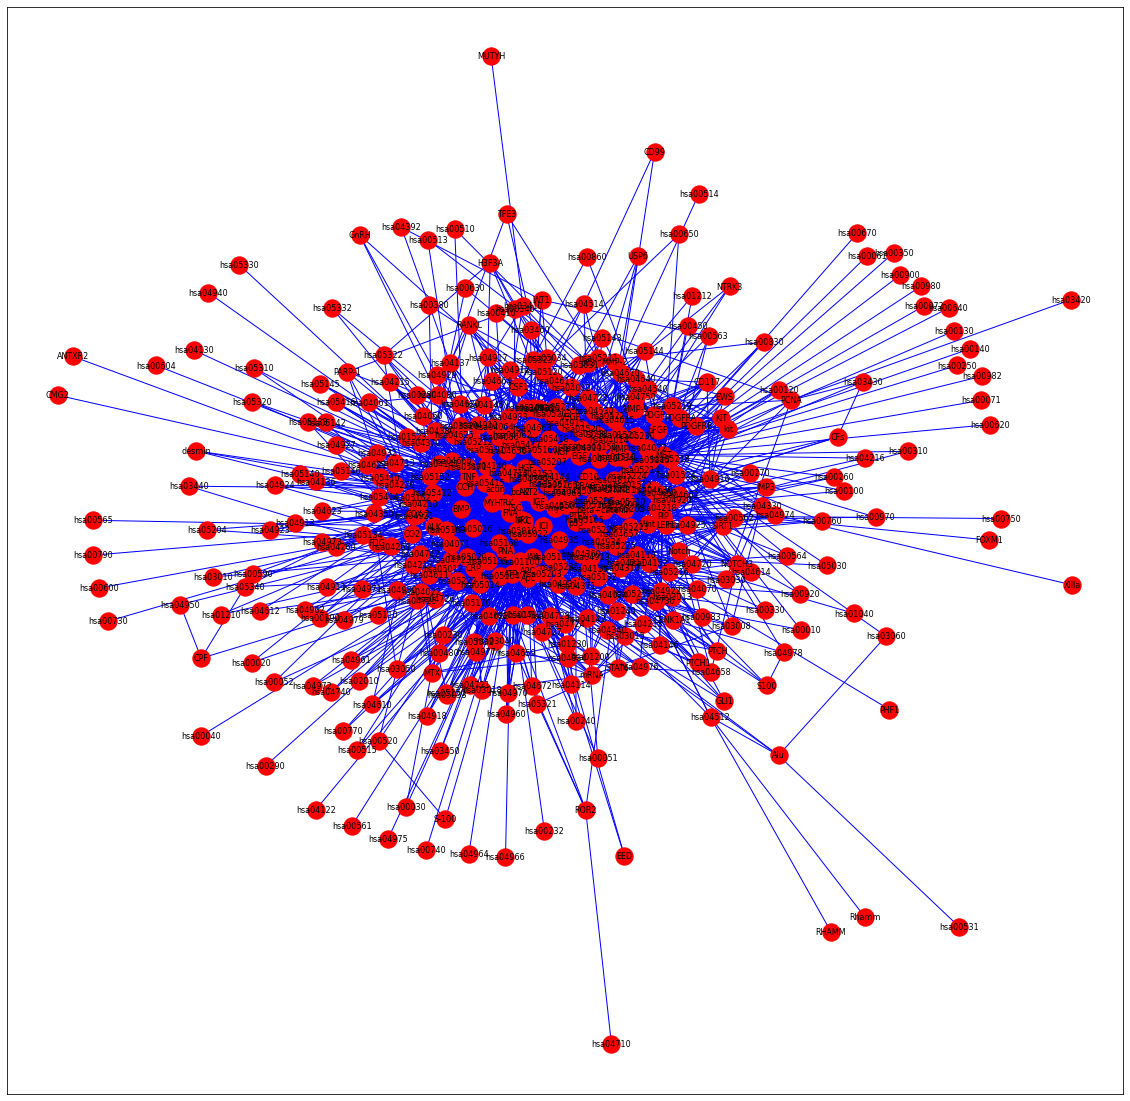

In [26]:
plot_network(G)

In [46]:
nx.write_gpickle(G,'gene_pathway.gpickle')

# 4. Trimming

Since "APC" and "beta catenin" genes are not mutated according to the background information, I am going to remove those pathways that are closely connected to these two genes. The rationale is these pathways must act 'normal' in that condition.  Hence, any associated genes are also 'silenced'.

In [48]:
nodes = nx.get_node_attributes(G, 'nature')

In [53]:
input_gene_list = []
for node, nature in nodes.items():
    if nature=='input':
        input_gene_list.append(node)
print(input_gene_list)

['APC', 'PKC', 'ATP', 'actin', 'IMP3', 'Notch', 'bcl-2', 'PTEN', 'TNF', 'FNA', 'ICI', 'PNA', 'USP6', 'NGF', 'CRP', 'AKT2', 'myc', 'IGF', 'PARP-1', 'p16', 'CD10', 'p53', 'NF1', 'TRK', 'EGF', 'MYH', 'MMP', 'EGFR', 'beta+catenin', 'HGF', 'COX-2', 'MDM2', 'PIP', 'PDGF', 'CMG2', 'MMP-2', 'PTCH1', 'ALK', 'NOTCH3', 'Wnt', 'MET', 'TSC', 'CCH', 'VEGF', 'CD117', 'CD34', 'SOS1', 'Apc', 'PDGFRA', 'FDG', 'PDGFRB', 'BMP', 'IAA', 'H3F3A', 'CTNNB1', 'EWS', 'LEF1', 'CO2', 'kit', 'BRAF', 'GnRH', 'MTX', 'PCNA', 'CFs', 'Rhamm', 'CSNK1A1', 'CPF', 'mRNA', 'CSF1', 'RANKL', 'MMP-9', 'STAT6', 'bFGF', 'SIRT1', 'p63', 'KIT', 'desmin', 'EED', 'TFE3', 'Alu', 'NTRK3', 'WT1', 'GLI1', 'ROR2', 'S100', 'CD99', 'S-100', 'PTCH', 'RHAMM', 'XIIIa', 'ANTXR2', 'FOXM1', 'MUTYH', 'PHF1']


In [60]:
%%time
confounding_factors =['APC','Apc','CTNNB1','beta+catenin']
connected_pathways = []
for source in confounding_factors:
    for target in input_gene_list:
        if source == target:
            pass
        else:
            #print (source, target)
            for path in nx.all_simple_paths(G, source=source, target=target, cutoff=3):
                #print (path)
                connected_pathways.append(path)

CPU times: user 1.48 s, sys: 3.24 ms, total: 1.49 s
Wall time: 1.48 s


In [59]:
for i in range(5):
    print (connected_pathways[i])

['APC', 'hsa05165', 'PKC']
['APC', 'hsa04724', 'PKC']
['APC', 'hsa04723', 'PKC']
['APC', 'hsa05225', 'PKC']
['APC', 'hsa04934', 'PKC']


In [61]:
%%time
R = nx.Graph()
for path in connected_pathways:
    R.add_edges_from([(path[0], path[1]), (path[1], path[2])]) 

CPU times: user 6.09 ms, sys: 82 µs, total: 6.18 ms
Wall time: 6.14 ms


In [62]:
%%time
H = G.copy()
H.remove_nodes_from(n for n in G if n in R)

CPU times: user 8.11 ms, sys: 161 µs, total: 8.27 ms
Wall time: 8.24 ms


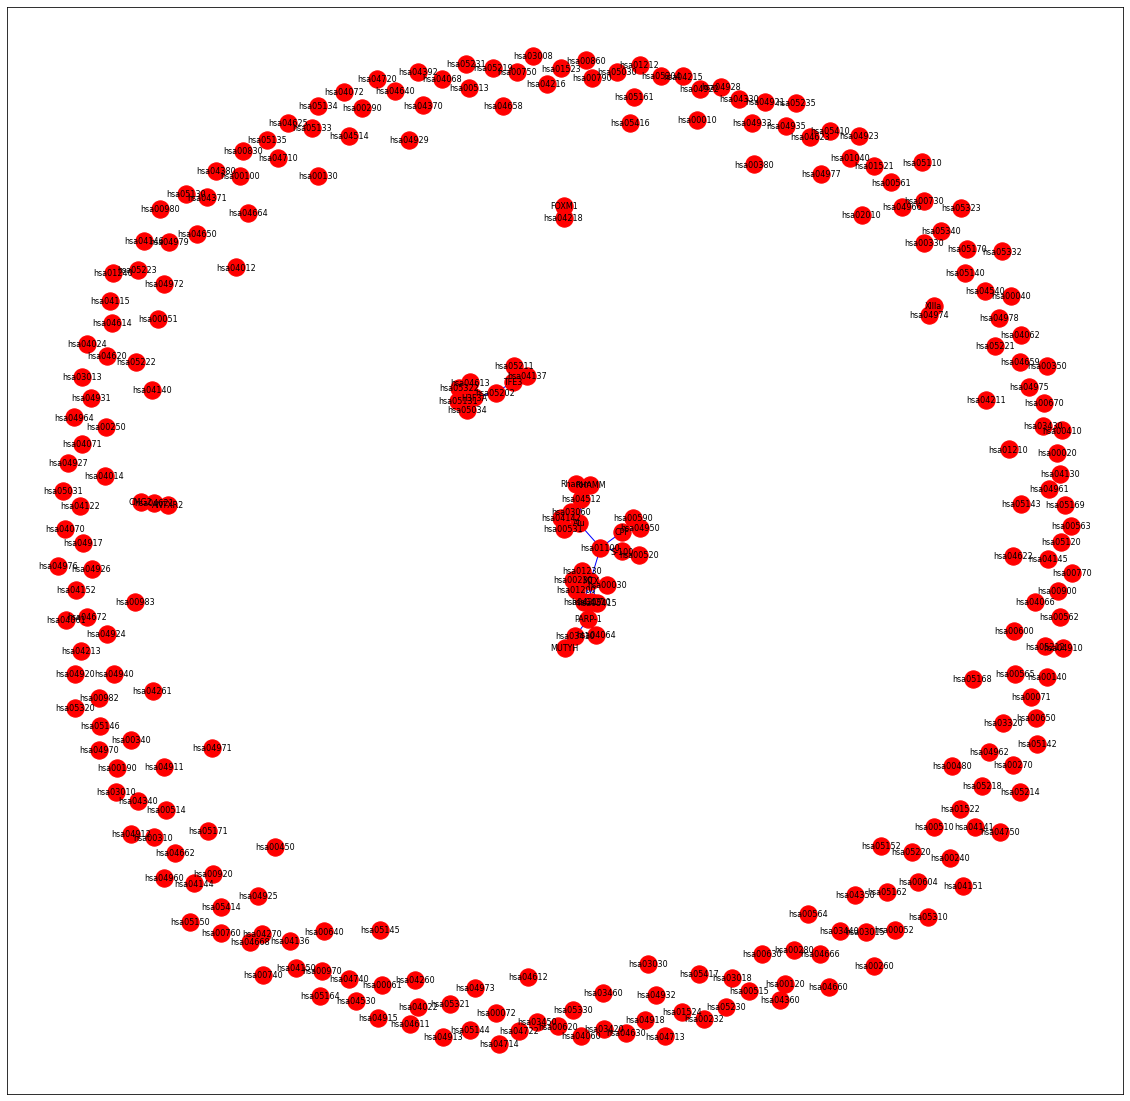

In [63]:
plot_network(H)

In [74]:
nx.write_gpickle(H, 'gene_pathway_subgraph.gpickle')

Those nodes that retains links are shown in the centre blobs.  And they are to be elaborated further.

# 5. Elaboration - Pathway Modules

In [17]:
H = nx.read_gpickle('gene_pathway_subgraph.gpickle')

In [19]:
def get_network_definition(networkIds):
    assert networkIds.startswith('N'), 'Incorrect network number format'
    dict_data = k.parse(k.get(networkIds))
    keys = check_pathway_nature(networkIds)
    name = dict_data['NAME'][0]
    reactant = []
    if 'DEFINITION' in keys:
        signaling_path = dict_data['DEFINITION'].split('   EXPANDED  ')
        genes, geneIds = signaling_path
        gene_pool = genes.split(' -> ')
        geneIds_pool = geneIds.split(' -> ')
        assert len(gene_pool)==len(geneIds_pool), 'Incompatible gene list!'
        for index, gene in enumerate(gene_pool):
            reactant.append([gene, geneIds_pool[index]])
        #reactant.append([genes, geneIds])
    return name, reactant

def get_module_definition(moduleIds):
    assert moduleIds.startswith('M'), 'Incorrect module number format'
    dict_data = k.parse(k.get(moduleIds))
    keys = check_pathway_nature(moduleIds)
    name = dict_data['NAME'][0]
    reactant = []
    if 'REACTION' in keys:
        for reaction, _ in dict_data['REACTION'].items():
            if reaction == '':
                pass
            else:
                reactant.append(reaction.split(','))
    return name, reactant

def get_reaction_defintion(reactionIds):
    assert reactionIds.startswith('R'), 'Incorrect reaction number format'
    dict_data = k.parse(k.get(reactionIds))
    keys = check_pathway_nature(reactionIds)
    name = dict_data['NAME'][0]
    reactant = dict()
    if 'DEFINITION' in keys:
        substrates, products = dict_data['DEFINITION'].split(' <=> ')
    if 'EQUATION' in keys:
        substratesIds, productsIds = dict_data['EQUATION'].split(' <=> ')
    reactant['Substrates'] = [substrates, substratesIds]
    reactant['Products'] = [products, productsIds]
    return name, reactant

def get_path_network_details(pathwayIds):
    dict_data = k.parse(k.get(pathwayIds))
    keys = check_pathway_nature(pathwayIds)
    name = dict_data['NAME'][0]
    pathway_network = []
    if 'NETWORK' in keys:
        signaling_path = dict_data['NETWORK']['ELEMENT']
        for key, value in signaling_path.items():
            pathway_network.append([pathwayIds, key, value])
    return name, pathway_network

def get_path_module_details(pathwayIds):
    dict_data = k.parse(k.get(pathwayIds))
    keys = check_pathway_nature(pathwayIds)
    name = dict_data['NAME'][0]
    pathway_network = []
    if 'MODULE' in keys:
        metabolic_path = dict_data['MODULE']
        for key, value in metabolic_path.items():
            pathway_network.append([pathwayIds, key.replace("hsa_",""), value])
    return name, pathway_network

def get_pathway_gene(pathwayIds):
    dict_data = k.parse(k.get(pathwayIds))
    cancer_rel_genes = []
    if 'GENE' in dict_data.keys():
        for ids, desc in dict_data['GENE'].items():
            geneName, long_name = desc.split('; ')
            description, num = long_name.split('[KO:')
            KO_num = num.replace(']','').replace('[','')
            cancer_rel_genes.append([ids, geneName, description, KO_num])
    return cancer_rel_genes

def check_pathway_nature(ids):
    dict_data = k.parse(k.get(ids))
    keys = [entry for entry in dict_data.keys()]
    return keys

In [18]:
# Remainings nodes that form a network
H.edges

EdgeView([('hsa04218', 'FOXM1'), ('PARP-1', 'hsa05415'), ('PARP-1', 'hsa04064'), ('PARP-1', 'hsa03410'), ('PARP-1', 'hsa04210'), ('PARP-1', 'hsa04217'), ('hsa05415', 'MTX'), ('hsa04217', 'MTX'), ('hsa04613', 'H3F3A'), ('CMG2', 'hsa04621'), ('hsa04621', 'ANTXR2'), ('hsa04210', 'MTX'), ('hsa05202', 'TFE3'), ('hsa05202', 'H3F3A'), ('hsa01230', 'MTX'), ('hsa04142', 'Alu'), ('hsa01100', 'CPF'), ('hsa01100', 'S-100'), ('hsa01100', 'MTX'), ('hsa01100', 'Alu'), ('hsa05131', 'H3F3A'), ('hsa03410', 'MUTYH'), ('H3F3A', 'hsa05034'), ('H3F3A', 'hsa05322'), ('hsa00520', 'S-100'), ('MTX', 'hsa00230'), ('MTX', 'hsa01200'), ('MTX', 'hsa00030'), ('Rhamm', 'hsa04512'), ('hsa04512', 'Alu'), ('hsa04512', 'RHAMM'), ('CPF', 'hsa04950'), ('CPF', 'hsa00590'), ('hsa05211', 'TFE3'), ('TFE3', 'hsa04137'), ('Alu', 'hsa00531'), ('Alu', 'hsa03060'), ('hsa04974', 'XIIIa')])

In [22]:
%%time
source_end_pairs = []
pathwayIds = []
for edge in tqdm(H.edges):
    if edge[0].startswith('hsa'):
        source_end_pairs.append([edge[1], edge[0]])
        pathwayIds.append(edge[0])
    else:
        source_end_pairs.append([edge[0], edge[1]])
        pathwayIds.append(edge[1])

100%|██████████| 38/38 [00:00<00:00, 208617.21it/s]

CPU times: user 1.63 ms, sys: 942 µs, total: 2.57 ms
Wall time: 1.78 ms


In [23]:
for i in range(38):
    print (source_end_pairs[i])
print(len(source_end_pairs))

['FOXM1', 'hsa04218']
['PARP-1', 'hsa05415']
['PARP-1', 'hsa04064']
['PARP-1', 'hsa03410']
['PARP-1', 'hsa04210']
['PARP-1', 'hsa04217']
['MTX', 'hsa05415']
['MTX', 'hsa04217']
['H3F3A', 'hsa04613']
['CMG2', 'hsa04621']
['ANTXR2', 'hsa04621']
['MTX', 'hsa04210']
['TFE3', 'hsa05202']
['H3F3A', 'hsa05202']
['MTX', 'hsa01230']
['Alu', 'hsa04142']
['CPF', 'hsa01100']
['S-100', 'hsa01100']
['MTX', 'hsa01100']
['Alu', 'hsa01100']
['H3F3A', 'hsa05131']
['MUTYH', 'hsa03410']
['H3F3A', 'hsa05034']
['H3F3A', 'hsa05322']
['S-100', 'hsa00520']
['MTX', 'hsa00230']
['MTX', 'hsa01200']
['MTX', 'hsa00030']
['Rhamm', 'hsa04512']
['Alu', 'hsa04512']
['RHAMM', 'hsa04512']
['CPF', 'hsa04950']
['CPF', 'hsa00590']
['TFE3', 'hsa05211']
['TFE3', 'hsa04137']
['Alu', 'hsa00531']
['Alu', 'hsa03060']
['XIIIa', 'hsa04974']
38


From above, 'Rhamm' and 'RHAMM' are duplicates. So I will remove the 'Rhamm'

In [24]:
source_end_pairs.remove(['Rhamm', 'hsa04512'])
for i in range(len(source_end_pairs)):
    print (source_end_pairs[i])
print(len(source_end_pairs))

['FOXM1', 'hsa04218']
['PARP-1', 'hsa05415']
['PARP-1', 'hsa04064']
['PARP-1', 'hsa03410']
['PARP-1', 'hsa04210']
['PARP-1', 'hsa04217']
['MTX', 'hsa05415']
['MTX', 'hsa04217']
['H3F3A', 'hsa04613']
['CMG2', 'hsa04621']
['ANTXR2', 'hsa04621']
['MTX', 'hsa04210']
['TFE3', 'hsa05202']
['H3F3A', 'hsa05202']
['MTX', 'hsa01230']
['Alu', 'hsa04142']
['CPF', 'hsa01100']
['S-100', 'hsa01100']
['MTX', 'hsa01100']
['Alu', 'hsa01100']
['H3F3A', 'hsa05131']
['MUTYH', 'hsa03410']
['H3F3A', 'hsa05034']
['H3F3A', 'hsa05322']
['S-100', 'hsa00520']
['MTX', 'hsa00230']
['MTX', 'hsa01200']
['MTX', 'hsa00030']
['Alu', 'hsa04512']
['RHAMM', 'hsa04512']
['CPF', 'hsa04950']
['CPF', 'hsa00590']
['TFE3', 'hsa05211']
['TFE3', 'hsa04137']
['Alu', 'hsa00531']
['Alu', 'hsa03060']
['XIIIa', 'hsa04974']
37


In [25]:
%%time
# Create this sub-graph based on the reduced pairs
I = nx.Graph()
for pair in tqdm(source_end_pairs):
    I.add_node(pair[0], name='inputNode')
    name, _ = get_path_module_details(pair[1])
    I.add_node(pair[1], name='pathwayIds', nature=name)
    I.add_edge(pair[0], pair[1])    

100%|██████████| 37/37 [00:16<00:00,  2.30it/s]

CPU times: user 238 ms, sys: 35.2 ms, total: 273 ms
Wall time: 16.1 s


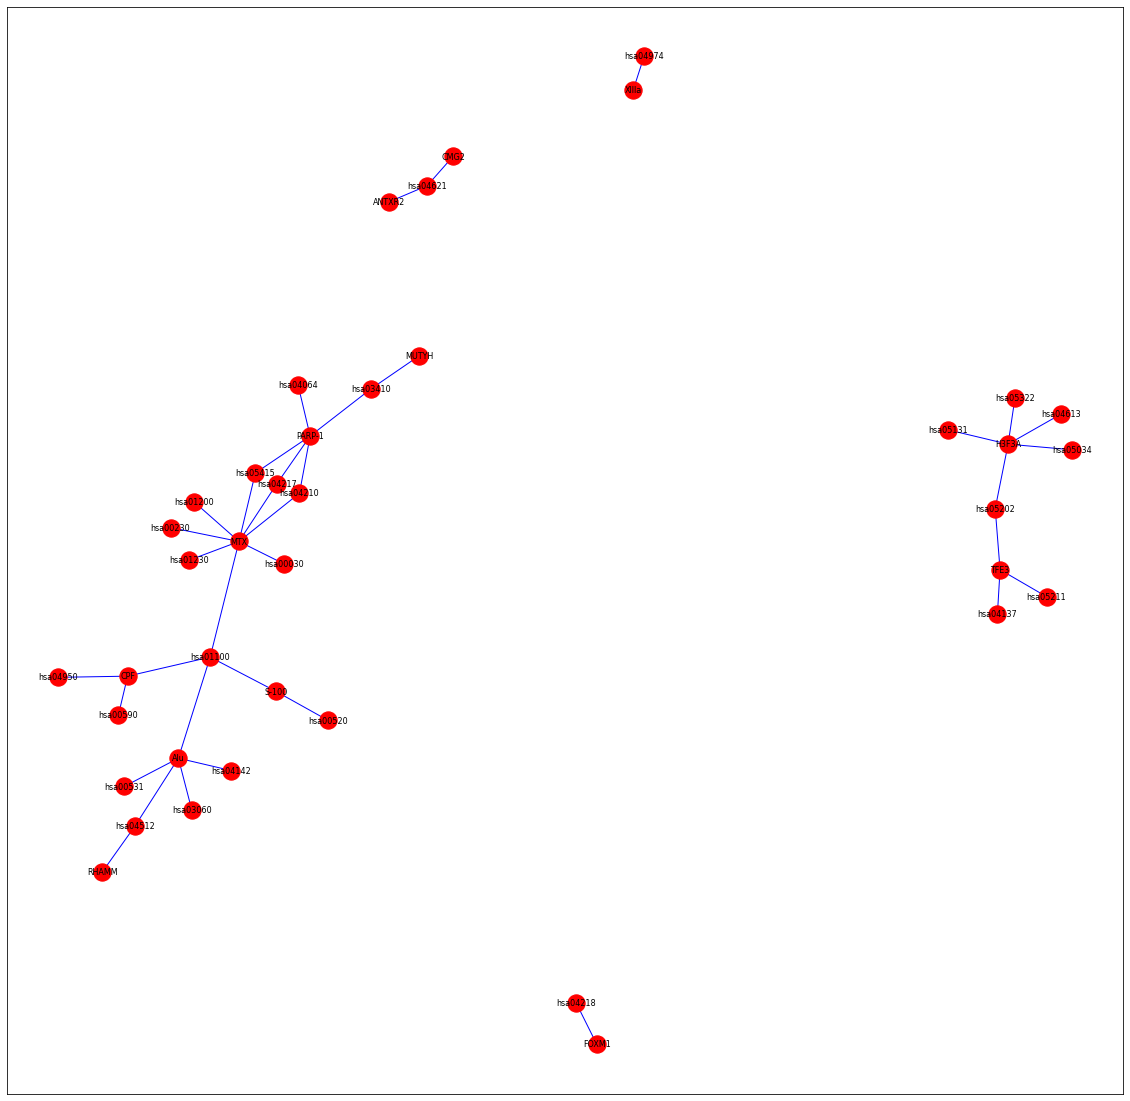

In [26]:
plot_network(I)

In [27]:
%%time
pathways = nx.get_node_attributes(I, 'name')
pathName = []
for path, value in tqdm(pathways.items()):
    if value == 'pathwayIds':
        dict_data = k.parse(k.get(path))
        pathName.append([path, dict_data['NAME'][0]])

100%|██████████| 40/40 [00:05<00:00,  6.92it/s]

CPU times: user 83.4 ms, sys: 13 ms, total: 96.4 ms
Wall time: 5.78 s


In [28]:
for i in range(len(pathName)):
    print (pathName[i])

['hsa04218', 'Cellular senescence - Homo sapiens (human)']
['hsa05415', 'Diabetic cardiomyopathy - Homo sapiens (human)']
['hsa04064', 'NF-kappa B signaling pathway - Homo sapiens (human)']
['hsa03410', 'Base excision repair - Homo sapiens (human)']
['hsa04210', 'Apoptosis - Homo sapiens (human)']
['hsa04217', 'Necroptosis - Homo sapiens (human)']
['hsa04613', 'Neutrophil extracellular trap formation - Homo sapiens (human)']
['hsa04621', 'NOD-like receptor signaling pathway - Homo sapiens (human)']
['hsa05202', 'Transcriptional misregulation in cancer - Homo sapiens (human)']
['hsa01230', 'Biosynthesis of amino acids - Homo sapiens (human)']
['hsa04142', 'Lysosome - Homo sapiens (human)']
['hsa01100', 'Metabolic pathways - Homo sapiens (human)']
['hsa05131', 'Shigellosis - Homo sapiens (human)']
['hsa05034', 'Alcoholism - Homo sapiens (human)']
['hsa05322', 'Systemic lupus erythematosus - Homo sapiens (human)']
['hsa00520', 'Amino sugar and nucleotide sugar metabolism - Homo sapiens (h

From above pathway list, some pathways, such as 'Alcoholism - Homo sapiens (human)' and 'hsa05131', 'Shigellosis - Homo sapiens (human)', seem to be irrelevant in the context of tumour development.  This kind of pathway will be removed during the analysis after I examined other more relevent pathways.

In [30]:
%%time
# Pathways to remove
removed_pathwayIds = ['hsa05415', 'hsa05131', 'hsa05034', 
                      'hsa05322', 'hsa04950', 'hsa05211']
for ids in tqdm(removed_pathwayIds):
    I.remove_node(ids)

100%|██████████| 6/6 [00:00<00:00, 64527.75it/s]

CPU times: user 1.46 ms, sys: 1.05 ms, total: 2.51 ms
Wall time: 1.63 ms


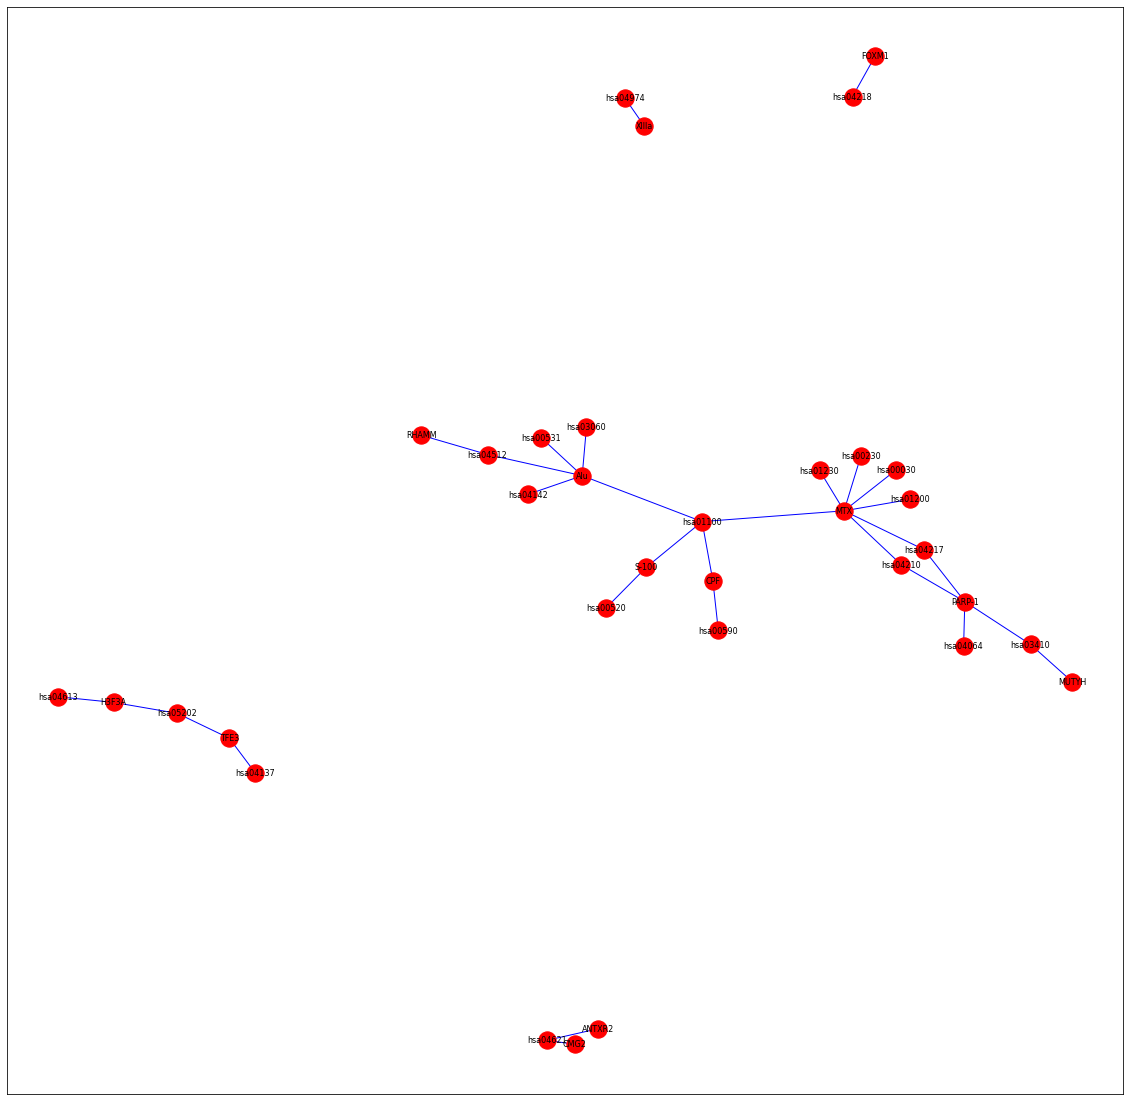

In [31]:
plot_network(I)

In [34]:
# checkpoint
nx.write_gpickle(I, 'desmoid_fibromatosis_gene_pathway.gpickle')

In [10]:
I = nx.read_gpickle('desmoid_fibromatosis_gene_pathway.gpickle')

In [6]:
S = [I.subgraph(c).copy() for c in nx.connected_components(I)]

In [7]:
largest_cc = max(nx.connected_components(I), key=len)

In [8]:
for entry in largest_cc:
    print (entry)

hsa03060
hsa04210
hsa01230
hsa04064
RHAMM
hsa00531
hsa00590
PARP-1
hsa04142
hsa00520
hsa03410
hsa01100
CPF
hsa00230
hsa04512
MUTYH
Alu
S-100
hsa04217
MTX
hsa01200
hsa00030


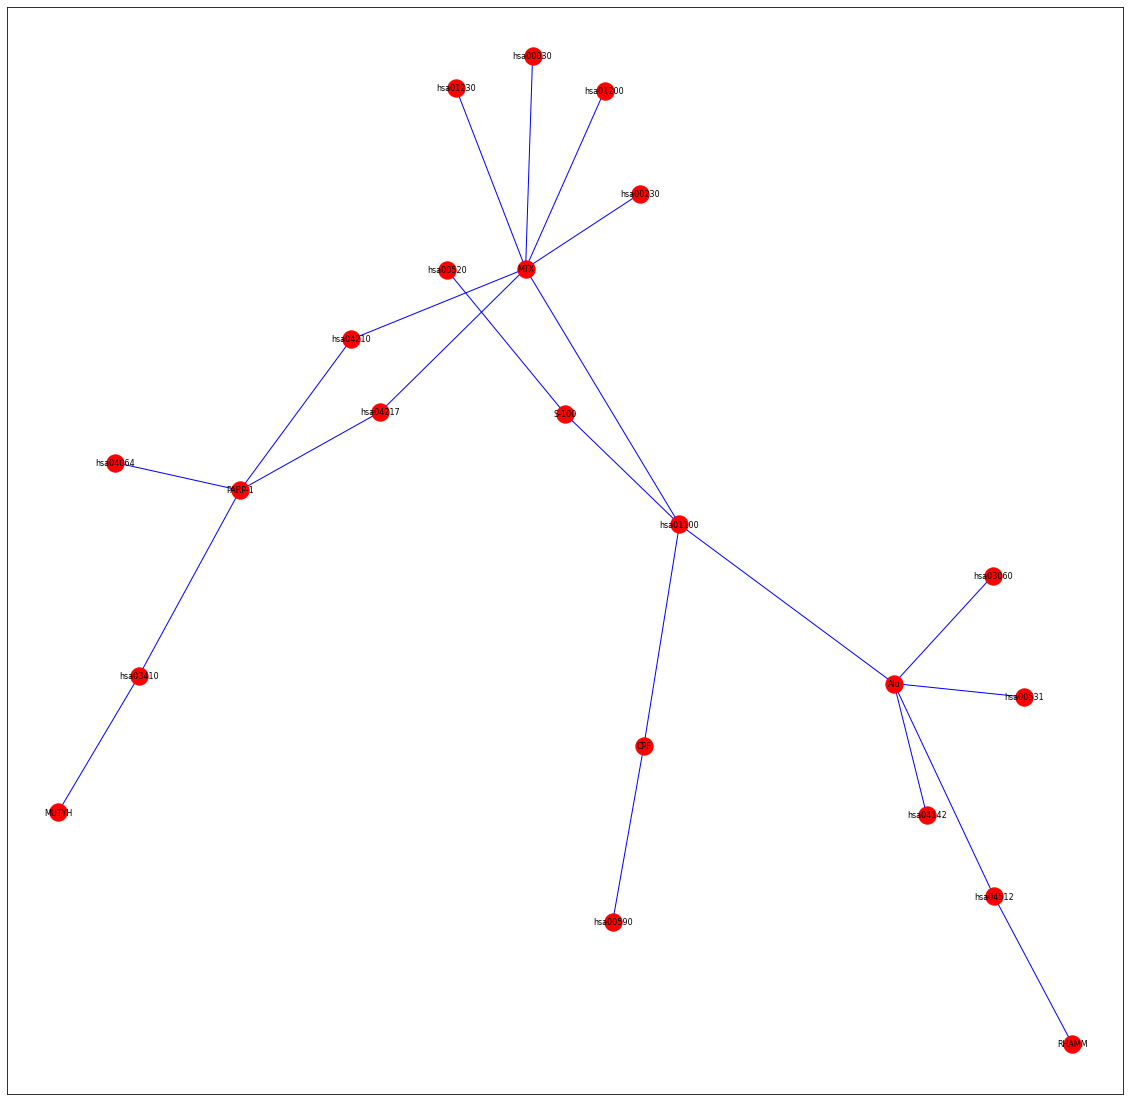

In [9]:
plot_network(S[1])

In [21]:
%%time
pathways = nx.get_node_attributes(S[1], 'name')
largest_cc_path = []
for path, value in tqdm(pathways.items()):
    if value == 'pathwayIds':
        dict_data = k.parse(k.get(path))
        largest_cc_path.append([path, dict_data['NAME'][0]])

100%|██████████| 22/22 [00:03<00:00,  6.76it/s]

CPU times: user 54 ms, sys: 10 ms, total: 64 ms
Wall time: 3.26 s


In [22]:
for i in largest_cc_path:
    print (i)

['hsa04064', 'NF-kappa B signaling pathway - Homo sapiens (human)']
['hsa03410', 'Base excision repair - Homo sapiens (human)']
['hsa04210', 'Apoptosis - Homo sapiens (human)']
['hsa04217', 'Necroptosis - Homo sapiens (human)']
['hsa01230', 'Biosynthesis of amino acids - Homo sapiens (human)']
['hsa04142', 'Lysosome - Homo sapiens (human)']
['hsa01100', 'Metabolic pathways - Homo sapiens (human)']
['hsa00520', 'Amino sugar and nucleotide sugar metabolism - Homo sapiens (human)']
['hsa00230', 'Purine metabolism - Homo sapiens (human)']
['hsa01200', 'Carbon metabolism - Homo sapiens (human)']
['hsa00030', 'Pentose phosphate pathway - Homo sapiens (human)']
['hsa04512', 'ECM-receptor interaction - Homo sapiens (human)']
['hsa00590', 'Arachidonic acid metabolism - Homo sapiens (human)']
['hsa00531', 'Glycosaminoglycan degradation - Homo sapiens (human)']
['hsa03060', 'Protein export - Homo sapiens (human)']


In [32]:
%%time
# Extract modules or networks that make up the pathway.
path_network = []
path_module = []
for pair in tqdm(largest_cc_path):
    name, networks = get_path_network_details(pair[0])
    for n in networks:
        path_network.append(n)
            
for pair in tqdm(largest_cc_path):
    name, modules = get_path_module_details(pair[0])
    for m in modules:
        path_module.append(m)

100%|██████████| 15/15 [00:07<00:00,  1.96it/s]

CPU times: user 176 ms, sys: 25.7 ms, total: 201 ms
Wall time: 14.2 s


In [33]:
for network in path_network:
    print (network)
print()
for module in path_module:
    print (module)

['hsa04064', 'N00151', 'TNF-NFKB signaling pathway']
['hsa04064', 'N00505', 'CD40-NFKB signaling pathway']
['hsa04064', 'N00559', 'LIGHT-HVEM-NFKB signaling pathway']
['hsa04210', 'N00098', 'Intrinsic apoptotic pathway']
['hsa04210', 'N00145', 'Extrinsic apoptotic pathway']
['hsa04210', 'N00146', 'Crosstalk between extrinsic and intrinsic apoptotic pathways']
['hsa04210', 'N00984', 'mGluR5-Ca2+ -apoptotic pathway']
['hsa04210', 'N01056', 'FAS-JNK signaling pathway']
['hsa00520', 'N00667', 'N-Glycan precursor biosynthesis, Glc-6P to Man-P-Dol']
['hsa00520', 'N00673', 'N-Glycan precursor biosynthesis, Glc-6P to UDP-Glu']
['hsa00230', 'N00888', 'Hypoxanthine oxidation']
['hsa00531', 'N00610', 'Dermatan sulfate degradation']
['hsa00531', 'N00615', 'Heparan sulfate degradation']
['hsa00531', 'N00623', 'Keratan sulfate degradation']

['hsa01230', 'M00002', 'Glycolysis, core module involving three-carbon compounds [PATH:hsa01230]']
['hsa01230', 'M00005', 'PRPP biosynthesis, ribose 5P => PRPP 

In [34]:
J = S[1].copy()

In [36]:
%%time
for network in tqdm(path_network):
    J.add_node(network[1], nature='network', name=network[2])
    J.add_edge(network[0], network[1])
for module in tqdm(path_module):
    J.add_node(module[1], nature='module', name=module[2])
    J.add_edge(module[0], module[1])

100%|██████████| 144/144 [00:00<00:00, 228175.21it/s]

CPU times: user 3.06 ms, sys: 1.29 ms, total: 4.35 ms
Wall time: 3.43 ms


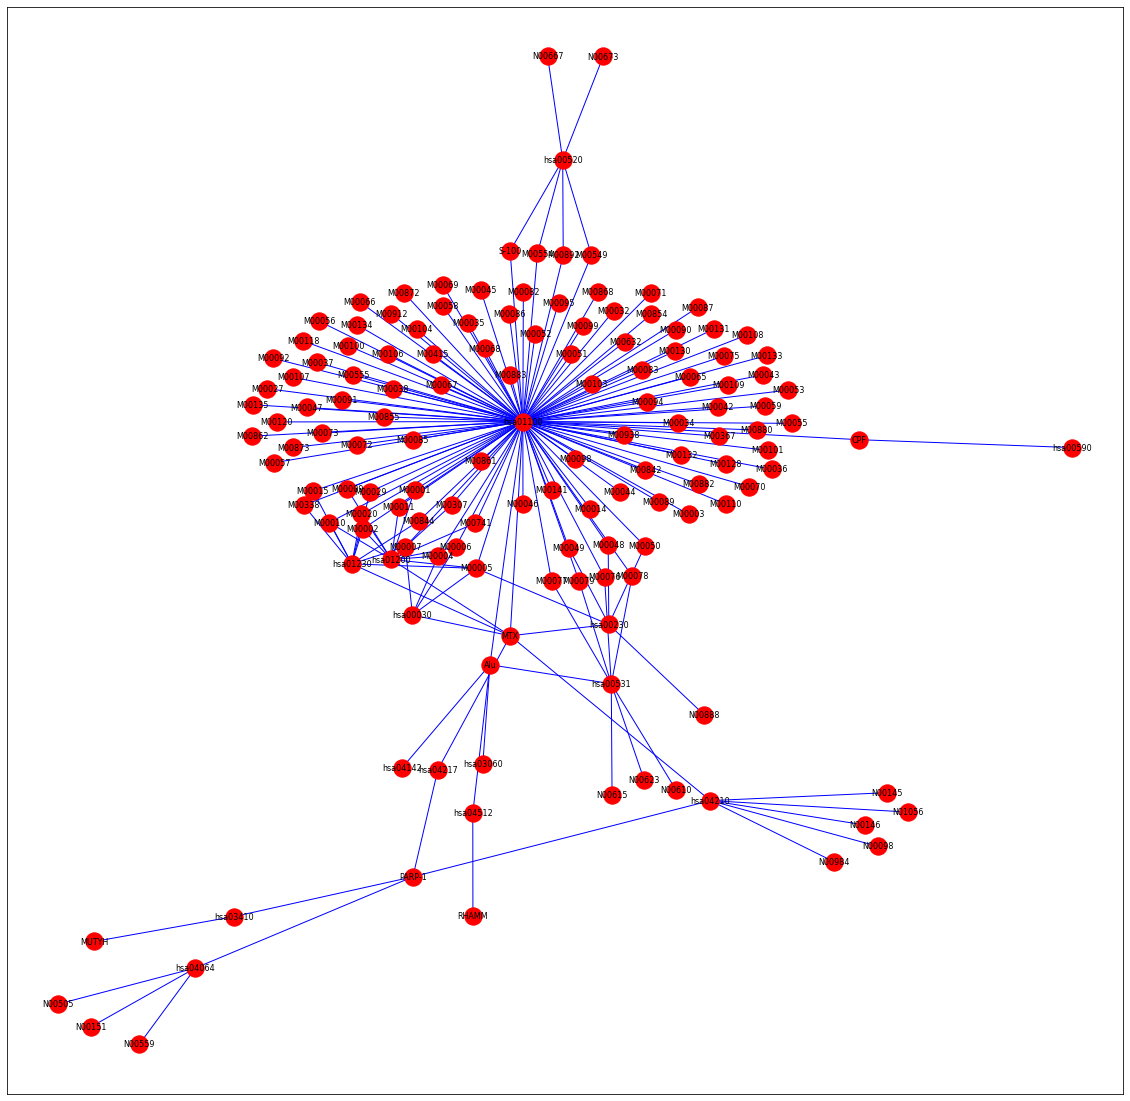

In [37]:
plot_network(J)

In [38]:
nx.write_gpickle(J, 'desmoid_fibromatosis_largest_subgraph.gpickle')

In [ ]:
%%time
reaction = []
for i in tqdm(range(len(path_network))):
    ids = path_network[i][1]
    name, reactant = get_network_definition(ids)
    reaction.append([name, reactant])

KEGG NETWORK Database

https://www.kegg.jp/kegg/network.html

In [42]:
for pair in reaction:
    print (pair[0])
    print (pair[1])
    print ()

TNF-NFKB signaling pathway
[['TNF', '7124'], ['TNFRSF1A', '7132'], ['(RIPK1+TRADD+TRAF2/5)', '(8737+8717+(7186,7188))'], ['(TAB1/2/3+TAK1)', '((10454,23118,257397)+6885)'], ['IKK', '(1147+3551+8517)'], ['NFKBIA', '4792'], ['NFKB', '(4790+5970)']]

CD40-NFKB signaling pathway
[['CD40LG', '959'], ['CD40', '958'], ['(TRAF2+TRAF3)', '(7186+7187)'], ['NIK', '9020'], ['IKKA', '1147'], ['(NFKB2+RELB)', '(4791+5971)']]

LIGHT-HVEM-NFKB signaling pathway
[['TNFSF14', '8740'], ['TNFRSF14', '8764'], ['TRAF2/5', '(7186,7188)'], ['IKK', '(1147+3551+8517)'], ['NFKBIA', '4792'], ['NFKB', '(4790+5970)']]

Intrinsic apoptotic pathway
[['(PMAIP1,BBC3,BAD,BCL2L11) -| (BCL2,BCL2L1) -| (BAX,BAK1)', '(5366,27113,572,10018) -| (596,598) -| (581,578)'], ['CYCS -- APAF1', '54205 -- 317'], ['CASP9', '842'], ['(CASP3,CASP7)', '(836,840)']]

Extrinsic apoptotic pathway
[['TNF', '7124'], ['TNFRSF1A', '7132'], ['TRADD -- FADD', '8717 -- 8772'], ['CASP8', '841'], ['(CASP3,CASP7)', '(836,840)']]

Crosstalk between ex

In [43]:
%%time
reaction = []
for i in tqdm(range(len(path_module))):
    ids = path_module[i][1]
    name, reactant = get_module_definition(ids)
    reaction.append([name, reactant])

100%|██████████| 144/144 [01:01<00:00,  2.32it/s]

CPU times: user 713 ms, sys: 111 ms, total: 824 ms
Wall time: 1min 1s


In [44]:
for pair in reaction:
    print (pair[0])
    print (pair[1])
    print ()

Glycolysis, core module involving three-carbon compounds
[['R01015'], ['R01061', 'R01063'], ['R01512'], ['R07159'], ['R01518'], ['R00658'], ['R00200']]

PRPP biosynthesis, ribose 5P => PRPP
[['R01049']]

Pentose phosphate pathway, non-oxidative phase, fructose 6P => ribose 5P
[['R01830'], ['R01827'], ['R01641'], ['R01529'], ['R01056']]

Citrate cycle, first carbon oxidation, oxaloacetate => 2-oxoglutarate
[['R00351'], ['R01325+R01900', 'R01324'], ['R01899+R00268', 'R00267', 'R00709']]

Proline biosynthesis, glutamate => proline
[['R00239'], ['R03313'], ['R03314'], ['R01251']]

Serine biosynthesis, glycerate-3P => serine
[['R01513'], ['R04173'], ['R00582']]

Urea cycle
[['R00149'], ['R01398'], ['R01954'], ['R01086'], ['R00551']]

Cysteine biosynthesis, homocysteine + serine => cysteine
[['R01290'], ['R01001']]

Arginine biosynthesis, ornithine => arginine
[['R01398'], ['R01954'], ['R01086']]

Glycolysis (Embden-Meyerhof pathway), glucose => pyruvate
[['R01786', 'R02189', 'R09085'], ['R0

# 6. Subgraph Characteristics

I will study the largest 'community' to see if there is central node and/or significant path that will shed light on what to focus.

In [11]:
# Centrality
centrality = nx.eigenvector_centrality(I)
node_centrality_score = sorted((v, f"{c:0.4f}") for v, c in centrality.items())
node_centrality_score

[('ANTXR2', '0.0000'),
 ('Alu', '0.2383'),
 ('CMG2', '0.0000'),
 ('CPF', '0.1422'),
 ('FOXM1', '0.0000'),
 ('H3F3A', '0.0000'),
 ('MTX', '0.5812'),
 ('MUTYH', '0.0323'),
 ('PARP-1', '0.2509'),
 ('RHAMM', '0.0307'),
 ('S-100', '0.1422'),
 ('TFE3', '0.0000'),
 ('XIIIa', '0.0000'),
 ('hsa00030', '0.1964'),
 ('hsa00230', '0.1964'),
 ('hsa00520', '0.0480'),
 ('hsa00531', '0.0805'),
 ('hsa00590', '0.0480'),
 ('hsa01100', '0.3729'),
 ('hsa01200', '0.1964'),
 ('hsa01230', '0.1964'),
 ('hsa03060', '0.0805'),
 ('hsa03410', '0.0957'),
 ('hsa04064', '0.0847'),
 ('hsa04137', '0.0000'),
 ('hsa04142', '0.0805'),
 ('hsa04210', '0.2811'),
 ('hsa04217', '0.2811'),
 ('hsa04218', '0.0000'),
 ('hsa04512', '0.0909'),
 ('hsa04613', '0.0000'),
 ('hsa04621', '0.0000'),
 ('hsa04974', '0.0000'),
 ('hsa05202', '0.0000')]

In [12]:
%%time
# Update node weight based on above centrality score

for node_score in node_centrality_score:
    I.nodes[node_score[0]]['node_wgt']=node_score[1]

CPU times: user 50 µs, sys: 1e+03 ns, total: 51 µs
Wall time: 52.9 µs


In [13]:
nx.set_edge_attributes(I, 1, name='edge_wgt')

In [14]:
# Identify those key entries based on network topology
from networkx.algorithms import approximation
node_set = approximation.min_weighted_dominating_set(I, weight='weight')

In [15]:
# checkpoint
nx.write_gpickle(I, 'desmoid_fibromatosis_gene_pathway.gpickle')

In [19]:
for node in node_set:
    if node.startswith('hsa'):
        dict_data = k.parse(k.get(node))
        if 'NAME' in dict_data.keys():
            print (node, dict_data['NAME'][0])
    else:
        print (node)

hsa04512 ECM-receptor interaction - Homo sapiens (human)
PARP-1
CPF
hsa04621 NOD-like receptor signaling pathway - Homo sapiens (human)
H3F3A
MTX
TFE3
FOXM1
hsa03410 Base excision repair - Homo sapiens (human)
XIIIa
Alu
S-100


In [20]:
%%time
gene_pathway = []
for node in node_set:
    if node.startswith('hsa'):
        #print ('null', node)
        gene_pathway.append(['null', node])
    else:
        neighbors = nx.neighbors(I, node)
        for n in neighbors:
            #print ((node, n))
            gene_pathway.append([node, n])
for entry in tqdm(gene_pathway):
    print (entry)

100%|██████████| 29/29 [00:00<00:00, 32688.74it/s]

['null', 'hsa04512']
['PARP-1', 'hsa04064']
['PARP-1', 'hsa03410']
['PARP-1', 'hsa04210']
['PARP-1', 'hsa04217']
['CPF', 'hsa01100']
['CPF', 'hsa00590']
['null', 'hsa04621']
['H3F3A', 'hsa04613']
['H3F3A', 'hsa05202']
['MTX', 'hsa04217']
['MTX', 'hsa04210']
['MTX', 'hsa01230']
['MTX', 'hsa01100']
['MTX', 'hsa00230']
['MTX', 'hsa01200']
['MTX', 'hsa00030']
['TFE3', 'hsa05202']
['TFE3', 'hsa04137']
['FOXM1', 'hsa04218']
['null', 'hsa03410']
['XIIIa', 'hsa04974']
['Alu', 'hsa04142']
['Alu', 'hsa01100']
['Alu', 'hsa04512']
['Alu', 'hsa00531']
['Alu', 'hsa03060']
['S-100', 'hsa01100']
['S-100', 'hsa00520']
CPU times: user 2.01 ms, sys: 1.31 ms, total: 3.32 ms
Wall time: 2.26 ms


In [21]:
df = pd.read_csv('hsa05200_min_wgt_dominating_set.csv')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pathwayIds   17 non-null     object
 1   pathwayName  17 non-null     object
dtypes: object(2)
memory usage: 400.0+ bytes


In [23]:
hsa05200_ids = df['pathwayIds']

In [24]:
for entry in gene_pathway:
    if entry[1] in hsa05200_ids:
        print (entry[1],'overlaps with hsa05200 key sub-pathway.')
    else:
        print (entry[1],'does NOT overlap with any hsa05200 key sub-pathway.')

hsa04512 does NOT overlap with any hsa05200 key sub-pathway.
hsa04064 does NOT overlap with any hsa05200 key sub-pathway.
hsa03410 does NOT overlap with any hsa05200 key sub-pathway.
hsa04210 does NOT overlap with any hsa05200 key sub-pathway.
hsa04217 does NOT overlap with any hsa05200 key sub-pathway.
hsa01100 does NOT overlap with any hsa05200 key sub-pathway.
hsa00590 does NOT overlap with any hsa05200 key sub-pathway.
hsa04621 does NOT overlap with any hsa05200 key sub-pathway.
hsa04613 does NOT overlap with any hsa05200 key sub-pathway.
hsa05202 does NOT overlap with any hsa05200 key sub-pathway.
hsa04217 does NOT overlap with any hsa05200 key sub-pathway.
hsa04210 does NOT overlap with any hsa05200 key sub-pathway.
hsa01230 does NOT overlap with any hsa05200 key sub-pathway.
hsa01100 does NOT overlap with any hsa05200 key sub-pathway.
hsa00230 does NOT overlap with any hsa05200 key sub-pathway.
hsa01200 does NOT overlap with any hsa05200 key sub-pathway.
hsa00030 does NOT overla

Given this, I would hypothesize that is why the patient's prognosis did not match the expectations as depicted in the project page.  And I would again hypothesize that these 'nodes' would provide entry point(s) for treatment design.

# 7. Gene level similarity 

Following steps aim at checking if there is any potential overlap in gene expression between the desmoid tumor and the cancer pathway hsa05200.  Any potential overlap could be the search for anomal(ies) in the genetic profile of the patient.

In [25]:
df_gene = pd.read_csv('hsa05200_genes.csv')
df_gene.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ids          531 non-null    int64 
 1   geneName     531 non-null    object
 2   description  531 non-null    object
 3   KO_num       531 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.7+ KB


In [26]:
df_gene.head()

,ids,geneName,description,KO_num
0,1630,DCC,DCC netrin 1 receptor,K06765
1,836,CASP3,caspase 3,K02187 EC:3.4.22.56
2,842,CASP9,caspase 9,K04399 EC:3.4.22.62
3,26060,APPL1,"adaptor protein, phosphotyrosine interacting w...",K08733
4,999,CDH1,cadherin 1,K05689


In [27]:
hsa05200_geneName = df_gene['geneName']

In [28]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [29]:
similarity = dict()
for entry in tqdm(gene_pathway):
    desmoid_gene = entry[0]
    for hsa05200_gene in hsa05200_geneName:
        similarity[(desmoid_gene, hsa05200_gene)] = similar(desmoid_gene, hsa05200_gene)

100%|██████████| 29/29 [00:00<00:00, 198.48it/s]


In [31]:
for key, value in similarity.items():
    if value > 0.7: # only show high similarity items
        print (key, f"{value:0.2f}")

('PARP-1', 'LPAR1') 0.73
('FOXM1', 'FOXO1') 0.80


# 'FOXM1', 'FOXO1'

In [1]:
from Bio import Entrez
from Bio import Medline
import time
Entrez.email = "simonkamantse@outlook.com"

In [4]:
handle = Entrez.efetch(db="pubmed",id='21443467',rettype="medline",retmode="text",)
record = Medline.read(handle)
record.get("AB","?")

'FOXO transcription factors, functioning downstream of the PI3K-PTEN-AKT (PKB) signalling cascade, are essential for cell proliferation, differentiation, DNA damage repair, and apoptosis. Recent research indicates that the related transcription factor FOXM1 is a direct target of repression by FOXO proteins. Inactivation of FOXO or overexpression of FOXM1 is associated with tumorigenesis and cancer progression. In addition, the cytostatic and cytotoxic effects of a diverse spectrum of anti-cancer drugs, such as paclitaxel, doxorubicin, lapatinib, gefitinib, imatinib, and cisplatin, are mediated through the activation of FOXO3a and/or the inhibition of its target FOXM1. Paradoxically, FOXO proteins also contribute to drug resistance by driving the expression of genes important for drug efflux as well as DNA repair and cell survival pathways in drug resistant cancers. Given its pivotal roles of in drug sensitivity as well as resistance, targeting the FOXO-FOXM1 axis could be a viable stra

# 'PARP-1', 'LPAR1'

Citation: Lin,Y.-H.; Lin,Y.-C.; Chen, C.-C. Lysophosphatidic Acid Receptor Antagonists and Cancer: The Current Trends, Clinical Implications, and Trials. Cells 2021, 10, 1629. https://doi.org/10.3390/ cells10071629

[...] For radiotherapy, it is therapeutically important to lower the radio-resistance of cancer cells but to protect normal tissue injury from radiation. In response to radiation injury, adipose tissue increased ATX production and LPARs expressions to enhance LPA signal- ing. Since ATX responses were found to precede the radiation-induced inflammatory cascade in several in vivo studies, the ATX-LPA-inflammatory cycle may play a vital role in desensitizing cancer cells to radiotherapy. Different LPARs mediate radio-resistance in different cancer cells, and LPAR1 is a pronounced receptor to mediate radio-resistance because of its ability to stabilize Nrf2 via PI3K signaling. Nrf2 mediates mul- tiple antioxidant enzymes, such as glutathione S-transferase A2 (GSTA2) and NADPH quinone oxidoreductase 1 (NQO1), to protect cancer cells from oxidative stress. Nrf2 over-expression enables cancer cells against radiation injury by cross-talk with multiple LPA-induced DNA repair proteins expressions (e.g., ATM, ATR, PARP-1) to activate NF-κB signaling. It implies that Nrf2 destabilization may be a potential strategy to overcome radio-resistance. 